### This script is designed to take an input of location of a beacon in X and Y coordinates and bin size of historgram. It knows already the size of the arena and will produce a histogram/ matrix of numbers for occupancy/area per each bin.


In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.patches as patches
from PIL import Image
import matplotlib.image as mpimg
import pandas as pd
import math
from tqdm import tqdm_notebook as tqdm

figures = 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/Figures/'
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/'

### TODO: 
    1. DONE Figure out making normalization without saving picture each time.  
    2. DONE For each change of beacon make a histogram and multiply by given normalization 
    3. DONE Make large array to produce for histogram making
    4. DONE Make the units by nesity - pixels to area
    5. DONE Save output of each - normalized visible/ normalized invisible/ normalized all. for each animal 
    6. DONE do bootstrapping on the data to get a real normalized distribution -repeated for up to 100 000 rears 
    7. Statistics to run significance.  - will need to add or divide by amount of rear attempts considered... sicne invisible gives much lower density as way fewer invisible attempts. could count density in 100 rears/ cm**2so only ddivide (hist/rear)*100 or just normalize the hist when comparign to each other.... 
    8. Count rearign in 3 bands - .75 .15 and .225 to see if significant. 

### 1. input arena size

In [2]:
cut = 0 # keeping the cut where rectangle of arena ends
X_cut_min = -.59
Y_cut_max = 1.61
X_cut_max = .12
Y_cut_min = .00
print("area %s M*2" %((X_cut_max-X_cut_min)*(Y_cut_max-Y_cut_min))) 

x_max, x_min = 0.12, -0.59
x_offset = x_max - (x_max - x_min)/2
y_max, y_min = 1.61,  0
y_offset = y_max - (y_max - y_min)/2
print(x_offset,y_offset)

# to center the zero in... 
xcut_offset=-.24
ycut_offset=-.8

cut=0


area 1.1431 M*2
-0.235 0.805


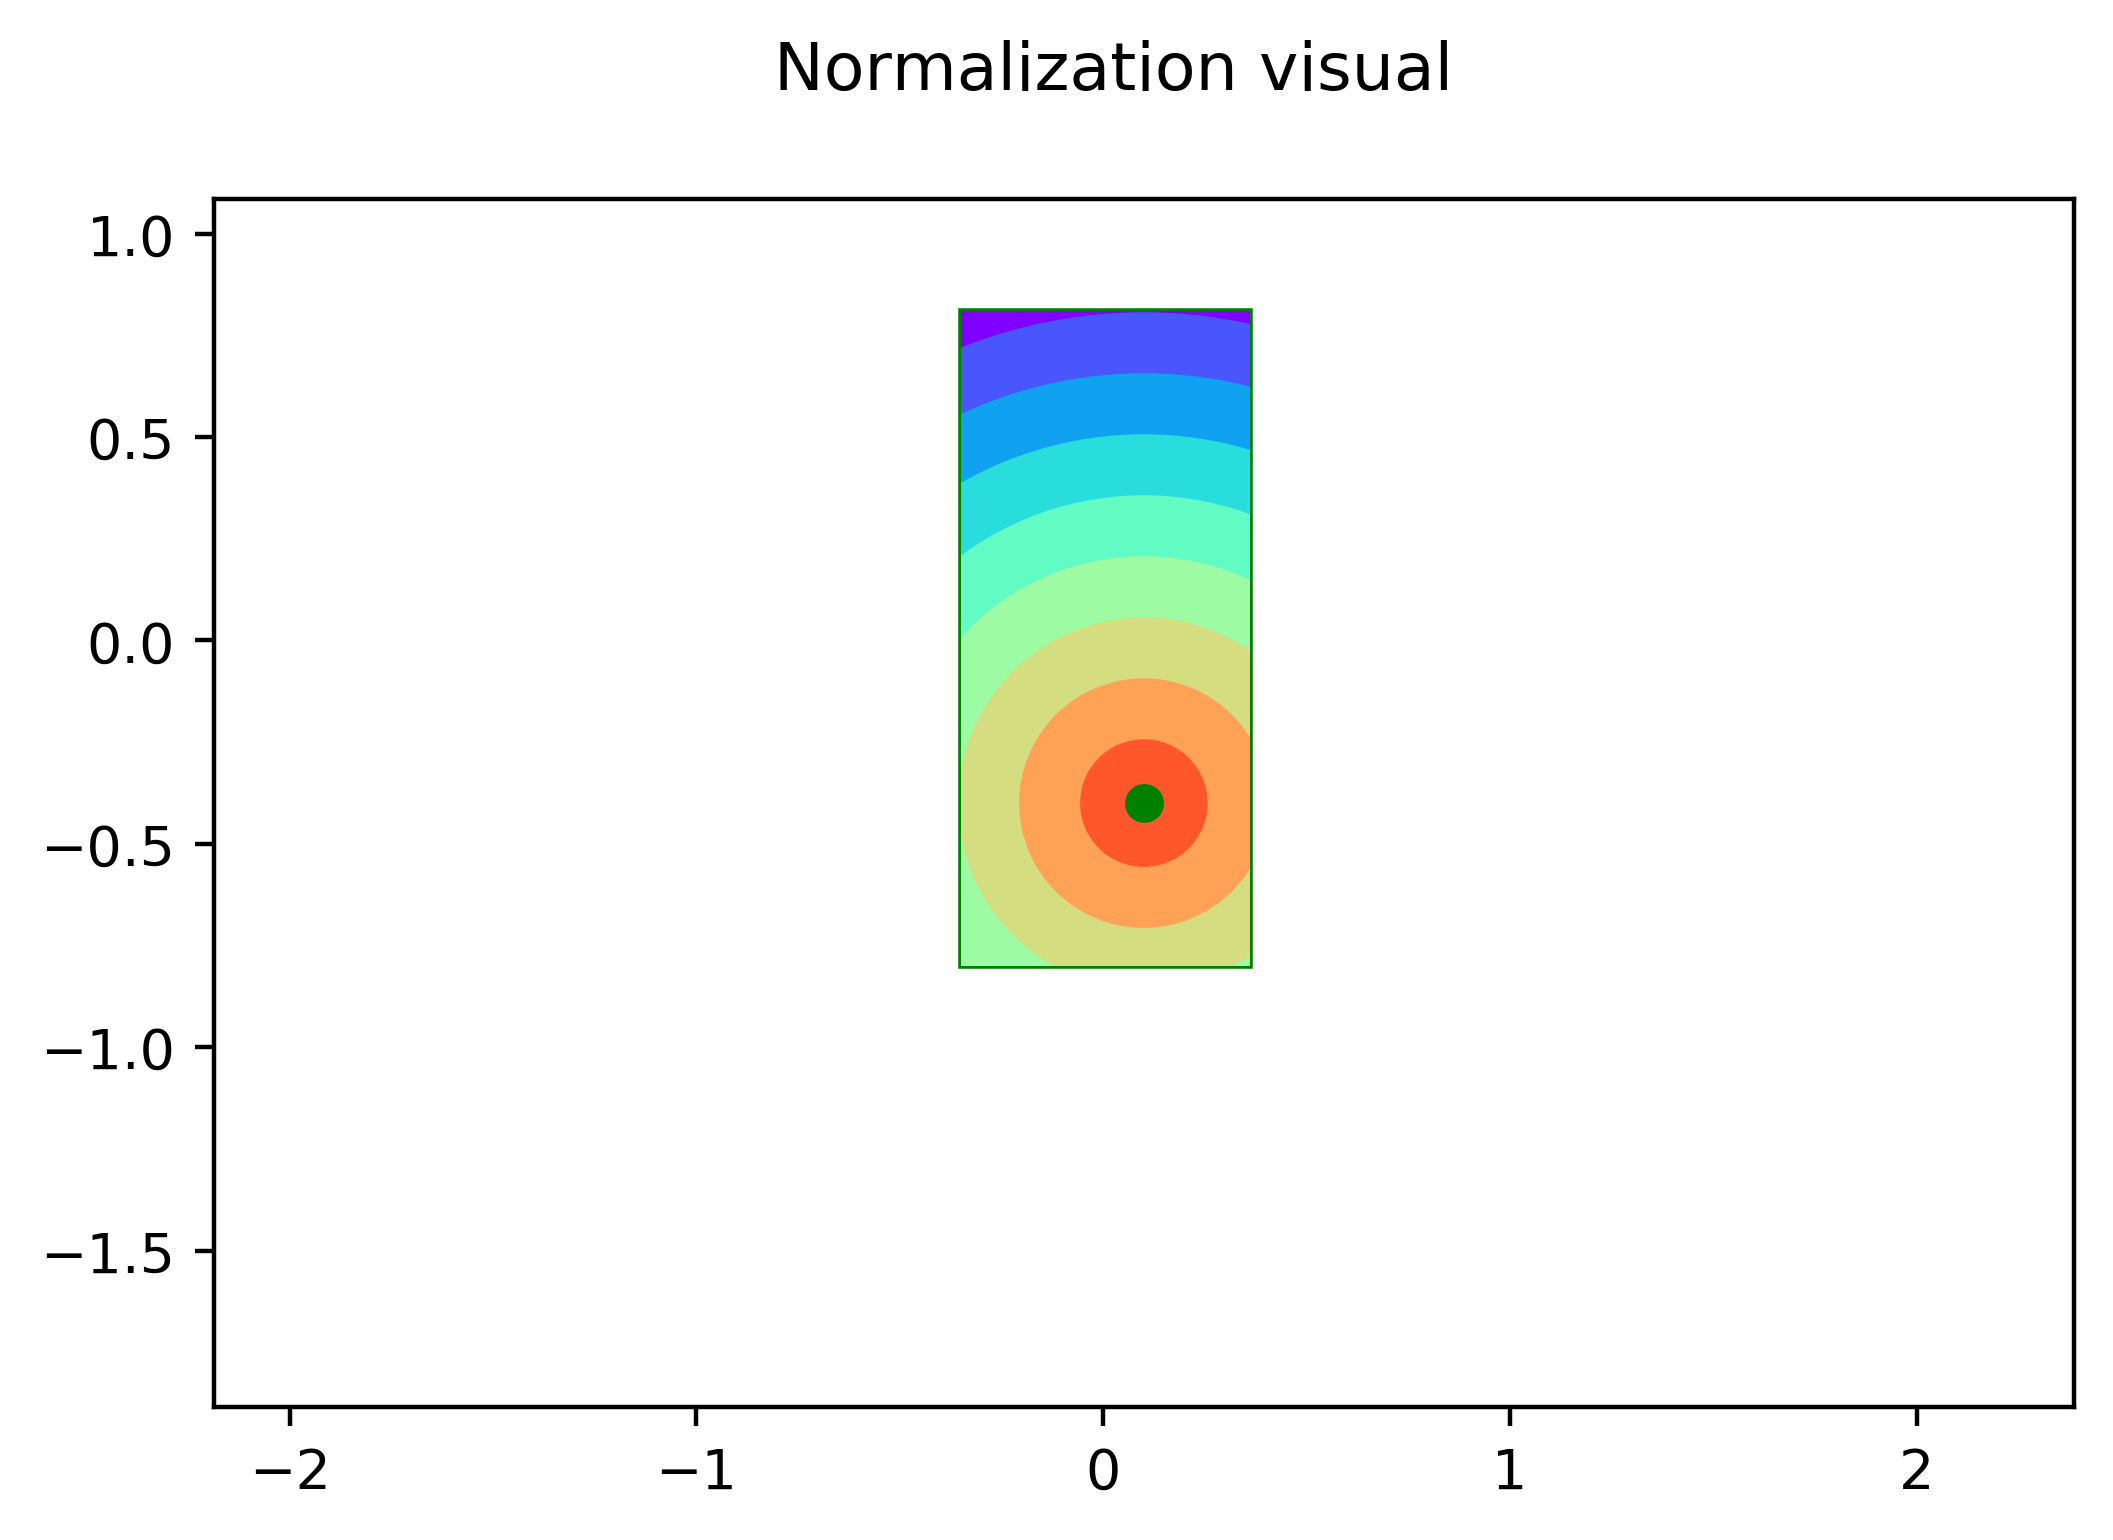

In [3]:

def visualization(center=(.1,-.4),X_cut_min = -.59 -xcut_offset,Y_cut_max = 1.61 + ycut_offset,X_cut_max = .12-xcut_offset,Y_cut_min = .00 +ycut_offset, ):
    """Makes a visual represetation of a banded rectangle with circles in color.
    to be exported and then can be counted 
    
    PARAMS
    ------------
    center : tuple 
        where beacon is 
    dpi : int 
        dots per inch - resolution - if changed can mess up pixel count
    X_cut,Y_cut : int
        points of rectagle, same as used for cutting of rears - floor of arena  
        
    bands : int 
        amount of circles fittign inthe rectangle - max is 23 
        
    Returns
    ------------
    Histogram and appropriate bins made by the histogram

    """
    fig, ax1 = plt.subplots(1, 1, sharex=True,dpi=400,)
    fig.suptitle("Normalization visual")
    ax1.plot(center[0],center[1],"go")
    rectangle = patches.Rectangle((X_cut_min,Y_cut_min), (abs(X_cut_min)+abs(X_cut_max)),abs(Y_cut_min)+abs(Y_cut_max) , color="green")
    ax1.add_patch(rectangle)
    color=iter(plt.cm.rainbow(np.linspace(0,1,10)))
    for i in reversed(range(10)):
        c=next(color)
        patch = patches.Circle((center[0],center[1]), radius=.15*i,color=c)
        ax1.add_patch(patch)
        patch.set_clip_path(rectangle)                  
    ax1.axis("equal") 
    return plt.show()
    
visualization()


In [4]:
k=np.linspace(0,.99,20)
k

array([0.        , 0.05210526, 0.10421053, 0.15631579, 0.20842105,
       0.26052632, 0.31263158, 0.36473684, 0.41684211, 0.46894737,
       0.52105263, 0.57315789, 0.62526316, 0.67736842, 0.72947368,
       0.78157895, 0.83368421, 0.88578947, 0.93789474, 0.99      ])

### Problem is that color can be defined as 0 - 1 value but the range for converted picture osi 0-246  for np.histogram is then 0-1 which makes it fairly inconsistent and results in multiplying small values, especially when not cutting the image and not considerign just 0th value - i.e pure white...  SOLVED = Usign 23 bins which is max in this arena - and igniring the first values of white just by indexing 

### Maximum amount of bands = 22

In [5]:
Y_cut_max/.075

21.46666666666667

### Create a normalized histogram - 1. normalize hist by diving each by the sum, multiply then the hist by norm. - shoudl give normalized results.  Need to make sure to match the bin size of the area by the bin sizes used for histogram cut off.  Can also be made into density calculations by finding out area for each pixel 

In [6]:
52*175
hist,bins

NameError: name 'hist' is not defined

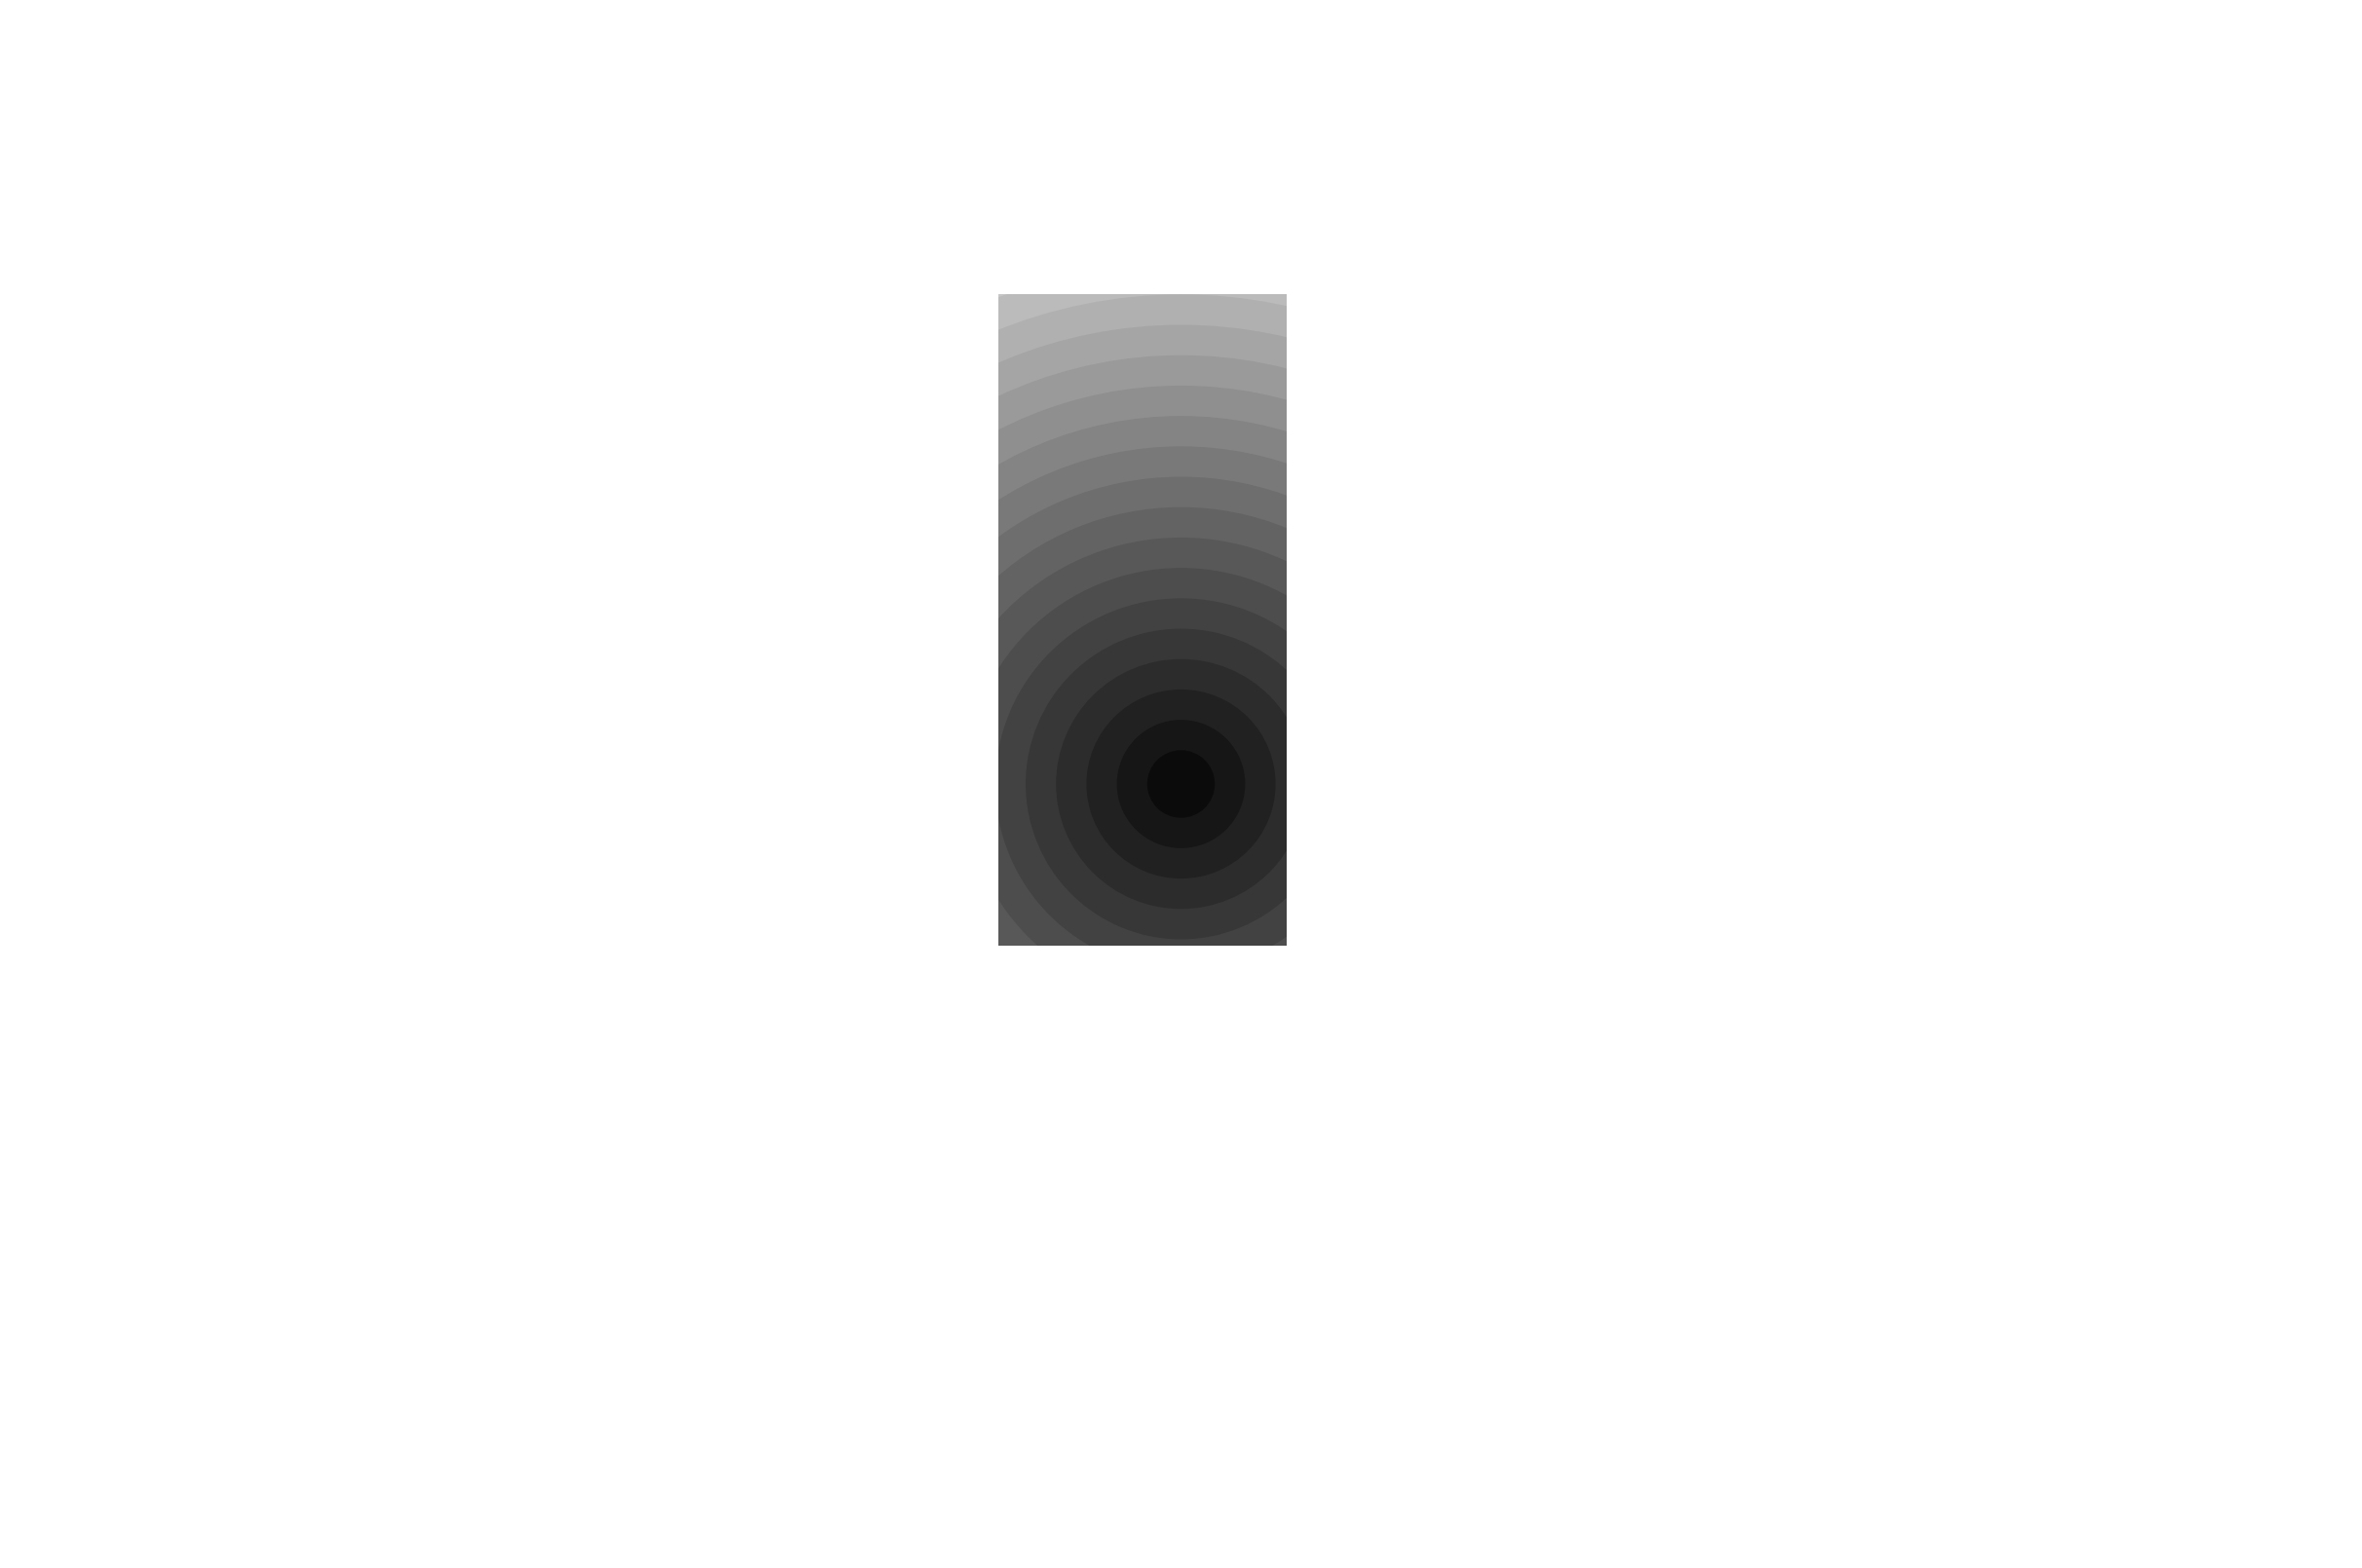

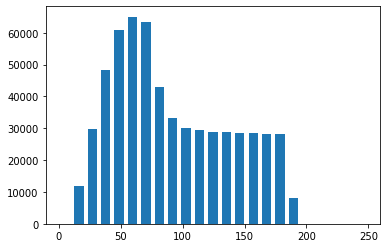

In [7]:
def Normalize (center=(.1,-.4),dpi=500,X_cut_min = -.59 -xcut_offset,Y_cut_max = 1.61
               + ycut_offset,X_cut_max = .12-xcut_offset,Y_cut_min = .00 +ycut_offset,bands=23 ):
    """make visual count it by area then have hist values for normalization wih movement data
        to be exported and then can be counted
    
    PARAMS
    ------------
    center : tuple 
        where beacon is 
    dpi : int 
        dots per inch - resolution - if changed can mess up pixel count
    X_cut,Y_cut : int
        points of rectagle, same as used for cutting of rears - floor of arena  
        
    bands : int 
        amount of circles fittign inthe rectangle - max is 23 
        
    Returns
    ------------
    Histogram and appropriate bins made by the histogram
    Used for area estimation later on

    """
    
    fig, ax1 = plt.subplots(1, 1, sharex=True,dpi=dpi,)
    fig.patch.set_visible(False)
    rectangle = patches.Rectangle((X_cut_min,Y_cut_min), (abs(X_cut_min)+abs(X_cut_max)),abs(Y_cut_min)+abs(Y_cut_max) , color="white")
    ax1.add_patch(rectangle)
    #plt.plot(center[0],center[1], "ro")
    color = np.linspace(0,.99,bands+1)
    for i in reversed(range(bands)):
        c=color[i]
        patch = patches.Circle((center[0],center[1]), radius=.075*i,color=str(c))
        ax1.add_patch(patch)
        patch.set_clip_path(rectangle)                  
    ax1.axis("equal")
    ax1.axis("off")
    fig.savefig(figures + 'norm_graph.png', dpi=dpi, transparent=True)
    img= Image.frombytes('RGB',fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    image_array = np.asarray(img)
    hist, bins = np.histogram(image_array,bins=bands,range=(0,249))
    plt.show()
    #plt.hist(image_array.ravel(), bins=bands, range=(0,249))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    return hist,bins 
    
hist,bins = Normalize()

In [8]:
hist,bins

(array([    0, 11730, 29922, 48279, 60843, 65025, 63423, 42948, 33300,
        29928, 29346, 28920, 28728, 28581, 28470, 28344, 28236,  8013,
           36,     0,     0,     0,     0], dtype=int64),
 array([  0.        ,  10.82608696,  21.65217391,  32.47826087,
         43.30434783,  54.13043478,  64.95652174,  75.7826087 ,
         86.60869565,  97.43478261, 108.26086957, 119.08695652,
        129.91304348, 140.73913043, 151.56521739, 162.39130435,
        173.2173913 , 184.04347826, 194.86956522, 205.69565217,
        216.52173913, 227.34782609, 238.17391304, 249.        ]))

### Calculate area of each pixel - Sanity check  
Here we wanto get back the original size of arena in cm**2
1.Calculate size of arena 
2.Calculate size of circle - in cm**2 
3. How many pixels in first bin/ first circle (11730)
4. divide 175/11730 to get to how many pixels per cm2... in order for it to add up it shoudl be around 52.
5. But it is not. - so The eeror must bein the pixel counting in the normlaize function... 

In [9]:
from math import pi
r = 7.5
r2=15
print ("The area of the circle with radius " + str(r) + "cm is: " + str(pi * r**2))
area = pi * r**2
area2 = pi * r2**2
circle = hist[1]
pix_cm = circle/area
#pix_cm =52
print("Amount of pixels in that circle: %s" %(circle))
print ("There are %s pixels in %s cm**2" %(hist[1],(circle/pix_cm)))
print ("%s pixels per 1 cm**2" %(pix_cm))
print ("The area of the arena is : %s M*2" %((X_cut_max-X_cut_min)*(Y_cut_max-Y_cut_min)))


The area of the circle with radius 7.5cm is: 176.71458676442586
Amount of pixels in that circle: 11730
There are 11730 pixels in 176.71458676442583 cm**2
66.37822159885982 pixels per 1 cm**2
The area of the arena is : 1.1431 M*2


The area of the arena is : 1.1431 M*2


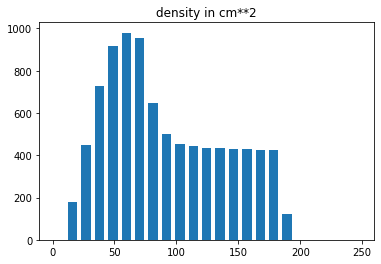

The area of the arena in concetric circles after calculation is : 8949.802897554646 cm*2, but should be 11431.0 cm*2 


1.1431

In [10]:
k= hist/pix_cm # should be more like 52 pixels per cm... in a correct world
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
print ("The area of the arena is : %s M*2" %((X_cut_max-X_cut_min)*(Y_cut_max-Y_cut_min)))
plt.bar(center, k, align='center', width=width)
plt.title("density in cm**2")
plt.show()
difference = ((X_cut_max-X_cut_min)*(Y_cut_max-Y_cut_min)) 
print ("The area of the arena in concetric circles after calculation is : %s cm*2, but should be %s cm*2 " %(k.sum(),difference*10000))

difference

### Until problem solved will count for Pix_cm from rectangle calculation - i.e 52 pixels per cm... which should be the correct number. 

In [11]:

pix_cm=52

## ABOVE - Showing size of each circle. 

### Now take the counts and multiply the distributions correctly - so make a histogram for each time beacon changes 

In [12]:
FS04=pd.read_excel(processed +'FS04_rears_new.xlsx', index_col=0)
FS03=pd.read_excel(processed +'FS03_rears_new.xlsx', index_col=0)
FS08=pd.read_excel(processed +'FS08_rears_new.xlsx', index_col=0)
FS09=pd.read_excel(processed +'FS09_rears_new.xlsx', index_col=0)
FS10=pd.read_excel(processed +'FS10_rears_new.xlsx', index_col=0)
FS11=pd.read_excel(processed +'FS11_rears_new.xlsx', index_col=0)



In [13]:
FS09[0:290]

,Time,RatX,RatY,RatZ,BeaconX,BeaconY,Visibility,time_of_beacon_trigger,Beacon_group,Beacon_subgroup,trial_in_next
0,1.633525e+09,0.366197,-0.625656,0.622052,-0.161819,-0.528795,1,1.633525e+09,1,1,True
1,1.633525e+09,0.294821,-0.721278,0.623699,-0.161819,-0.528795,1,1.633525e+09,1,1,False
2,1.633525e+09,0.281615,0.468654,0.624113,-0.161819,-0.528795,1,1.633525e+09,1,1,False
3,1.633525e+09,0.091569,0.510978,0.621682,-0.161819,-0.528795,1,1.633525e+09,1,1,False
4,1.633525e+09,-0.294043,-0.294124,0.622739,-0.161819,-0.528795,1,1.633525e+09,1,1,False
5,1.633525e+09,-0.214912,-0.750571,0.622589,-0.161819,-0.528795,0,1.633525e+09,1,2,True
6,1.633525e+09,0.247308,-0.763017,0.622407,-0.161819,-0.528795,0,1.633525e+09,1,2,False
7,1.633525e+09,0.307009,0.250492,0.624313,-0.161819,-0.528795,0,1.633525e+09,1,2,False
8,1.633525e+09,-0.164542,0.697908,0.625709,-0.161819,-0.528795,0,1.633525e+09,1,2,False
9,1.633525e+09,0.330363,-0.521257,0.624231,-0.161819,-0.528795,0,1.633525e+09,1,2,False


In [14]:
import datetime
def day_cutter (rears, days=(0,1)):
    """Cuts data frame to day chunks
    
    PARAMS
    ------------
    rears : Data frame
        All rears from all sessions
    days : tuple
        which days to extract from rearing dataframe
    Returns
    ------------
    cut rears by days in tuple 
    
    """
    time_stamp_old = rears['Time'][0]
    day = 0 
    index_list=[]
    index_list.append(0)
    for index,row in rears.iterrows():
        time_stamp=(row['Time'])
        if time_stamp-time_stamp_old>10000: # larger then 3 hours 
            index_list.append(index)  
            day+=1
        time_stamp_old = time_stamp 

    return rears[index_list[days[0]]:index_list[days[1]]]
FS09_0_1= day_cutter(FS09,days=(0,1))
FS09_1_2= day_cutter(FS09,days=(1,2))
FS09_1_2.reset_index()
#print(FS09_1_2)
my_time=datetime.datetime.fromtimestamp(FS09_0_1['Time'].iloc[153]).strftime('%c')
print(my_time)
#here need ot use Iloc unless reindexed... 
my_time=datetime.datetime.fromtimestamp(FS09_1_2['Time'].iloc[0]).strftime('%c')
print(my_time)
print(FS09_1_2.iloc[0])

Wed Oct  6 15:26:30 2021
Thu Oct  7 15:51:03 2021
Time                      1.63361e+09
RatX                          -0.1099
RatY                         0.750409
RatZ                         0.805627
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.63361e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
Name: 154, dtype: object


In [15]:
FS09_0_6= day_cutter(FS09,days=(0,6))
FS09_7_14= day_cutter(FS09,days=(7,14))
FS09_15_21= day_cutter(FS09,days=(15,21))
FS10_0_6= day_cutter(FS10,days=(0,6))
FS10_7_14= day_cutter(FS10,days=(7,14))
FS10_15_21= day_cutter(FS10,days=(15,21))
FS08_0_6= day_cutter(FS08,days=(0,6))
FS08_7_14= day_cutter(FS08,days=(7,14))
FS08_15_21= day_cutter(FS08,days=(15,21))
FS11_0_6= day_cutter(FS11,days=(0,6))
FS11_7_14= day_cutter(FS11,days=(7,14))
FS11_15_21= day_cutter(FS11,days=(15,21))
dayz = [FS09_0_6,FS09_7_14,FS09_15_21,FS10_0_6,FS10_7_14,FS10_15_21,FS08_0_6,FS08_7_14,FS08_15_21,FS11_0_6,FS11_7_14,FS11_15_21]
day_names = days = ['FS09_0_6','FS09_7_14','FS09_15_21','FS10_0_6','FS10_7_14','FS10_15_21','FS08_0_6','FS08_7_14','FS08_15_21','FS11_0_6','FS11_7_14','FS11_15_21']

In [16]:
print(len(FS11_7_14['Visibility']))
print(sum(FS11_7_14['Visibility']))
my_time=datetime.datetime.fromtimestamp(FS11_0_6['Time'].iloc[0]).strftime('%c')
print(my_time)

1059
534
Wed Oct  6 16:16:52 2021


### todo: 
    Run on first 100 rears and second thousand rears - split datsets - also look into size and how many incvisible first - generate NPY of all 

## Test dataset 

In [17]:
FS04_test=FS04[:1000]
print(FS04_test)

             Time      RatX      RatY      RatZ   BeaconX   BeaconY  \
0    1.613728e+09 -0.189118 -0.542030  0.621123 -0.161819 -0.528795   
1    1.613729e+09  0.283818  0.797506  0.620336 -0.161819 -0.528795   
2    1.613729e+09 -0.206200 -0.563636  0.625777 -0.161819 -0.528795   
3    1.613729e+09 -0.234257 -0.516903  0.625419 -0.161819 -0.528795   
4    1.613729e+09 -0.359741  0.166368  0.624256 -0.161819 -0.528795   
5    1.613729e+09 -0.219940 -0.517029  0.623251 -0.161819 -0.528795   
6    1.613729e+09 -0.230839 -0.557631  0.623098 -0.161819 -0.528795   
7    1.613729e+09 -0.253960 -0.667017  0.623301 -0.161819 -0.528795   
8    1.613729e+09 -0.086789 -0.797742  0.621373 -0.161819 -0.528795   
9    1.613729e+09  0.248185 -0.770949  0.620643 -0.161819 -0.528795   
10   1.613729e+09 -0.105810 -0.729152  0.620557 -0.161819 -0.528795   
11   1.613729e+09 -0.205677 -0.522411  0.627581 -0.161819 -0.528795   
12   1.613729e+09 -0.189278 -0.557623  0.621459 -0.161819 -0.528795   
13   1

[1000 rows x 11 columns]


## Mutiply and add to pandas...  find where the first non-zero value is and then cut the lenght of the array same to the lenght of the rearing array - then rears array /np.norm(norm), will also need to cut the small division by zero 

Also try to look how the overall normalization histograam woudl look like by addign all the values together. 

## TODO: Need to account for small numbers, beacuse if they divide it by 0 then it is way too large Now calculating rears per cm**2...

### Is the first getting accounted for?  also need to do hist/pix_cm to get cm**2 value for density

### TODO - Maybe better to split this function to make a simples easier to understand one... 

In [18]:
%%capture
binwidth=.075
def Multiplication_simple_stack(rears,visible=True ):
    """function involves computing and adding up an overall
    representations of bands as well as an overall and added represenation for beacon distance.
         
    
    PARAMS
    ------------
    rears : Dataframe 
        for each rear  
    visible : boolean 
        if true count only rears when beacon was visible
        
    Returns
    ------------
    final_test normalized occupancy 
    normal_final normalization histogram 
    dist_final rearign occupancy no normalized 
    stack
    Histogram and appropriate bins made by the histogram
    Used for area estimation later on
    """
    if visible == True:
        visibility=1
    elif visible == False: 
        visibility=0 
    else: 
        visibility= 0 or 1 

    normalized_hist=[]
    arr= np.zeros(23)
    final= np.zeros(23)
    stack=np.zeros(23)
    normal_final= np.zeros(23)
    dist_final= np.zeros(23)
    change=0
    bad=0
    dist=[]
    rears[13] = rears["BeaconX"].shift() != rears["BeaconX"]
    #Go through each row 
    for index,row in rears.iterrows():
        if row["Visibility"]== visibility :
            
            center = (row["BeaconX"],row["BeaconY"])
            dist.append(math.sqrt((row["RatX"] - row["BeaconX"])**2 + (row["RatY"] - row["BeaconY"])**2))
            #if switch of location of beacon 
        if row[13]==True:
            change += 1
            print(change)
            
            #count and create normalization histogram for given location
            hist,bins = Normalize(center = (row["BeaconX"],row["BeaconY"]))
            plt.show()
            print(min(hist[np.nonzero(hist)]))
            #to get rid of division by small numbers - any area lower then 15 cm will be assumed to be 0 1000piselx = 15 cm**2
            hist[hist<1000]=0
            print(min(hist[np.nonzero(hist)]))
            out_arr = np.nonzero(hist)
            size = len(hist[out_arr])
            print(hist[out_arr])
            #normalize each number to pixel value 
            multi = hist[out_arr]/pix_cm 
            #print(multi)
            #print(size)
            
            #strip extra numbers and pad with zero's to have always 23 lenght - for not individually divided HIST
            multi_norm=np.pad(np.asarray(multi),(0,23-len(np.asarray(multi))),'constant')
            normal_final=np.add(normal_final,multi_norm) 
            
            #for plottign the size histogram 
            bins = np.arange(0, 1.725 + binwidth, binwidth)
            hist, bins = np.histogram(dist,bins = bins)
#             width = 0.7 * (bins[1] - bins[0])
#             center = (bins[:-1] + bins[1:]) / 2
#             plt.bar(center[1::], hist[1:], align='center', width=width)
#             plt.show()
            
            #strip extra numbers and pad with zero's to have always 23 lenght - for not individually divided DIST
            multi_dist=np.pad(np.asarray(hist),(0,23-len(np.asarray(hist))),'constant')
            dist_final=np.add(dist_final,multi_dist) 
            
            #Finally divide rears by area (always defined by size as no division by zero should appear)
            normalized_hist=(hist[0:size]/(multi))
            normalized_hist=np.pad(normalized_hist,(0,23-len(normalized_hist)),'constant')
            #tried to have an approtipate size to not cut too many, but also to avoid multiplication by small numbers.
            #could also go through the numbersd and if very small just cut it... 
            if any([x > .1 for x in normalized_hist]): 
                #print(normalized_hist[19])
                print("bad")
                print(change)
                bad+=1
                dist=[]
                continue
            final = np.add(final,normalized_hist*pix_cm) 
            stack = np.vstack((stack,normalized_hist*pix_cm))
            dist=[]
    print("cut %s small division sessions" %(bad) )
    return np.array(final)/(change-bad),normal_final/change,dist_final,stack
            
final_test,normal_final,dist_final,stack = Multiplication_simple_stack(FS04_test,visible=True)

### TO run on seperate days and make npy for graphing 

In [19]:
%%capture
animal_day=0
for day in dayz: 
    print (day.head(5))
    my_time=datetime.datetime.fromtimestamp(day['Time'].iloc[0]).strftime('%c')
    print(my_time)
    print(day_names[animal_day])
    final_test,normal_final,dist_final,stack = Multiplication_simple_stack(day,visible="all")
    np.save(processed +'%s_all_hist'%(day_names[animal_day]), dist_final)
    final_test,normal_final,dist_final,stack = Multiplication_simple_stack(day,visible=True)
    np.save(processed +'%s_visible_hist'%(day_names[animal_day]), dist_final)
    final_test,normal_final,dist_final,stack = Multiplication_simple_stack(day,visible=False)
    np.save(processed +'%s_invisible_hist'%(day_names[animal_day]), dist_final)
    animal_day+=1
    print("BLOCK PROCESSED")

### Proof of principle 

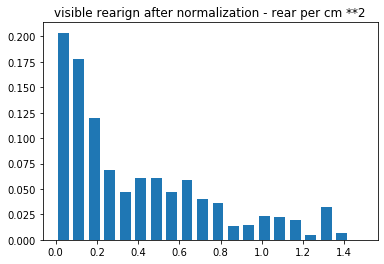

In [20]:
animal_ID="FS04"
bins = np.arange(0, 1.5 + binwidth, binwidth)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.title("visible rearign after normalization - rear per cm **2")
plt.bar(center[0:20],final_test[0:20],align='center', width=width)
plt.show()

In [21]:
final_test,normal_final,dist_final = Multiplication_simple(FS04,visible="all")
np.save(processed +'FS04_Normalized_all_hist', final_test)


NameError: name 'Multiplication_simple' is not defined

In [ ]:
np.set_printoptions(suppress=True)
print(final_test)
print(any([x > 100 for x in final_test[15:20]]))
print(dist_final) # rears away 
print(normal_final) # to normalize it by, but first woudl need to divide by amount of bands added - Change - bad... 

## How to now make sure that I am achieving a significance level if I am not taking individual examples. 

In [ ]:
stack[2]

### Count how many would be significant 

In [ ]:
count =0
below=0
beacons = stack[:,0]
#print (beacon)
for beacon in beacons:
    if beacon>2:
        count+=1
    else:
        below +=1
print(count,below)

### Code to normalize histograms. Current problem I cannot normalize individual histograms to be able to show significance ... as they are quite strange numbers. but I woudl need to individuall normalize them to prove significance - unless I have a common division for the first bar for which to then divide everything. 

In [ ]:
norm = hist
print("sum %s" %int(sum(hist)))
print("max %s" %max(hist))
print(hist)
norm = norm[1::]
norm[:] = [max(norm) - number for number in norm]
print(norm)
print("hello%s" %int(sum(norm)))
#norm[:] = [number/int(sum(norm)) for number in norm]
print(norm)
multi=[]
for count in norm: 
    k= count/int(sum(norm))
    multi.append(k)
len(norm),len(bins)

#norm[:] = [number - 1 for number in norm]
print(multi)
print(sum(multi))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
print(center)

#plt.bar(center[1::], multi, align='center', width=width)

### Had the accumulated average - so I had to divide by amount of trials added first 

In [ ]:
9075.8/141.35 #pixels per rear. 

In [ ]:
9075/pix_cm

In [ ]:
21748/256

### TODO: How many should I try to cut? What should the threshold be for density of rears. also how to properlty assign density of rears..? 

In [ ]:
animal_ID="FS04"
bins = np.arange(0, 1.5 + binwidth, binwidth)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.title("rearign before normalization_invisible")
plt.bar(center[0:20],dist_final[0:20],align='center', width=width)
plt.show()
plt.title("overall added normalized density bands")
plt.bar(center[0:20],normal_final[0:20],align='center', width=width)
plt.show()
plt.title("rearign after normalization - rear per cm **2")
plt.bar(center[0:20],final_test[0:20],align='center', width=width)
plt.show()
plt.savefig('%srat_rearing_distance_normalized_FS04_INVIS%s.png'%(figures,animal_ID), dpi = 100)

### the last graph is likley not rears per cm**2 as the numbers dont add up if there were 400 rears in 176 cm**2 then it should be around 400/176...  maybe smohow divide and multiply twice by Pix_CM> - need to write a simples function for normalization. 

### NEXT STEP - NORMALIZATION- shuffle different locations... 

In [ ]:

alpha = (5) * np.pi / 180
zn = (Y_cut_min+circle/2) + (np.random.random() * ((Y_cut_max-circle/2) - (Y_cut_min+circle/2)))
xn = (X_cut_min+circle/2) + (np.random.random() * ((X_cut_max-circle/2) - (X_cut_min+circle/2)))
x = xn * np.cos(np.pi * alpha / 180.) - zn * np.sin(np.pi * alpha / 180.)
z = xn * np.sin(np.pi * alpha / 180.) + zn * np.cos(np.pi * alpha / 180.)

In [ ]:
X_cut_min = -.59 -xcut_offset
Y_cut_max = 1.61 + ycut_offset
X_cut_max = .12-xcut_offset
Y_cut_min = .00 +ycut_offset

In [ ]:
binwidth=.075
def Multiplication_simple_shuffle(rears,visible=True,boot_reps=20 ):
    """perform previous function using real data but fictional positions generated by random.random"""
    final2= np.zeros(23)
    for i in tqdm(range (boot_reps)):
        circle=.075
        if visible == True:
            visibility=1
        elif visible == False: 
            visibility=0 
        else: 
            visibility= 0 or 1 

        normalized_hist=[]
        arr= np.zeros(23)
        final= np.zeros(23)
        normal_final= np.zeros(23)
        dist_final= np.zeros(23)
        change=0
        bad=0
        dist=[]
        rears[13] = rears["BeaconX"].shift() != rears["BeaconX"]
        zn = (Y_cut_min+circle/2) + (np.random.random() * ((Y_cut_max-circle/2) - (Y_cut_min+circle/2)))
        xn = (X_cut_min+circle/2) + (np.random.random() * ((X_cut_max-circle/2) - (X_cut_min+circle/2)))
        x = xn * np.cos(np.pi * alpha / 180.) - zn * np.sin(np.pi * alpha / 180.)
        z = xn * np.sin(np.pi * alpha / 180.) + zn * np.cos(np.pi * alpha / 180.)
        
        #Go through each row 
        for index,row in rears.iterrows():
            
            if row["Visibility"]== visibility :
                dist.append(math.sqrt((row["RatX"] - x)**2 + (row["RatY"] - z)**2))
                #if switch of location of beacon 
            if row[13]==True:
                change += 1
                print(change)
                zn = (Y_cut_min+circle/2) + (np.random.random() * ((Y_cut_max-circle/2) - (Y_cut_min+circle/2)))
                xn = (X_cut_min+circle/2) + (np.random.random() * ((X_cut_max-circle/2) - (X_cut_min+circle/2)))
                x = xn * np.cos(np.pi * alpha / 180.) - zn * np.sin(np.pi * alpha / 180.)
                z = xn * np.sin(np.pi * alpha / 180.) + zn * np.cos(np.pi * alpha / 180.)
                #count and create normalization histogram for given location
                hist,bins = Normalize(center = (x,z))
                plt.show()
                print(min(hist[np.nonzero(hist)]))
                #to get rid of division by small numbers - any area lower then 15 cm will be assumed to be 0 1000piselx = 15 cm**2
                hist[hist<1000]=0
                print(min(hist[np.nonzero(hist)]))
                out_arr = np.nonzero(hist)
                size = len(hist[out_arr])
                print(hist[out_arr])
                #normalize each number to pixel value 
                multi = hist[out_arr]/pix_cm 
                #print(multi)
                #print(size)

                #strip extra numbers and pad with zero's to have always 23 lenght - for not individually divided HIST
                multi_norm=np.pad(np.asarray(multi),(0,23-len(np.asarray(multi))),'constant')
                normal_final=np.add(normal_final,multi_norm) 

                #for plottign the size histogram 
                bins = np.arange(0, 1.725 + binwidth, binwidth)
                hist, bins = np.histogram(dist,bins = bins)
    #             width = 0.7 * (bins[1] - bins[0])
    #             center = (bins[:-1] + bins[1:]) / 2
    #             plt.bar(center[1::], hist[1:], align='center', width=width)
    #             plt.show()

                #strip extra numbers and pad with zero's to have always 23 lenght - for not individually divided DIST
                multi_dist=np.pad(np.asarray(hist),(0,23-len(np.asarray(hist))),'constant')
                dist_final=np.add(dist_final,multi_dist) 

                #Finally divide rears by area (always defined by size as no division by zero should appear)
                normalized_hist=(hist[0:size]/(multi))
                normalized_hist=np.pad(normalized_hist,(0,23-len(normalized_hist)),'constant')
                #tried to have an approtipate size to not cut too many, but also to avoid multiplication by small numbers.
                #could also go through the numbersd and if very small just cut it... 
                if any([x > .1 for x in normalized_hist]): 
                    #print(normalized_hist[19])
                    print("bad")
                    print(change)
                    bad+=1
                    dist=[]
                    continue
                
                
                final = np.add(final,normalized_hist*pix_cm) 
                print(final)
                dist=[]
        
        final1 = np.array(final)/(change-bad)
        print(final1)
        print("cut %s small division sessions" %(bad) )
        final2=np.add(final2,final1)
        print(final2)
        
    return final2,
            
final_boot_test = Multiplication_simple_shuffle(FS04,visible=all)
np.save(processed +'%s_shuffle_100000_rears_all_hist', final_boot_test[0])

In [ ]:
#final_boot_test[0]
#np.save(processed +'FS04_shuffle_100000_rears_all_hist', final_boot_test[0])
final_boot_test = np.load(processed +'FS04_shuffle_100000_rears_all_hist.npy')

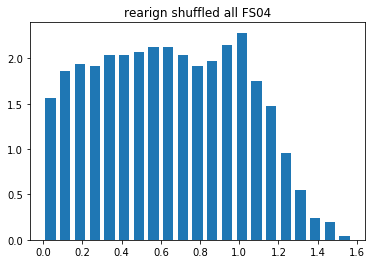

In [96]:
animal_ID="FS04"
bins = np.arange(0, 1.725 + binwidth, binwidth)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.title("rearign shuffled all FS04")
plt.bar(center[0:21],final_boot_test[0:21],align='center', width=width)
plt.show()

In [97]:
#final_boot_test03 = Multiplication_simple_bootstrapped(FS03,visible=all)
#np.save(processed +'FS03_shuffle_100000_rears_all_hist', final_boot_test03[0])
final_boot_test03 = np.load(processed +'FS03_shuffle_100000_rears_all_hist.npy')

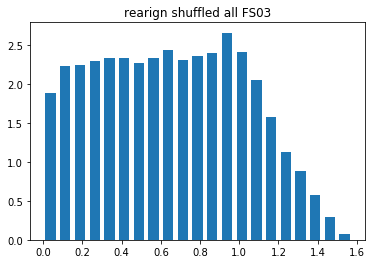

In [98]:
animal_ID="FS03"
bins = np.arange(0, 1.725 + binwidth, binwidth)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.title("rearign shuffled all FS03")
plt.bar(center[0:21],final_boot_test03[0:21],align='center', width=width)
plt.show()

In [99]:
import numpy as np
from scipy.stats import ks_2samp

x = np.random.normal(0,1,1000)
y = np.random.normal(0,1,1000)

ks_2samp(x, y)


Ks_2sampResult(statistic=0.046999999999999986, pvalue=0.21398843459234218)

### SANITY CHECK - Use the overall histogram with space and divide by the over all rears - NOT INDIVIDUAL 

In [ ]:
post_normalized_hist=(dist_final[0:20]/normal_final[0:20])
print (post_normalized_hist)

bins = np.arange(0, 1.5 + binwidth, binwidth)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center[0:20],post_normalized_hist[0:20],align='center', width=width)
plt.show()

plt.bar(center[0:20],normal_final[0:20],align='center', width=width)



In [ ]:

def get_rear_distance_from_beacon(rears):
    dist=[]
    for index,row in rears.iterrows():
        #center = (row["BeaconX"],row["BeaconY"])
        dist.append(math.sqrt((row["RatX"] - row["BeaconX"])**2 + (row["RatY"] - row["BeaconY"])**2))
    return dist 
plt.hist(get_rear_distance_from_beacon(FS04),bins=bins)

### Graveyard

In [ ]:
vis_area_hist_norm= final_test_vis
invis_area_norm = final_test_ivis

#print(len(area_hist_norm))
def make_simple_graphs (animal_ID,rearing,vis=final_test_vis,invis=final_test_invis):
    binwidth=.075
    plt.tight_layout
    bins = np.arange(0, 1.575, binwidth)
    interval=bins
    print(bins)
    bins[1]= 0.075
    fig, ax = plt.subplots(4,sharex=False,figsize=(8, 14),gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(animal_ID +' rearing distance from beacons ephys',y=1)

    N, bins, patches=ax[0].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==1]),bins=bins,ec='w')
    
#     print(len(norm))
#     print(len(bins))
#     print(N*norm)
    
    ax[0].set_title('Visible attempt')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
        
    N1, bins, patches=ax[1].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]),bins=bins,ec='w')
    #print(N1*norm)
    ax[1].set_title('Invisible attempt')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)

   # print(area_hist_norm)

    bins = np.arange(0, 1.725 + binwidth, binwidth)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    print(bins,center)
    N1, bins, patches = ax[2].bar(center, vis, align='center', width=width)
    ax[2].set_title('Visible attempt Normalized')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    
    number, bins, patches= ax[3].bar(center, invis, align='center', width=width)
    ax[3].set_title('invisible attempt Normalized')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    
    
    
        
    plt.savefig('%srat_rearing_distance_from_beacons_normalized%s.png'%(figures,animal_ID), dpi = 100)

    
    
make_simple_graphs('FS03' ,FS04) 


In [ ]:

###OLD
binwidth=.075
def invisible_Multiplication(rears):
    normalized_hist=[]
    arr= np.zeros(23)
    final= np.zeros(23)
    normal_final= np.zeros(23)
    dist_final= np.zeros(23)
    change=0
    dist=[]
    rears[13] = rears["BeaconX"].shift() != rears["BeaconX"]
    for index,row in rears.iterrows():
        if row["Visibility"]==1:
            center = (row["BeaconX"],row["BeaconY"])
            dist.append(math.sqrt((row["RatX"] - row["BeaconX"])**2 + (row["RatY"] - row["BeaconY"])**2))
            #print(row)
        if row[13]==True:
            change += 1
            print(change)
            hist,bins = Normalize(center = (row["BeaconX"],row["BeaconY"]))
            print(len(hist))
            print(hist)
            out_arr = np.nonzero(hist)
            size = len(hist[out_arr])
            print(hist[out_arr])
            multi=[]
            for count in hist[out_arr]: 
                k= count/int(sum(hist[out_arr]))
                multi.append(k)
            print(multi)
            print(size)
            multi_norm=np.pad(np.asarray(multi),(0,23-len(np.asarray(multi))),'constant')
            normal_final=np.add(normal_final,multi_norm) 
            
            bins = np.arange(0, 1.725 + binwidth, binwidth)
            #bins[1]= 0.075
            hist, bins = np.histogram(dist,bins = bins)
            print(len(hist))
            print(hist[0:size])
            print(len(hist[0:size]))
            
            width = 0.7 * (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2
            plt.bar(center[1::], hist[1:], align='center', width=width)
            plt.show()
            
            multi_dist=np.pad(np.asarray(hist),(0,23-len(np.asarray(hist))),'constant')
            dist_final=np.add(dist_final,multi_dist) 
            
            
            normalized_hist=(hist[0:size]/(multi))
            print(normalized_hist)
            print(len(normalized_hist))
            normalized_hist=np.pad(normalized_hist,(0,23-len(normalized_hist)),'constant')
            print(normalized_hist)
            print(len(normalized_hist))
            if normalized_hist[19]>1000: 
                print(normalized_hist[19])
                print("bad")
                print(change)
                continue
            final = np.add(final,normalized_hist) 
            
            dist=[]
    return np.array(final),normal_final,dist_final
            
inv_final_test,inv_normal_final,inv_dist_final = invisible_Multiplication(FS04)

In [ ]:
np.asarray()
plt.imshow(image_array)
plt.colorbar()
plt.show()
np.histogram(image_array)
hist, bins = np.histogram(image_array,bins=19,range=(0,249))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
hist,bins/19

In [ ]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

### Previous multiplication function 

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1


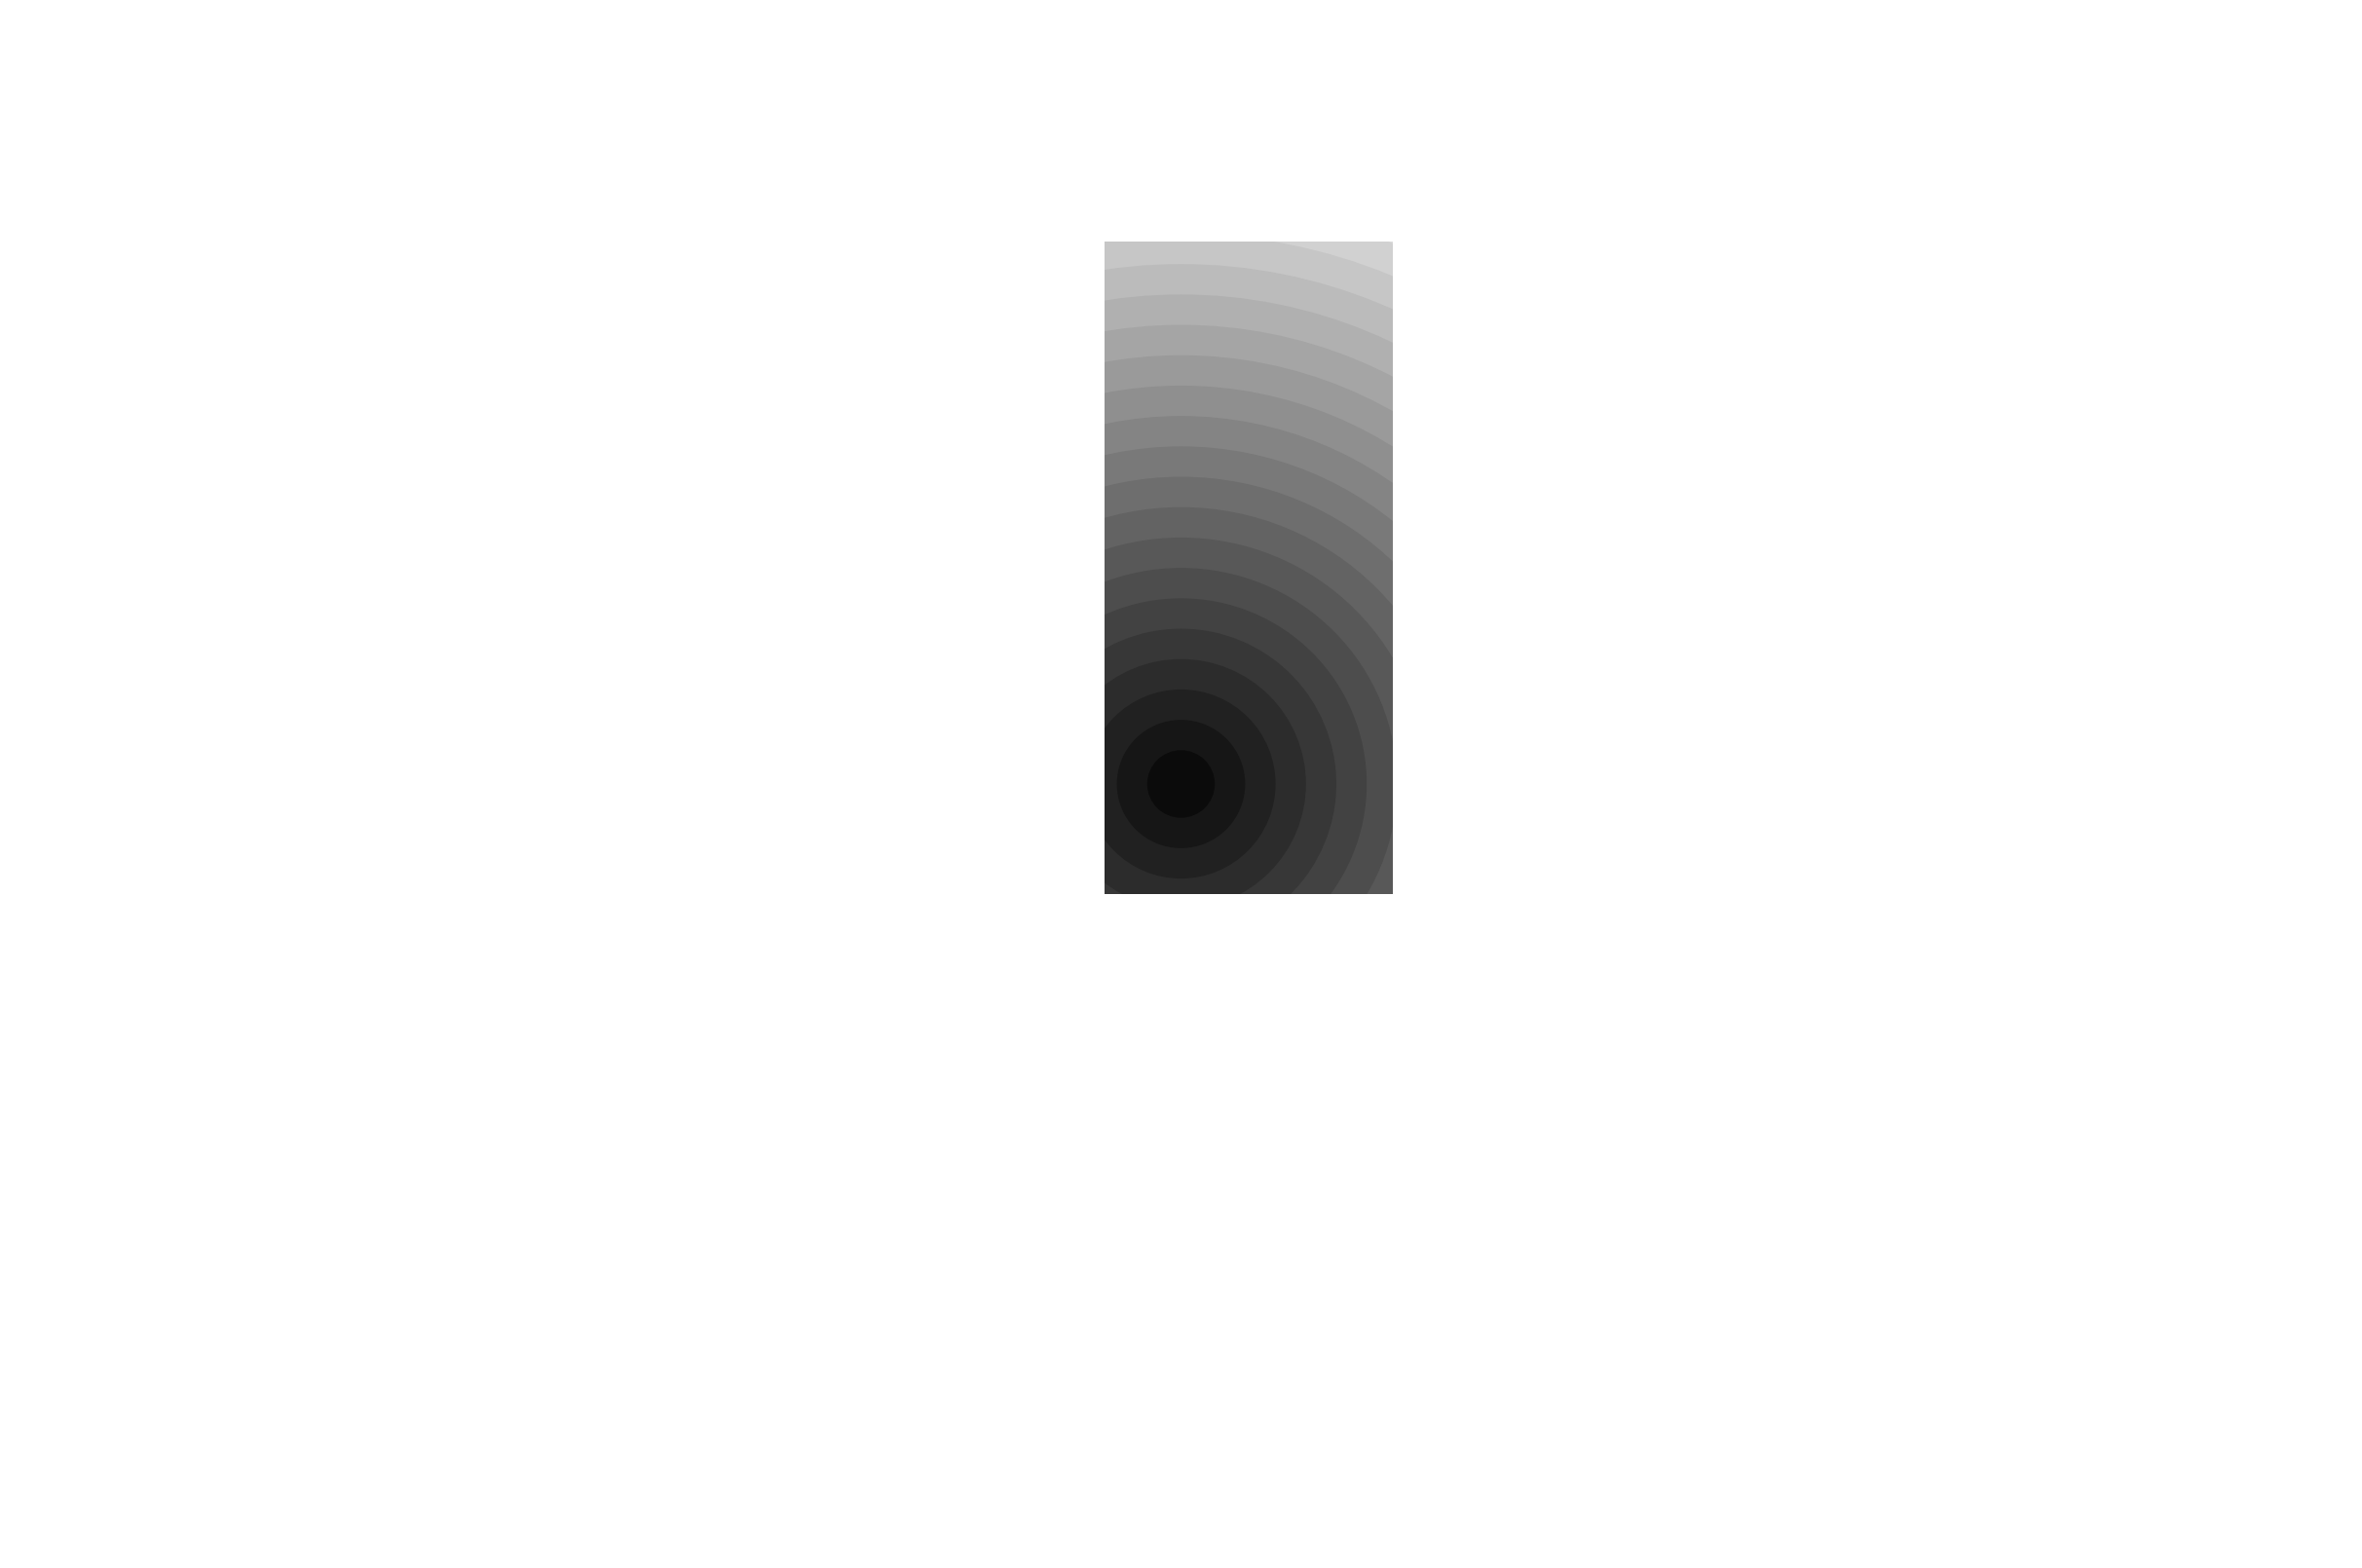

(-0.161819261454925, -0.5287954870929873)
Time                      1.61373e+09
RatX                        -0.189118
RatY                         -0.54203
RatZ                         0.621123
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.61373e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 0, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e+0

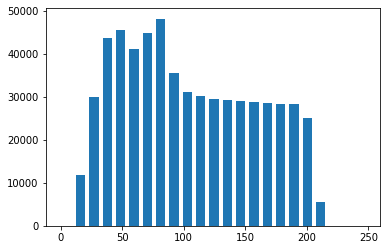

[0.00443308 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.00443308 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
2


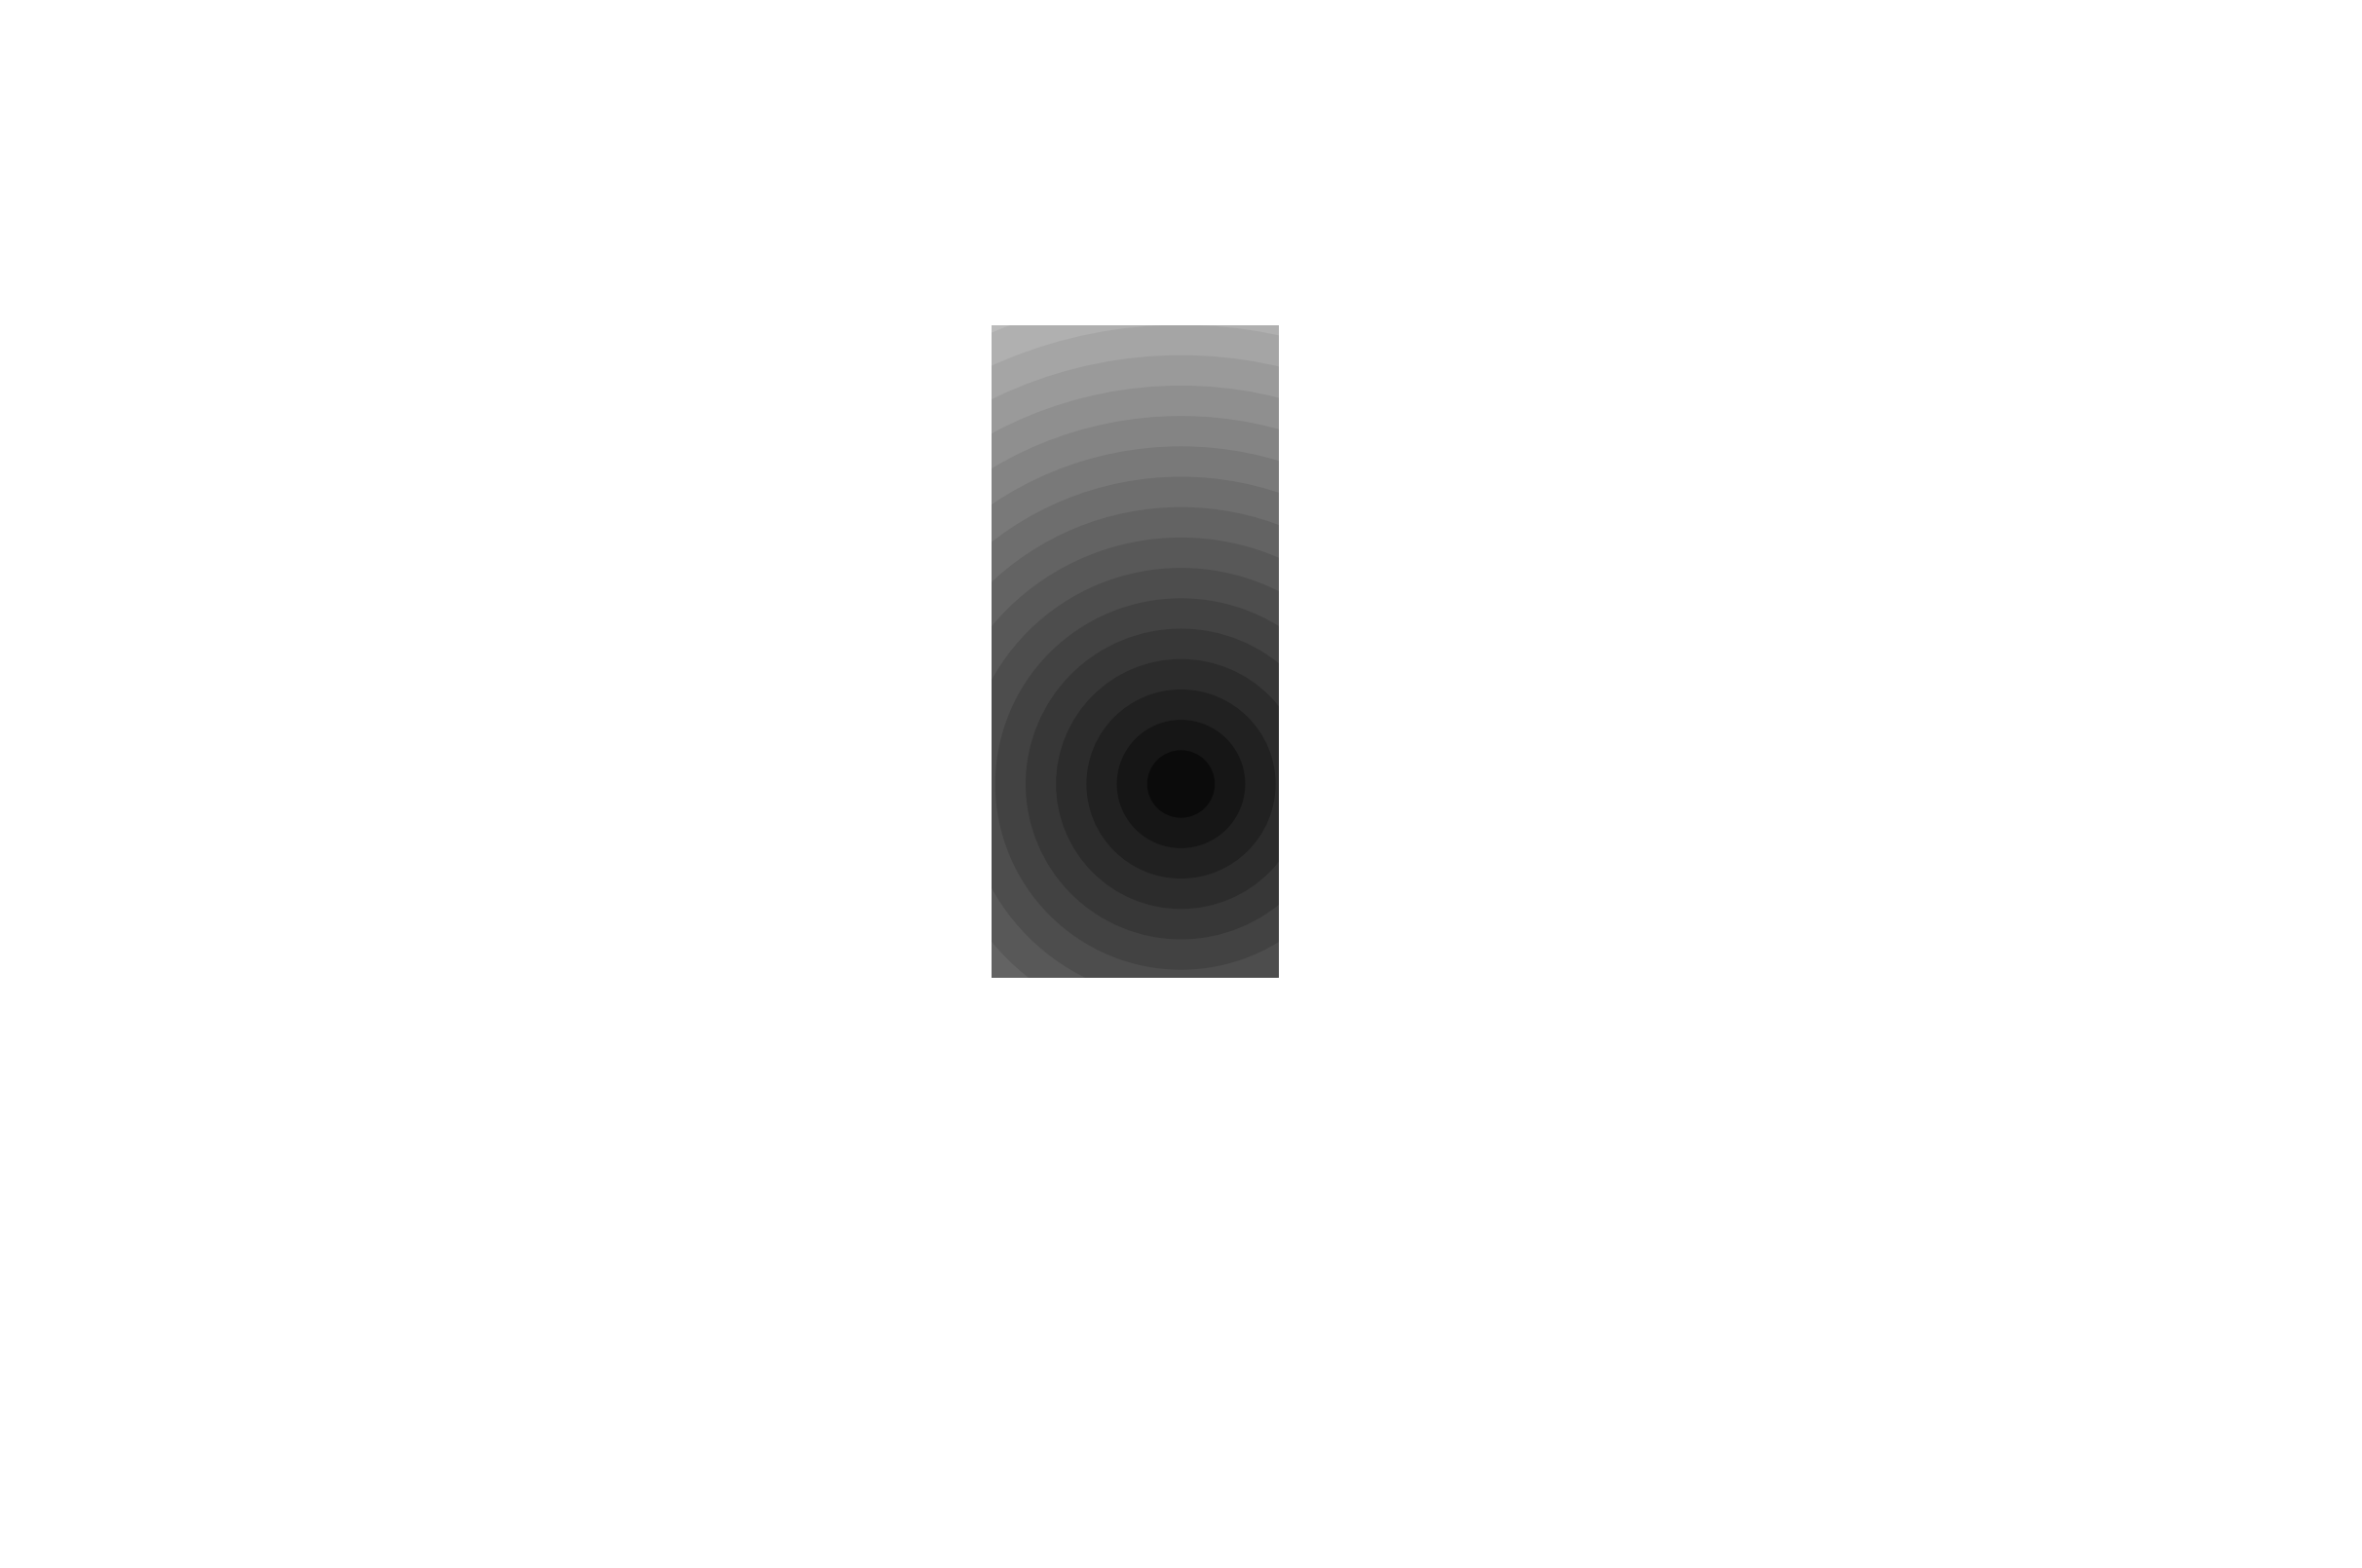

(0.1184419304241933, -0.3216119689849157)
Time                      1.61373e+09
RatX                        0.0218823
RatY                        -0.322488
RatZ                         0.621347
BeaconX                      0.118442
BeaconY                     -0.321612
Visibility                          1
time_of_beacon_trigger    1.61373e+09
Beacon_group                        2
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 29, dtype: object
23
[    0 11730 29922 48279 57225 62835 71688 58968 39567 31968 29400 28932
 28716 28551 28428 28209  8337   195     0     0     0     0     0]
[11730 29922 48279 57225 62835 71688 58968 39567 31968 29400 28932 28716
 28551 28428 28209  8337   195]
[ 225.57692308  575.42307692  928.44230769 1100.48076923 1208.36538462
 1378.61538462 1134.          760.90384615  614.76923077  565.38461538
  556.38461538  552.23076923  549.05769231  546.69230769  542.48076923
  160.32692308  

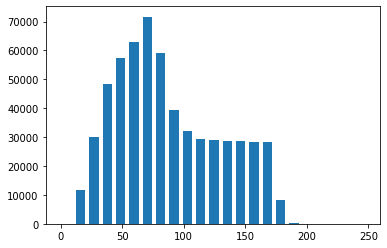

[0.03546462 0.00868926 0.00107707 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
17
[0.03546462 0.00868926 0.00107707 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
3


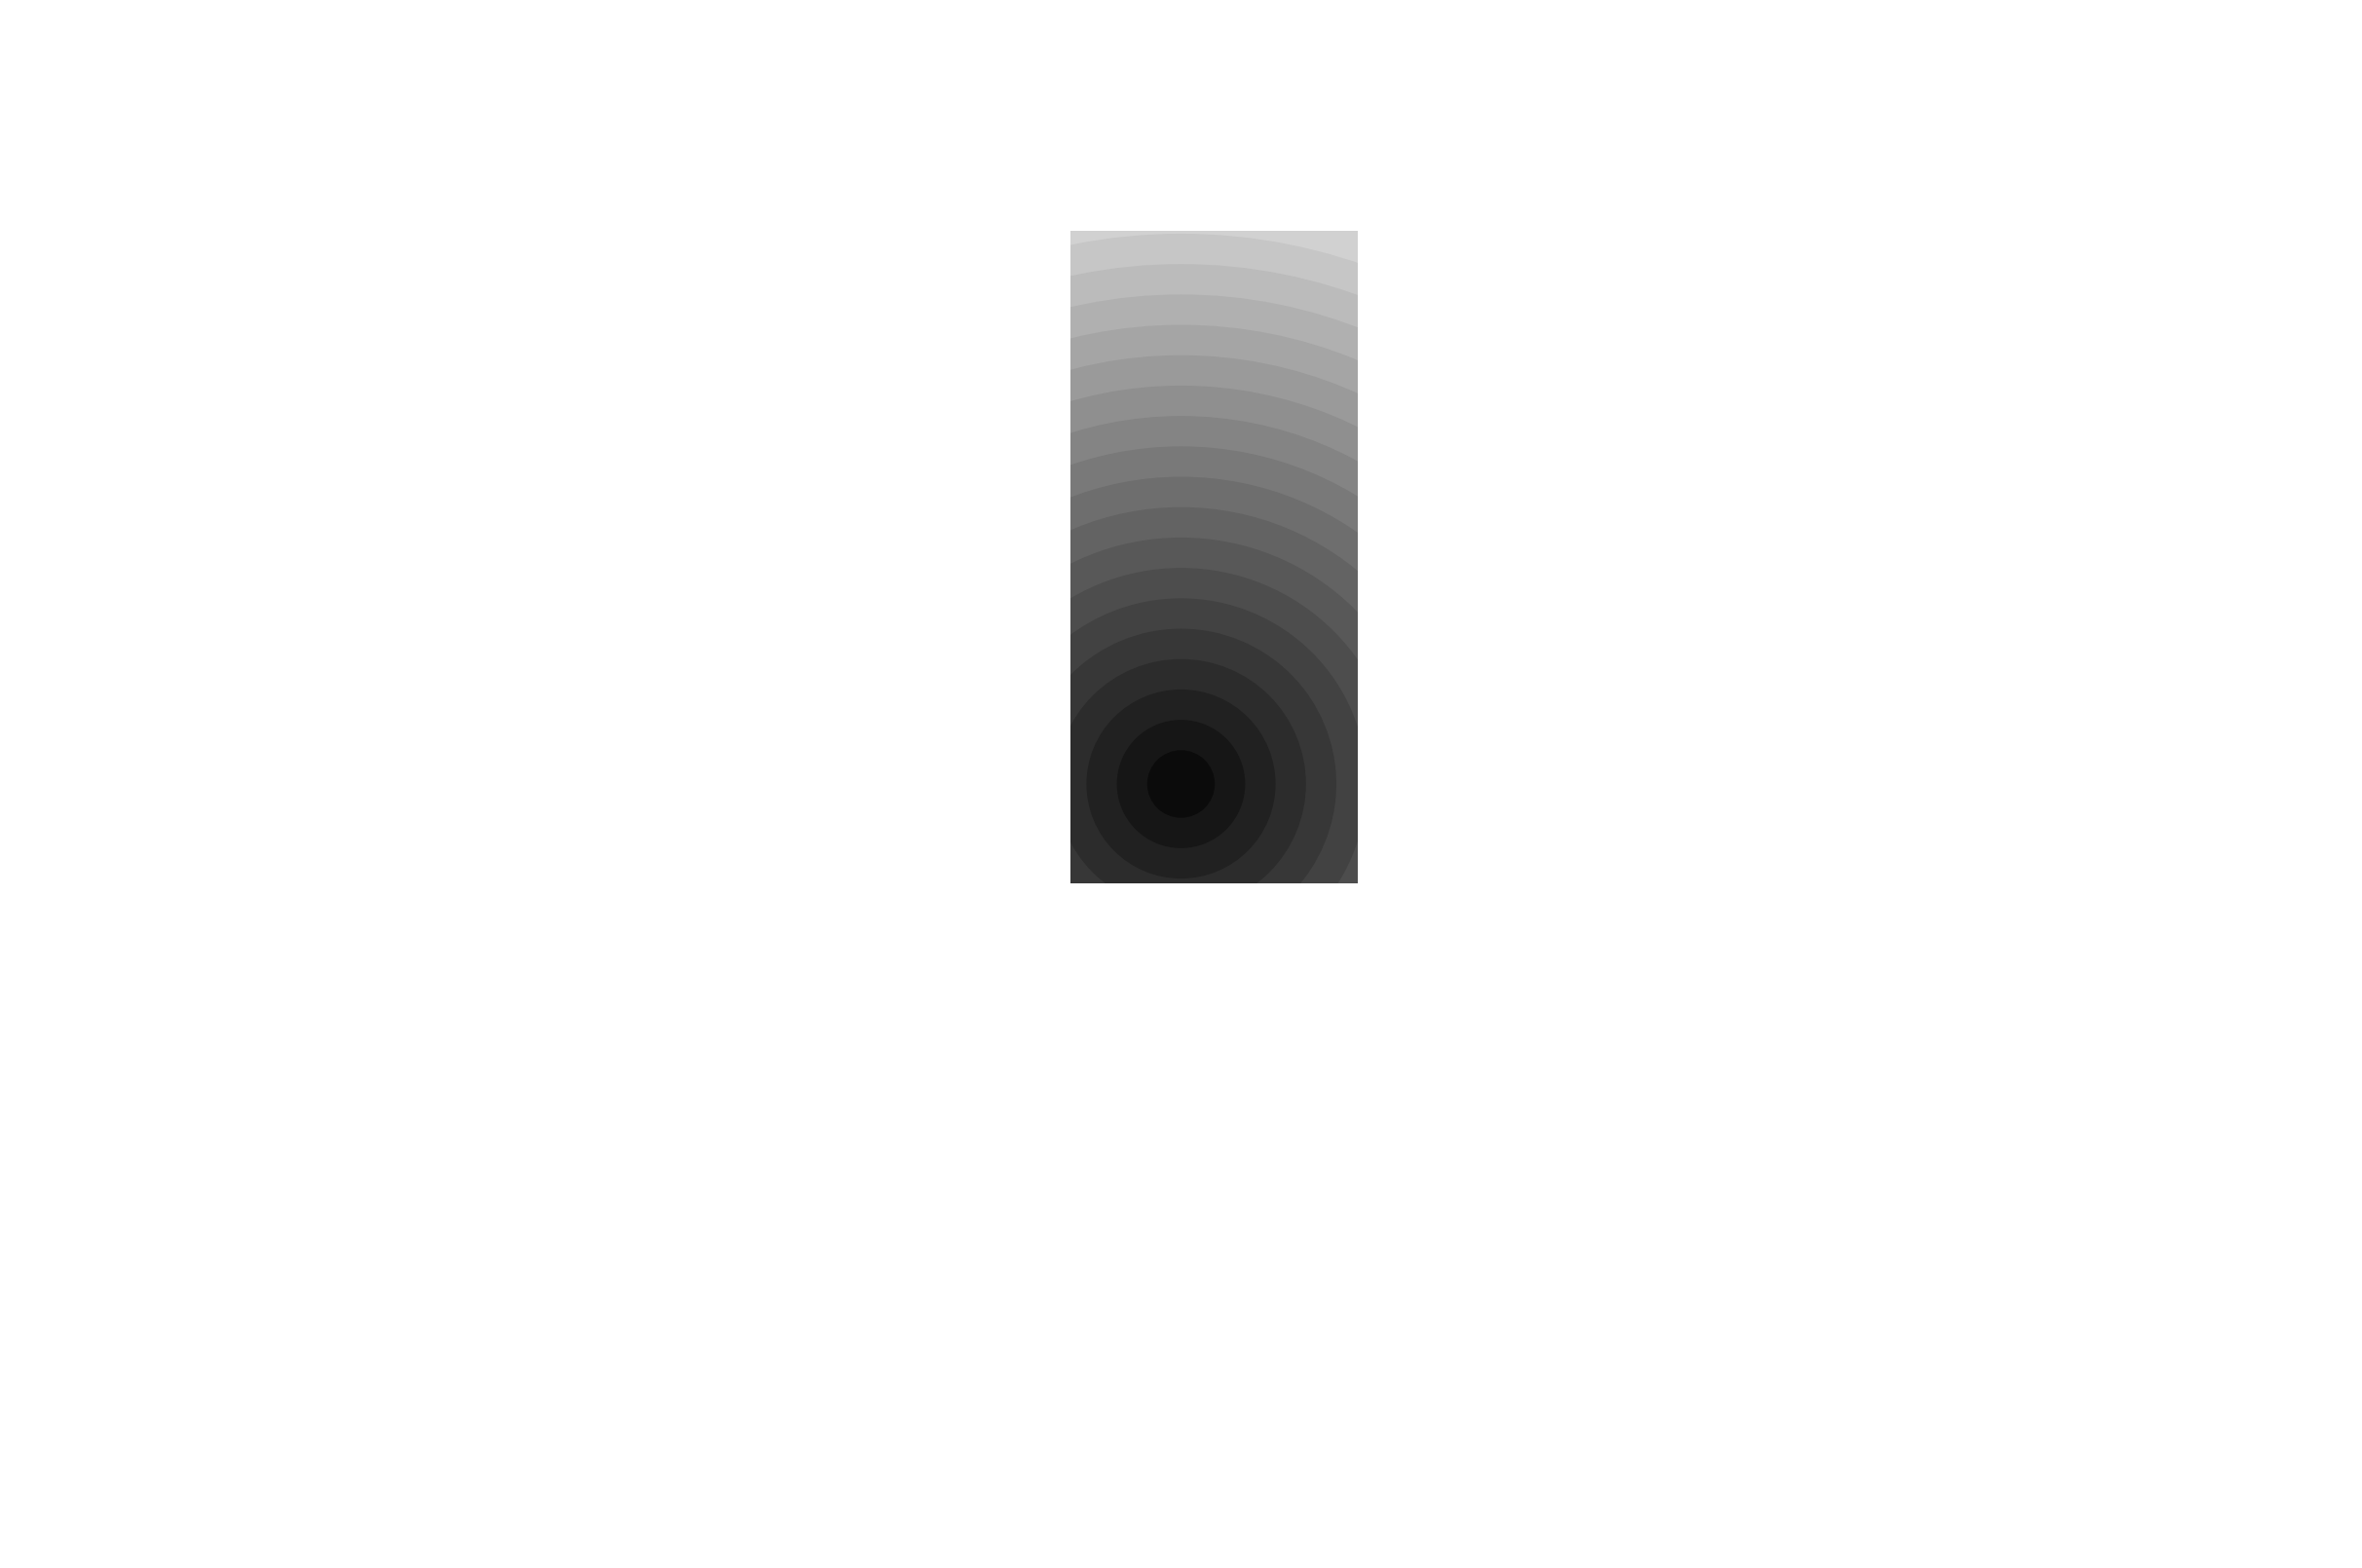

(-0.07685795673443849, -0.5557181194938253)
Time                      1.61373e+09
RatX                         0.332324
RatY                        -0.236459
RatZ                          0.62277
BeaconX                     -0.076858
BeaconY                     -0.555718
Visibility                          1
time_of_beacon_trigger    1.61373e+09
Beacon_group                        3
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 76, dtype: object
23
[    0 11730 29922 48279 54132 45630 45309 33213 30411 29658 29145 28737
 28569 28431 28335 28212 28110 27987 27996  9144     0     0     0]
[11730 29922 48279 54132 45630 45309 33213 30411 29658 29145 28737 28569
 28431 28335 28212 28110 27987 27996  9144]
[ 225.57692308  575.42307692  928.44230769 1041.          877.5
  871.32692308  638.71153846  584.82692308  570.34615385  560.48076923
  552.63461538  549.40384615  546.75        544.90384615  542.53846154
  540.576

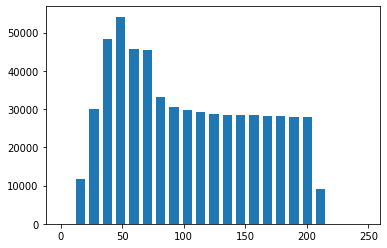

[0.04433078 0.01216496 0.00538536 0.         0.         0.
 0.00156565 0.         0.00350664 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
19
[0.04433078 0.01216496 0.00538536 0.         0.         0.
 0.00156565 0.         0.00350664 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
4


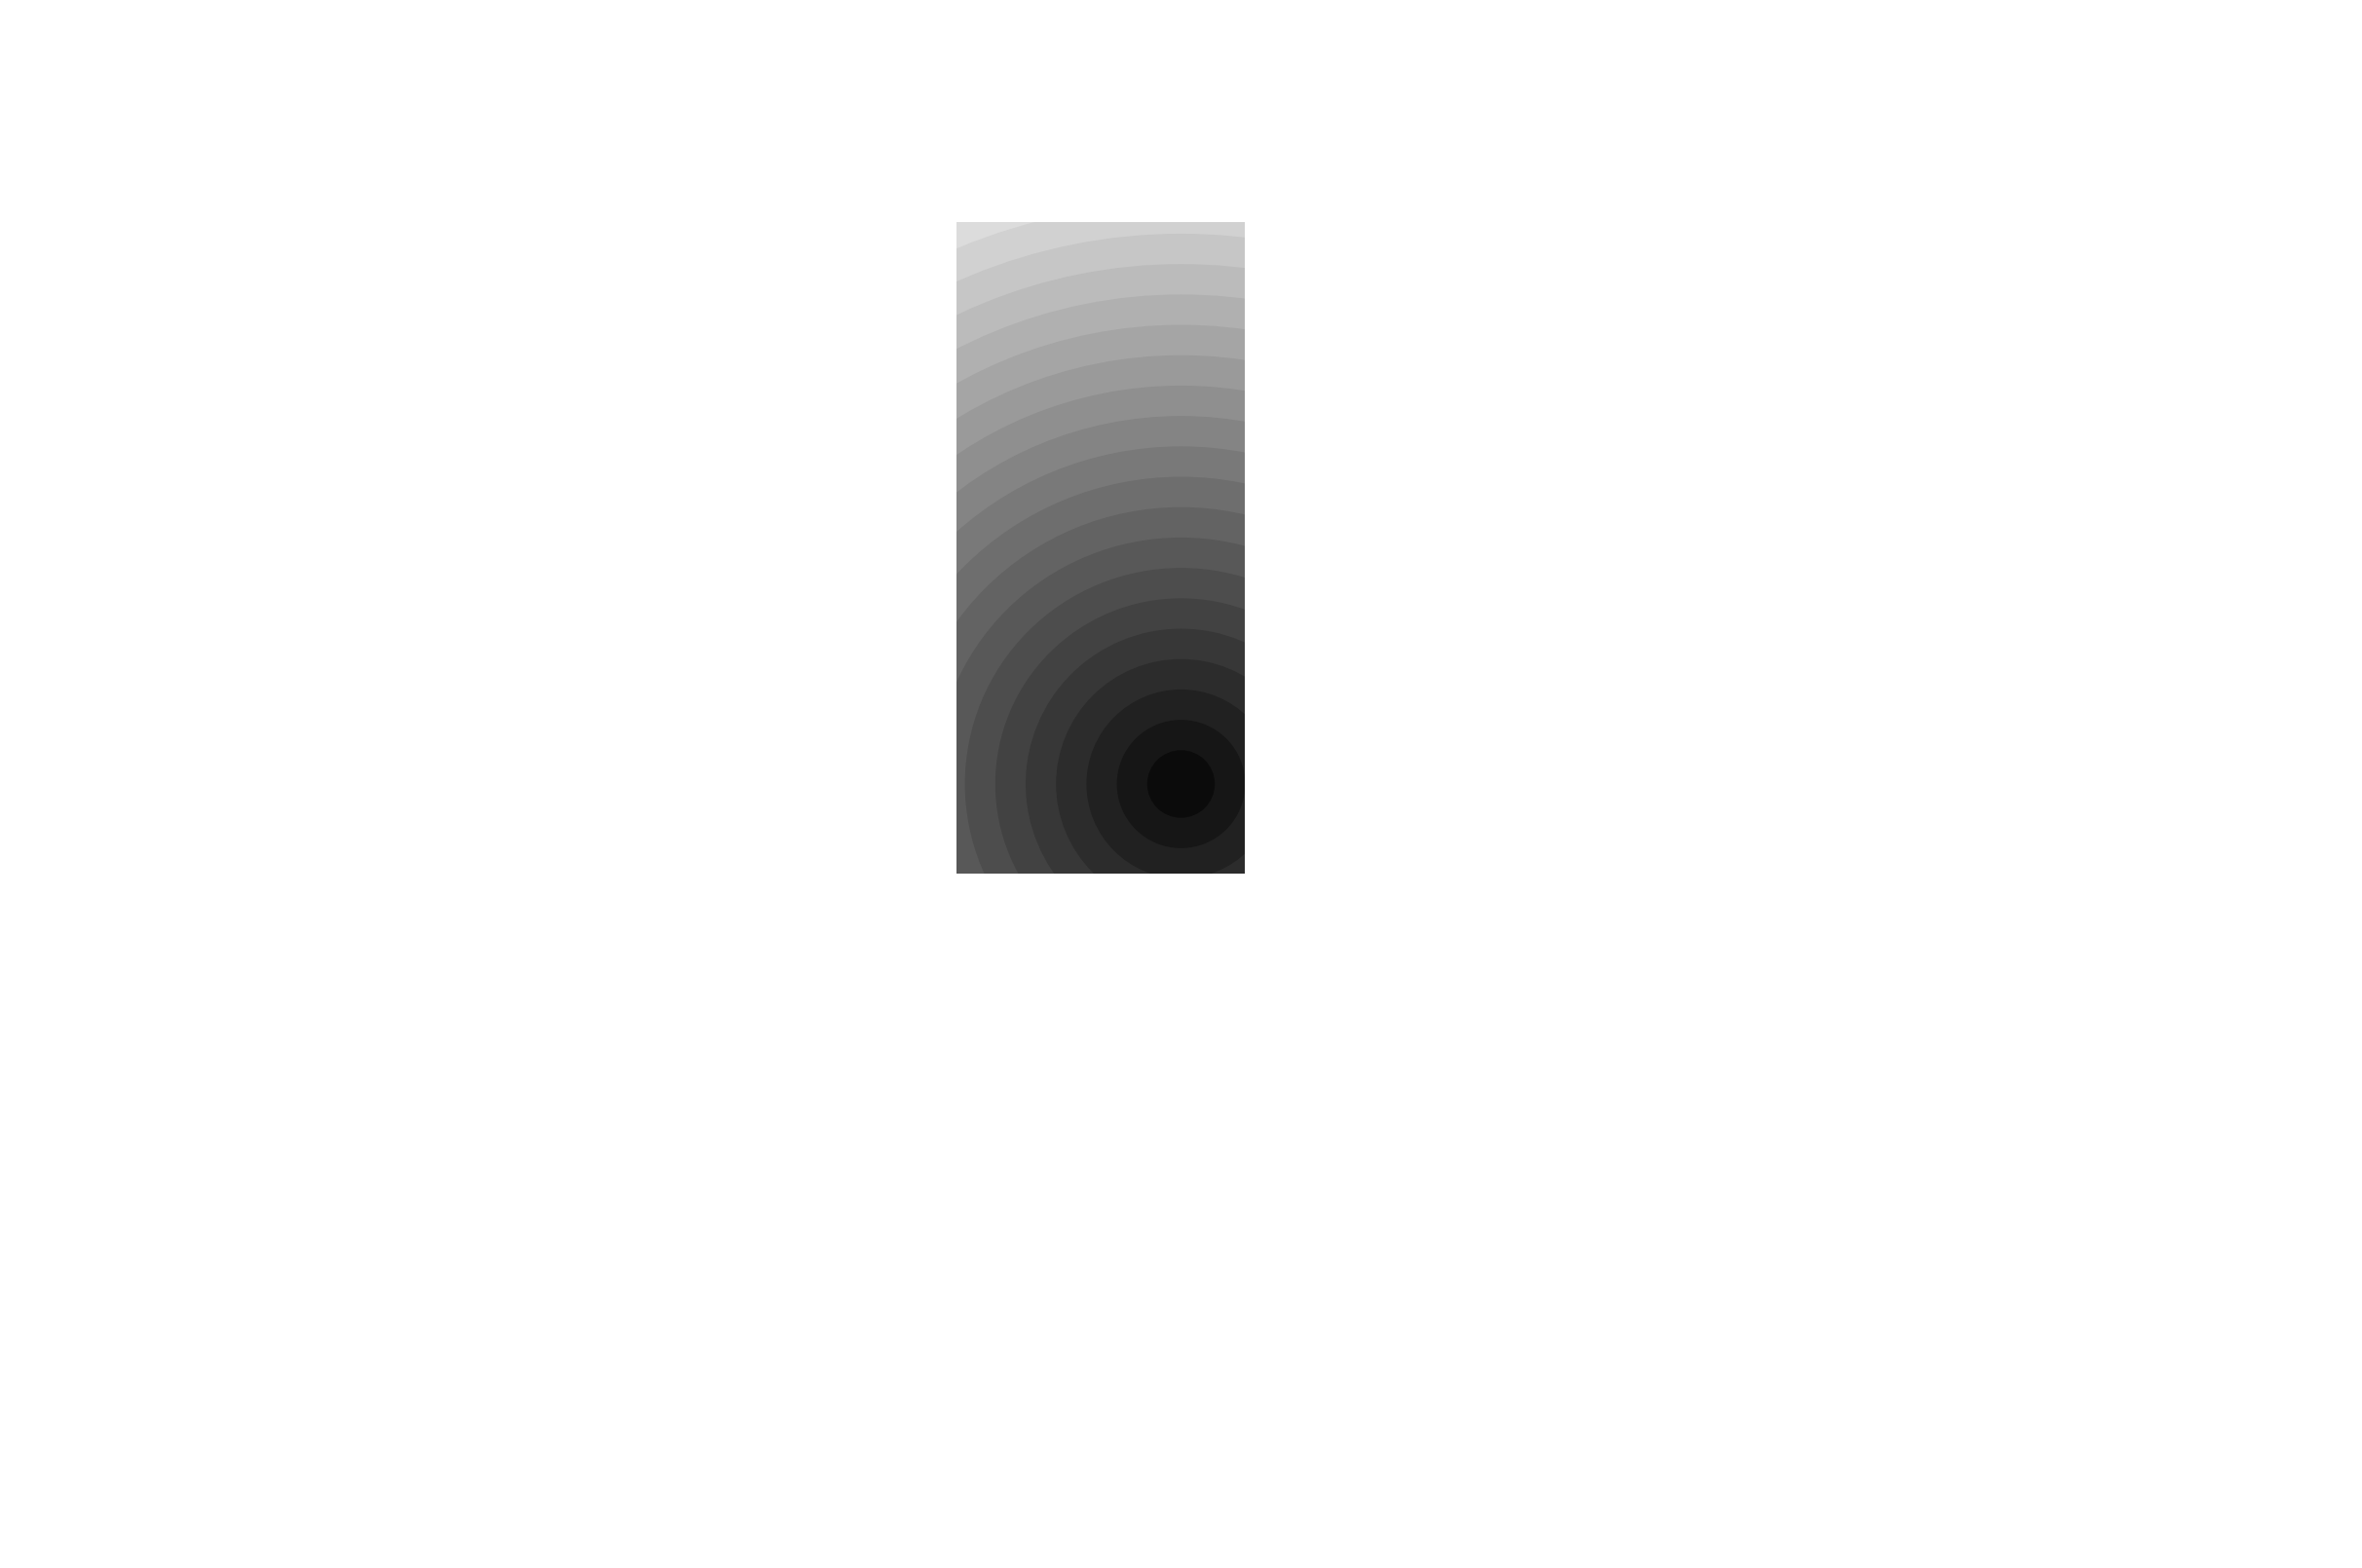

(0.2031896294898467, -0.5776516131145937)
Time                      1.61373e+09
RatX                         0.253139
RatY                        -0.534912
RatZ                         0.621968
BeaconX                       0.20319
BeaconY                     -0.577652
Visibility                          1
time_of_beacon_trigger    1.61373e+09
Beacon_group                        4
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 101, dtype: object
23
[    0 11730 29880 37893 34143 36666 41193 45519 40347 32220 30789 29943
 29520 29202 28986 28779 28608 28422 28389 18876  2967     0     0]
[11730 29880 37893 34143 36666 41193 45519 40347 32220 30789 29943 29520
 29202 28986 28779 28608 28422 28389 18876  2967]
[225.57692308 574.61538462 728.71153846 656.59615385 705.11538462
 792.17307692 875.36538462 775.90384615 619.61538462 592.09615385
 575.82692308 567.69230769 561.57692308 557.42307692 553.44230769
 550.1538461

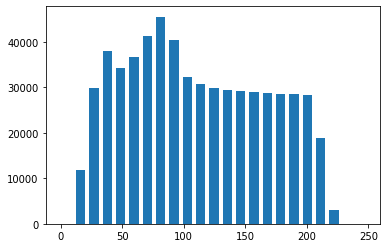

[0.0398977  0.00348059 0.         0.00152301 0.         0.00126235
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.0398977  0.00348059 0.         0.00152301 0.         0.00126235
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
5


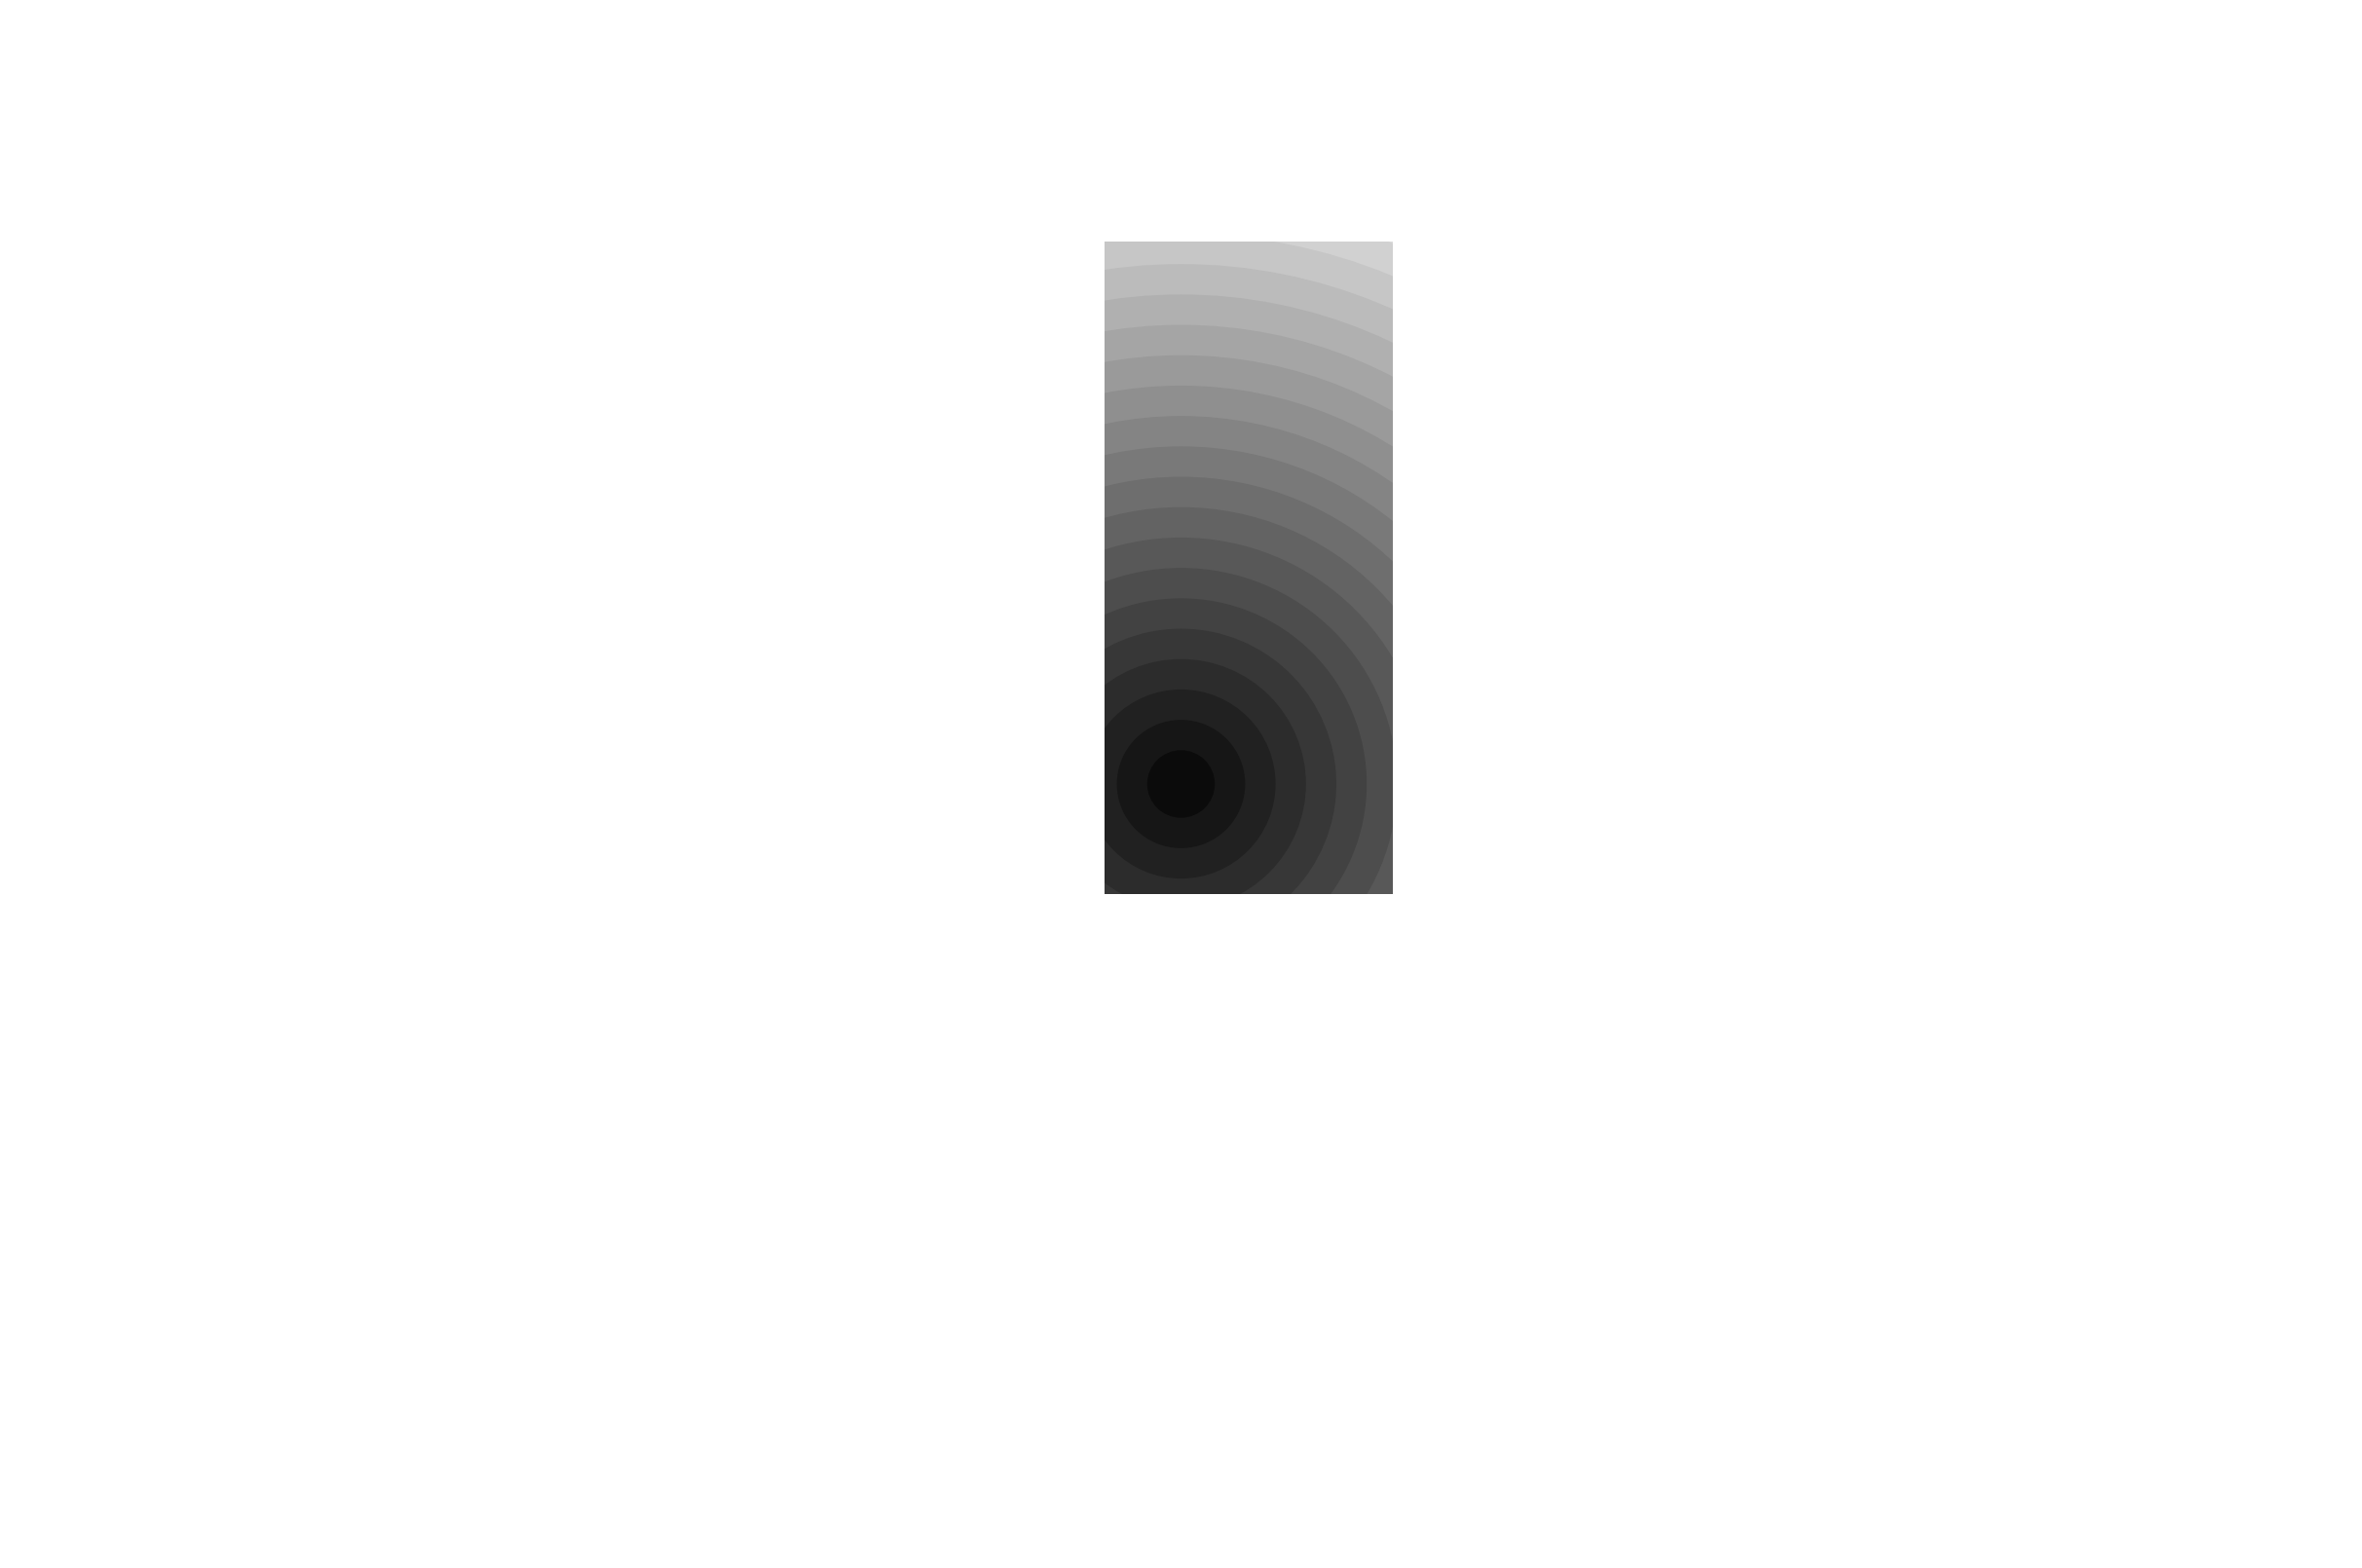

(-0.161819261454925, -0.5287954870929873)
Time                      1.61402e+09
RatX                        -0.169332
RatY                        -0.608501
RatZ                         0.626865
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.61402e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 141, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e

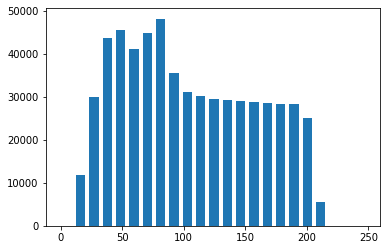

[0.0398977  0.01911637 0.00594544 0.00228055 0.         0.
 0.00107835 0.00146162 0.         0.0017218  0.         0.
 0.00179546 0.00180612 0.00181748 0.00182668 0.         0.
 0.         0.        ]
20
[0.0398977  0.01911637 0.00594544 0.00228055 0.         0.
 0.00107835 0.00146162 0.         0.0017218  0.         0.
 0.00179546 0.00180612 0.00181748 0.00182668 0.         0.
 0.         0.         0.         0.         0.        ]
23
6


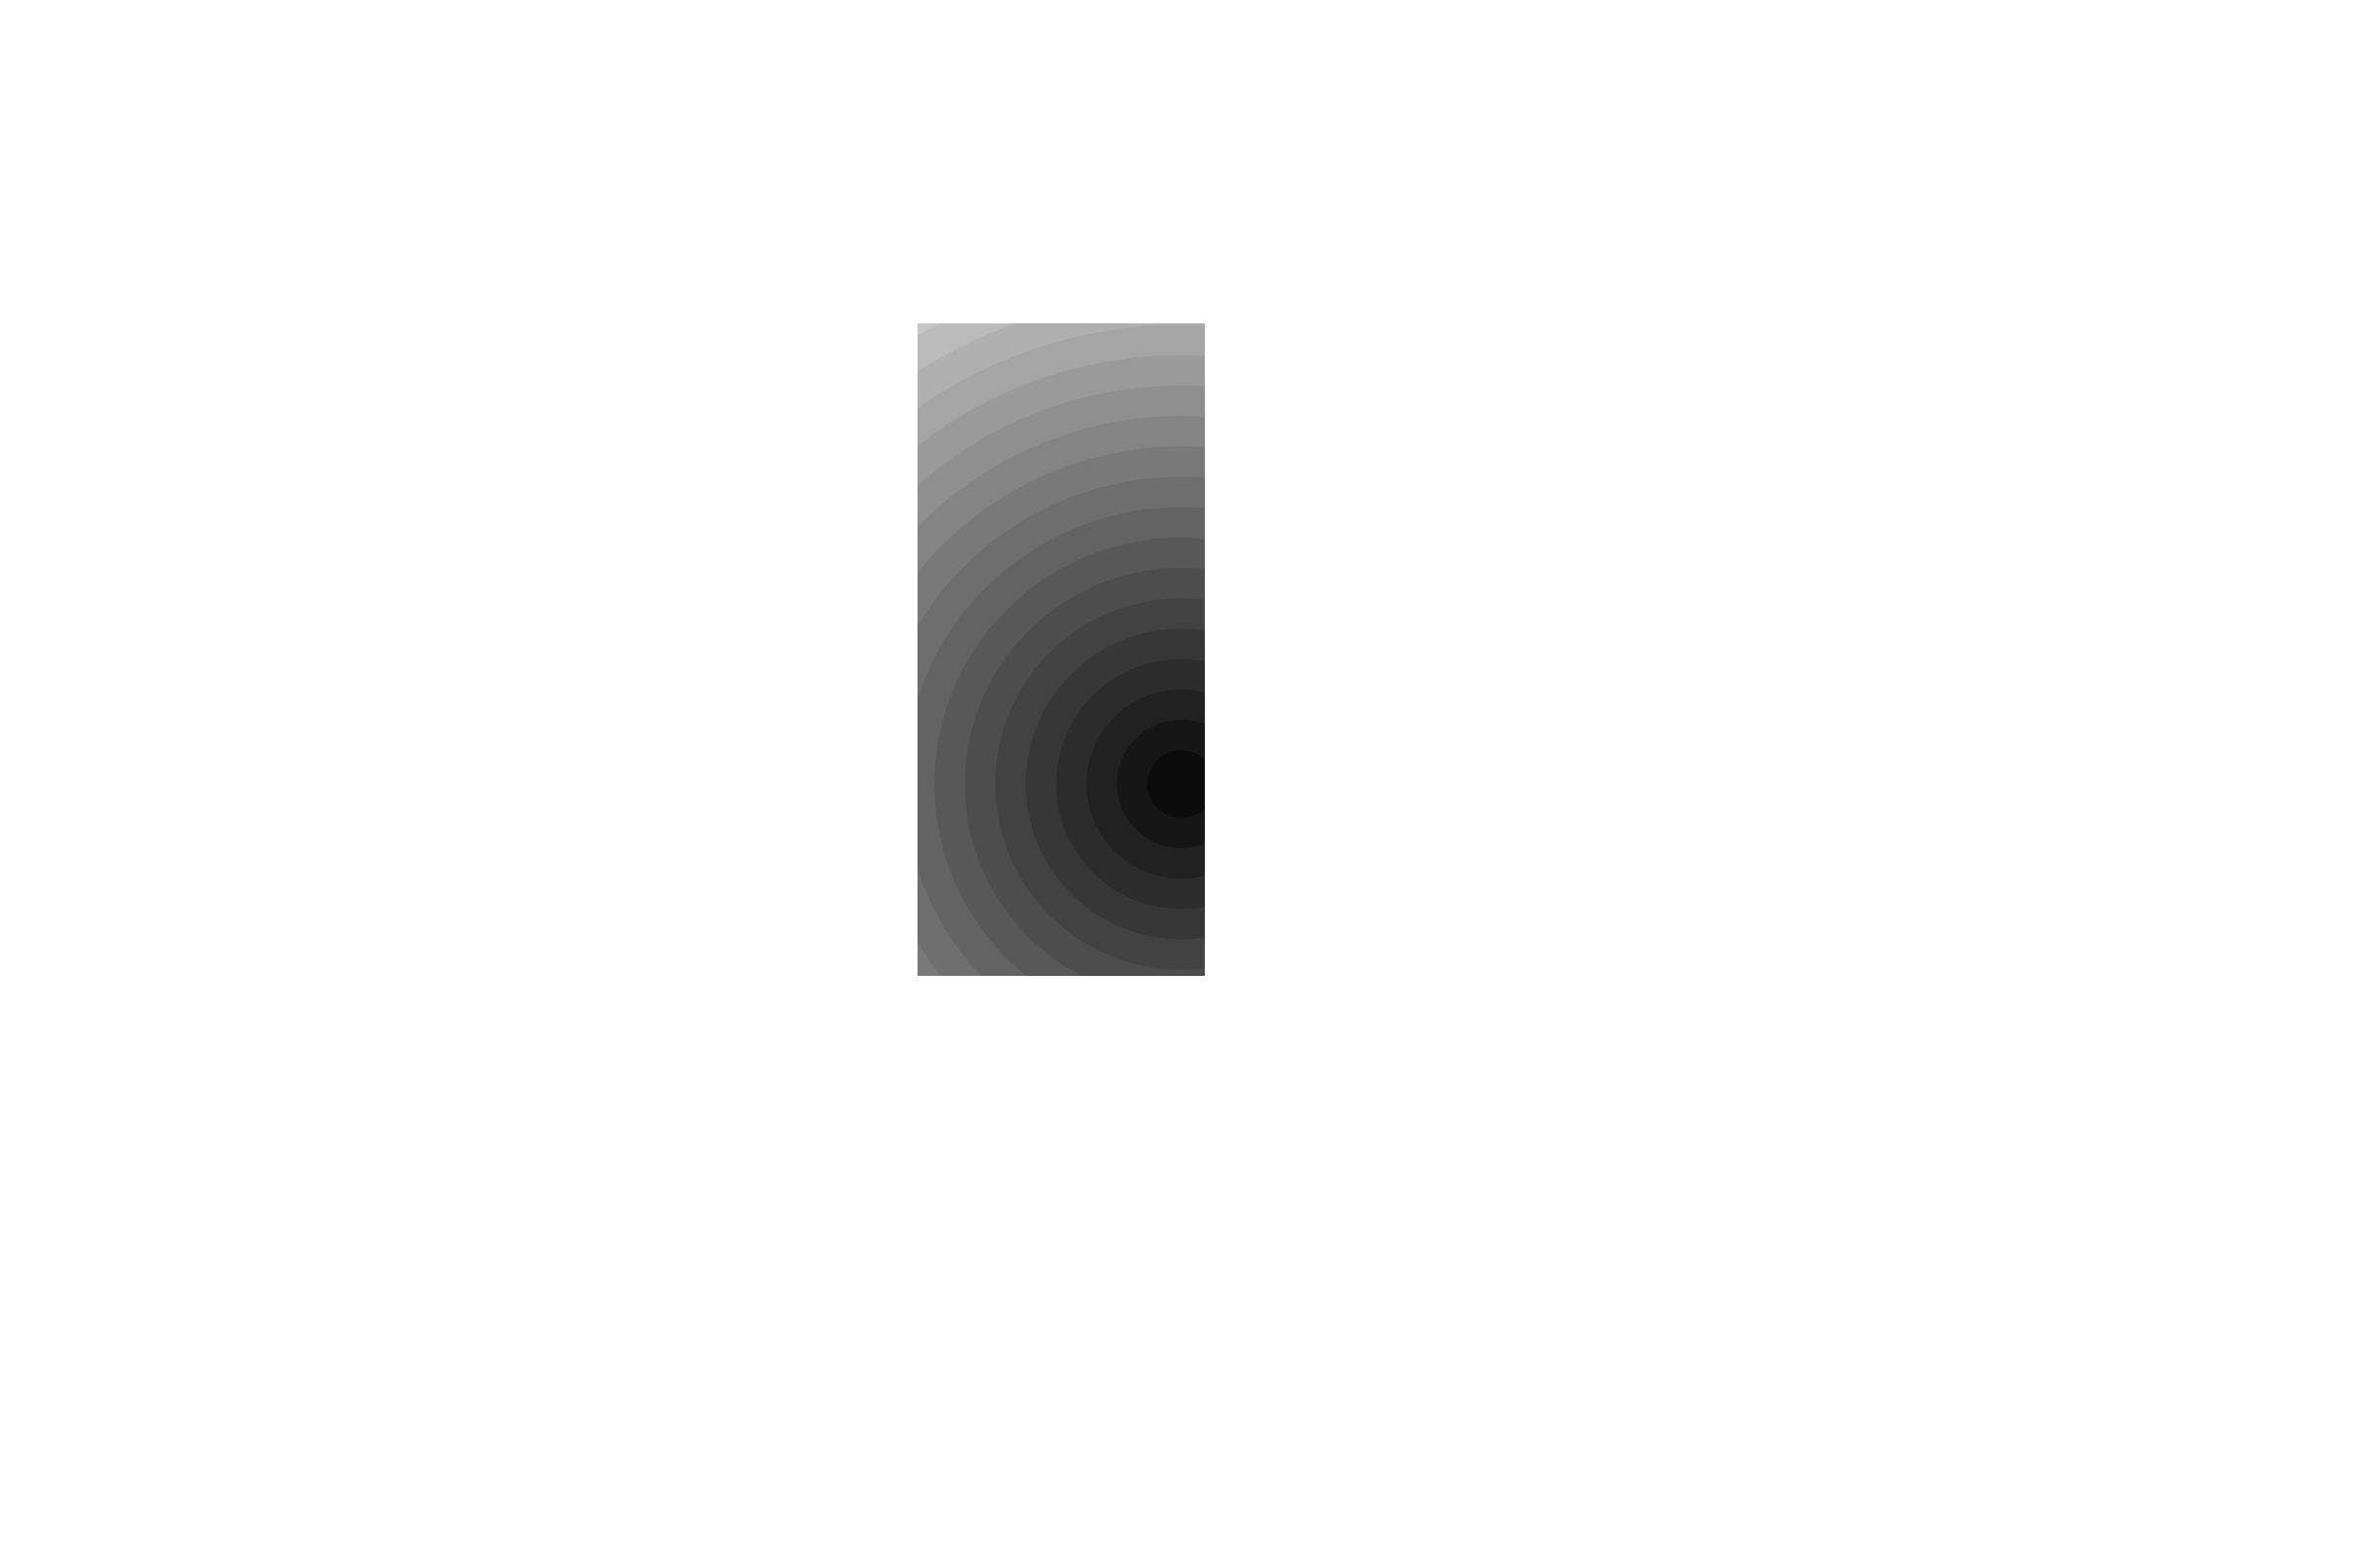

(0.3003073206842918, -0.3262610930447919)
Time                      1.61402e+09
RatX                         0.287923
RatY                        -0.243646
RatZ                         0.621391
BeaconX                      0.300307
BeaconY                     -0.326261
Visibility                          1
time_of_beacon_trigger    1.61402e+09
Beacon_group                        2
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 164, dtype: object
23
[    0 10590 19770 28815 37917 46713 56238 58236 59016 57576 41553 32997
 30858 30204 29760 29412 16644  6231   420     0     0     0     0]
[10590 19770 28815 37917 46713 56238 58236 59016 57576 41553 32997 30858
 30204 29760 29412 16644  6231   420]
[ 203.65384615  380.19230769  554.13461538  729.17307692  898.32692308
 1081.5        1119.92307692 1134.92307692 1107.23076923  799.09615385
  634.55769231  593.42307692  580.84615385  572.30769231  565.61538462
  320.076

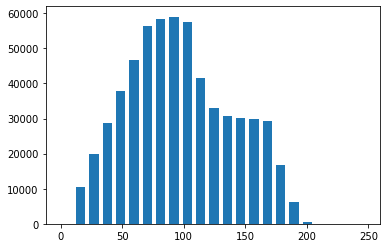

[0.04419263 0.00789074 0.00180462 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
18
[0.04419263 0.00789074 0.00180462 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
7


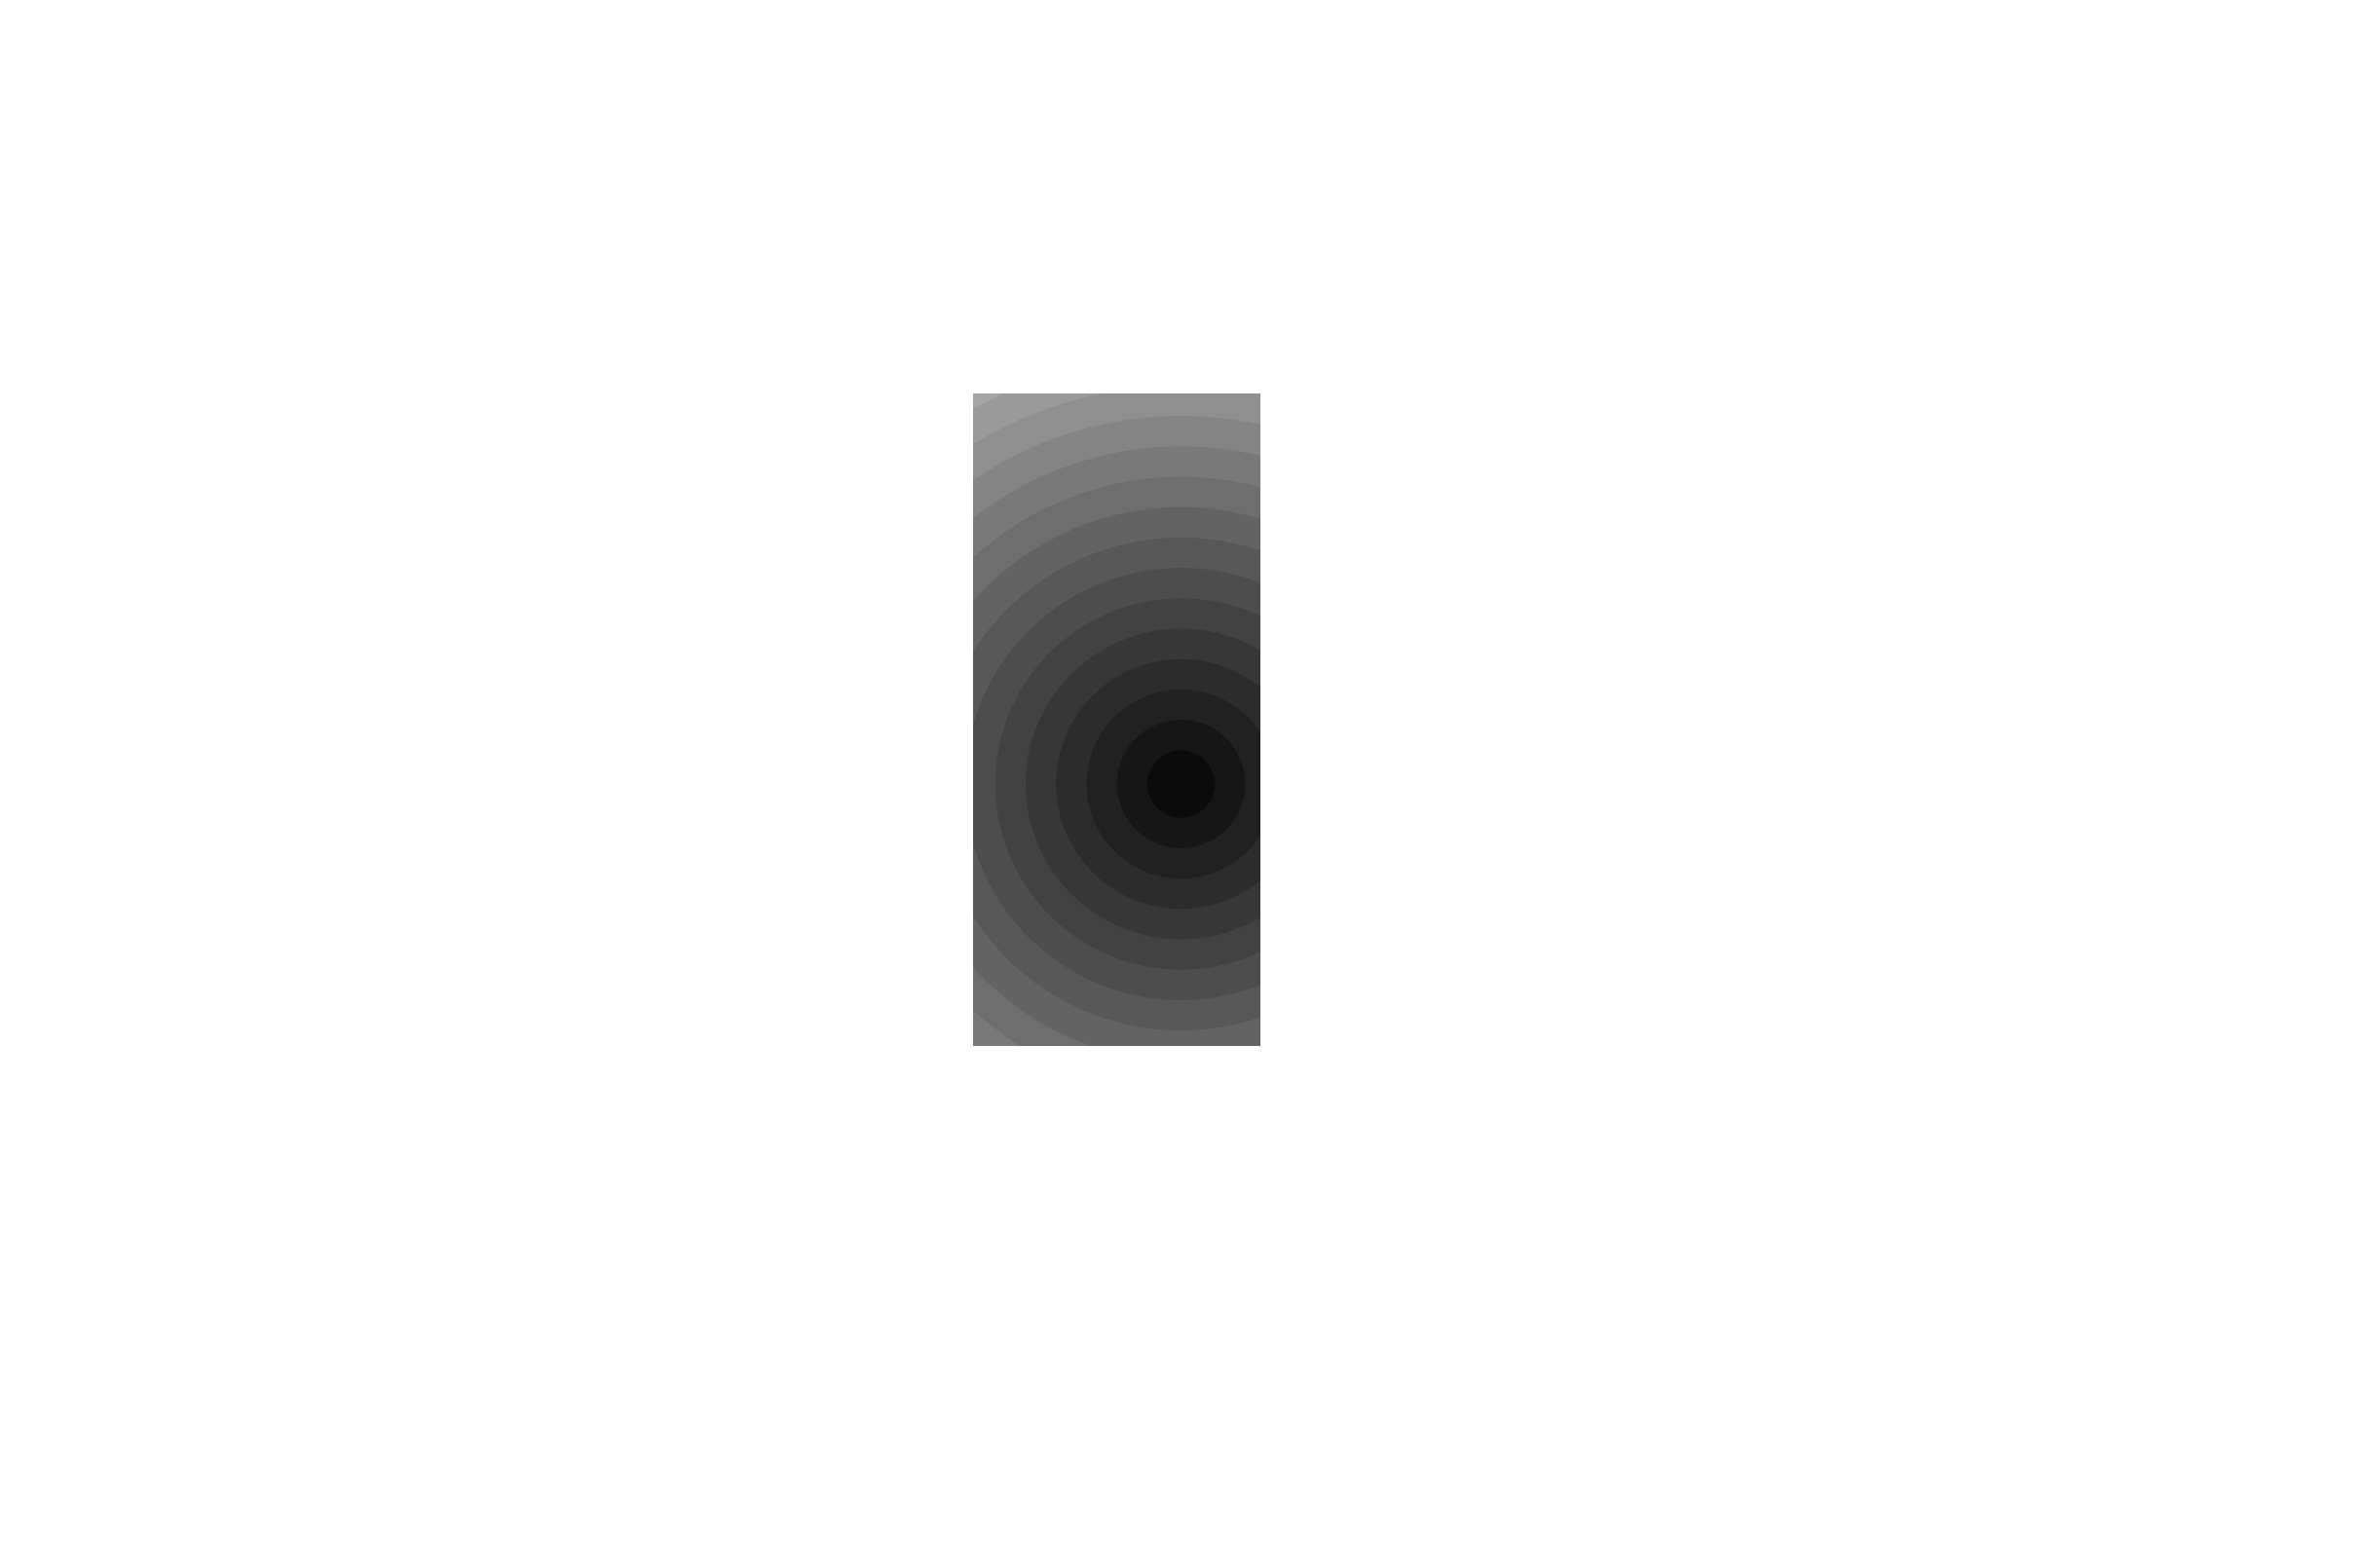

(0.1635708828726557, -0.1530027572608644)
Time                      1.61402e+09
RatX                         0.201186
RatY                        -0.196631
RatZ                         0.625867
BeaconX                      0.163571
BeaconY                     -0.153003
Visibility                          1
time_of_beacon_trigger    1.61402e+09
Beacon_group                        3
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 184, dtype: object
23
[    0 11730 29922 44745 50397 58233 67512 74235 65418 56037 39366 31782
 29028 26070  7764   711     0     0     0     0     0     0     0]
[11730 29922 44745 50397 58233 67512 74235 65418 56037 39366 31782 29028
 26070  7764   711]
[ 225.57692308  575.42307692  860.48076923  969.17307692 1119.86538462
 1298.30769231 1427.59615385 1258.03846154 1077.63461538  757.03846154
  611.19230769  558.23076923  501.34615385  149.30769231   13.67307692]
15
23
[6 6 1 0 0 0 0 0 0 0

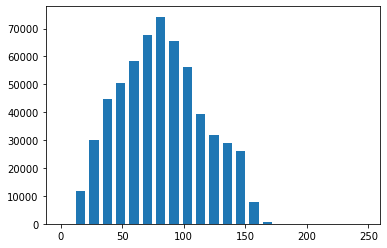

[0.02659847 0.01042711 0.00116214 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
15
[0.02659847 0.01042711 0.00116214 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
8


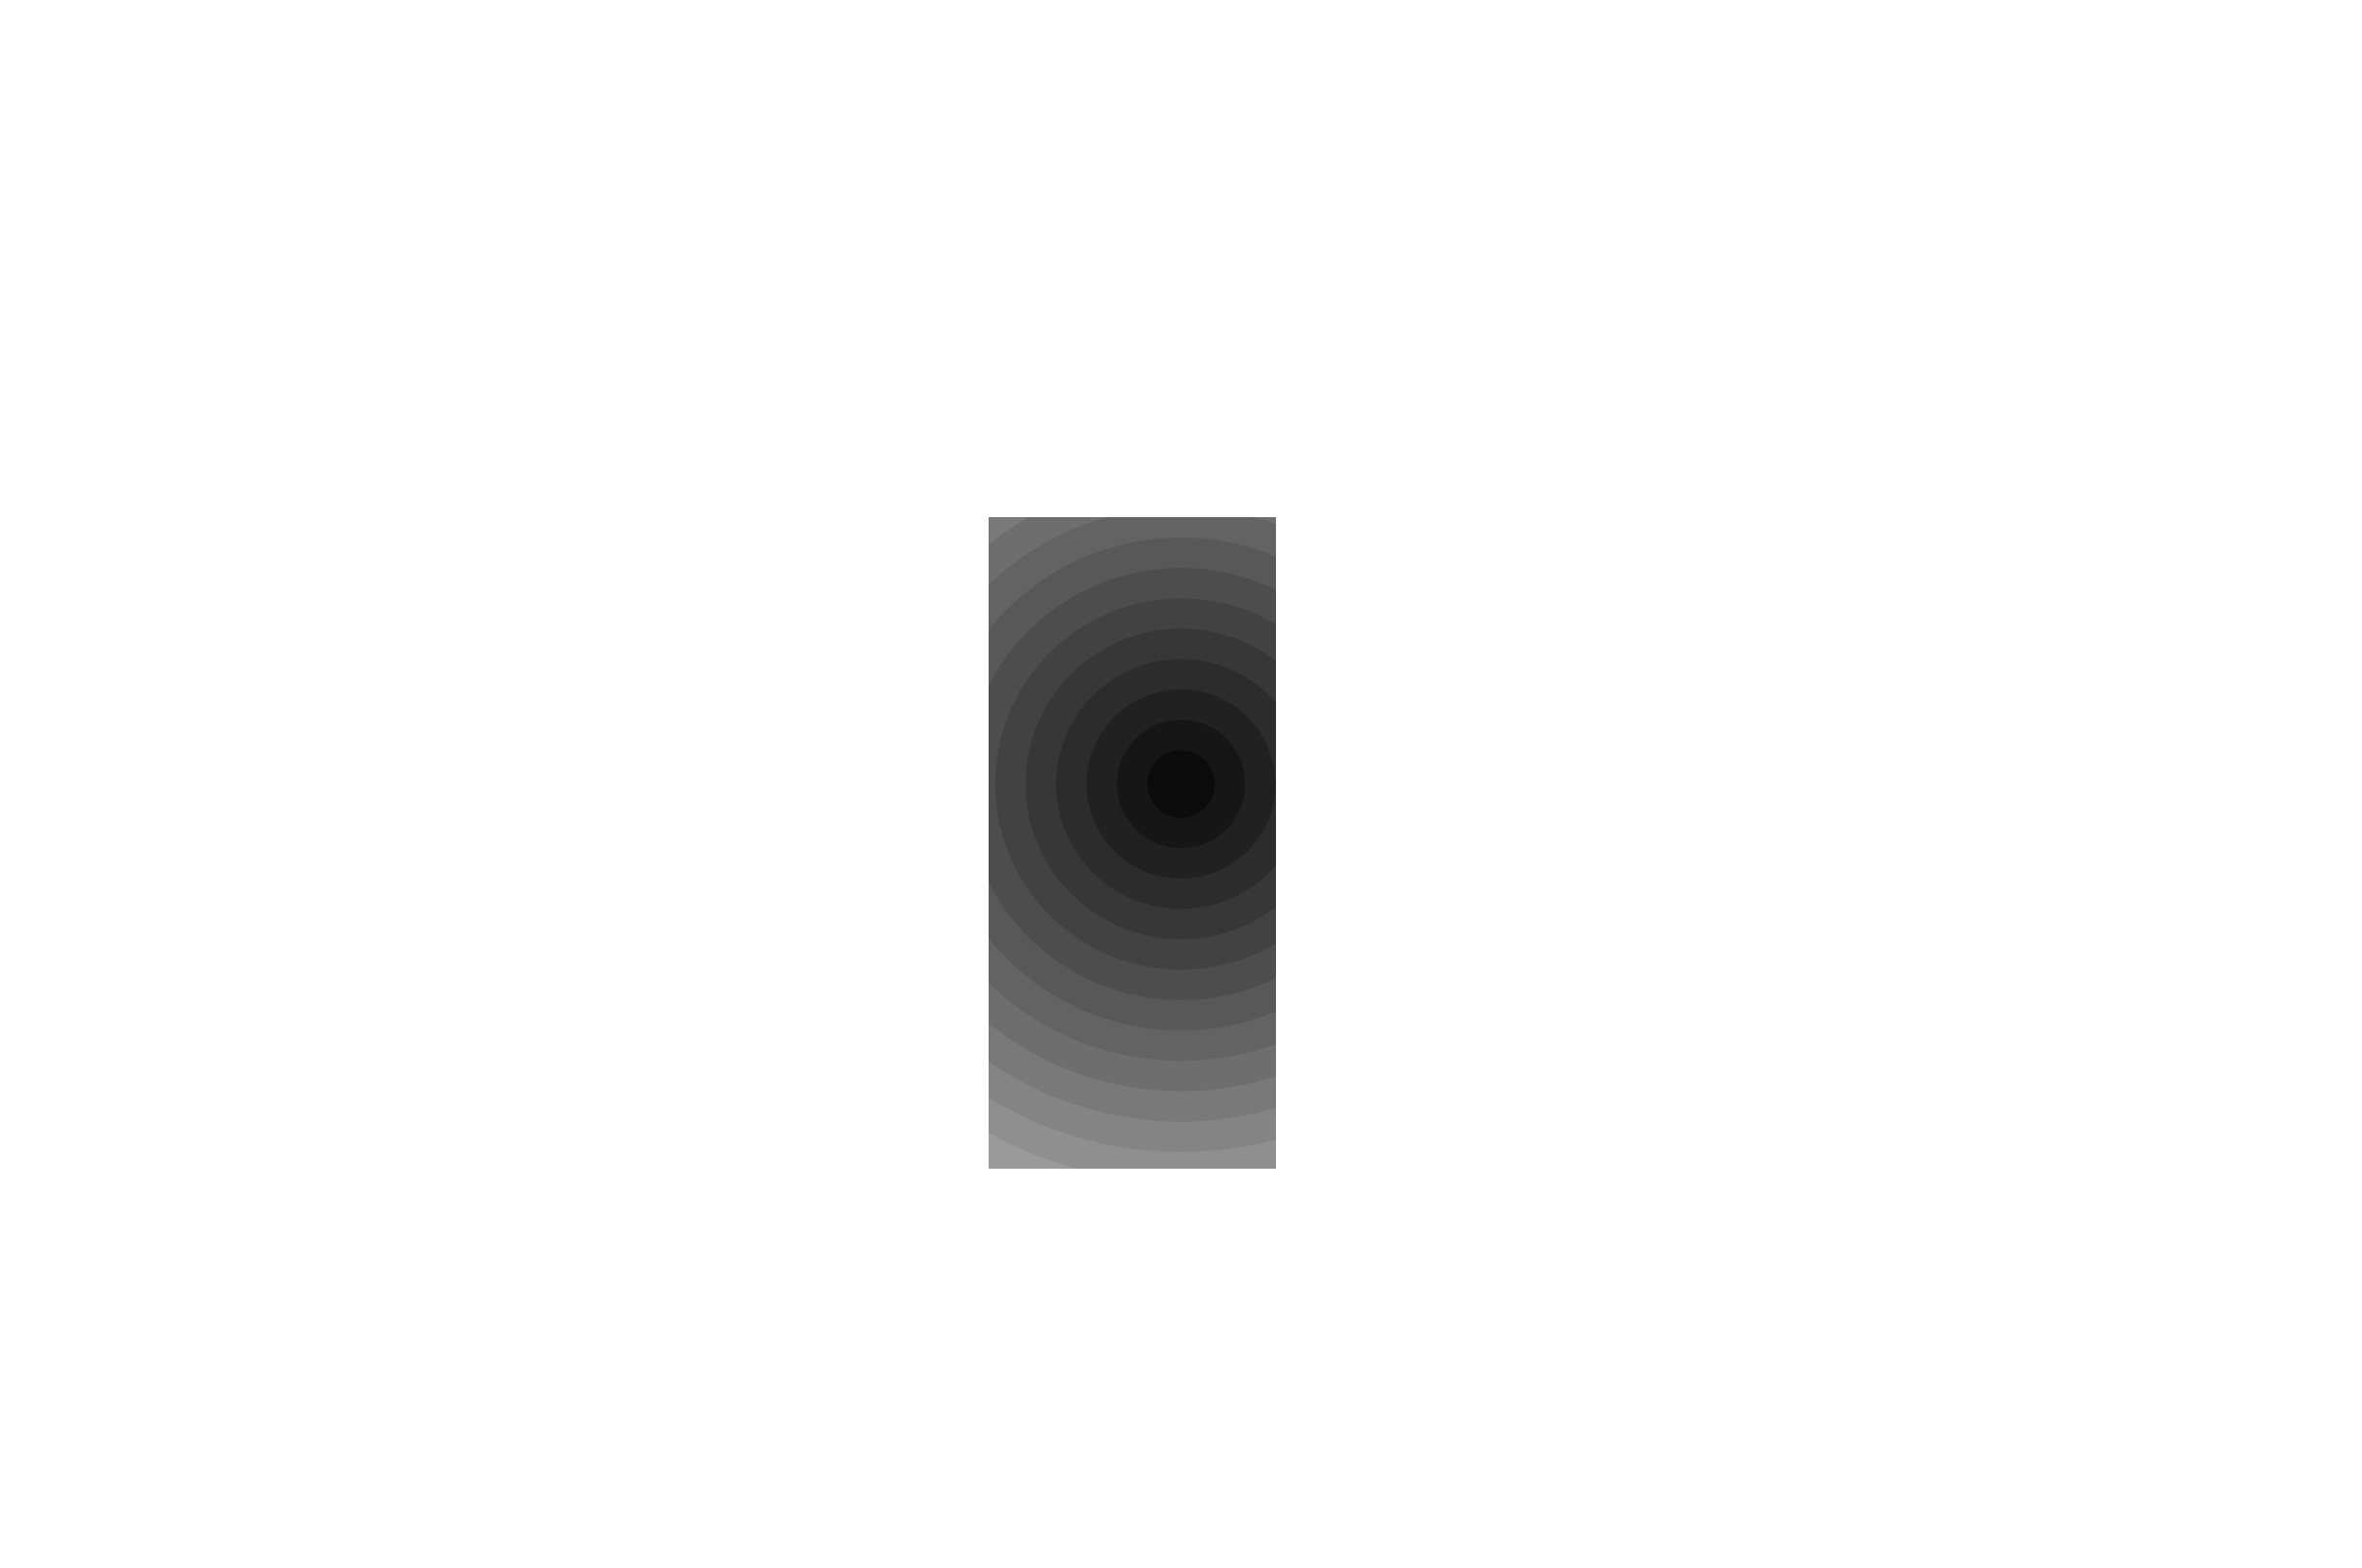

(0.1248972324762755, 0.1506679091663141)
Time                      1.61402e+09
RatX                         0.159024
RatY                         0.211424
RatZ                         0.621623
BeaconX                      0.124897
BeaconY                      0.150668
Visibility                          1
time_of_beacon_trigger    1.61402e+09
Beacon_group                        4
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 205, dtype: object
23
[    0 11730 29922 48279 55737 62061 71010 69507 62490 57009 38163 30567
 28752 22464  4371     3     0     0     0     0     0     0     0]
[11730 29922 48279 55737 62061 71010 69507 62490 57009 38163 30567 28752
 22464  4371     3]
[2.25576923e+02 5.75423077e+02 9.28442308e+02 1.07186538e+03
 1.19348077e+03 1.36557692e+03 1.33667308e+03 1.20173077e+03
 1.09632692e+03 7.33903846e+02 5.87826923e+02 5.52923077e+02
 4.32000000e+02 8.40576923e+01 5.76923077e-02]
15
23
[9 2 

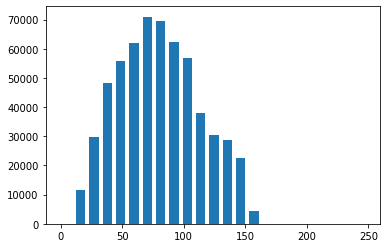

[0.0398977  0.0034757  0.         0.00186591 0.         0.
 0.         0.00083213 0.         0.         0.         0.
 0.         0.         0.        ]
15
[0.0398977  0.0034757  0.         0.00186591 0.         0.
 0.         0.00083213 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
9


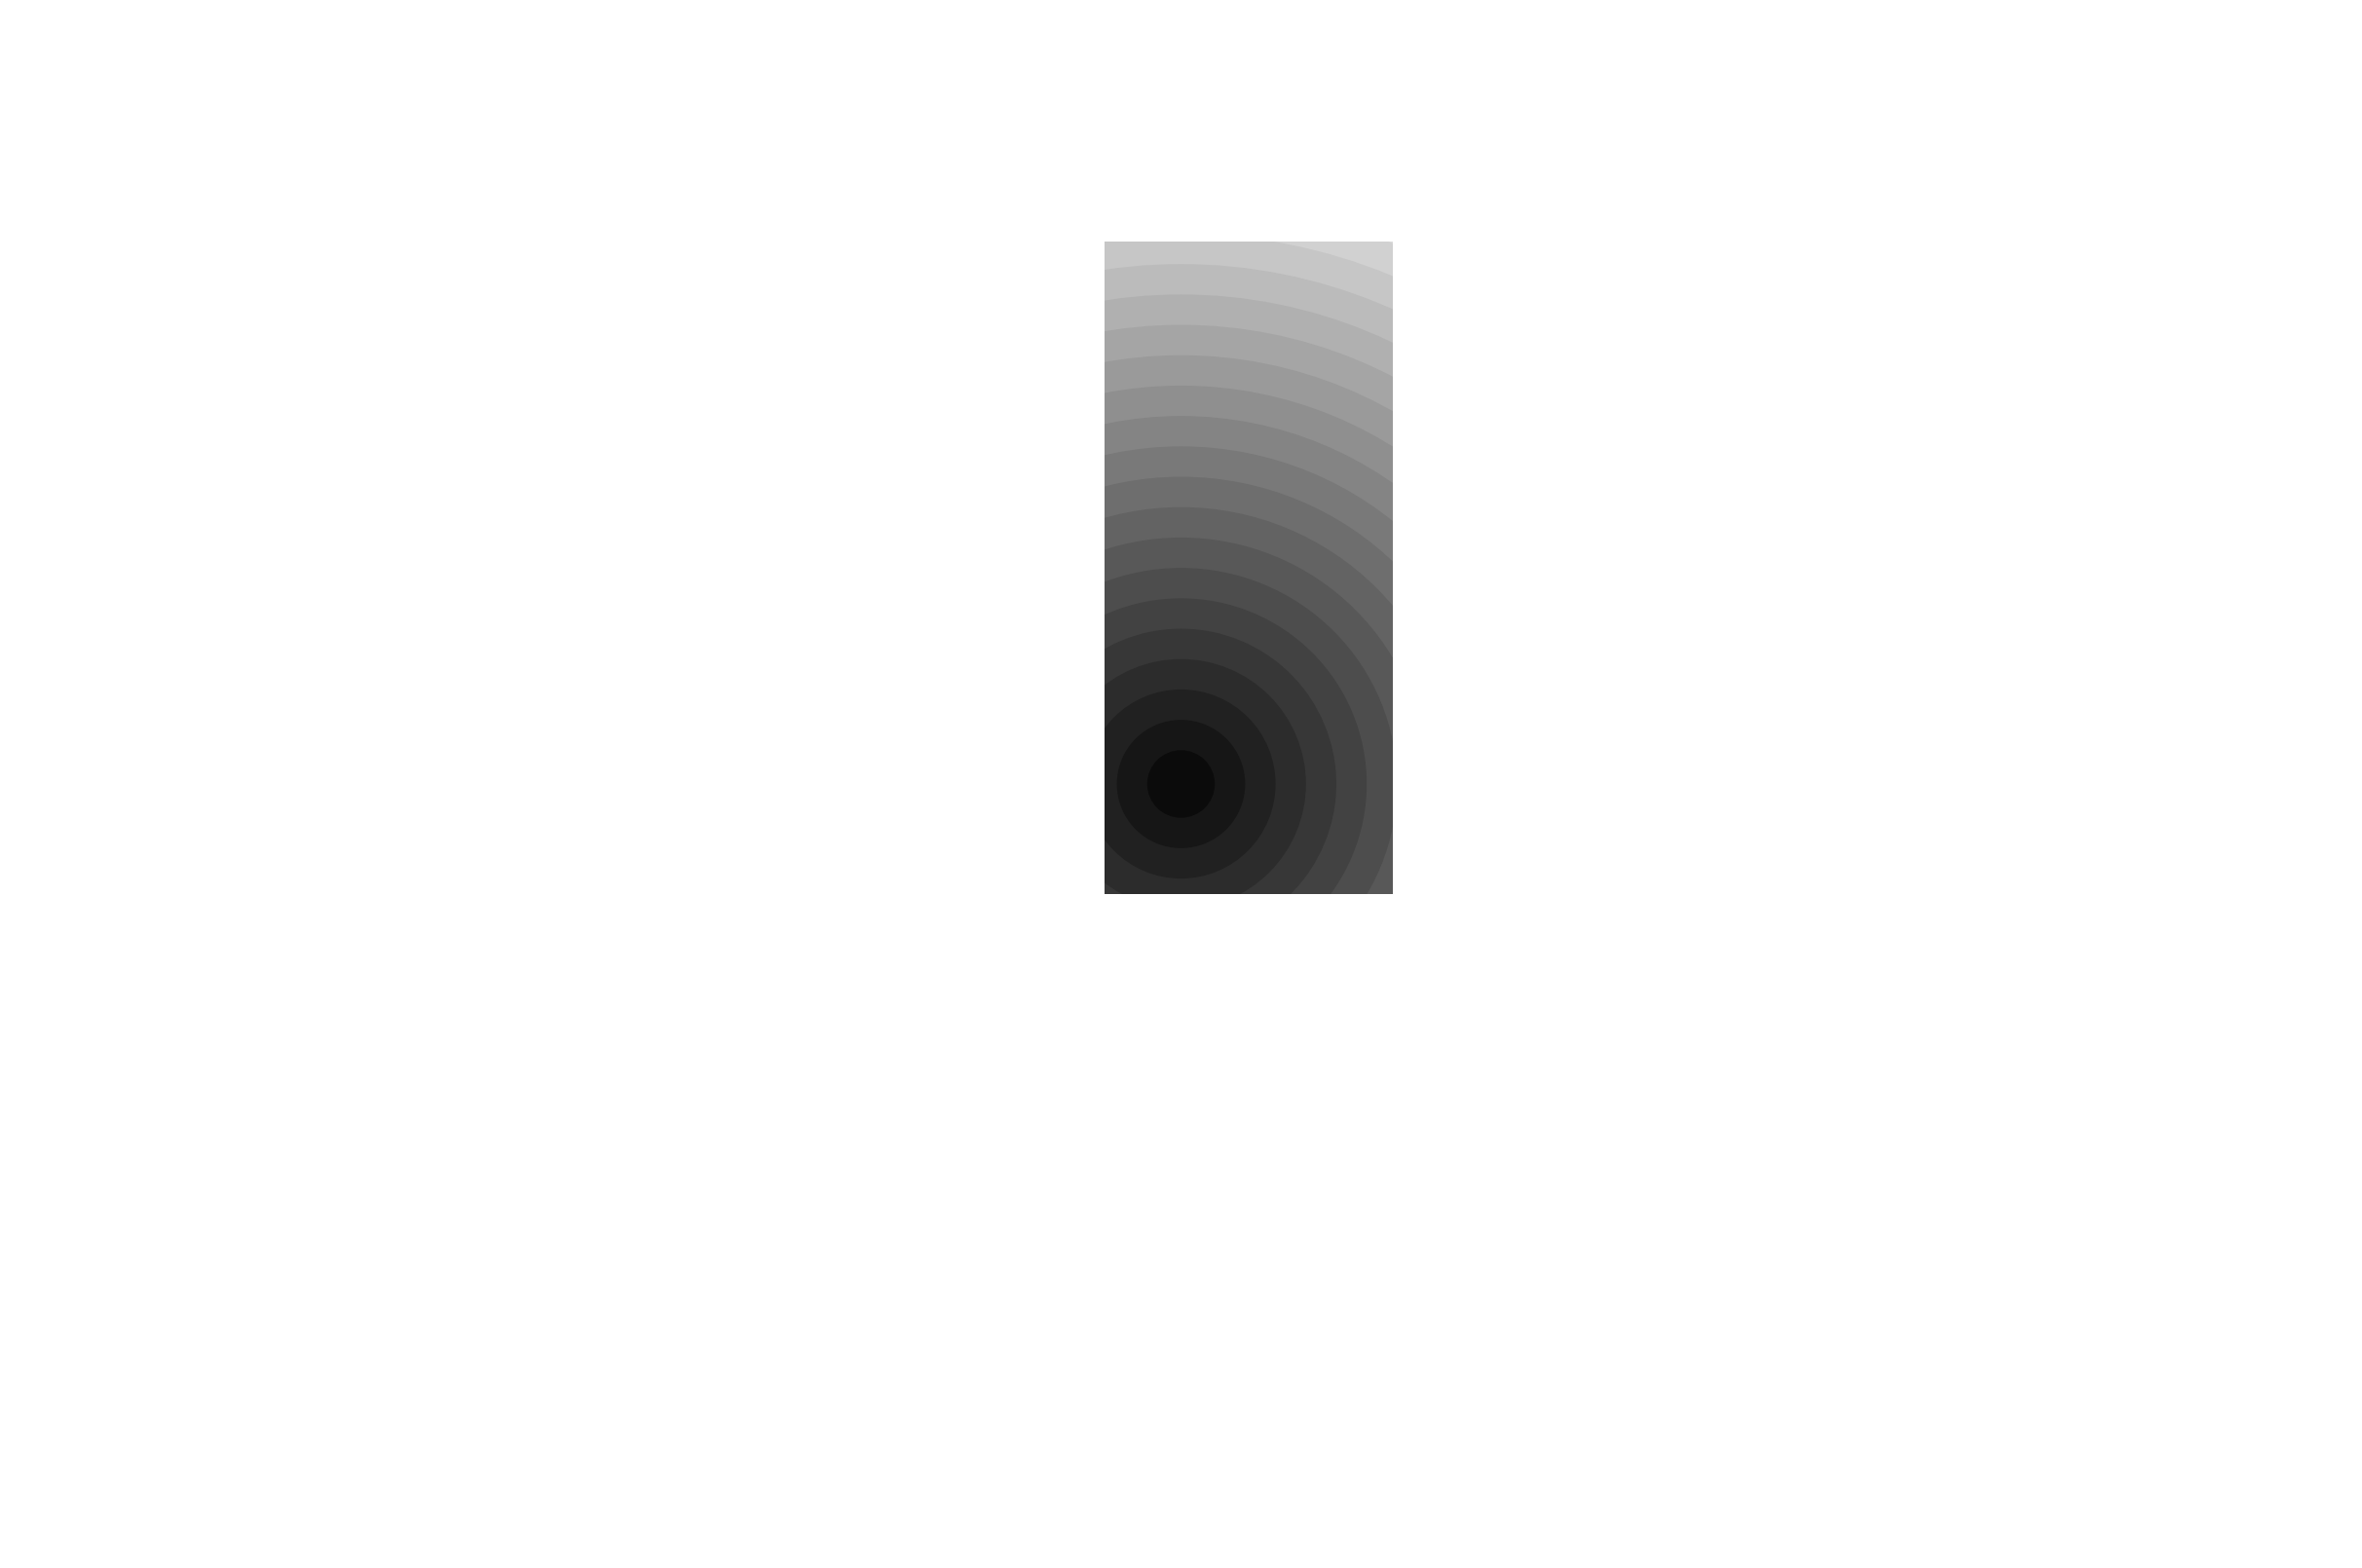

(-0.161819261454925, -0.5287954870929873)
Time                      1.61357e+09
RatX                        -0.219497
RatY                        -0.596928
RatZ                         0.632463
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.61357e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 229, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e

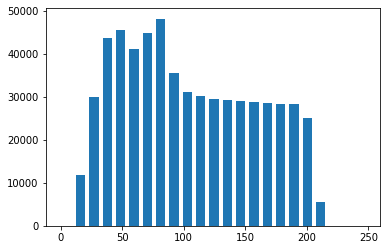

[0.04433078 0.00695141 0.00237818 0.         0.         0.00115671
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.04433078 0.00695141 0.00237818 0.         0.         0.00115671
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
10


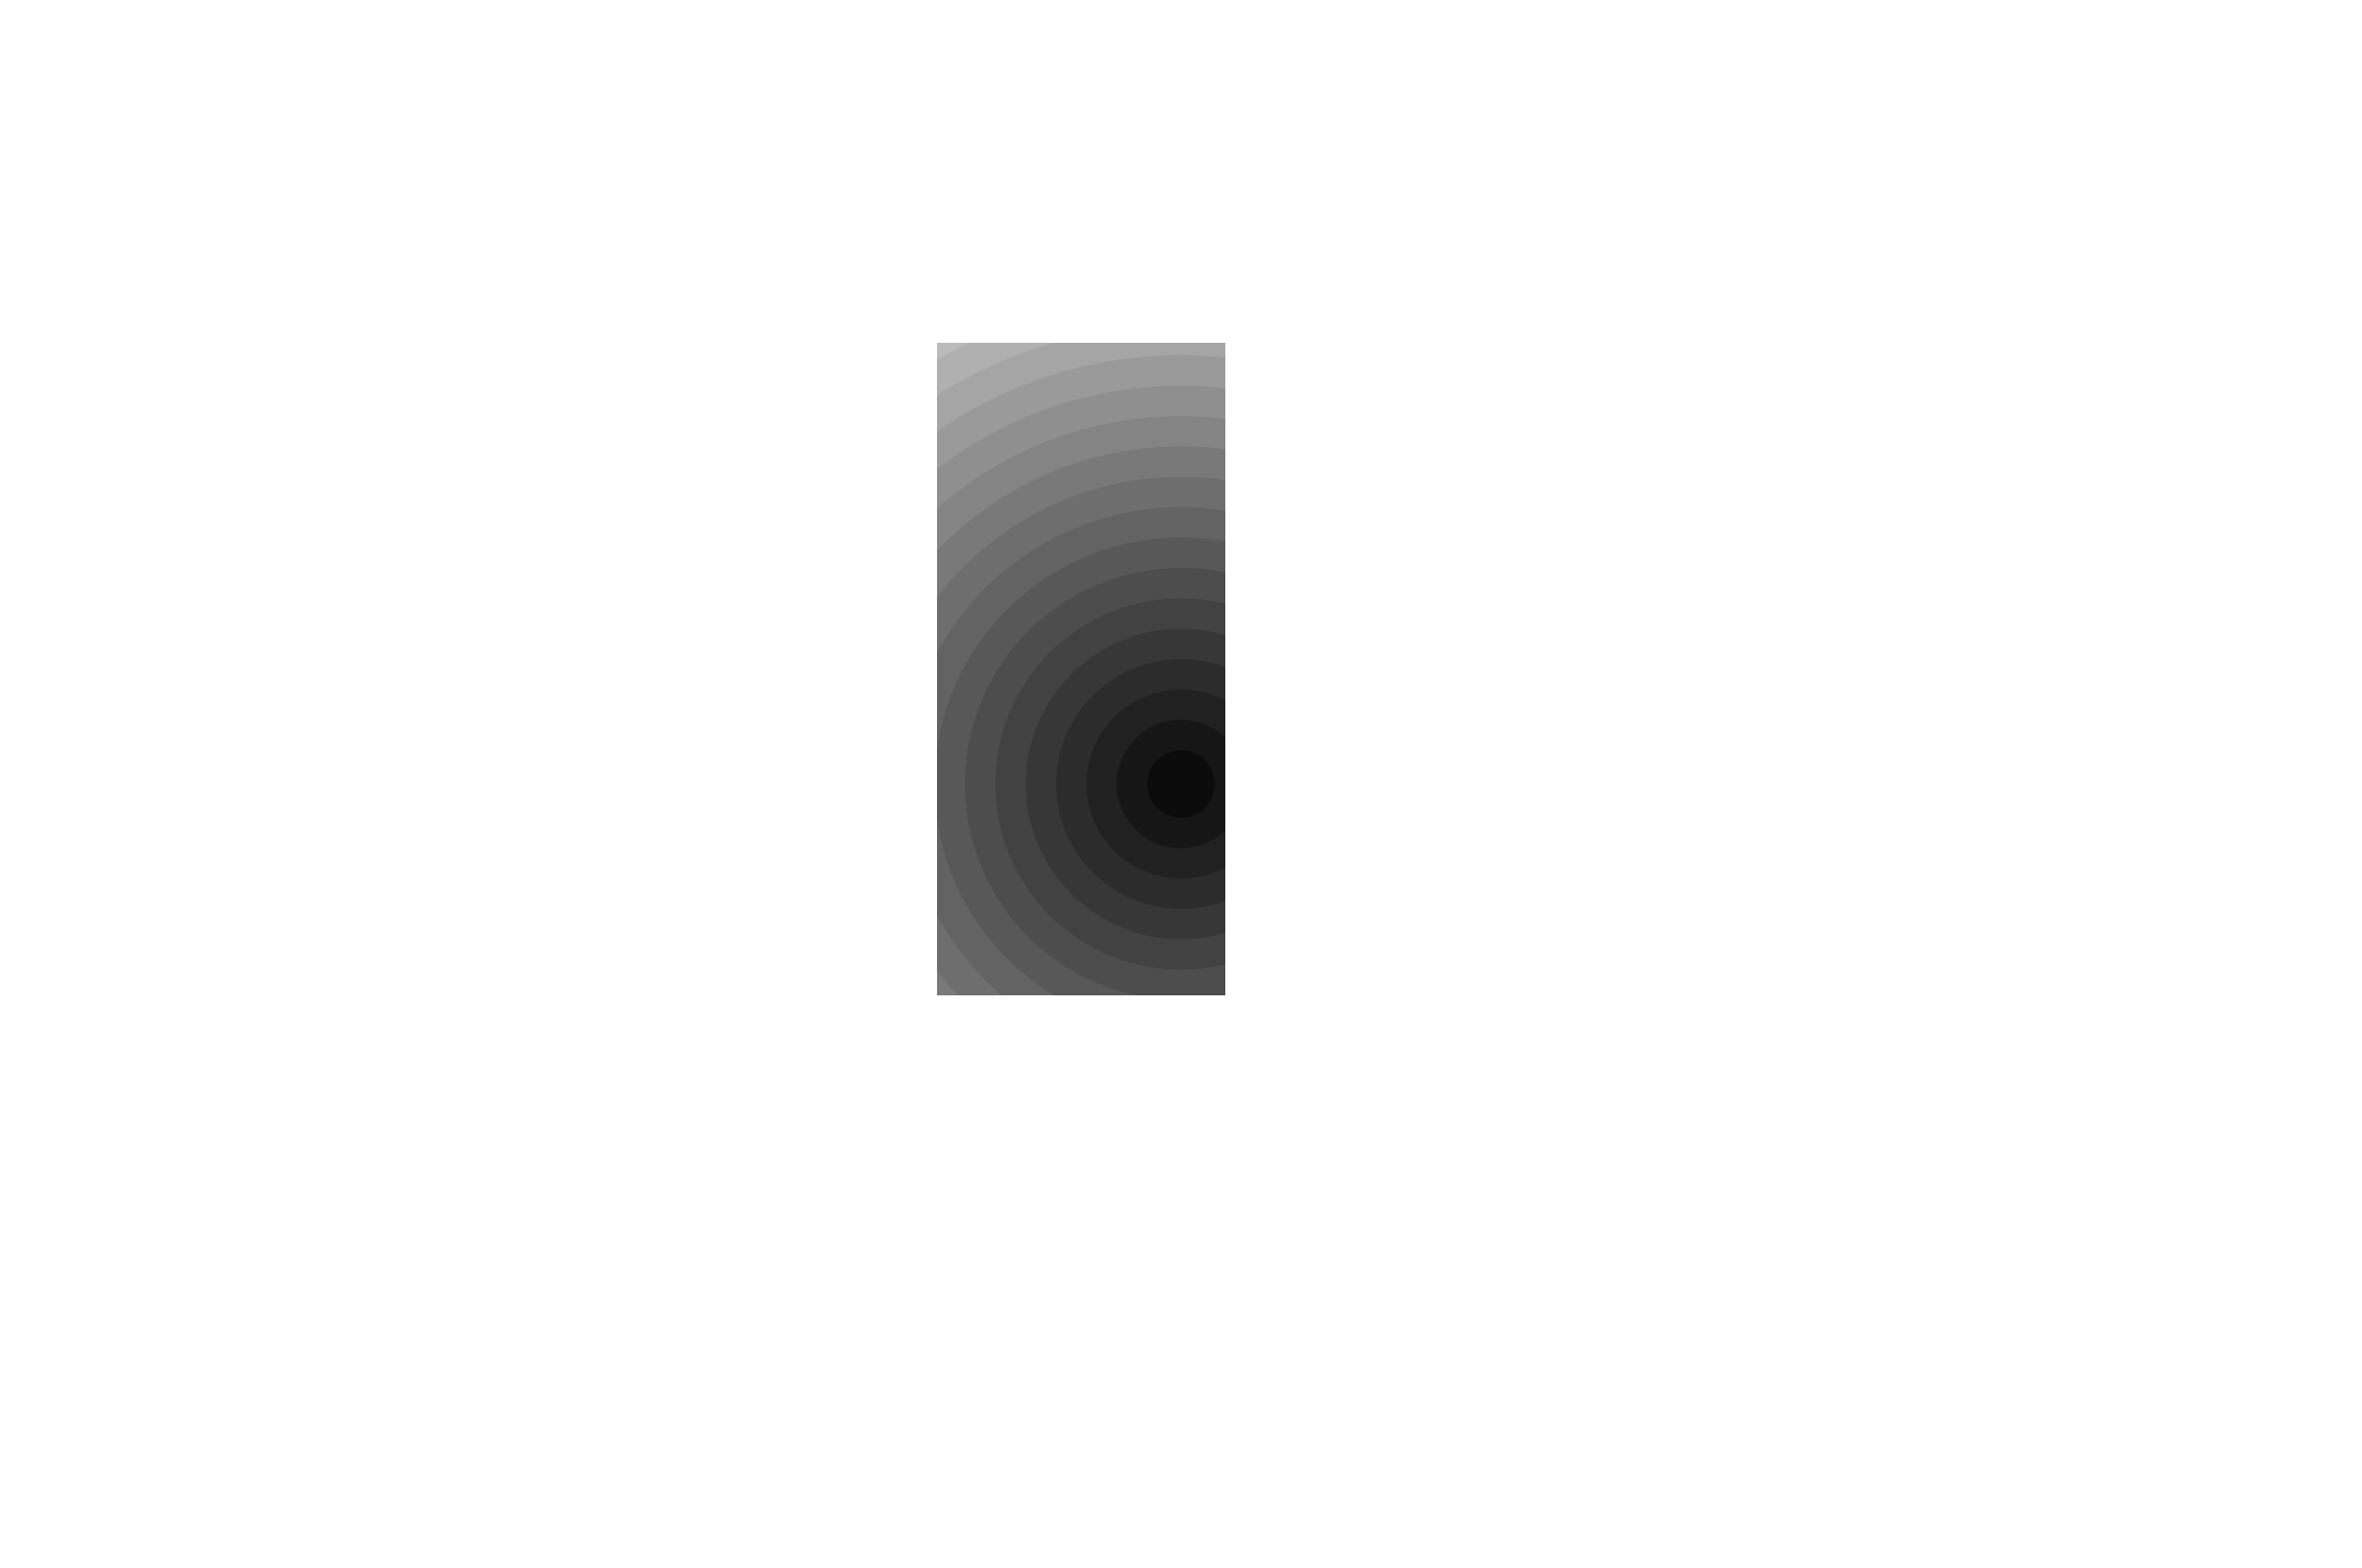

(0.2510965564957495, -0.2787120018960503)
Time                      1.61357e+09
RatX                         0.200356
RatY                        -0.190852
RatZ                         0.624877
BeaconX                      0.251097
BeaconY                     -0.278712
Visibility                          1
time_of_beacon_trigger    1.61357e+09
Beacon_group                        2
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 247, dtype: object
23
[    0 11730 25704 33207 42057 50745 60252 68298 64548 49335 38373 31533
 30120 29682 29364 21675  7545   792     0     0     0     0     0]
[11730 25704 33207 42057 50745 60252 68298 64548 49335 38373 31533 30120
 29682 29364 21675  7545   792]
[ 225.57692308  494.30769231  638.59615385  808.78846154  975.86538462
 1158.69230769 1313.42307692 1241.30769231  948.75        737.94230769
  606.40384615  579.23076923  570.80769231  564.69230769  416.82692308
  145.09615385 

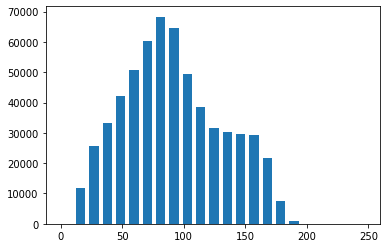

[0.03546462 0.00606909 0.         0.00247283 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
17
[0.03546462 0.00606909 0.         0.00247283 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
11


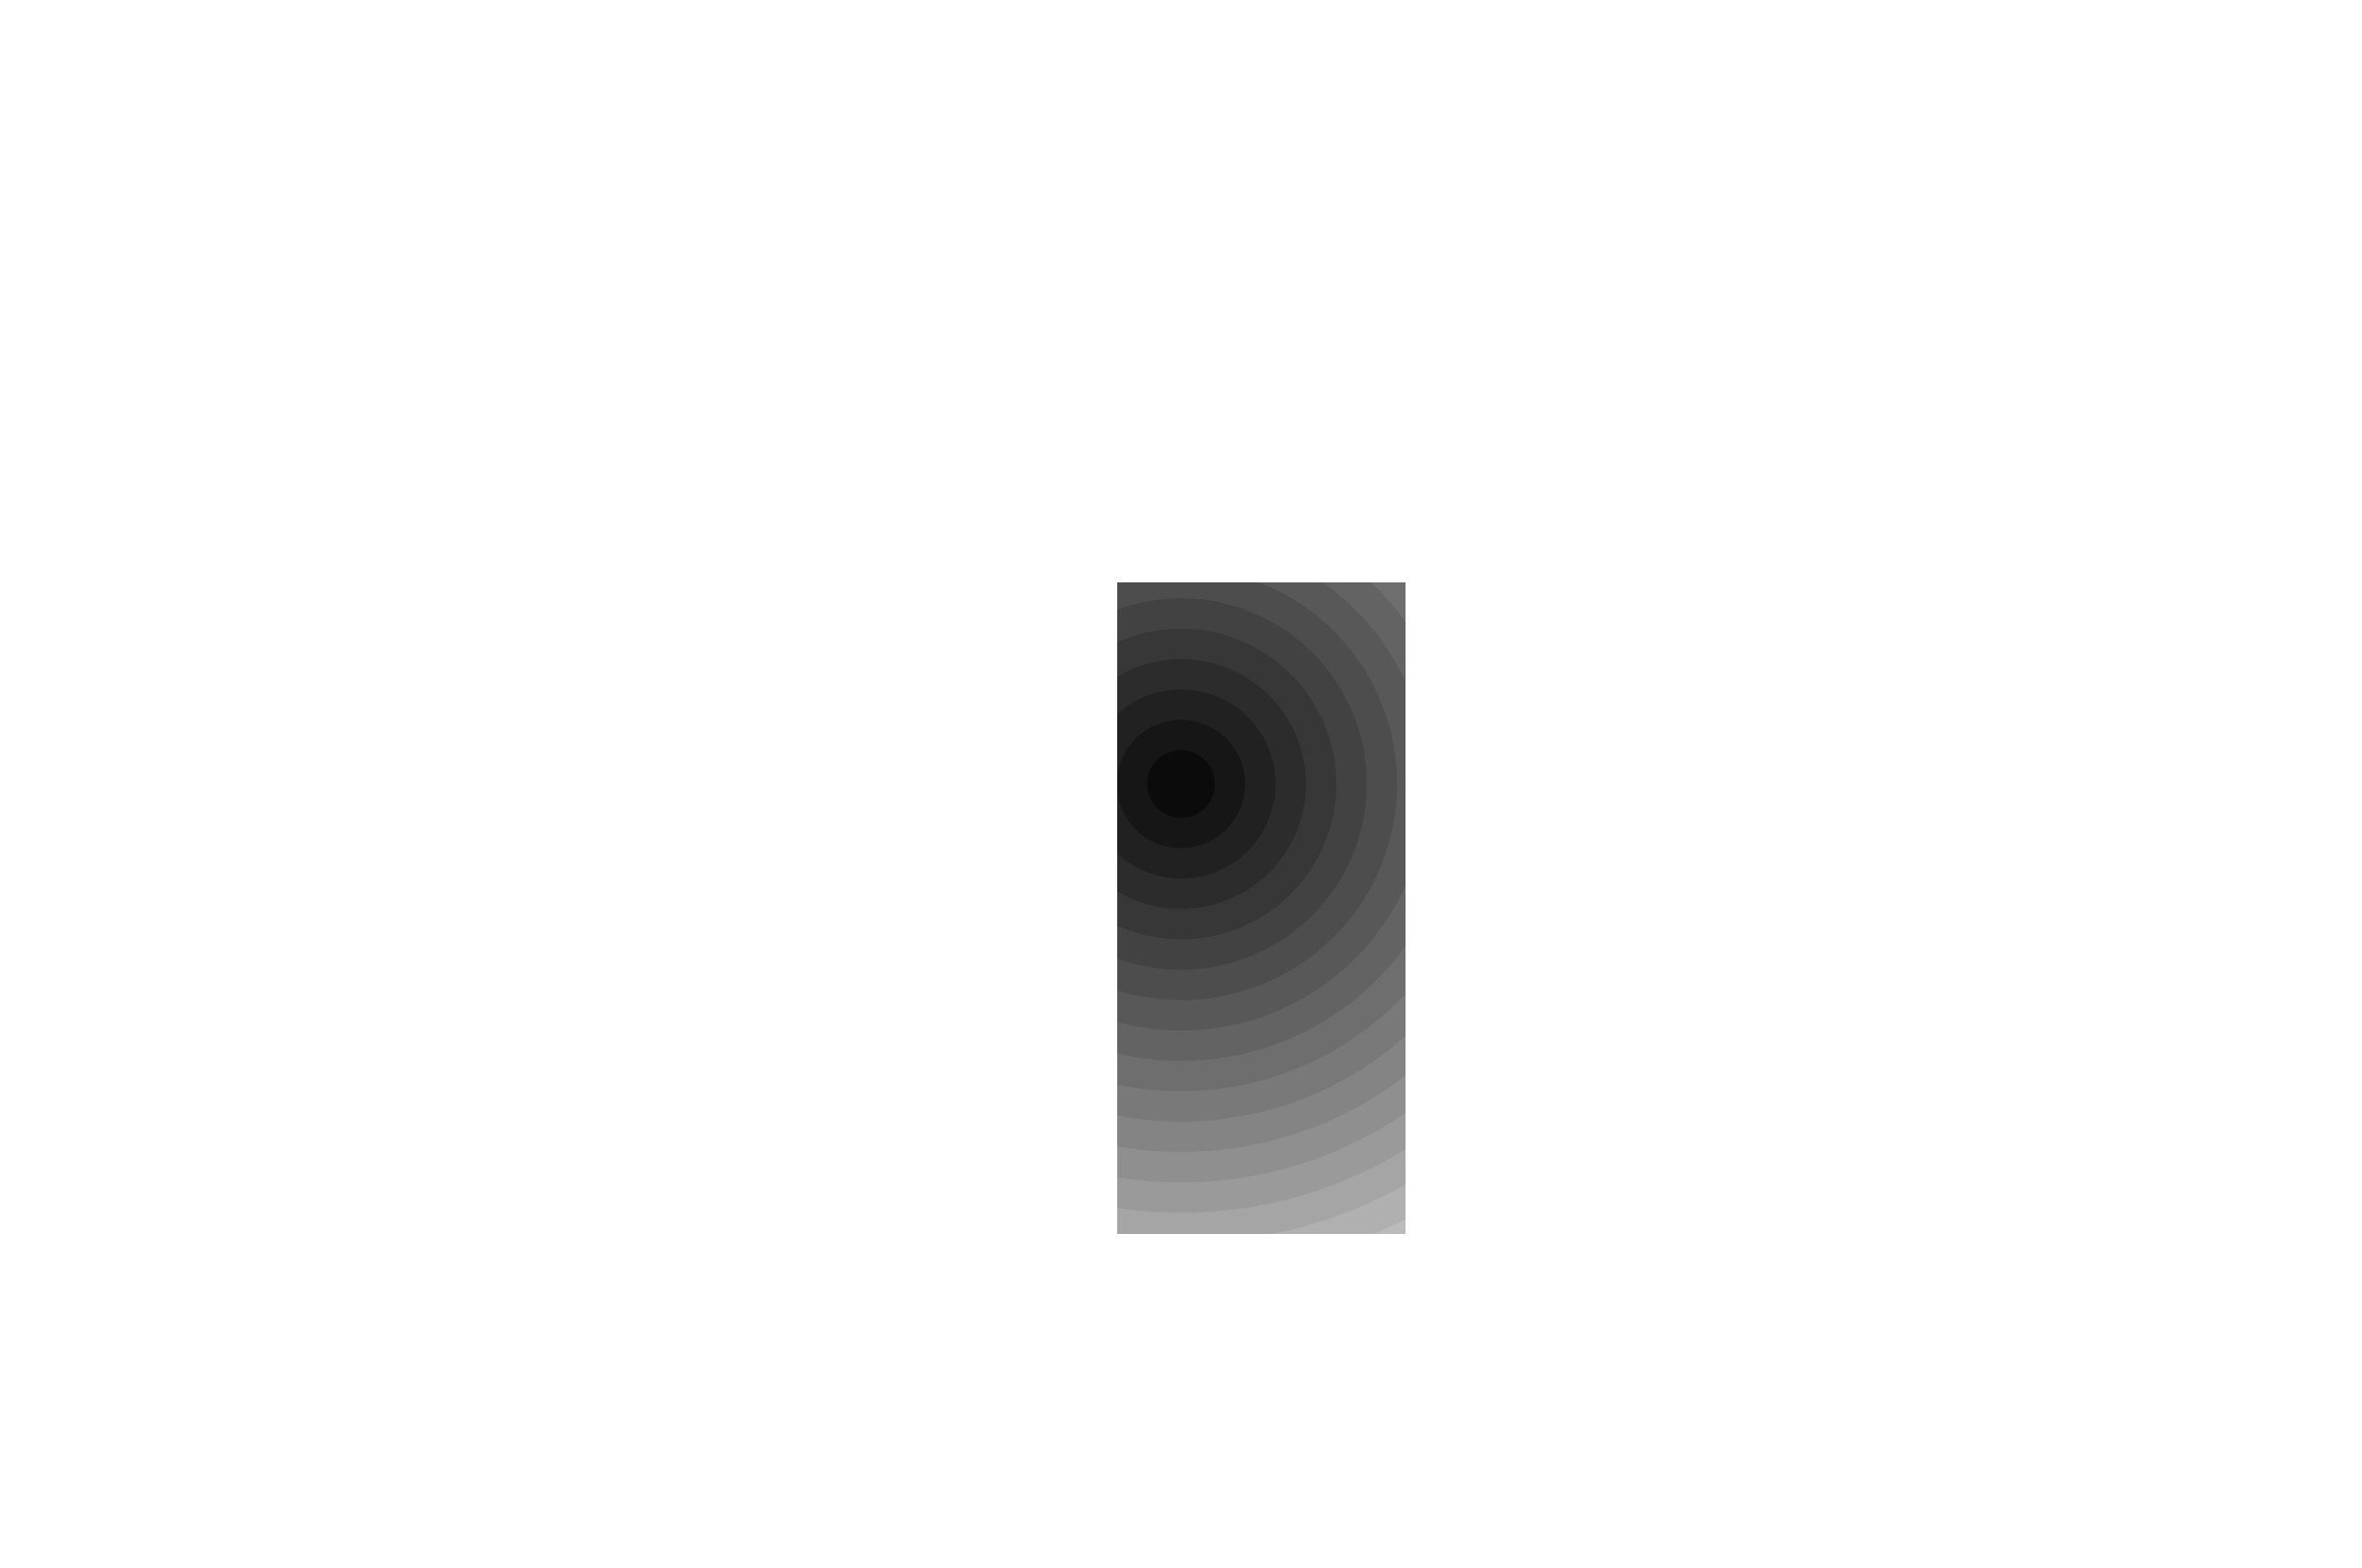

(-0.1932983374700736, 0.3114686491348659)
Time                      1.61357e+09
RatX                        -0.182514
RatY                         0.230592
RatZ                         0.626048
BeaconX                     -0.193298
BeaconY                      0.311469
Visibility                          1
time_of_beacon_trigger    1.61357e+09
Beacon_group                        3
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 272, dtype: object
23
[    0 11730 29880 38643 46371 54780 64206 68358 54984 40788 32760 29943
 29520 29196 28992 25281  7941   699     0     0     0     0     0]
[11730 29880 38643 46371 54780 64206 68358 54984 40788 32760 29943 29520
 29196 28992 25281  7941   699]
[ 225.57692308  574.61538462  743.13461538  891.75       1053.46153846
 1234.73076923 1314.57692308 1057.38461538  784.38461538  630.
  575.82692308  567.69230769  561.46153846  557.53846154  486.17307692
  152.71153846   13.442

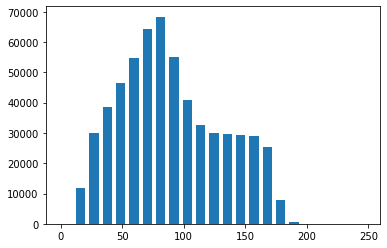

[0.03546462 0.00870147 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
17
[0.03546462 0.00870147 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
12


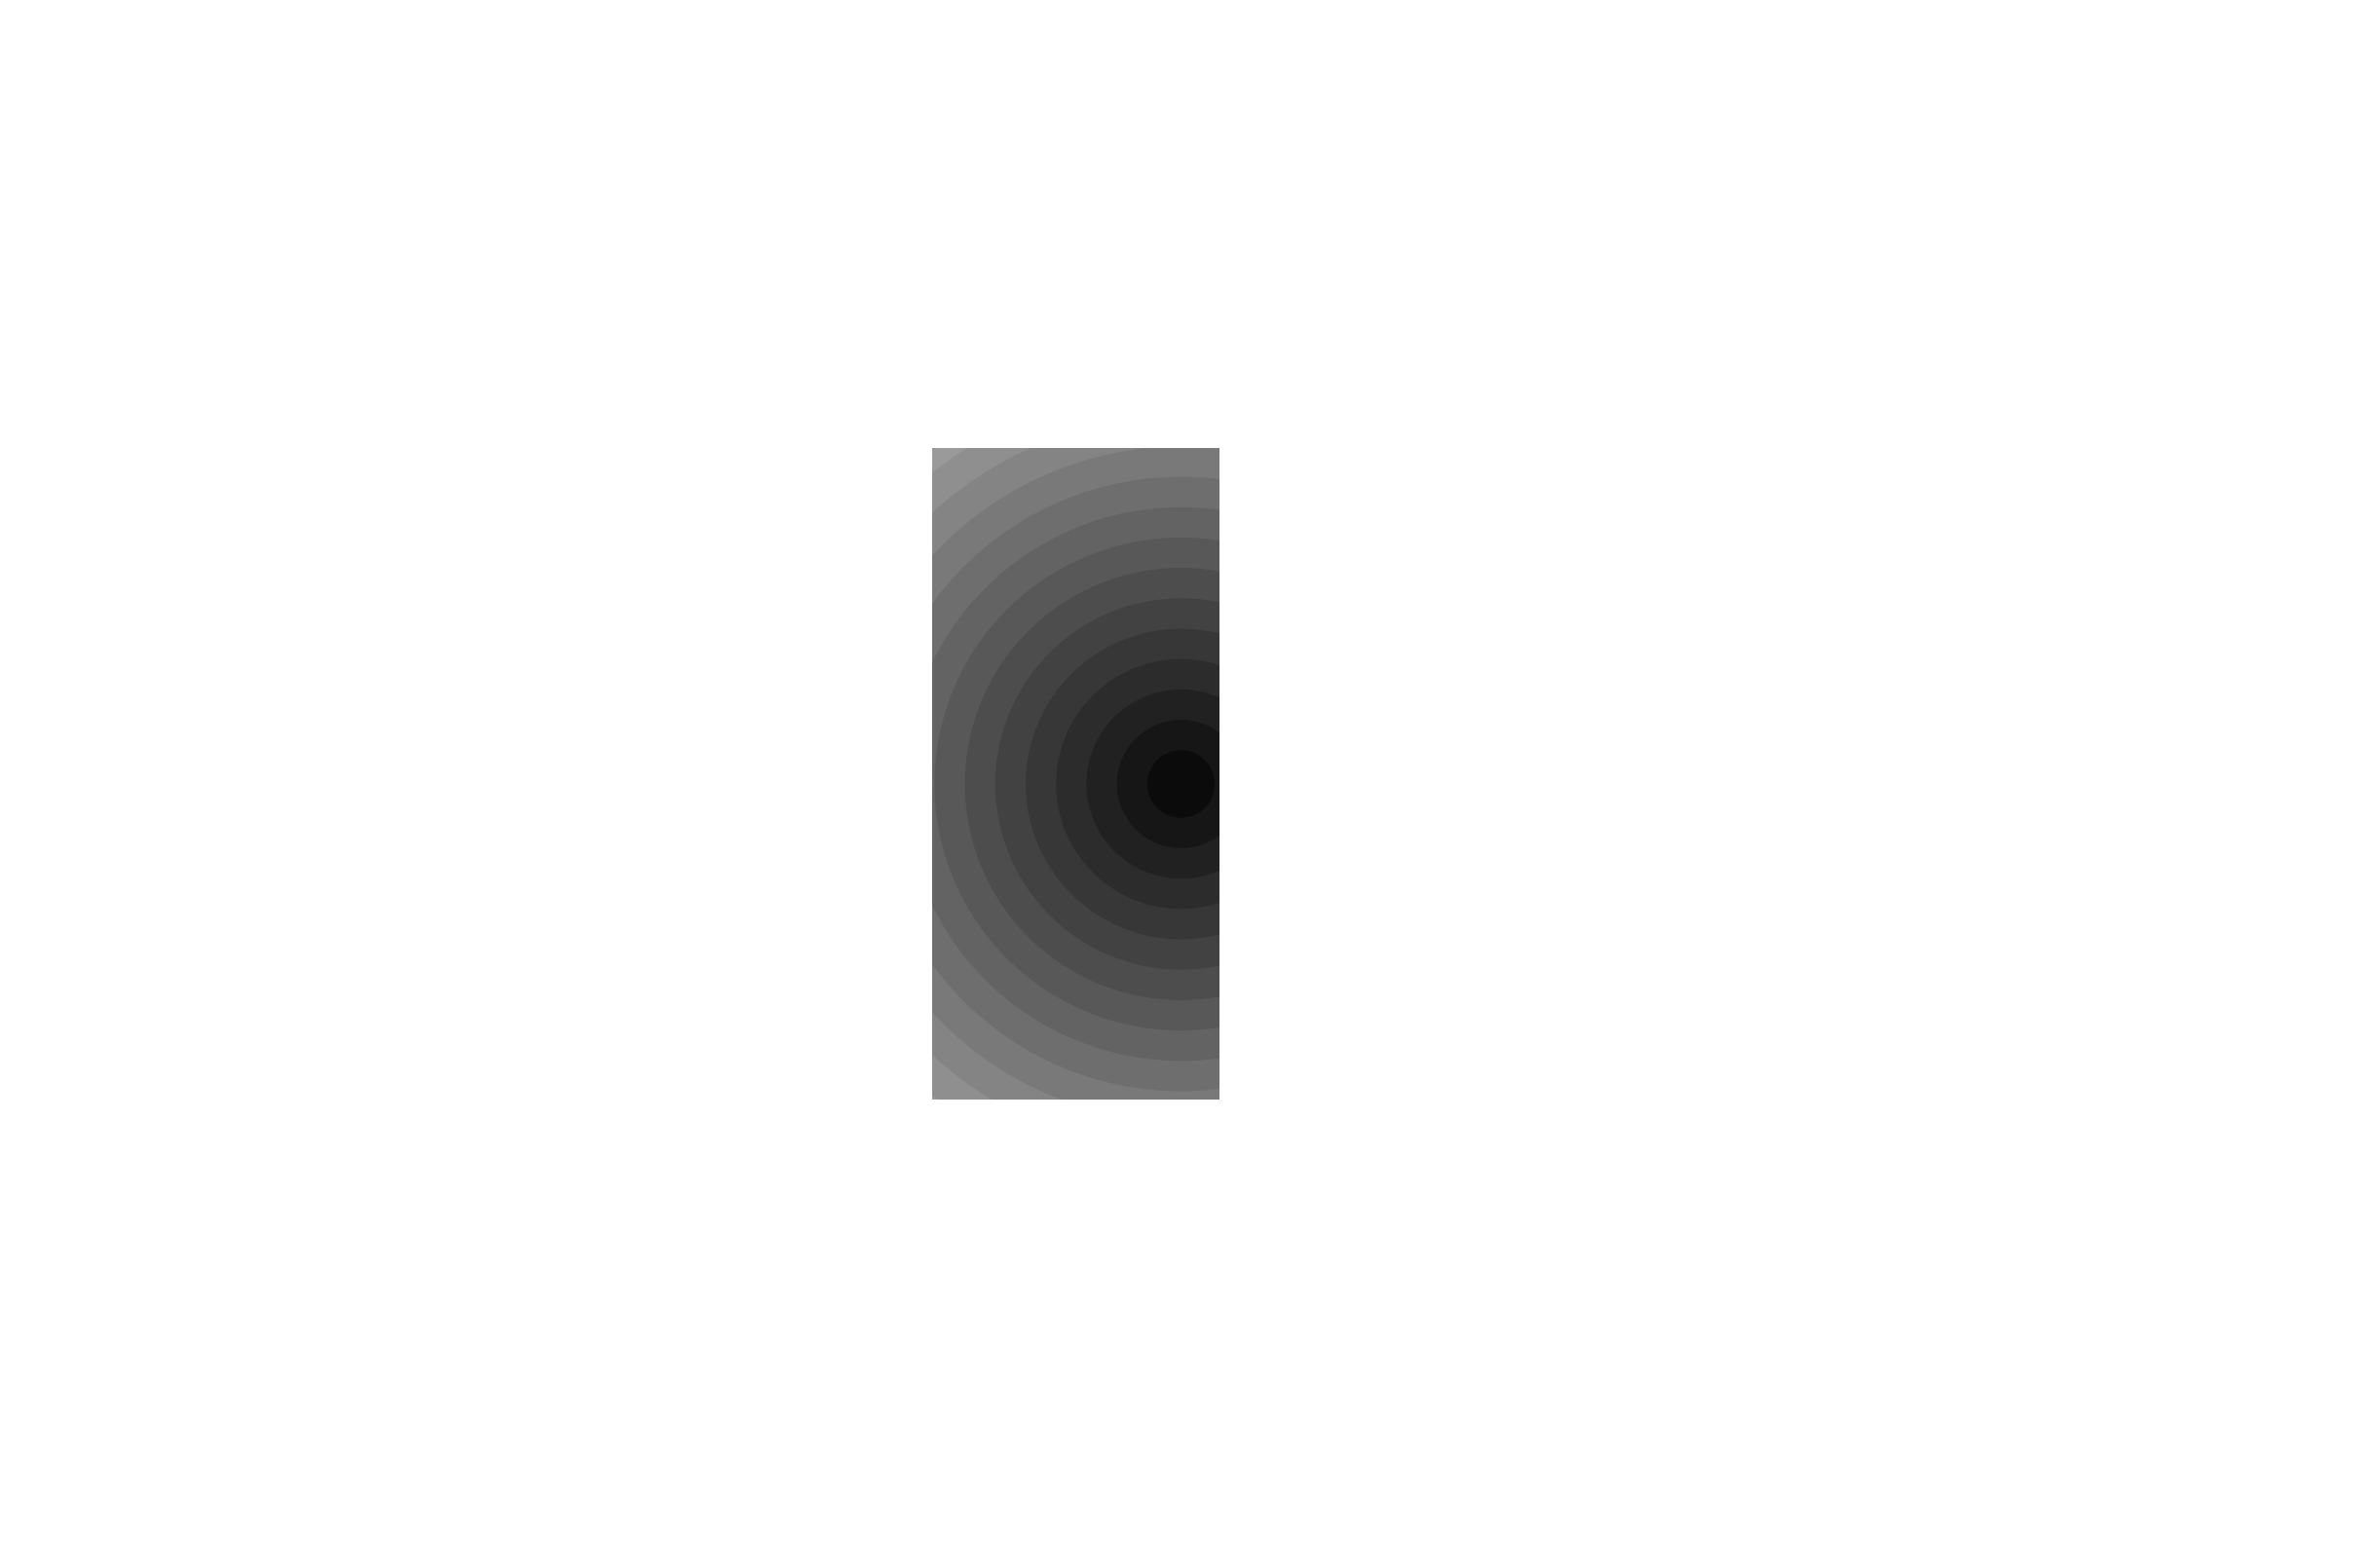

(0.2653548283209731, -0.0204507783846638)
Time                      1.61357e+09
RatX                        -0.247777
RatY                      -0.00928028
RatZ                         0.620546
BeaconX                      0.265355
BeaconY                    -0.0204508
Visibility                          1
time_of_beacon_trigger    1.61357e+09
Beacon_group                        4
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 304, dtype: object
23
[    0 11730 23862 31881 40845 49581 59088 68157 77316 71853 64701 53223
 27147 11370  1311     0     0     0     0     0     0     0     0]
[11730 23862 31881 40845 49581 59088 68157 77316 71853 64701 53223 27147
 11370  1311]
[ 225.57692308  458.88461538  613.09615385  785.48076923  953.48076923
 1136.30769231 1310.71153846 1486.84615385 1381.78846154 1244.25
 1023.51923077  522.05769231  218.65384615   25.21153846]
14
23
[11  7  5  0  0  0  1  0  1  0  2  0  0  0]
14

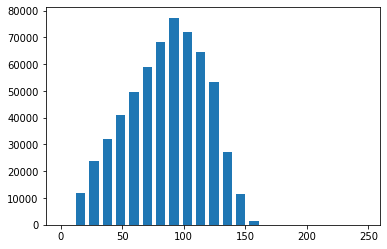

[0.04876385 0.01525438 0.00815533 0.         0.         0.
 0.00076294 0.         0.0007237  0.         0.00195404 0.
 0.         0.        ]
14
[0.04876385 0.01525438 0.00815533 0.         0.         0.
 0.00076294 0.         0.0007237  0.         0.00195404 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
13


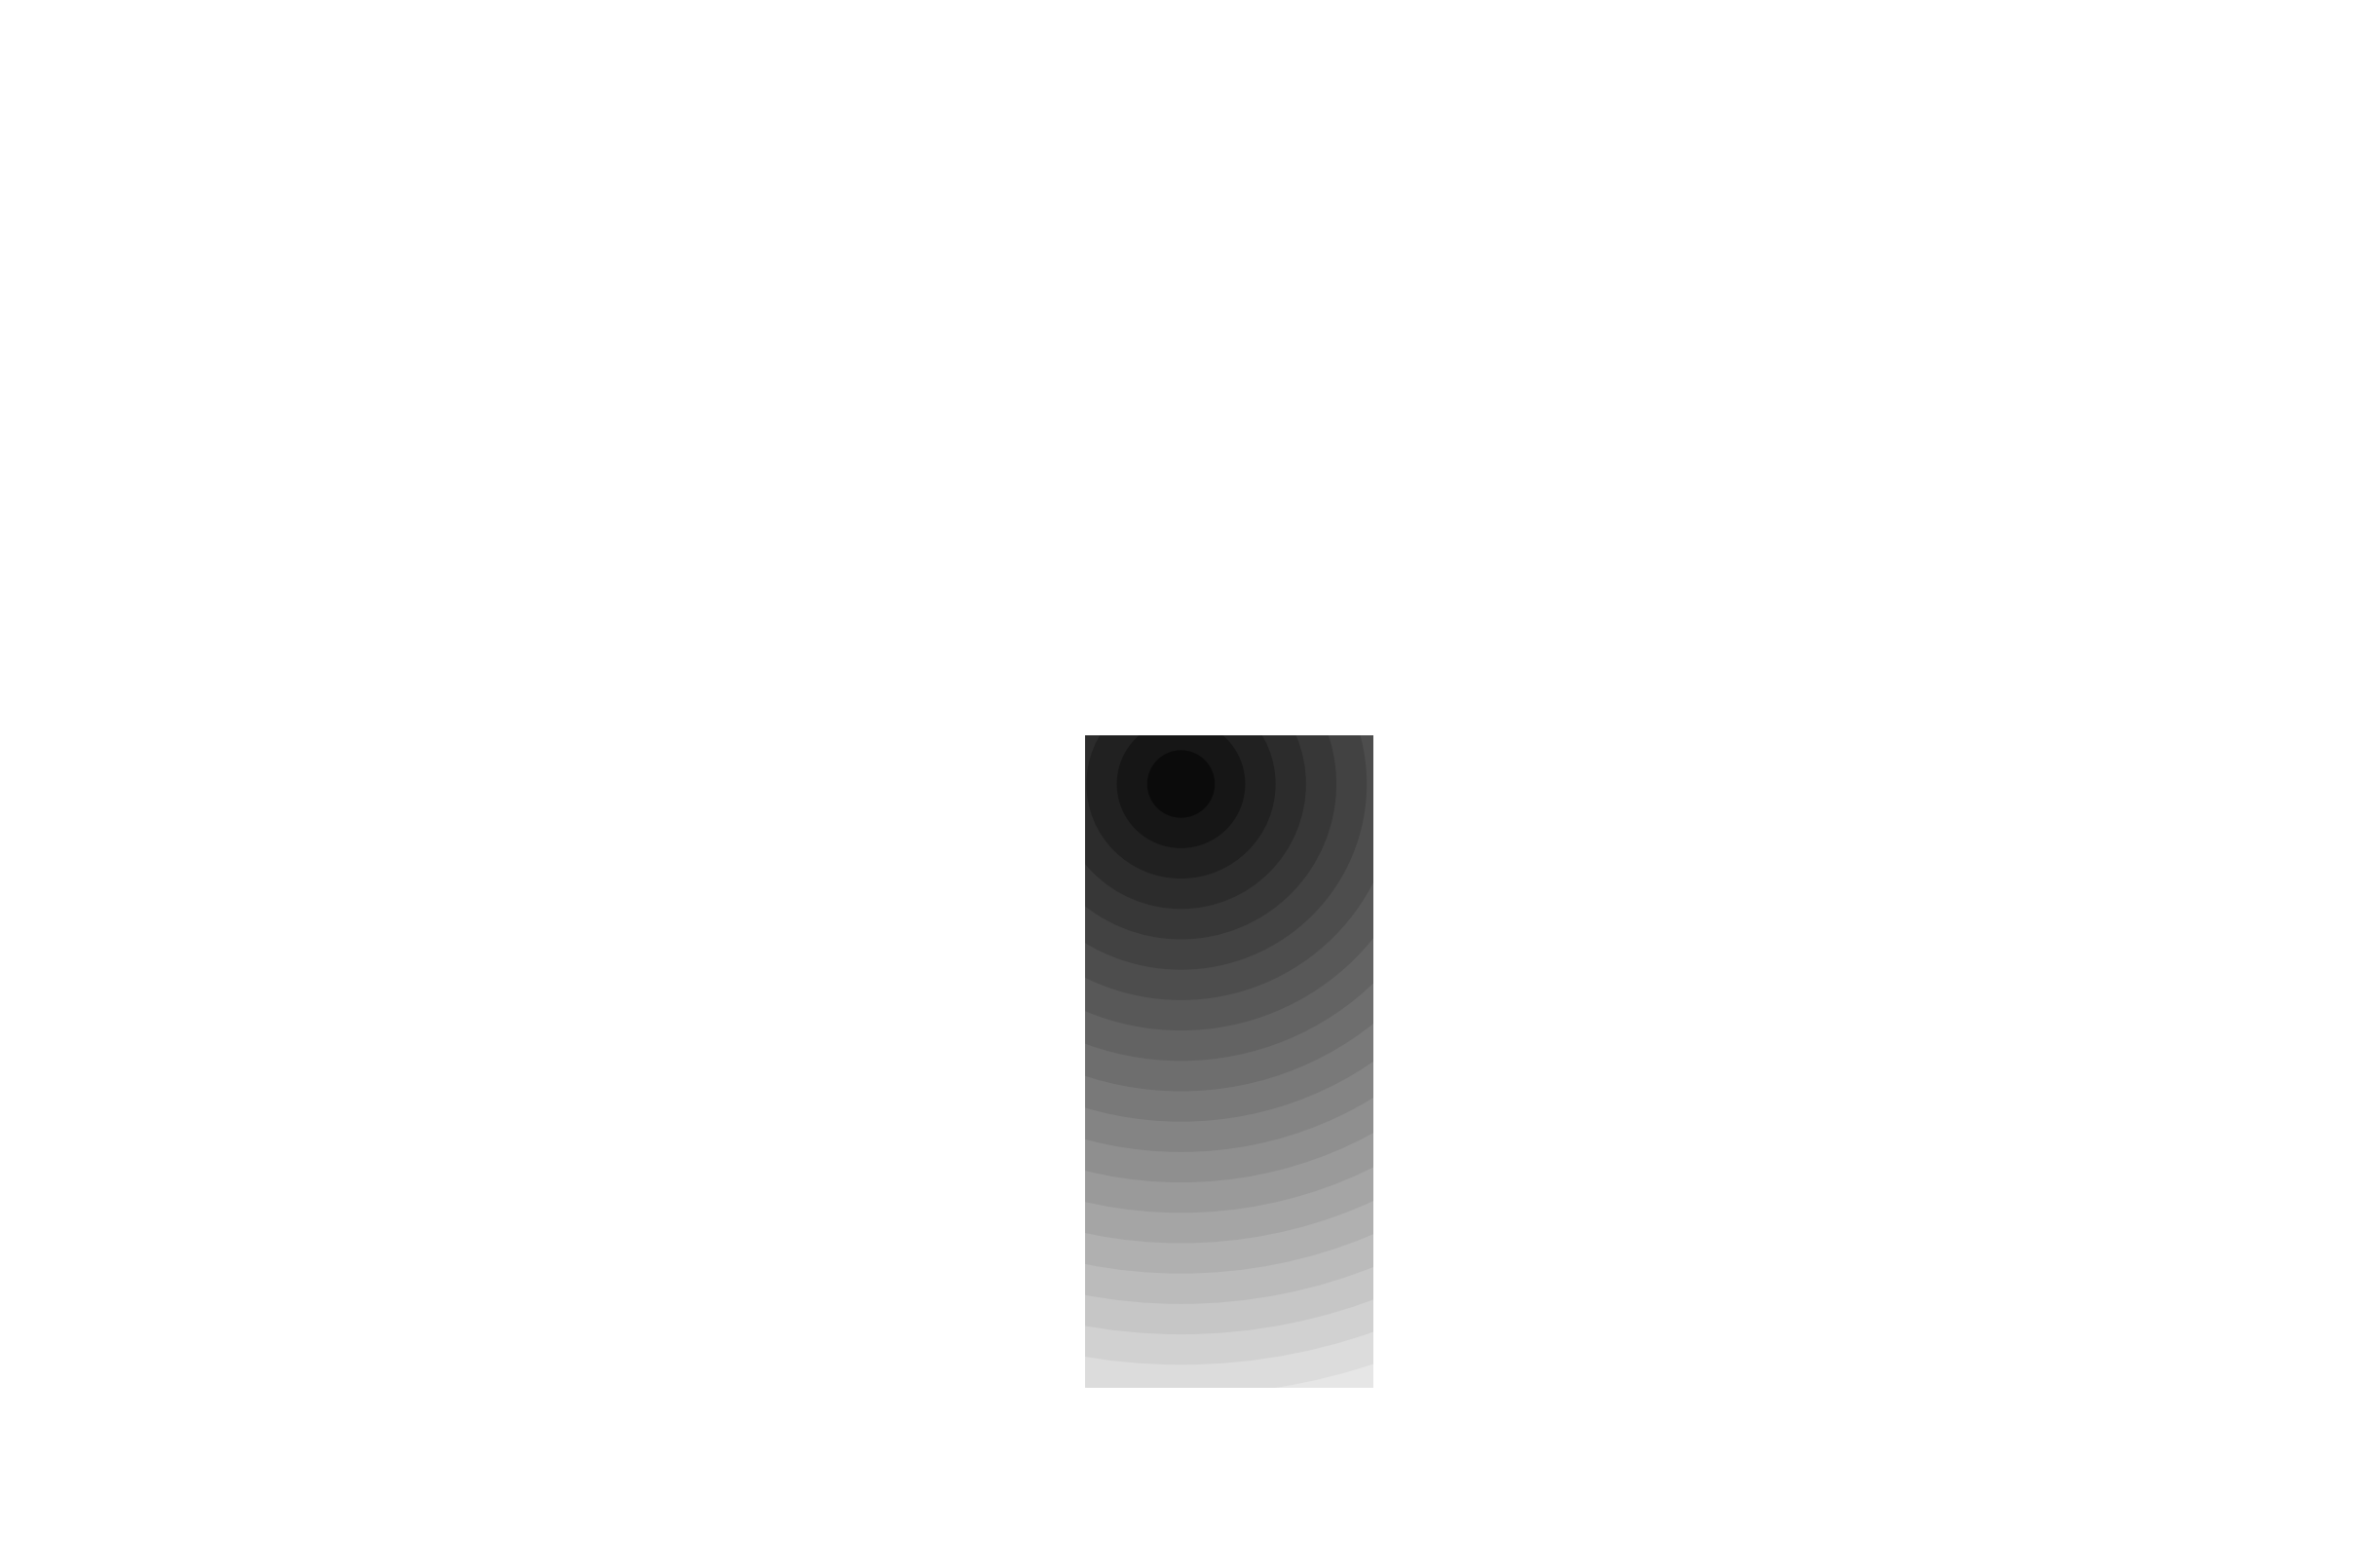

(-0.114329198532909, 0.6893431975694125)
Time                      1.61357e+09
RatX                        -0.275239
RatY                         0.168619
RatZ                         0.620009
BeaconX                     -0.114329
BeaconY                      0.689343
Visibility                          1
time_of_beacon_trigger    1.61357e+09
Beacon_group                        5
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 327, dtype: object
23
[    0 11730 26958 34230 33762 35907 40374 36159 31350 30252 29574 29088
 28848 28680 28560 28419 28299 28161 28158 28089 25173  3189     0]
[11730 26958 34230 33762 35907 40374 36159 31350 30252 29574 29088 28848
 28680 28560 28419 28299 28161 28158 28089 25173  3189]
[225.57692308 518.42307692 658.26923077 649.26923077 690.51923077
 776.42307692 695.36538462 602.88461538 581.76923077 568.73076923
 559.38461538 554.76923077 551.53846154 549.23076923 546.51923077
 544.21

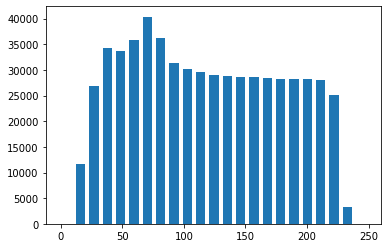

[0.03546462 0.00578678 0.00151914 0.         0.         0.
 0.         0.00165869 0.00171889 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
21
[0.03546462 0.00578678 0.00151914 0.         0.         0.
 0.         0.00165869 0.00171889 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
14


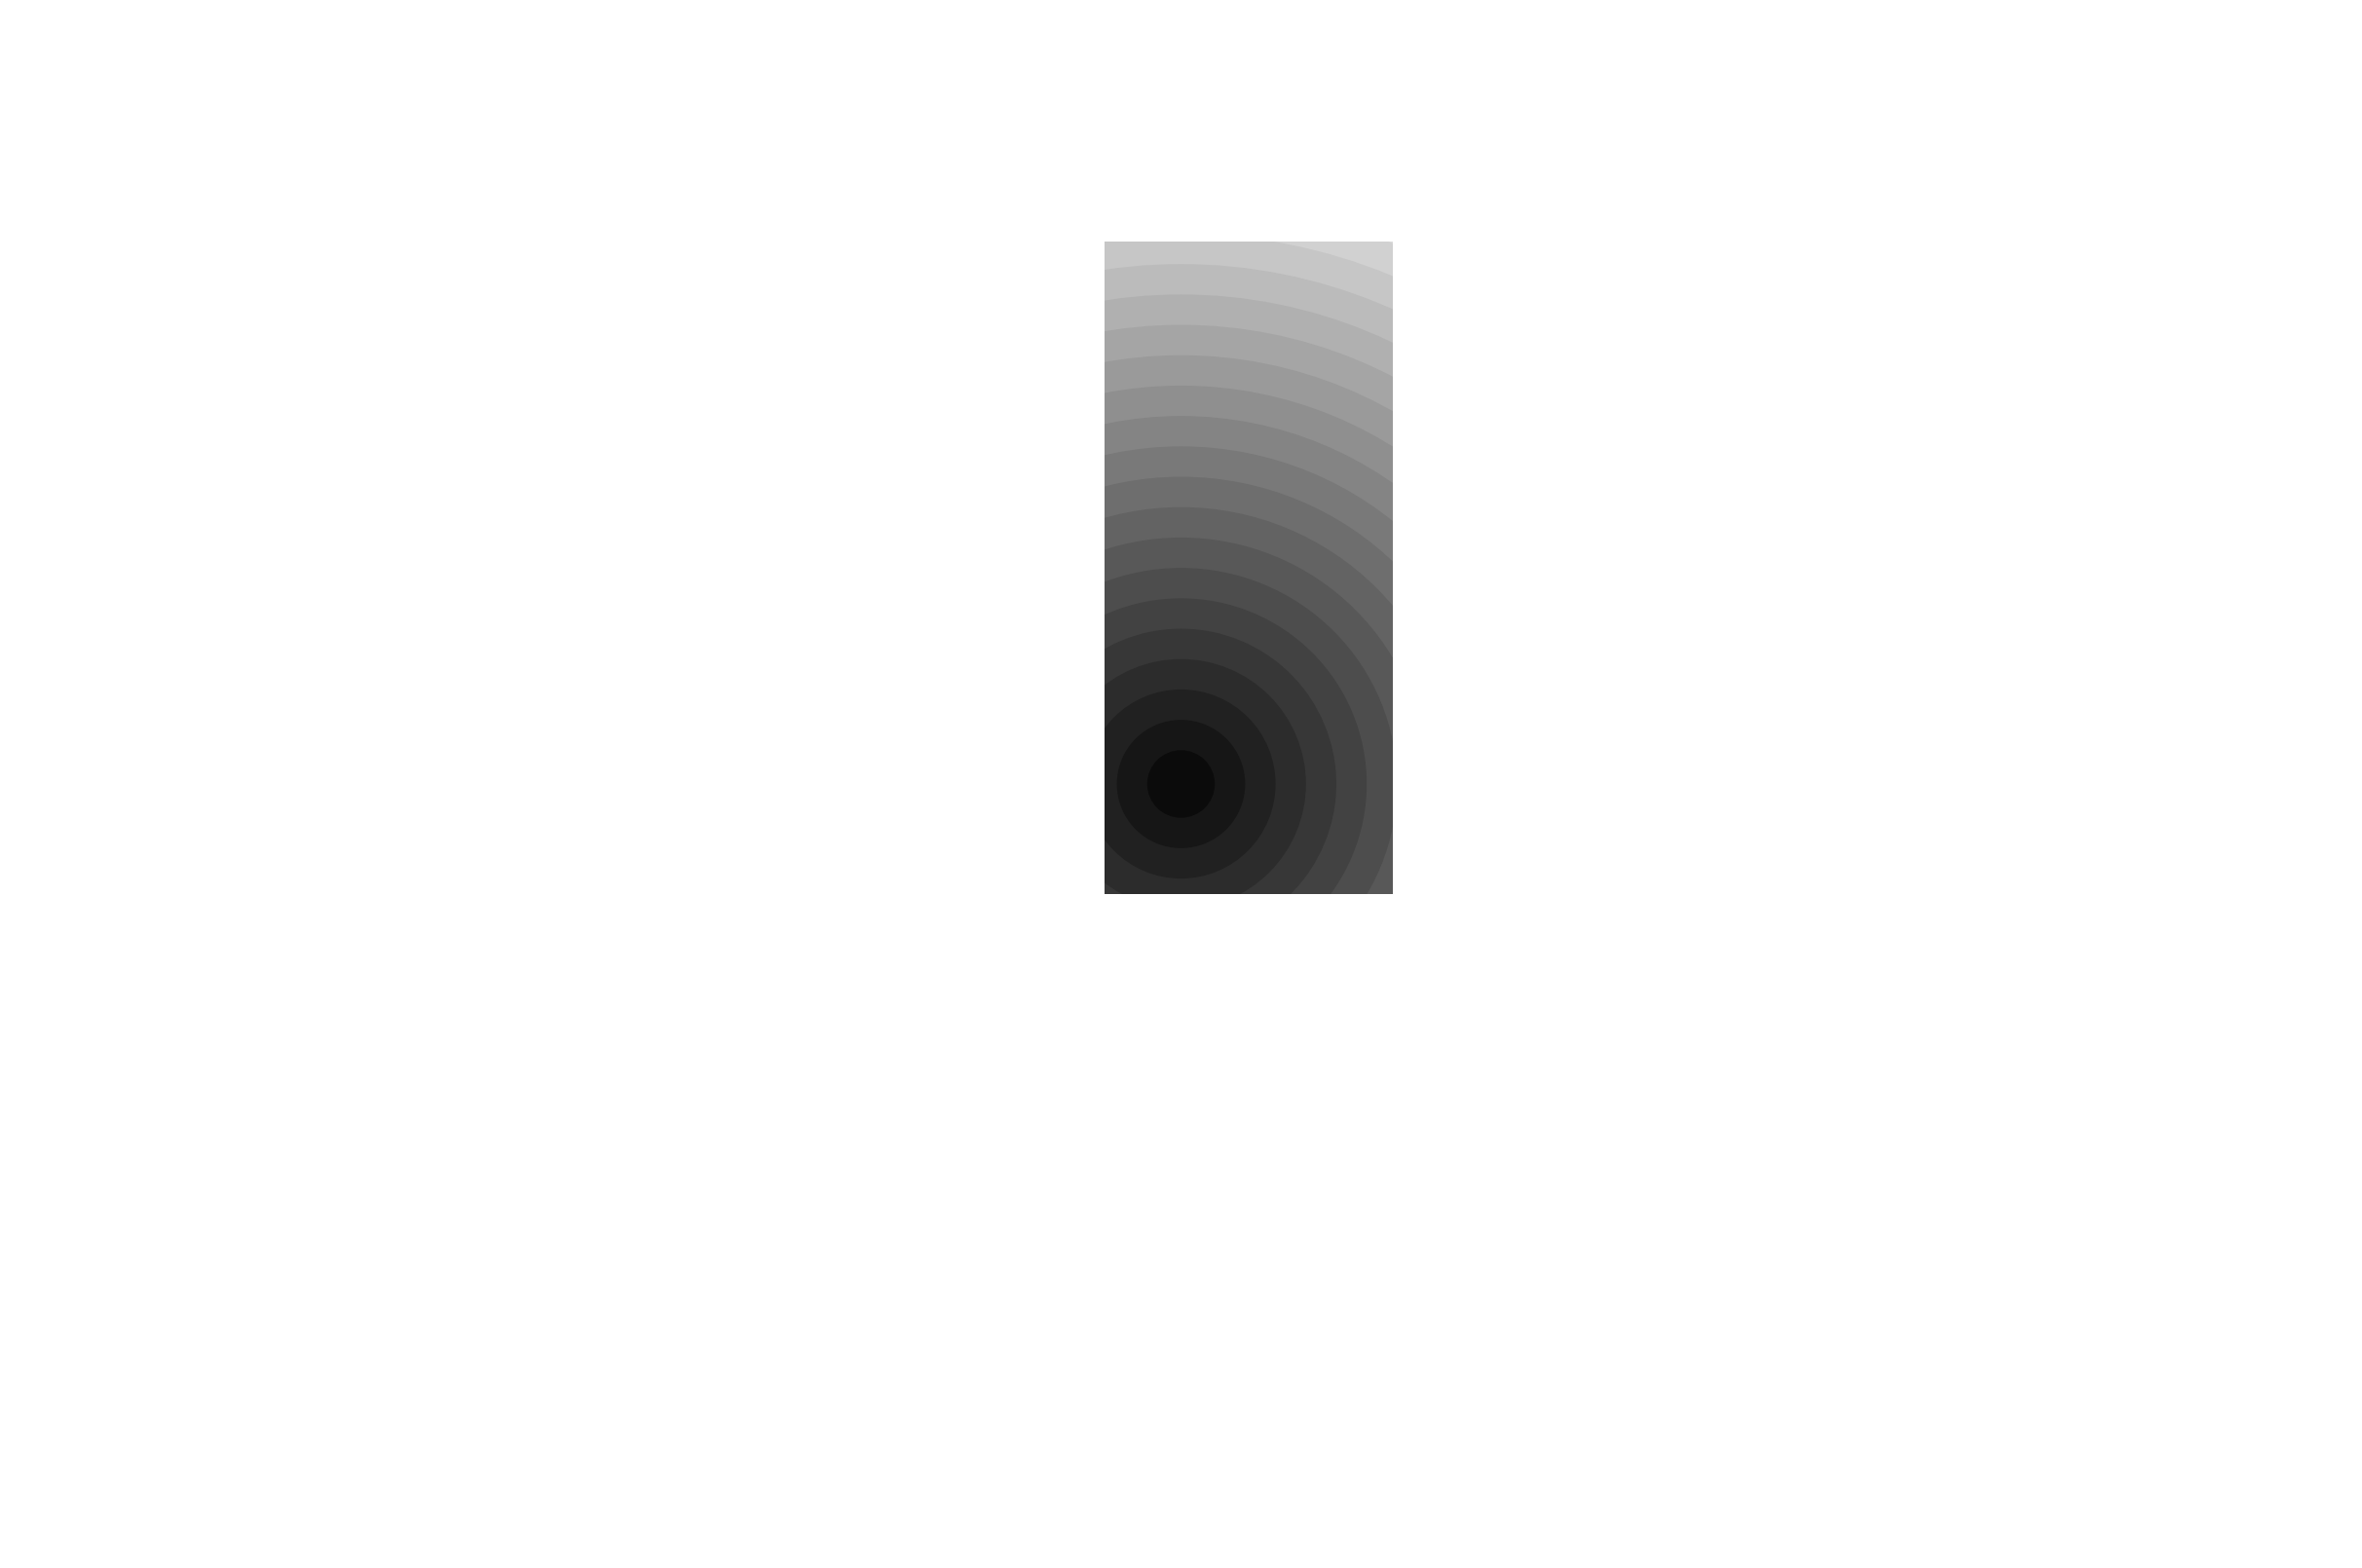

(-0.161819261454925, -0.5287954870929873)
Time                      1.61383e+09
RatX                        -0.185483
RatY                        -0.594544
RatZ                         0.622462
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.61383e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 330, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e

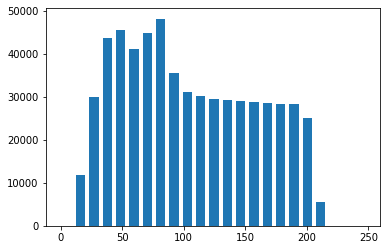

[0.00443308 0.00173785 0.         0.         0.         0.
 0.         0.00146162 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.00443308 0.00173785 0.         0.         0.         0.
 0.         0.00146162 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
15


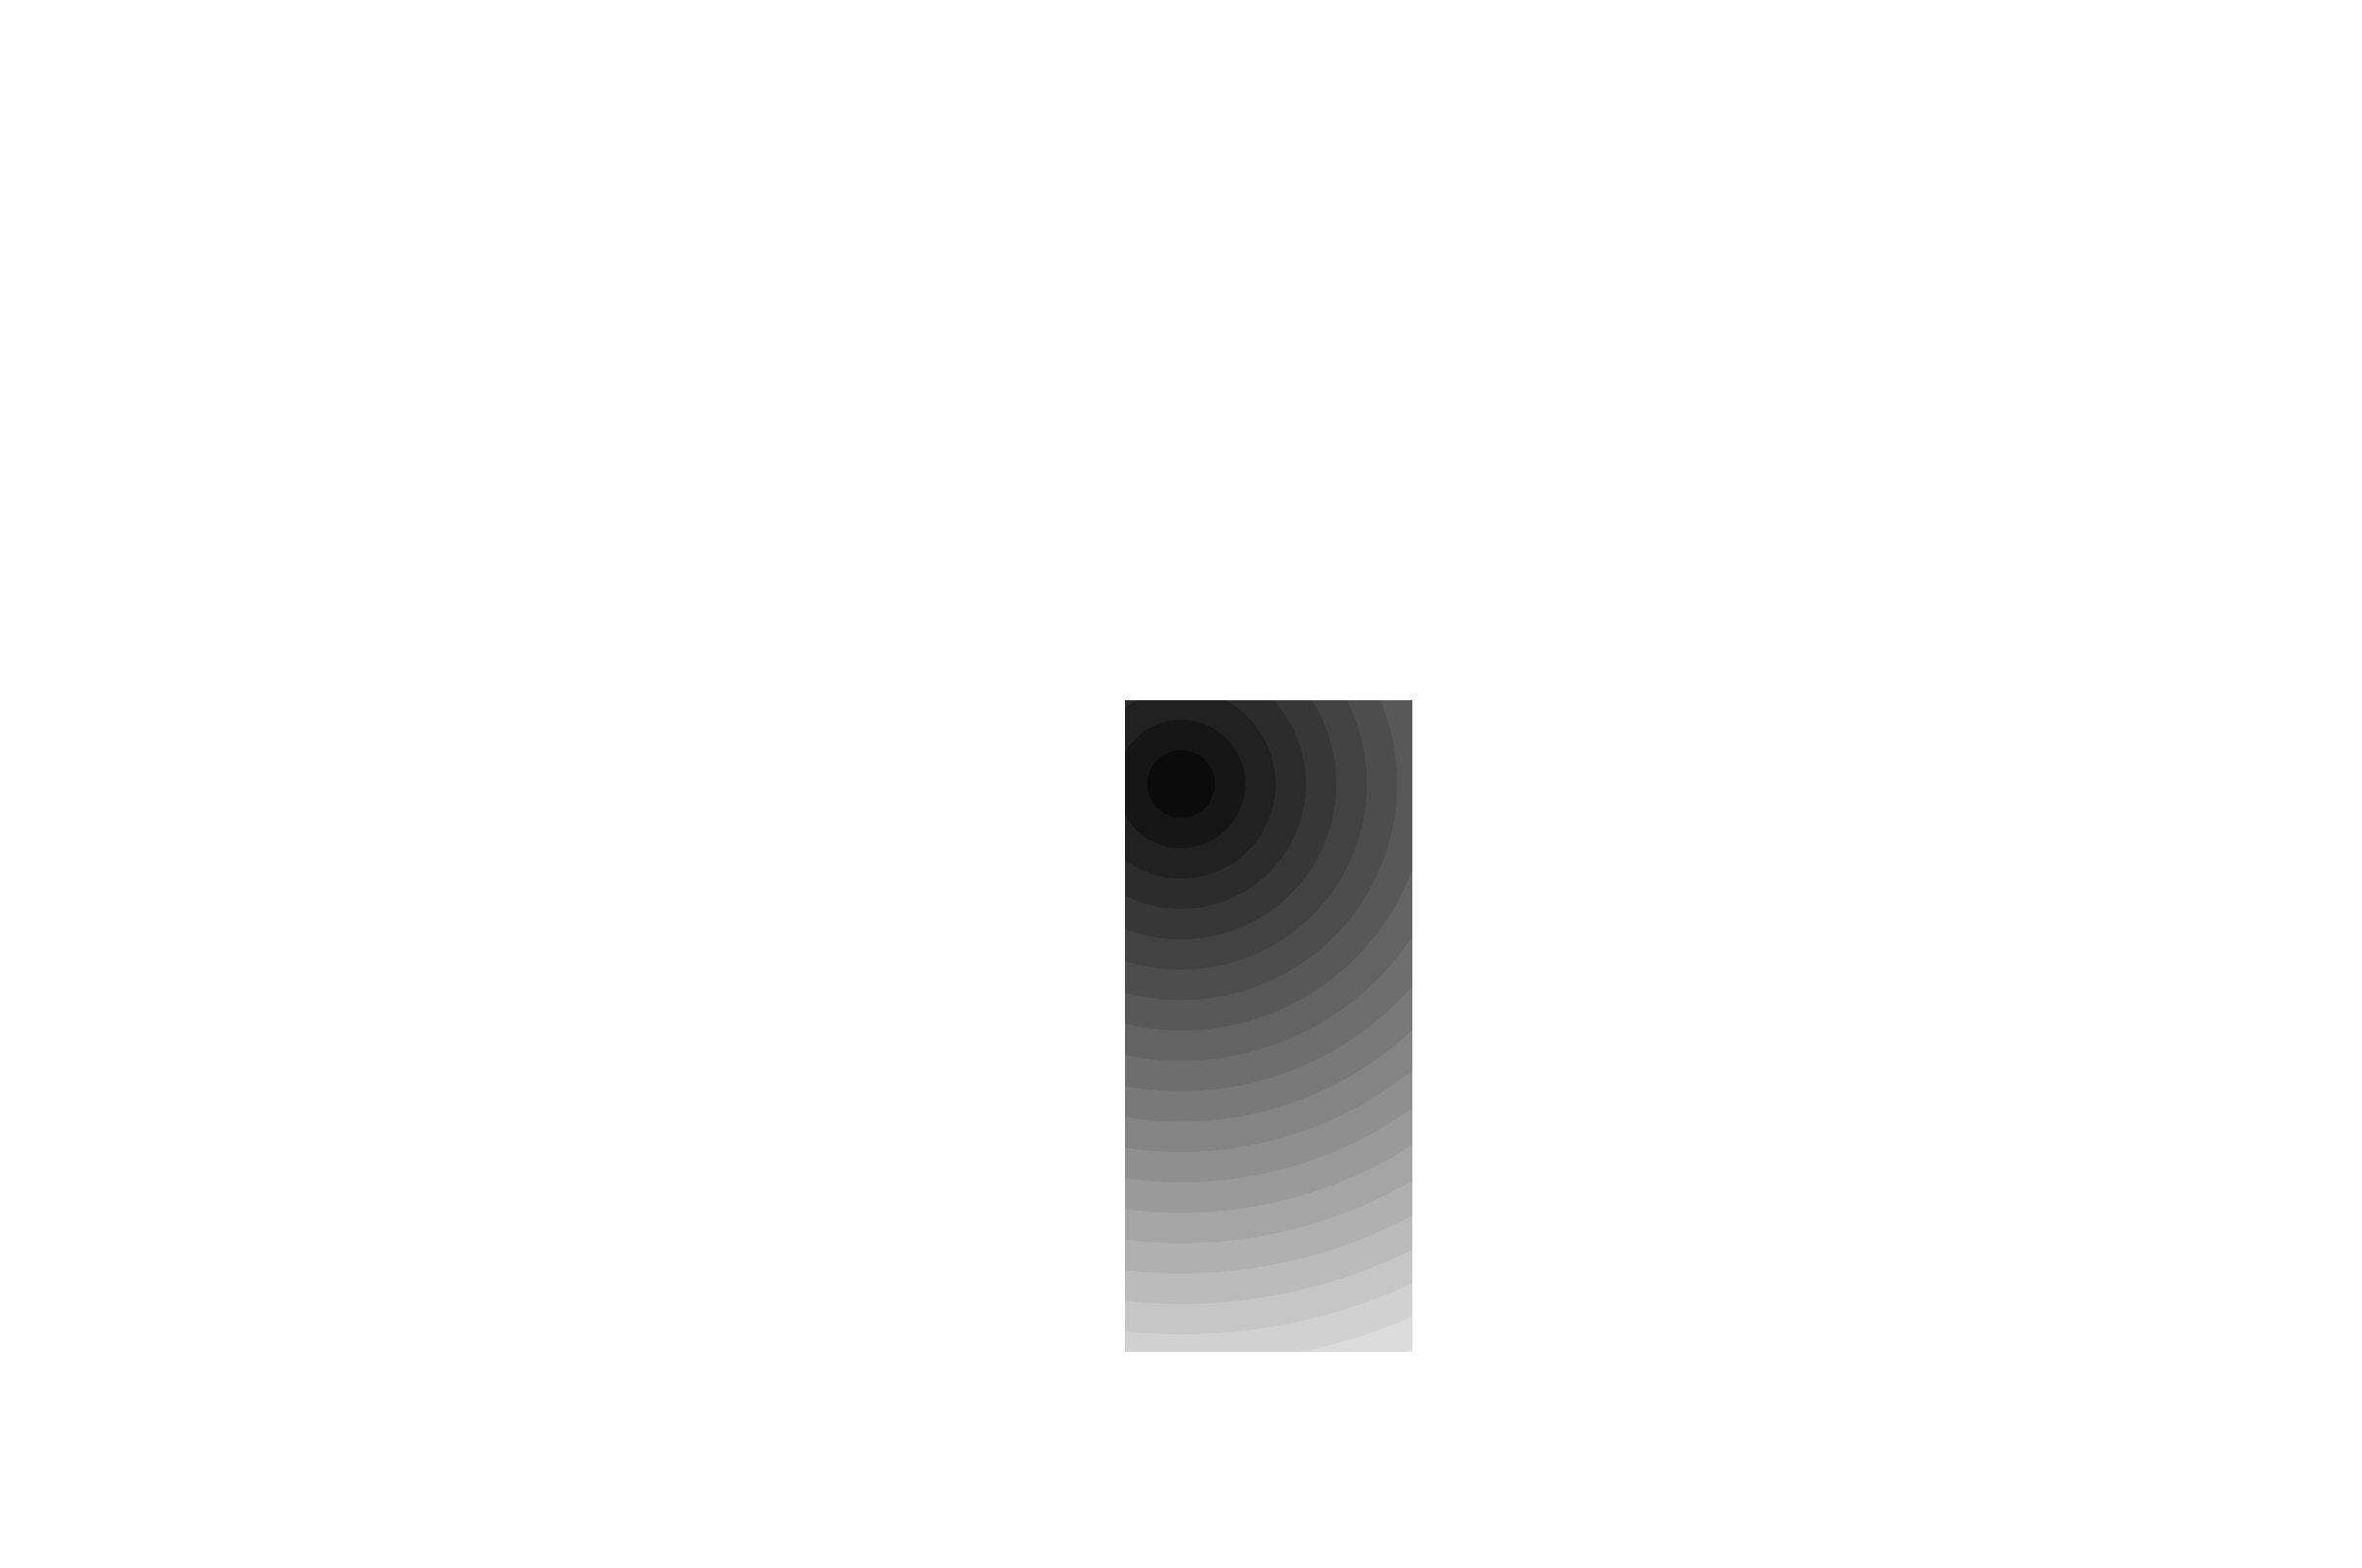

(-0.2107965418519322, 0.6021616526301563)
Time                      1.61383e+09
RatX                       -0.0195343
RatY                        -0.709012
RatZ                         0.620361
BeaconX                     -0.210797
BeaconY                      0.602162
Visibility                          1
time_of_beacon_trigger    1.61383e+09
Beacon_group                        2
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 358, dtype: object
23
[    0 11730 28704 33978 31593 35133 39732 44115 42939 32811 31080 30102
 29622 29256 29016 28788 28596 28407 28359 22755  5334    15     0]
[11730 28704 33978 31593 35133 39732 44115 42939 32811 31080 30102 29622
 29256 29016 28788 28596 28407 28359 22755  5334    15]
[2.25576923e+02 5.52000000e+02 6.53423077e+02 6.07557692e+02
 6.75634615e+02 7.64076923e+02 8.48365385e+02 8.25750000e+02
 6.30980769e+02 5.97692308e+02 5.78884615e+02 5.69653846e+02
 5.62615385e+02 5.580

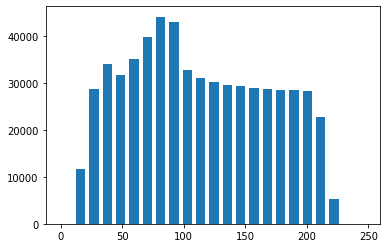

[0.02659847 0.02173913 0.0030608  0.00164593 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00366727
 0.         0.         0.        ]
21
[0.02659847 0.02173913 0.0030608  0.00164593 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00366727
 0.         0.         0.         0.         0.        ]
23
16


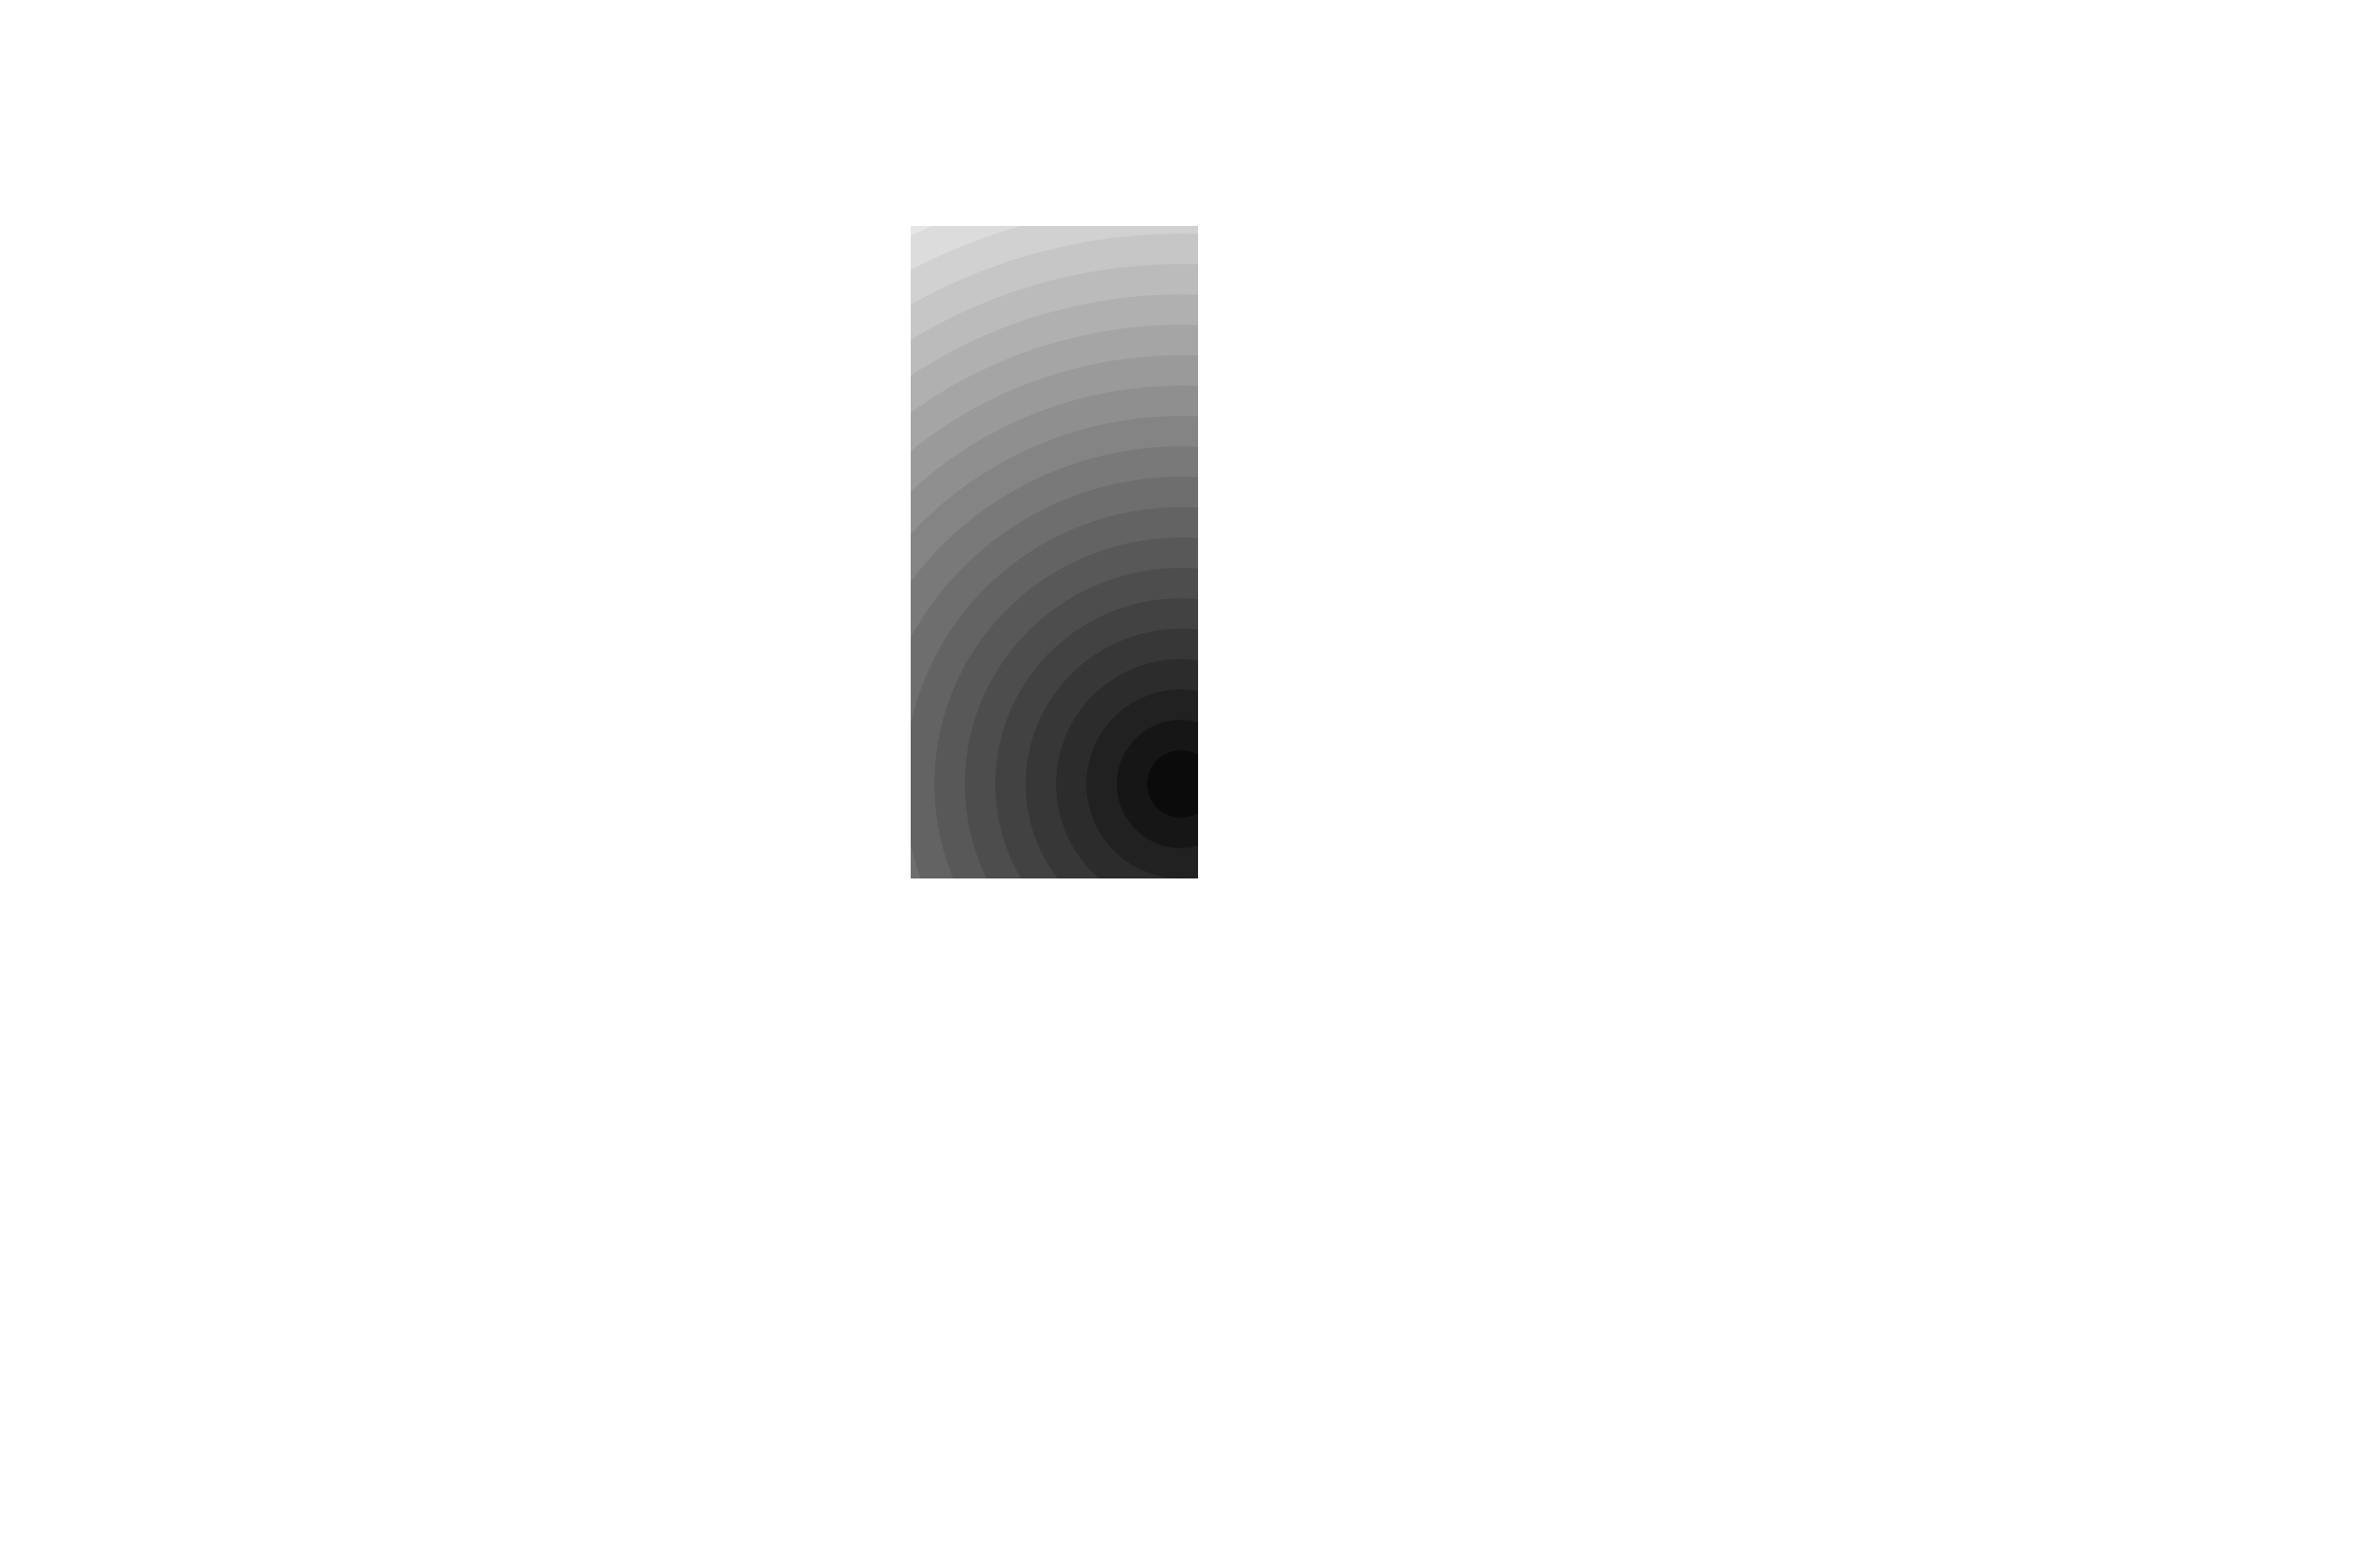

(0.3182402612199817, -0.5669686941288931)
Time                      1.61383e+09
RatX                         0.265091
RatY                        -0.512516
RatZ                          0.62556
BeaconX                       0.31824
BeaconY                     -0.566969
Visibility                          1
time_of_beacon_trigger    1.61383e+09
Beacon_group                        3
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 379, dtype: object
23
[    0  9402 18312 27426 29394 32598 37101 41451 45933 48702 35436 32370
 31200 30453 29967 29580 29259 28956 28845 19725  6522   318     0]
[ 9402 18312 27426 29394 32598 37101 41451 45933 48702 35436 32370 31200
 30453 29967 29580 29259 28956 28845 19725  6522   318]
[180.80769231 352.15384615 527.42307692 565.26923077 626.88461538
 713.48076923 797.13461538 883.32692308 936.57692308 681.46153846
 622.5        600.         585.63461538 576.28846154 568.84615385
 562.6

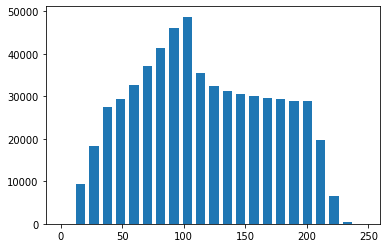

[0.03871517 0.01419834 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
21
[0.03871517 0.01419834 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
17


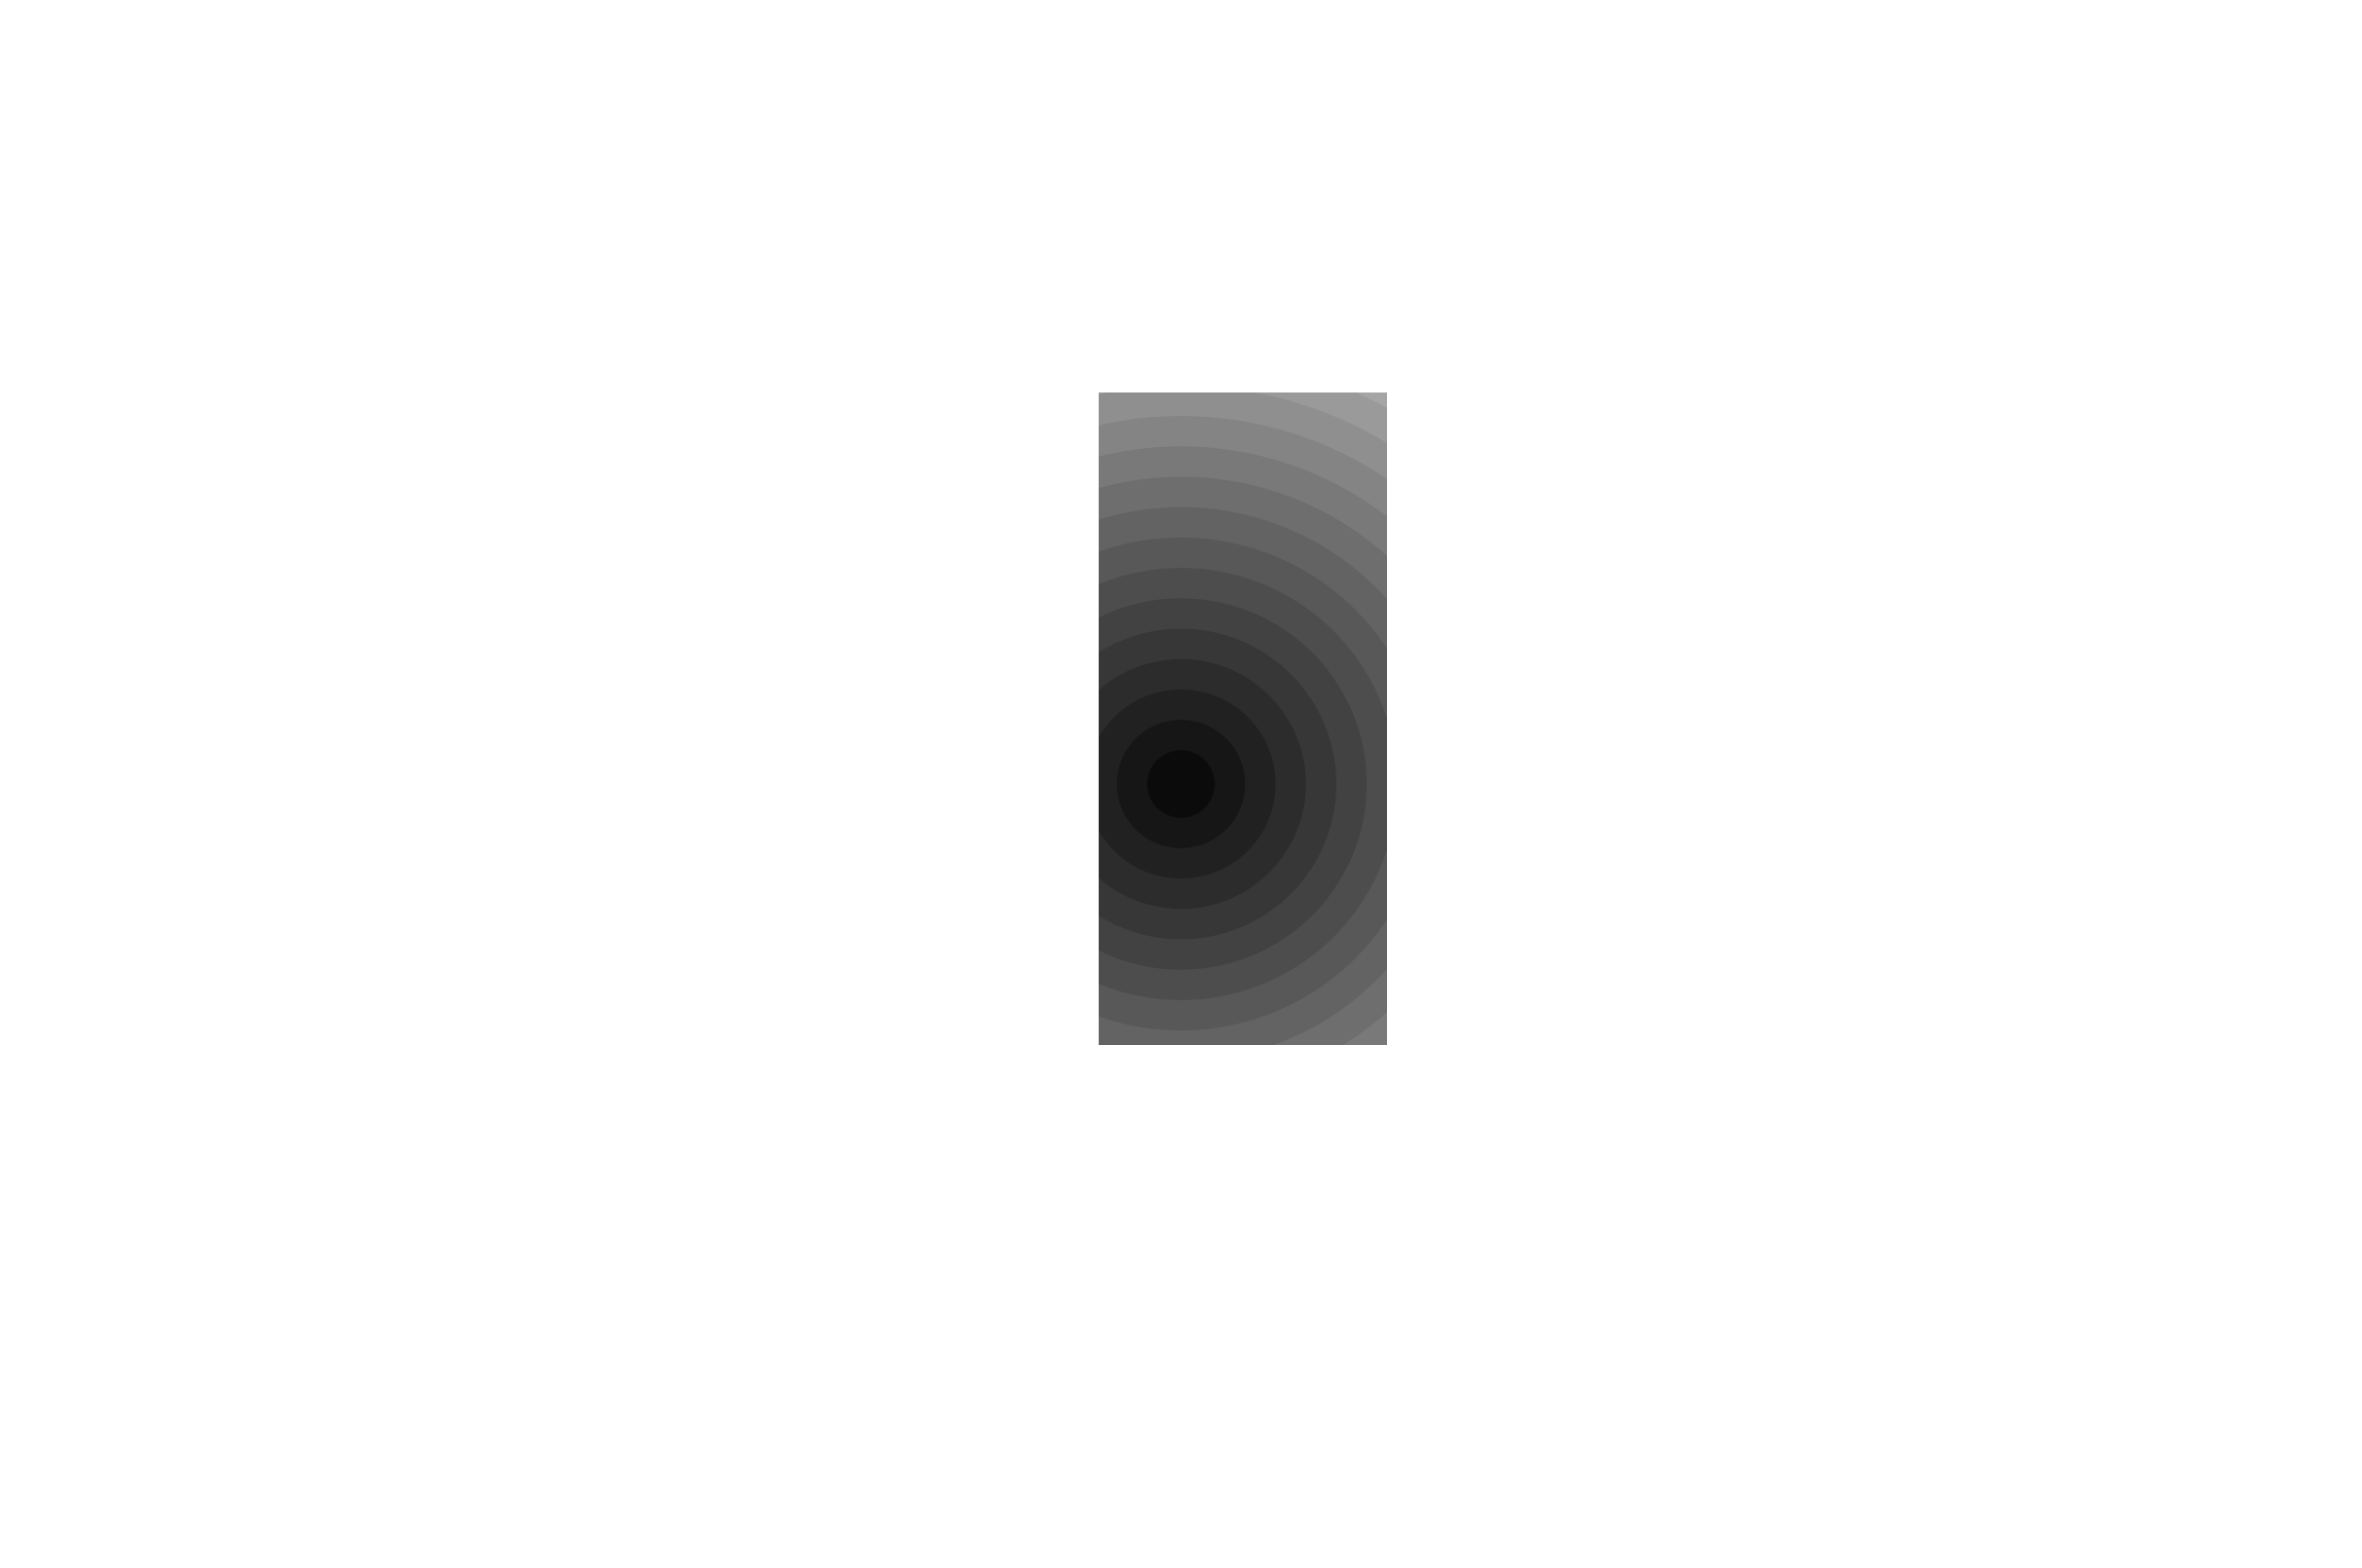

(-0.1474166846861441, -0.1556883302443571)
Time                      1.61383e+09
RatX                         0.366892
RatY                        -0.442022
RatZ                         0.625707
BeaconX                     -0.147417
BeaconY                     -0.155688
Visibility                          1
time_of_beacon_trigger    1.61383e+09
Beacon_group                        4
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 399, dtype: object
23
[    0 11730 29922 45675 51237 58920 68148 74070 65142 55437 38925 31476
 29088 26613  7866   711     0     0     0     0     0     0     0]
[11730 29922 45675 51237 58920 68148 74070 65142 55437 38925 31476 29088
 26613  7866   711]
[ 225.57692308  575.42307692  878.36538462  985.32692308 1133.07692308
 1310.53846154 1424.42307692 1252.73076923 1066.09615385  748.55769231
  605.30769231  559.38461538  511.78846154  151.26923077   13.67307692]
15
23
[6 4 0 0 0 0 0 1 0 

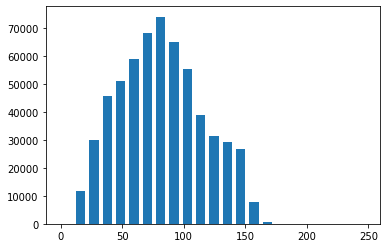

[0.02659847 0.00695141 0.         0.         0.         0.
 0.         0.00079826 0.         0.         0.         0.
 0.         0.         0.        ]
15
[0.02659847 0.00695141 0.         0.         0.         0.
 0.         0.00079826 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
18


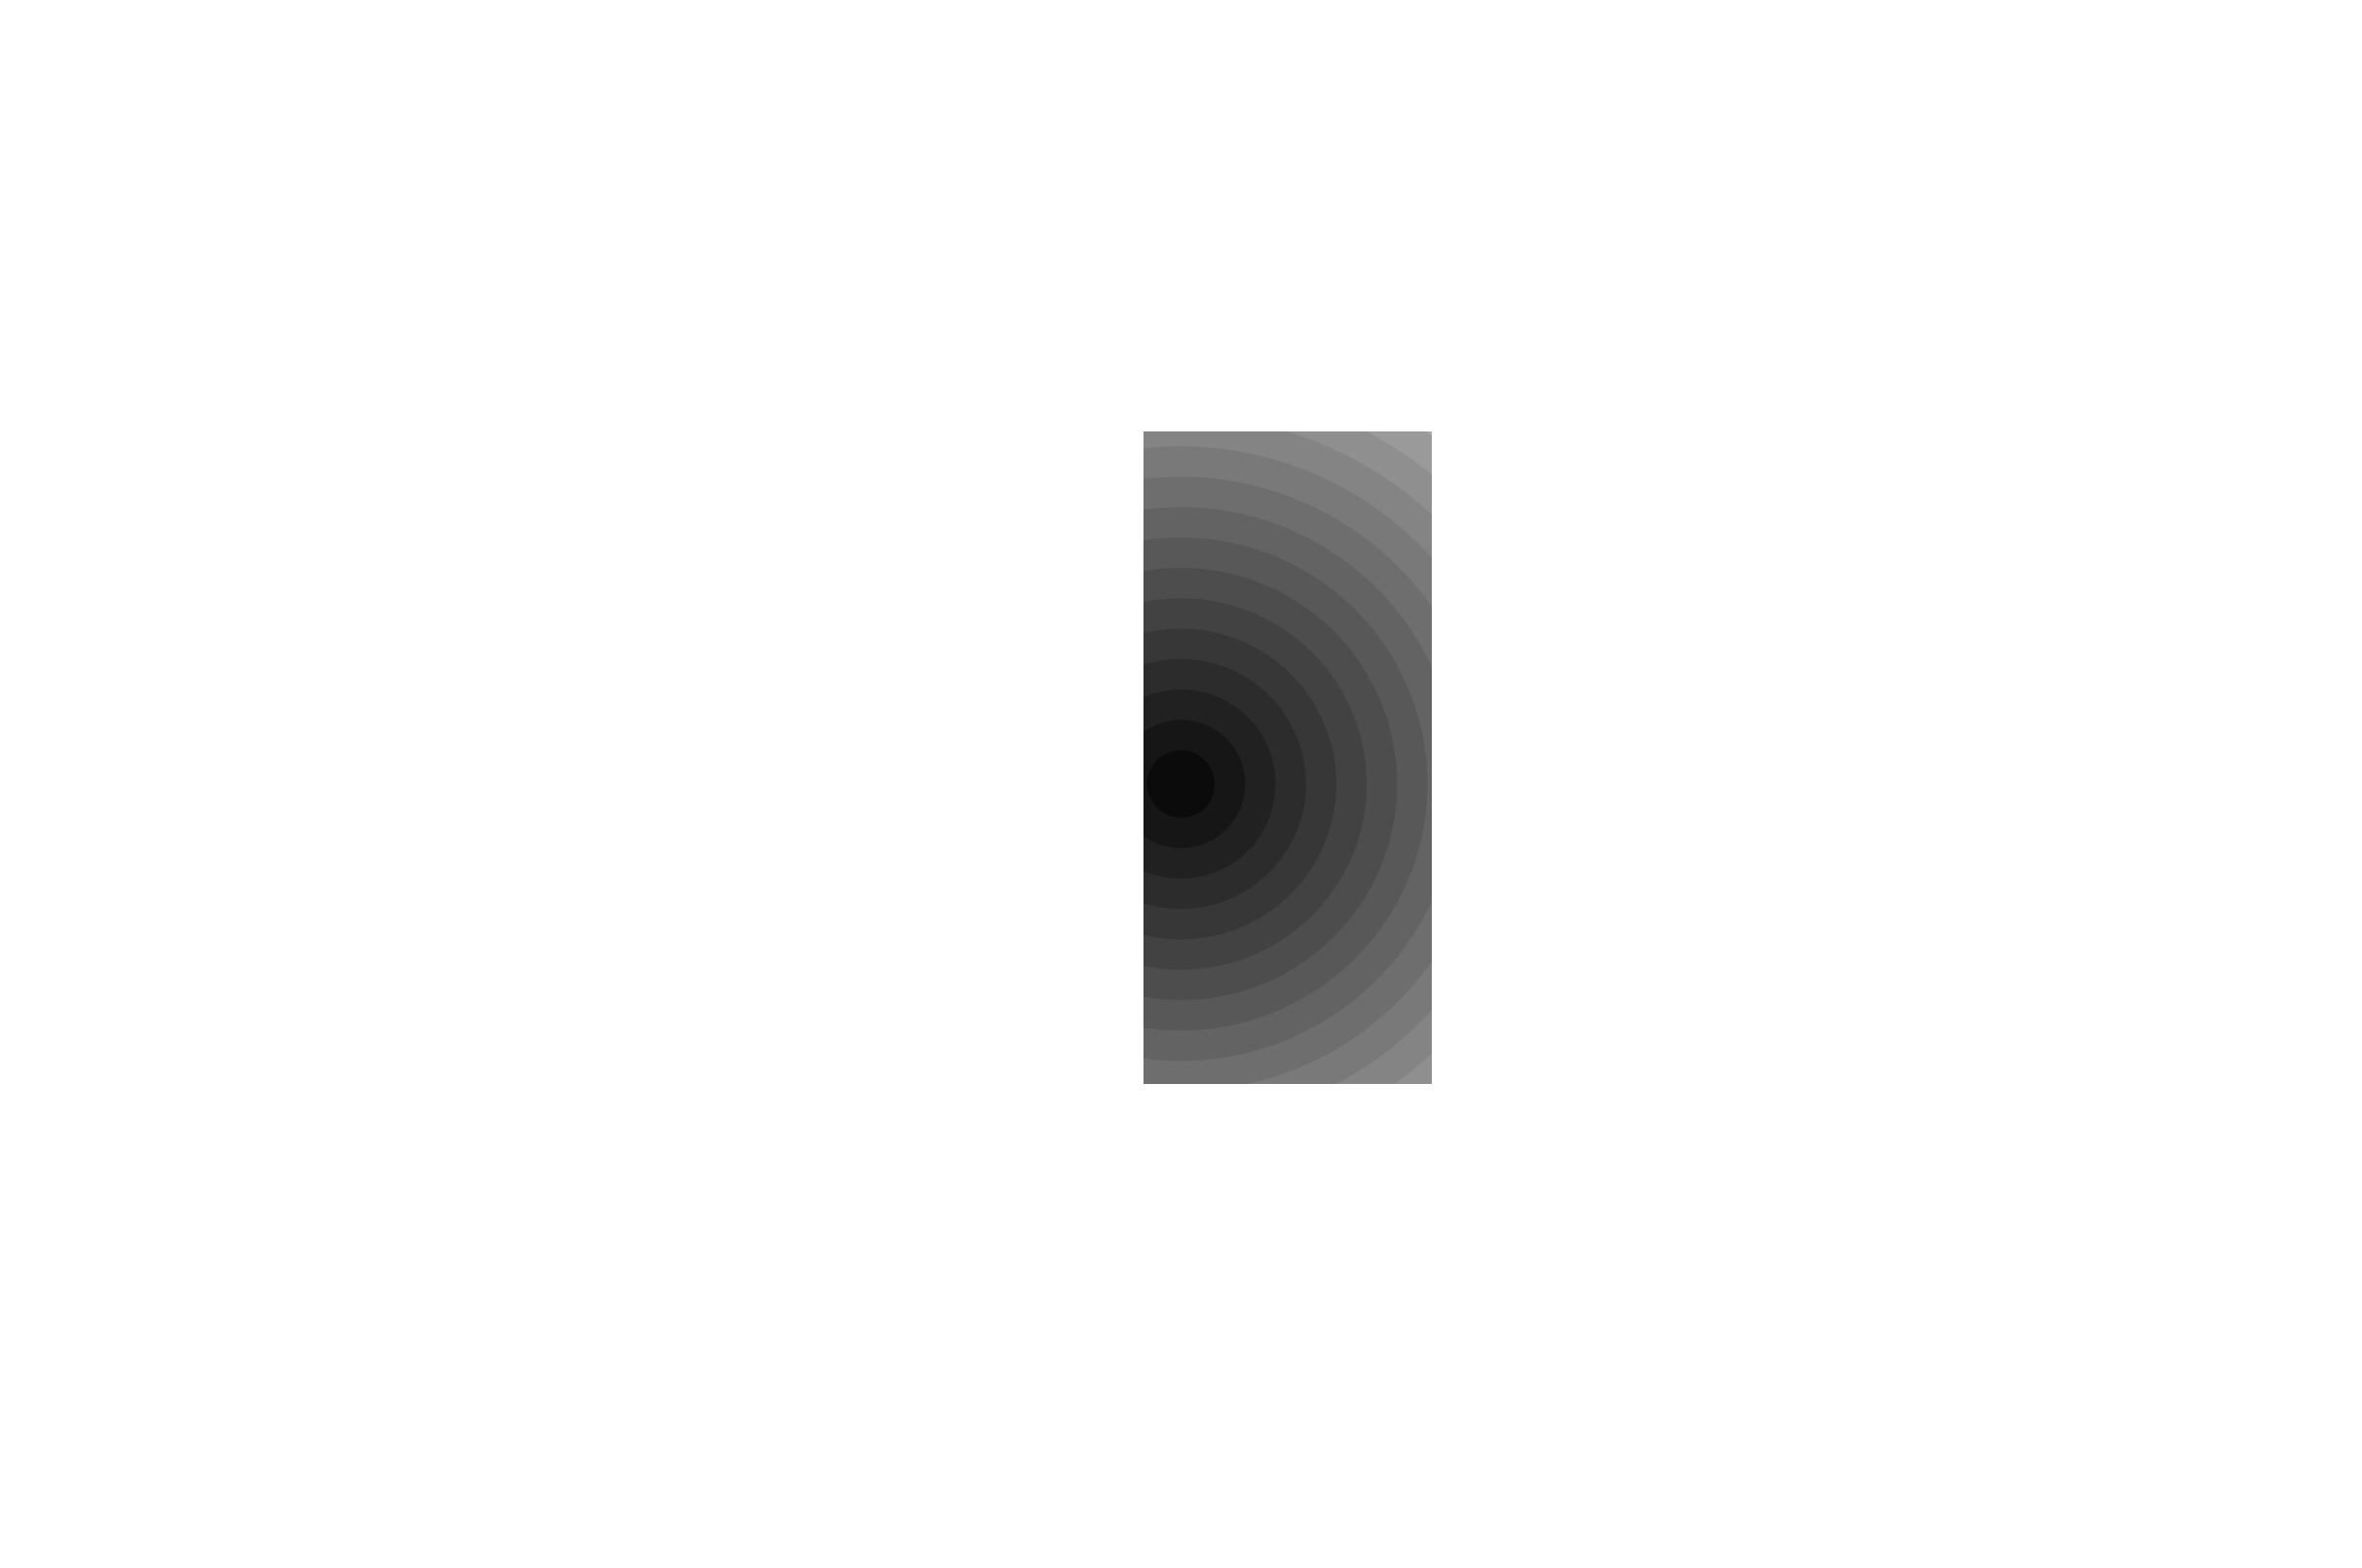

(-0.2580296223820259, -0.05928447046219971)
Time                      1.61383e+09
RatX                        -0.266681
RatY                        -0.101585
RatZ                           0.6268
BeaconX                      -0.25803
BeaconY                    -0.0592845
Visibility                          1
time_of_beacon_trigger    1.61383e+09
Beacon_group                        5
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 421, dtype: object
23
[    0 11730 23538 31662 40644 49392 58890 67968 77130 73131 63348 47190
 33051 13224  4017    45     0     0     0     0     0     0     0]
[11730 23538 31662 40644 49392 58890 67968 77130 73131 63348 47190 33051
 13224  4017    45]
[2.25576923e+02 4.52653846e+02 6.08884615e+02 7.81615385e+02
 9.49846154e+02 1.13250000e+03 1.30707692e+03 1.48326923e+03
 1.40636538e+03 1.21823077e+03 9.07500000e+02 6.35596154e+02
 2.54307692e+02 7.72500000e+01 8.65384615e-01]
15
23
[1

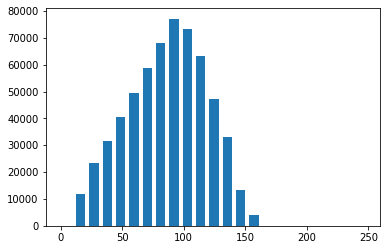

[0.05319693 0.00662758 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00393224 0.         0.        ]
15
[0.05319693 0.00662758 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00393224 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
19


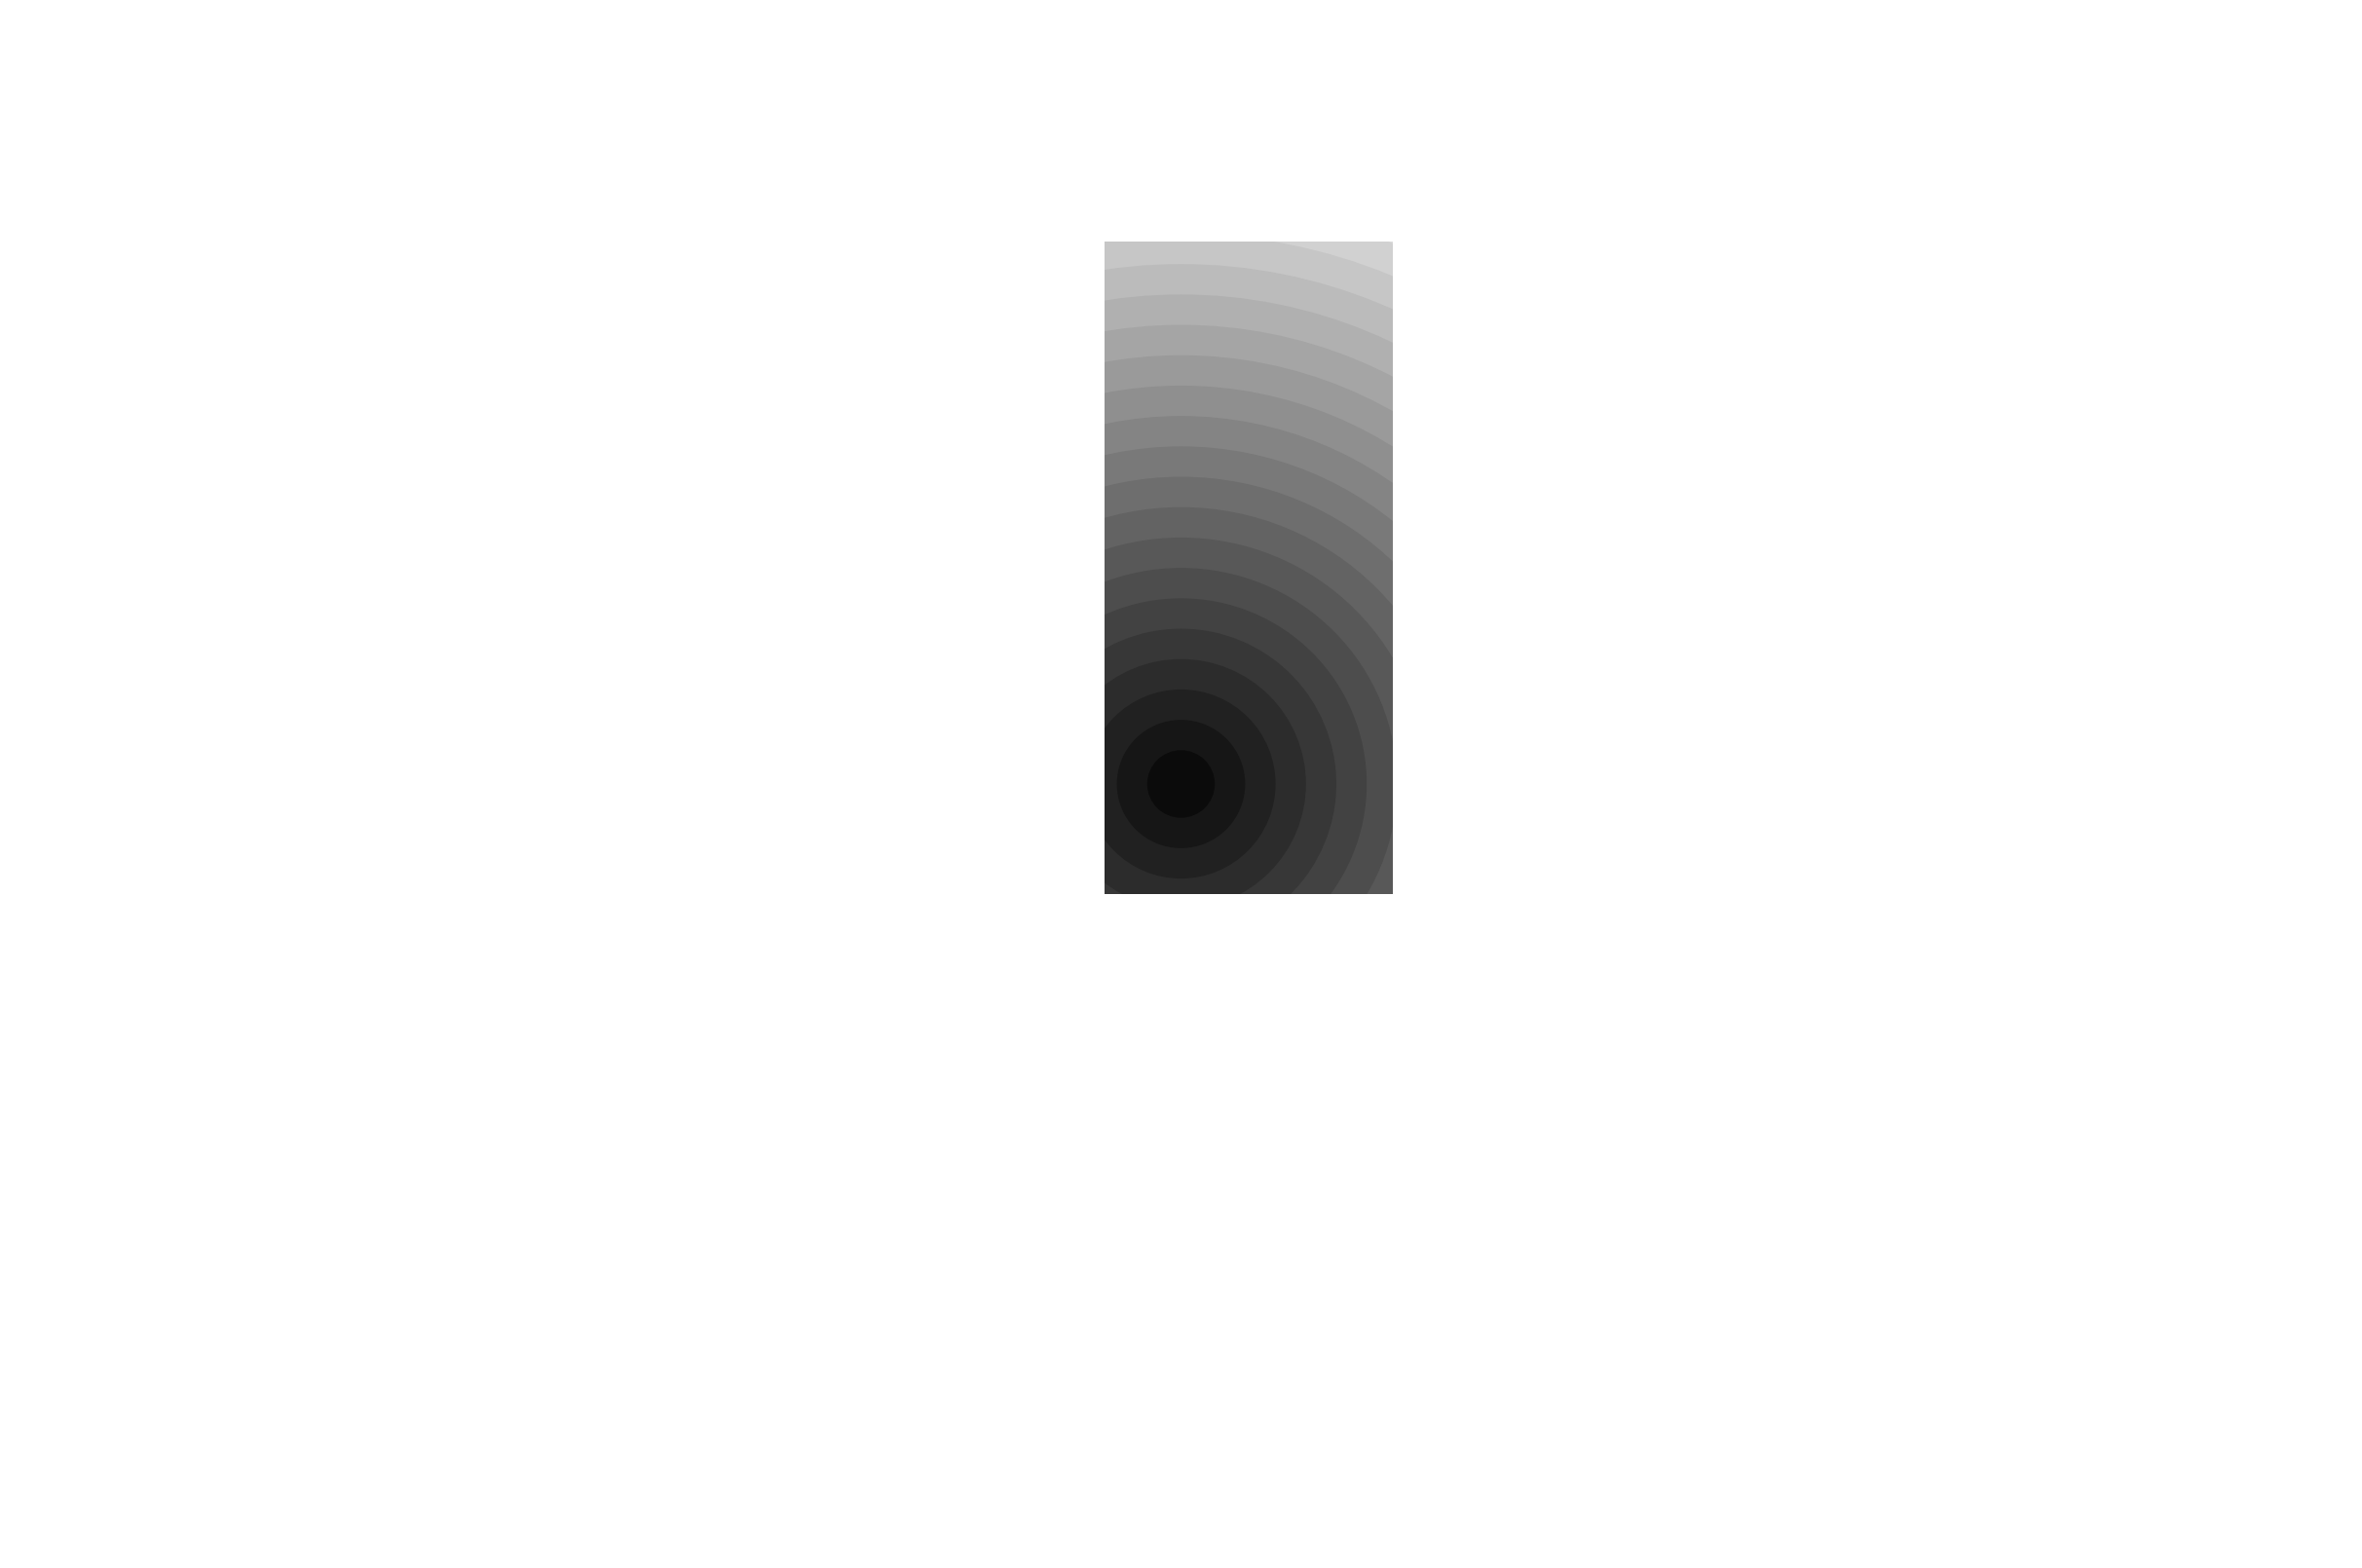

(-0.161819261454925, -0.5287954870929873)
Time                      1.61407e+09
RatX                        -0.211329
RatY                         -0.48753
RatZ                         0.623393
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.61407e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 429, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e

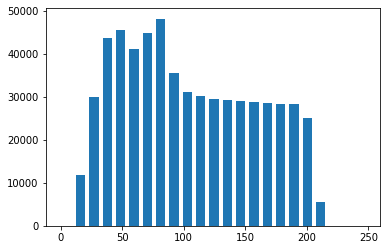

[0.01329923 0.00173785 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00178033
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.01329923 0.00173785 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00178033
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
20


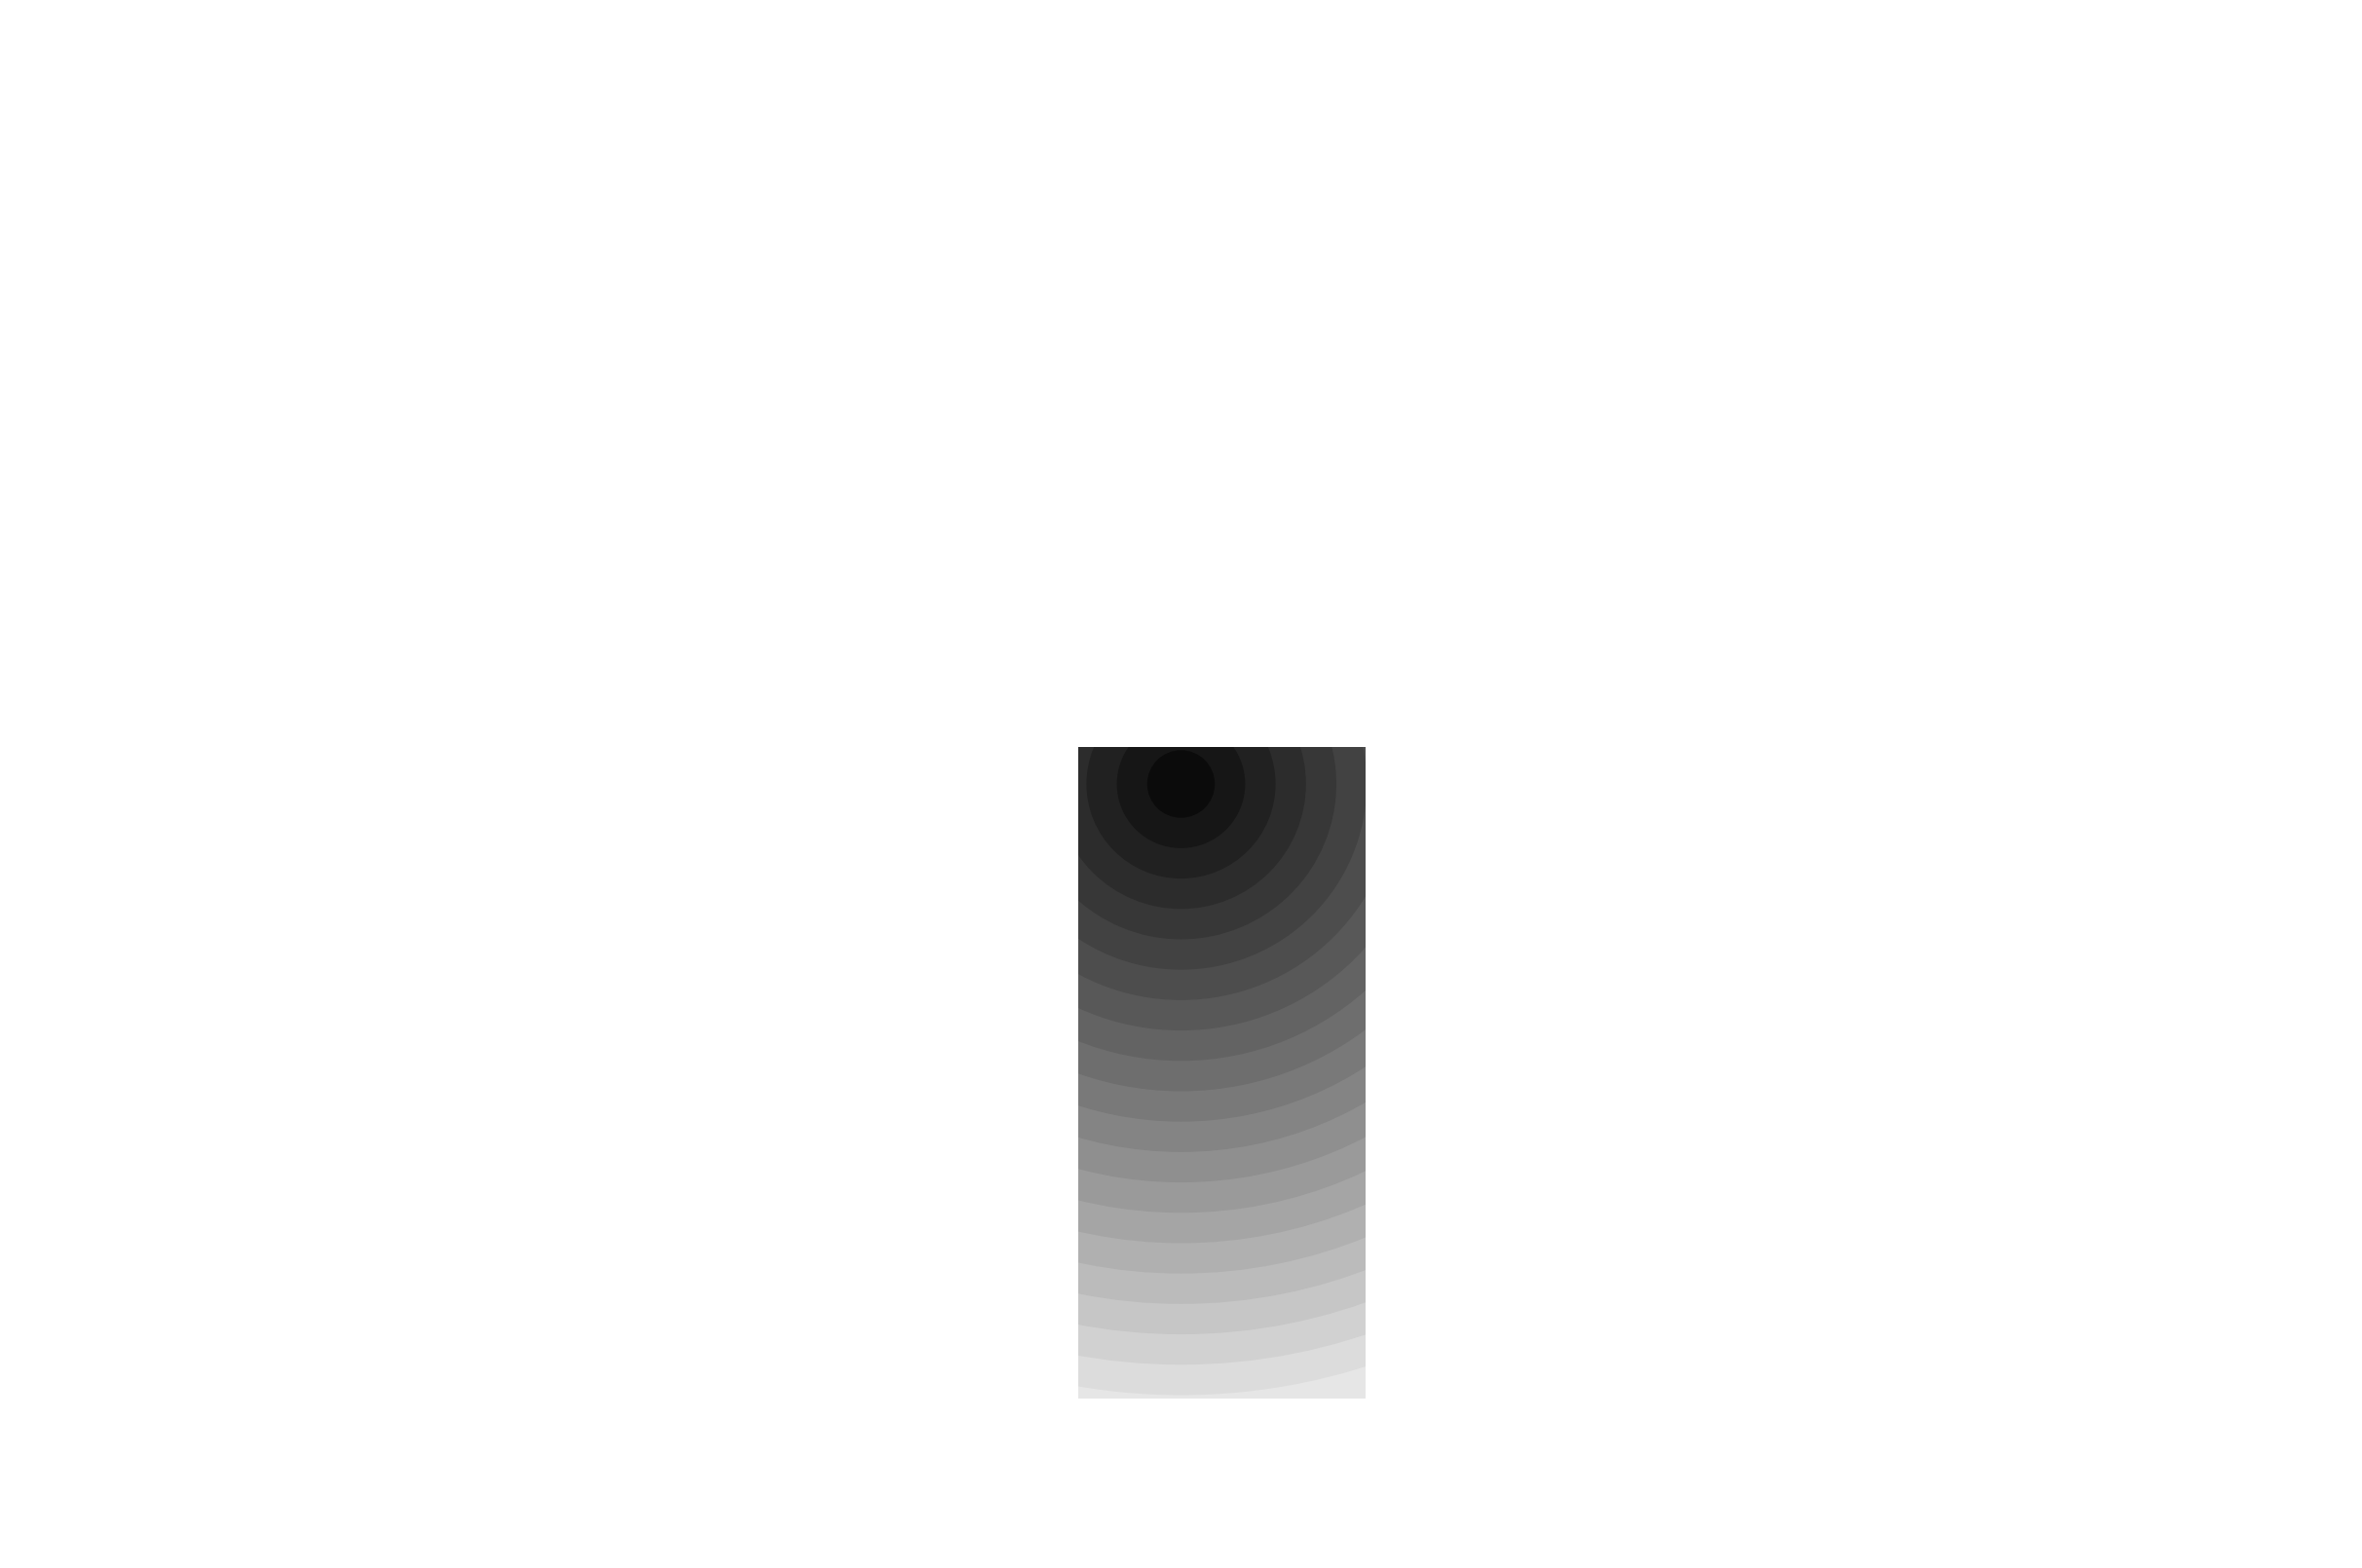

(-0.095206590921041, 0.7178172552270362)
Time                      1.61407e+09
RatX                        -0.171301
RatY                         0.684712
RatZ                         0.621246
BeaconX                    -0.0952066
BeaconY                      0.717817
Visibility                          1
time_of_beacon_trigger    1.61407e+09
Beacon_group                        2
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 448, dtype: object
23
[    0 11730 23382 31536 34587 35661 39867 33111 30768 29883 29289 28851
 28650 28500 28392 28260 28152 28026 28026 27960 28089  9345     0]
[11730 23382 31536 34587 35661 39867 33111 30768 29883 29289 28851 28650
 28500 28392 28260 28152 28026 28026 27960 28089  9345]
[225.57692308 449.65384615 606.46153846 665.13461538 685.78846154
 766.67307692 636.75       591.69230769 574.67307692 563.25
 554.82692308 550.96153846 548.07692308 546.         543.46153846
 541.38461538

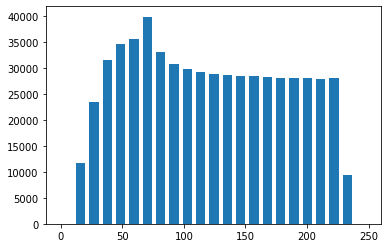

[0.02659847 0.0066718  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
21
[0.02659847 0.0066718  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
21


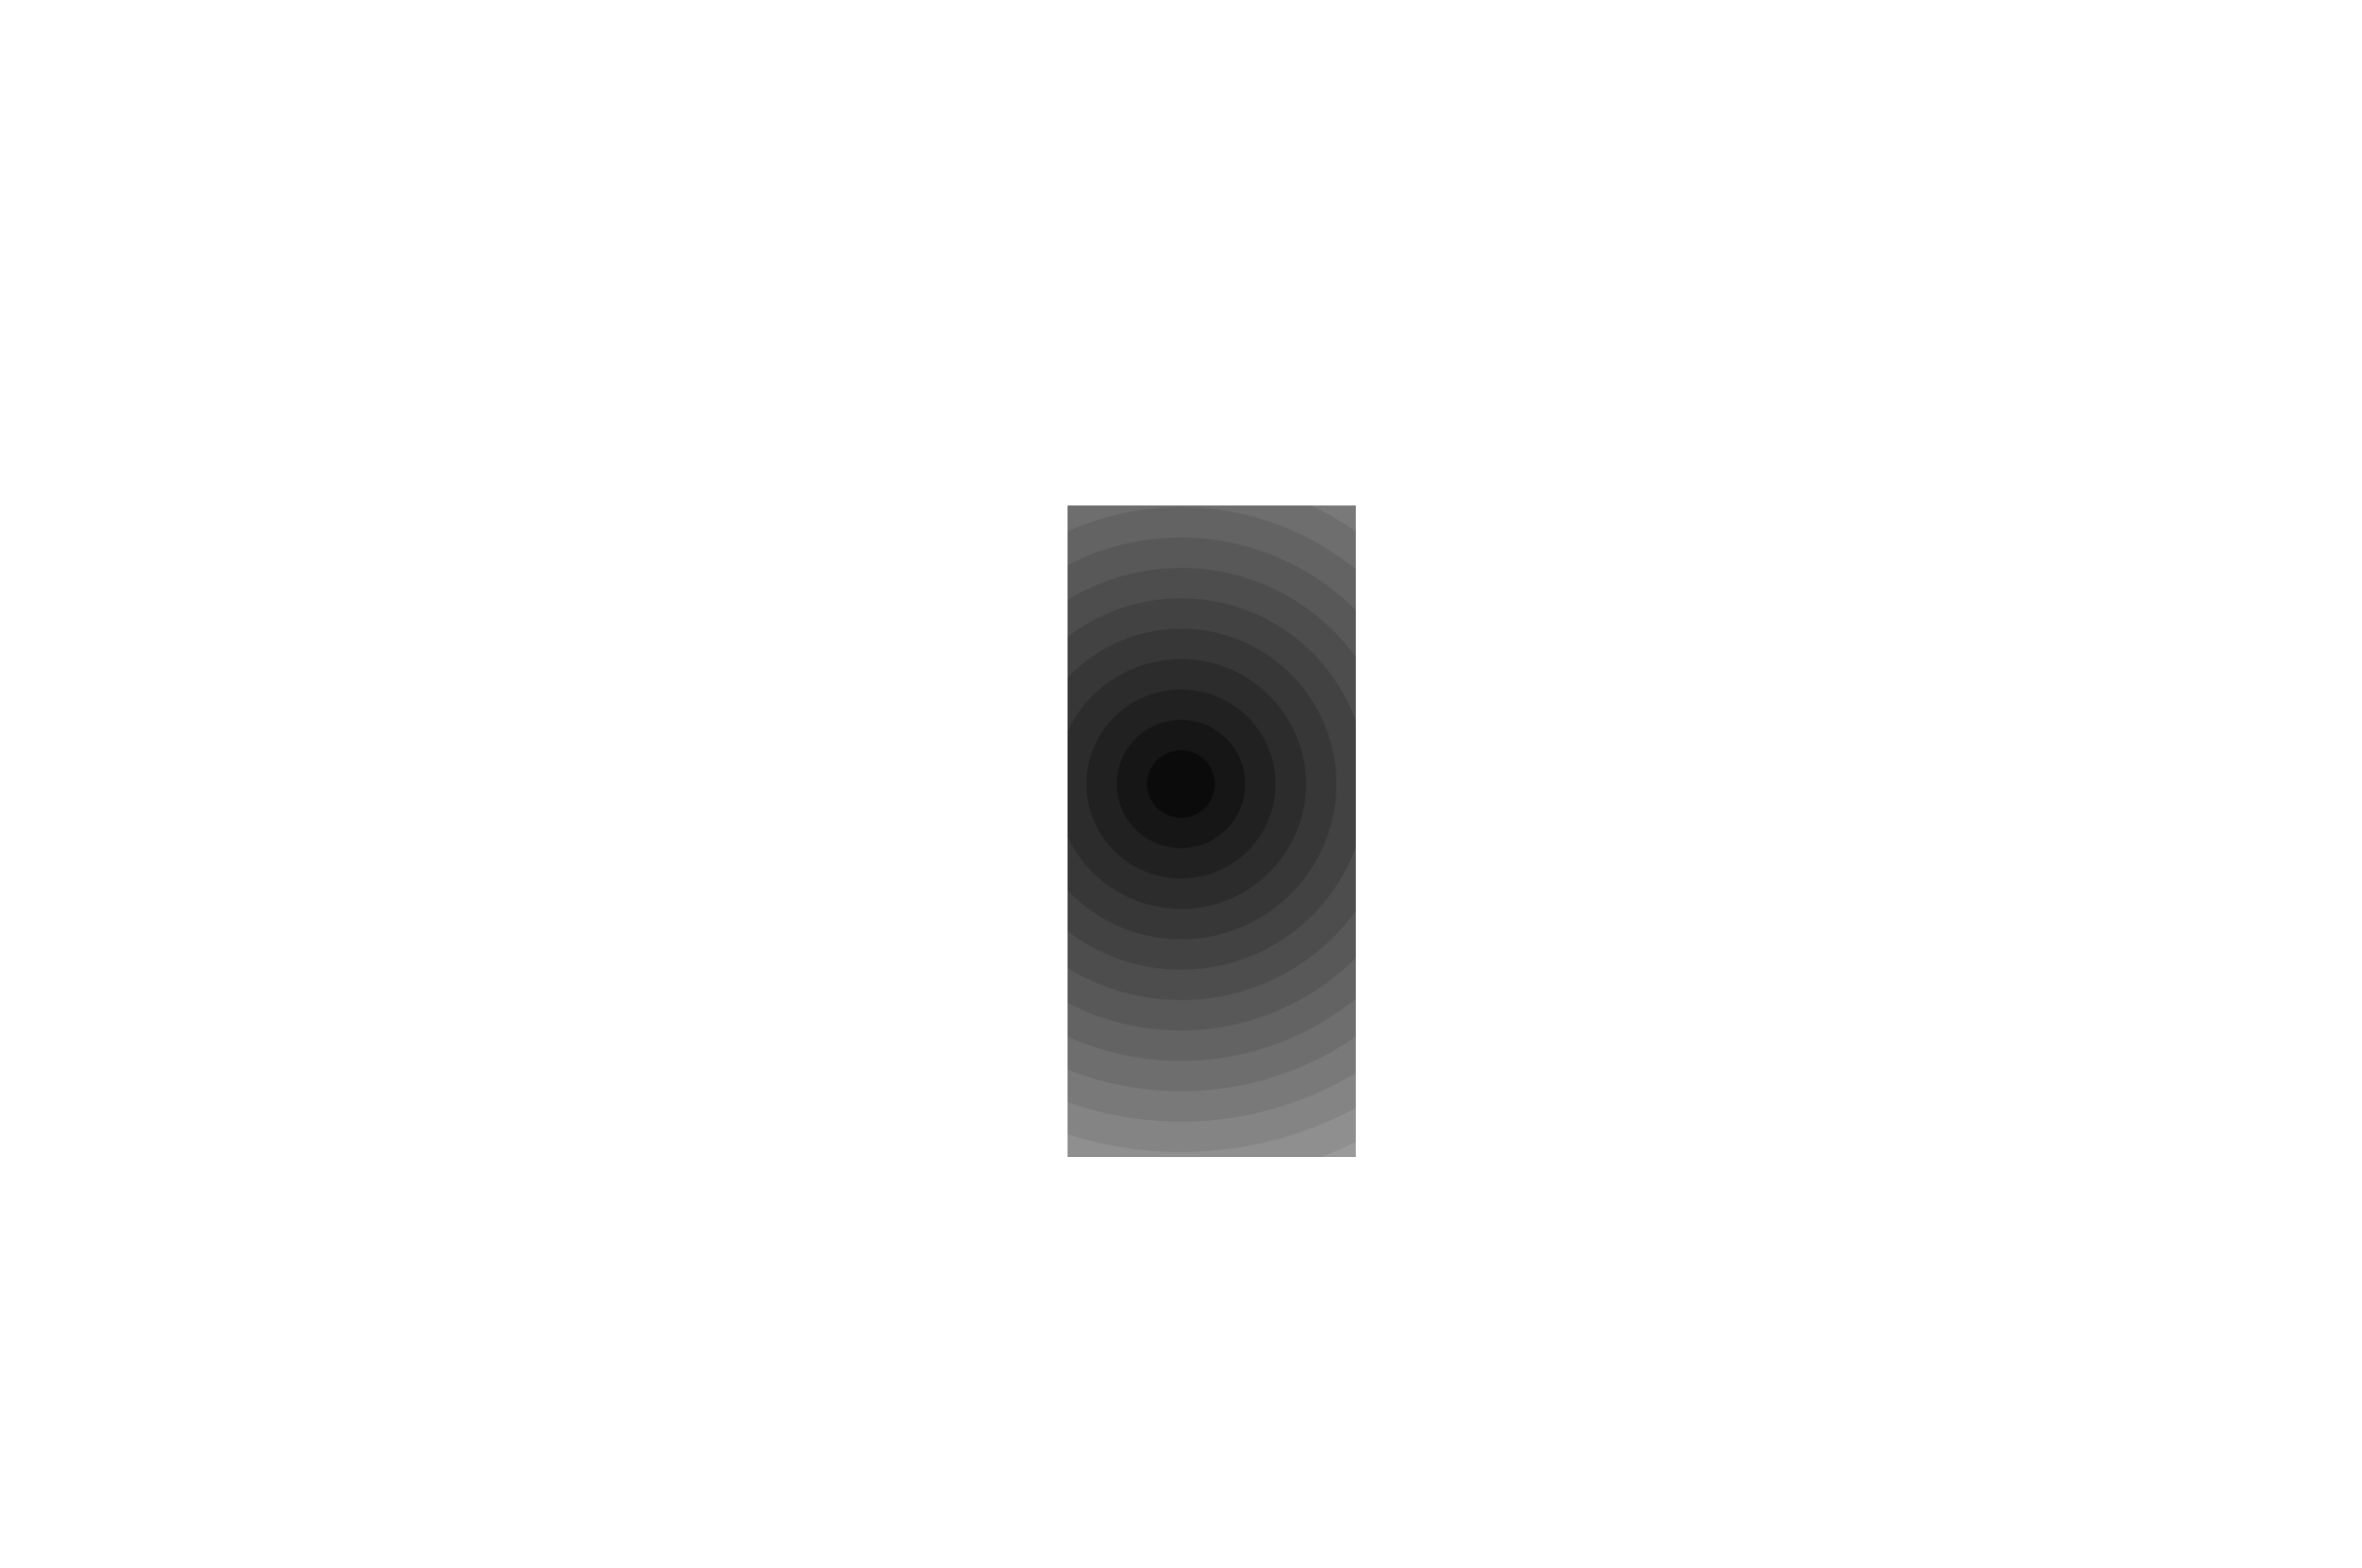

(-0.07076404717479334, 0.1216188852176255)
Time                      1.61407e+09
RatX                       -0.0429635
RatY                         0.136055
RatZ                         0.623685
BeaconX                     -0.070764
BeaconY                      0.121619
Visibility                          1
time_of_beacon_trigger    1.61407e+09
Beacon_group                        3
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 474, dtype: object
23
[    0 11730 29922 48279 63849 67464 72483 64035 60882 59430 42477 30480
 28653 13620   768     0     0     0     0     0     0     0     0]
[11730 29922 48279 63849 67464 72483 64035 60882 59430 42477 30480 28653
 13620   768]
[ 225.57692308  575.42307692  928.44230769 1227.86538462 1297.38461538
 1393.90384615 1231.44230769 1170.80769231 1142.88461538  816.86538462
  586.15384615  551.01923077  261.92307692   14.76923077]
14
23
[8 5 0 0 0 0 0 0 0 0 0 1 0 0]
14


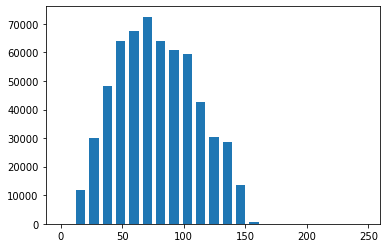

[0.03546462 0.00868926 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00181482
 0.         0.        ]
14
[0.03546462 0.00868926 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00181482
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
22


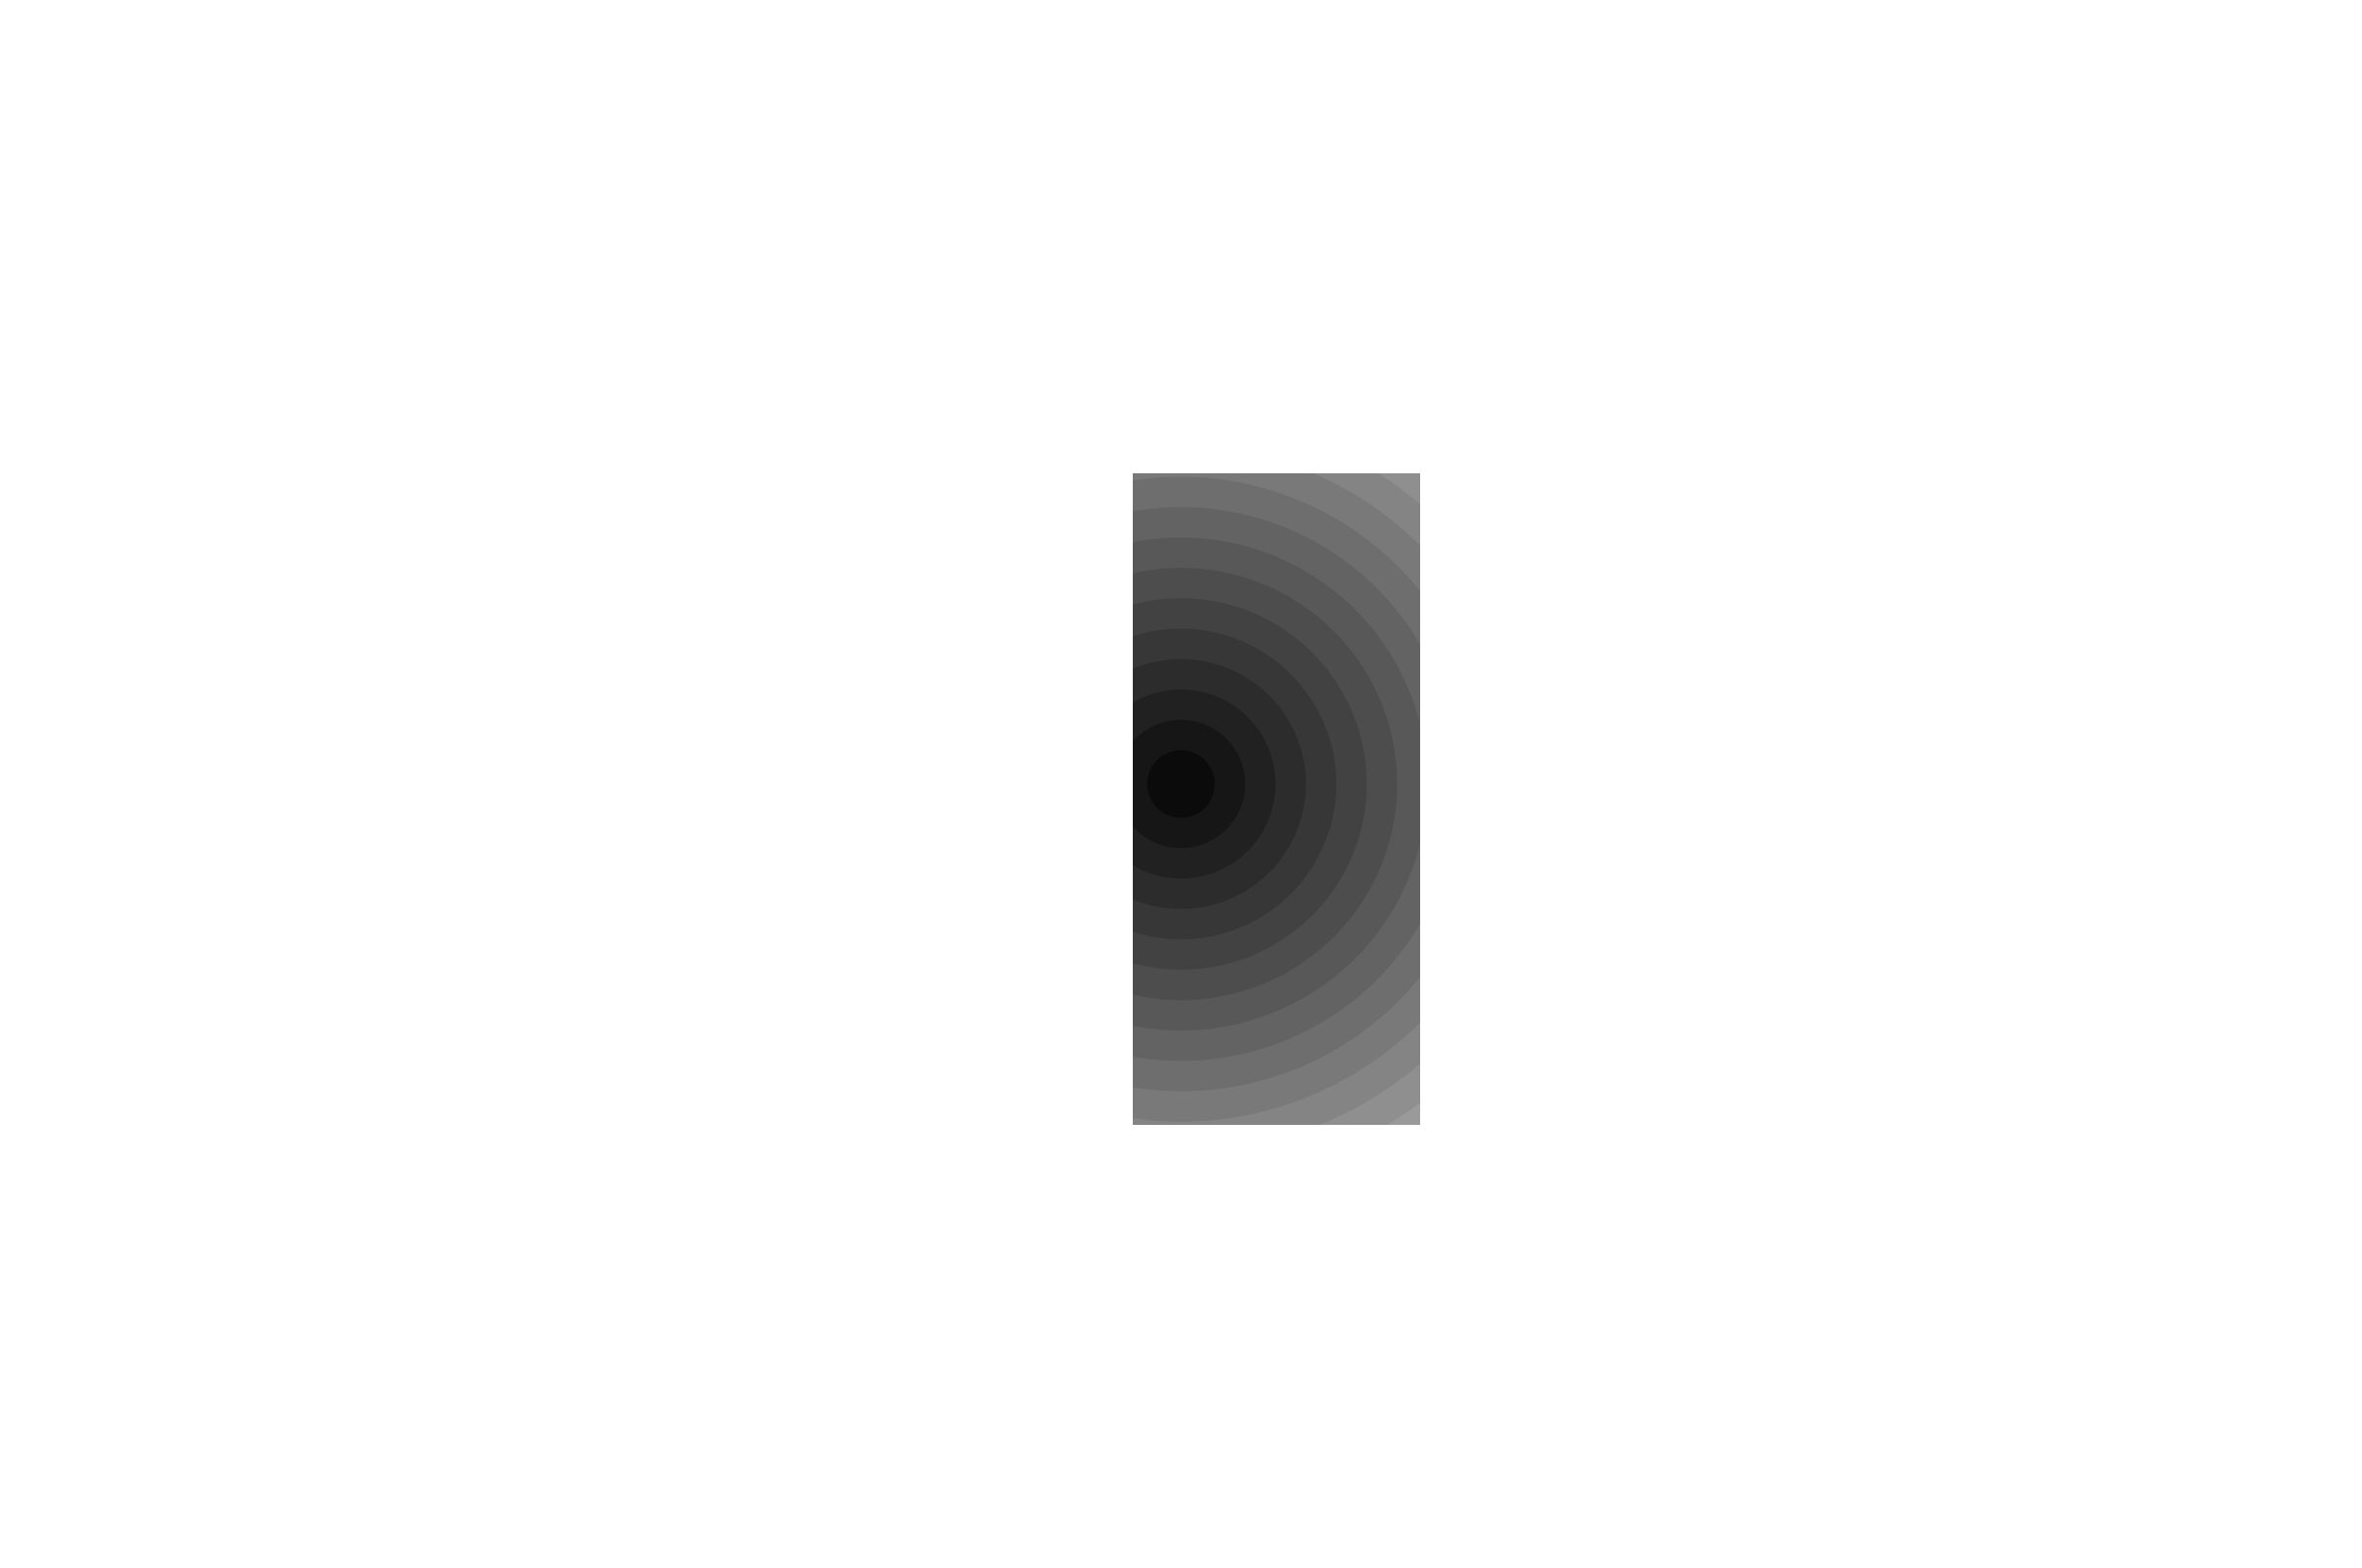

(-0.2310383382329229, 0.04222900434709407)
Time                      1.61407e+09
RatX                        -0.215499
RatY                        0.0766677
RatZ                         0.623818
BeaconX                     -0.231038
BeaconY                      0.042229
Visibility                          1
time_of_beacon_trigger    1.61407e+09
Beacon_group                        4
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 497, dtype: object
23
[    0 11730 26820 34140 42876 51534 61026 70074 77208 67662 63162 49233
 26247  9273  1080     0     0     0     0     0     0     0     0]
[11730 26820 34140 42876 51534 61026 70074 77208 67662 63162 49233 26247
  9273  1080]
[ 225.57692308  515.76923077  656.53846154  824.53846154  991.03846154
 1173.57692308 1347.57692308 1484.76923077 1301.19230769 1214.65384615
  946.78846154  504.75        178.32692308   20.76923077]
14
23
[10  1  1  2  1  0  0  0  0  0  0  0  0

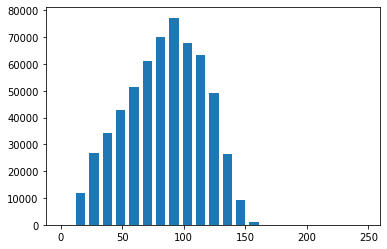

[0.04433078 0.00193885 0.00152314 0.0024256  0.00100904 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
14
[0.04433078 0.00193885 0.00152314 0.0024256  0.00100904 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
23


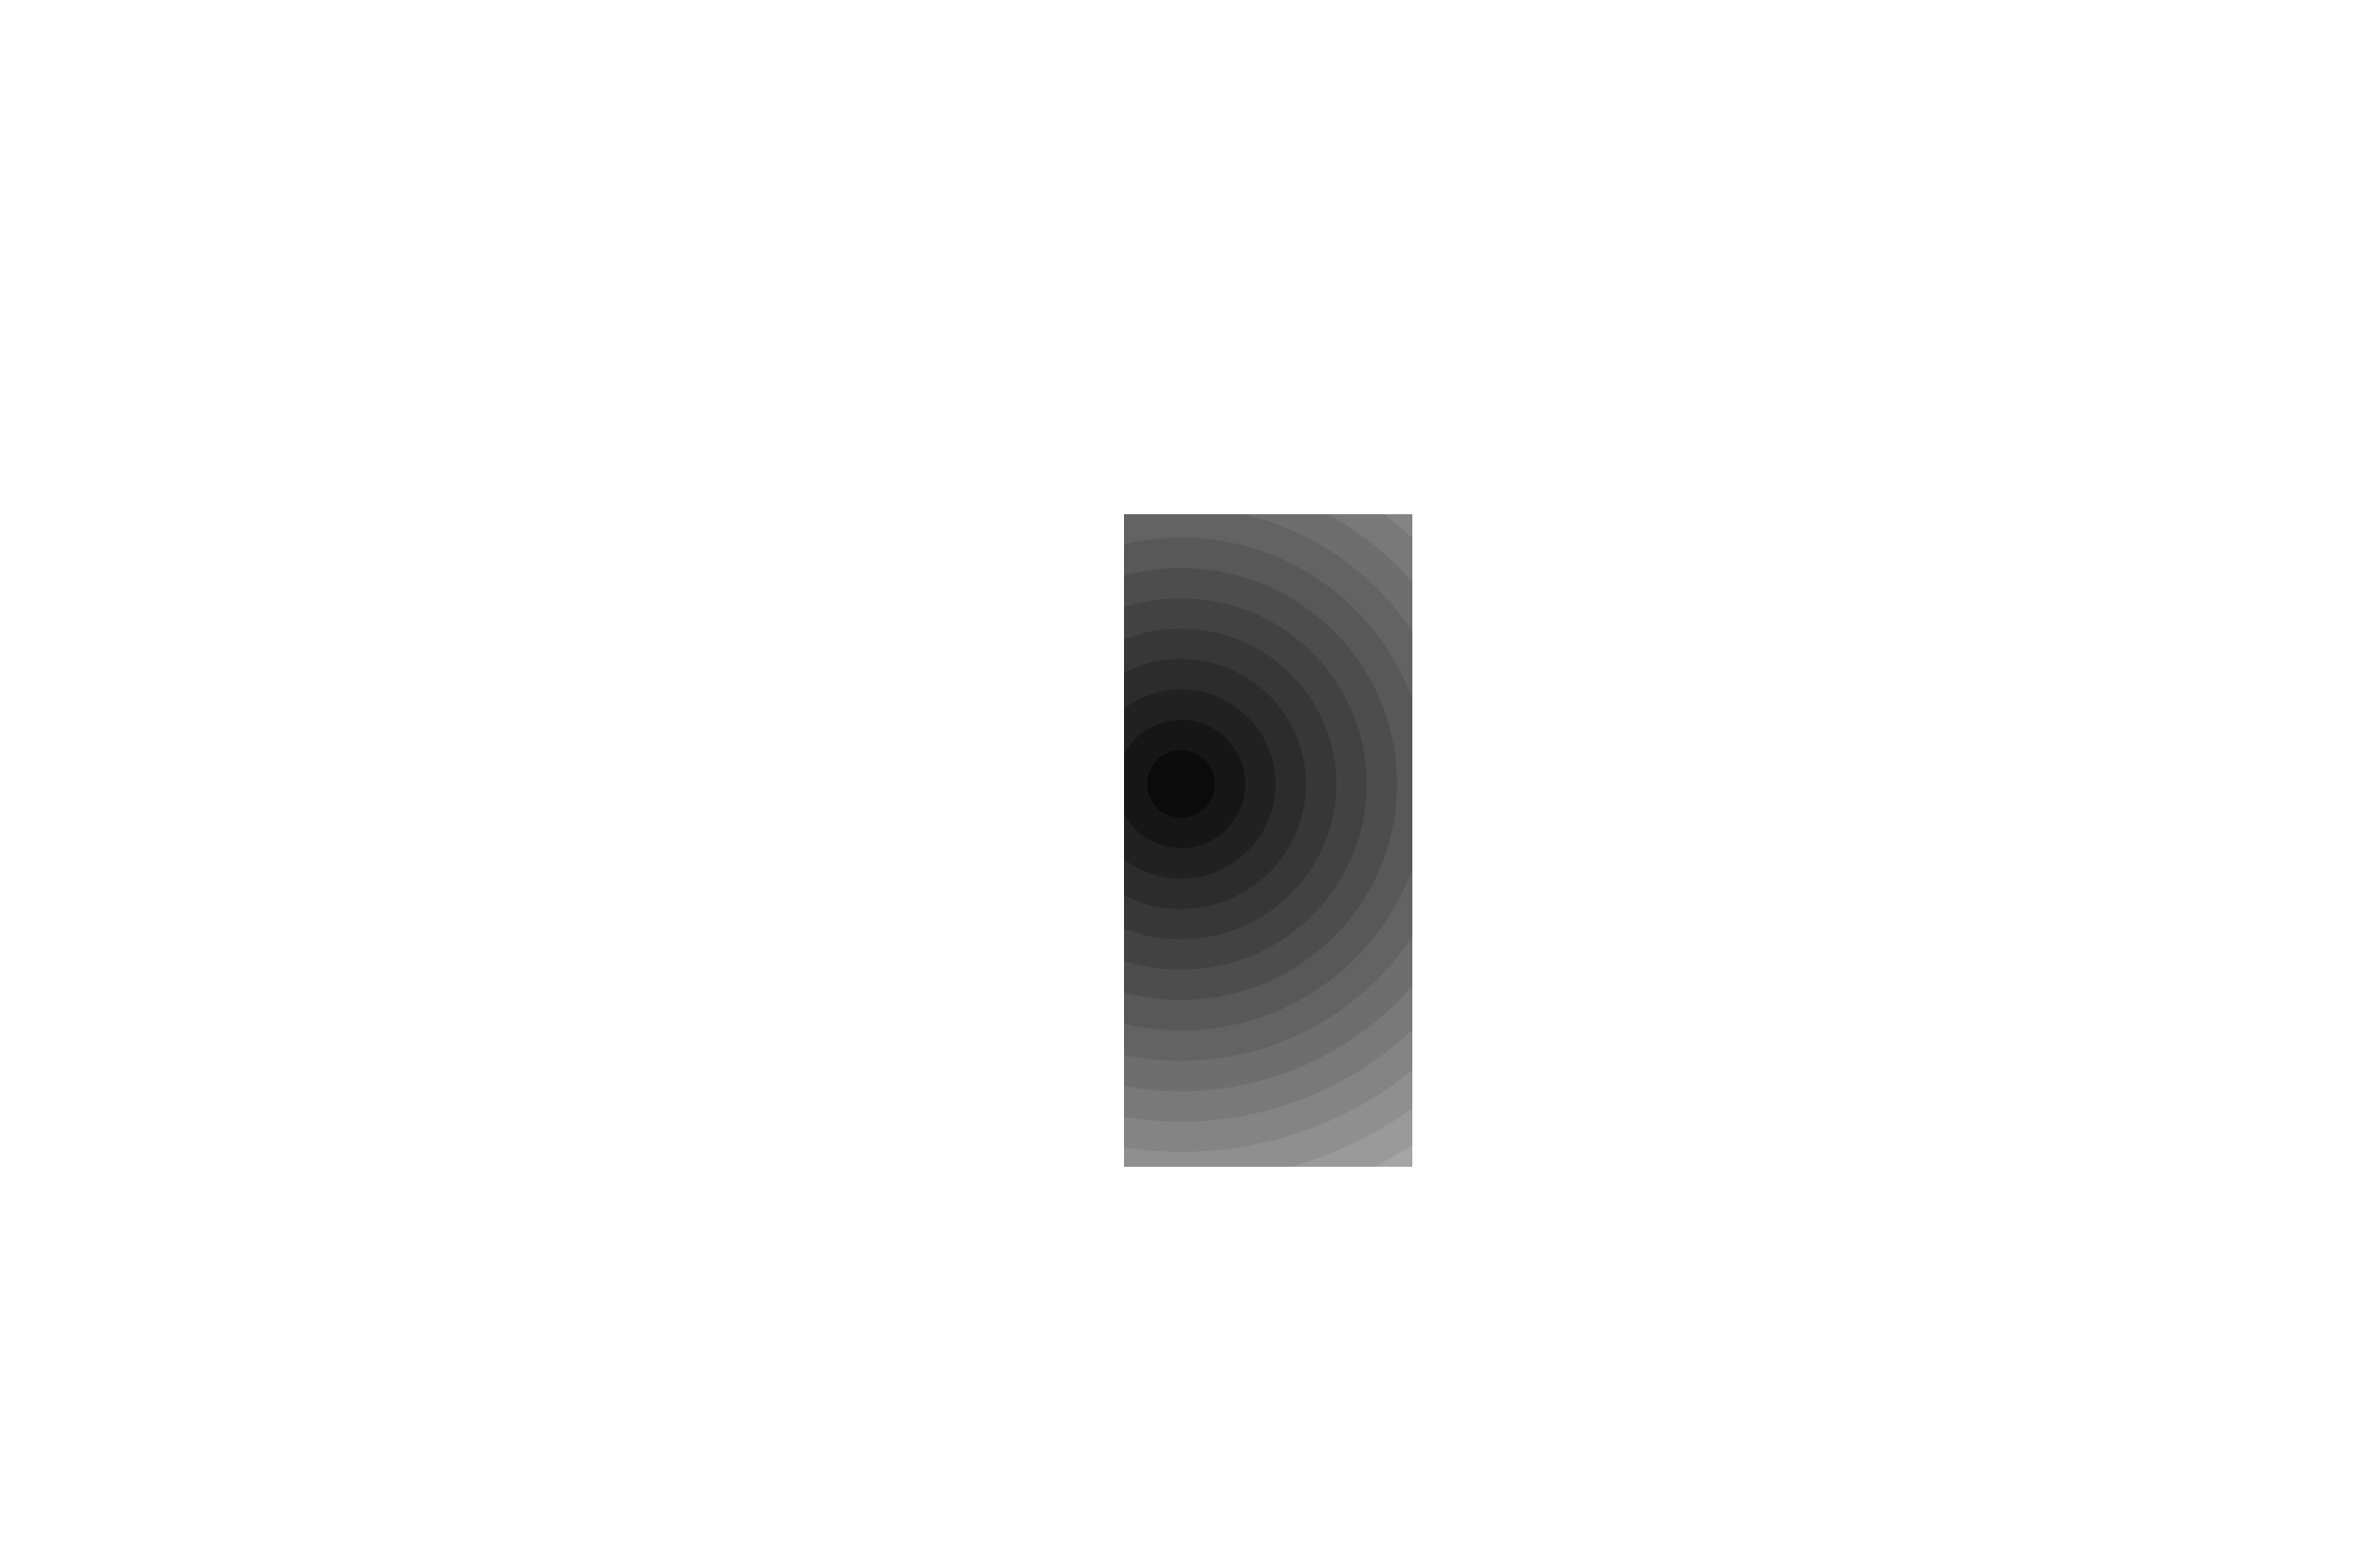

(-0.2105621789005198, 0.1451153812309158)
Time                      1.61407e+09
RatX                        -0.241494
RatY                         0.174496
RatZ                         0.621891
BeaconX                     -0.210562
BeaconY                      0.145115
Visibility                          1
time_of_beacon_trigger    1.61407e+09
Beacon_group                        5
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 518, dtype: object
23
[    0 11730 28902 36450 44802 53340 62796 71826 75264 63813 45906 36978
 30720 22995  8214  1224     0     0     0     0     0     0     0]
[11730 28902 36450 44802 53340 62796 71826 75264 63813 45906 36978 30720
 22995  8214  1224]
[ 225.57692308  555.80769231  700.96153846  861.57692308 1025.76923077
 1207.61538462 1381.26923077 1447.38461538 1227.17307692  882.80769231
  711.11538462  590.76923077  442.21153846  157.96153846   23.53846154]
15
23
[7 4 0 0 0 0 0 1 0 0

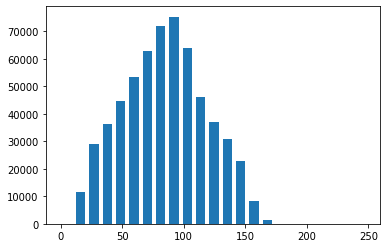

[0.03103154 0.00719673 0.         0.         0.         0.
 0.         0.0006909  0.         0.         0.         0.
 0.         0.         0.        ]
15
[0.03103154 0.00719673 0.         0.         0.         0.
 0.         0.0006909  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
24


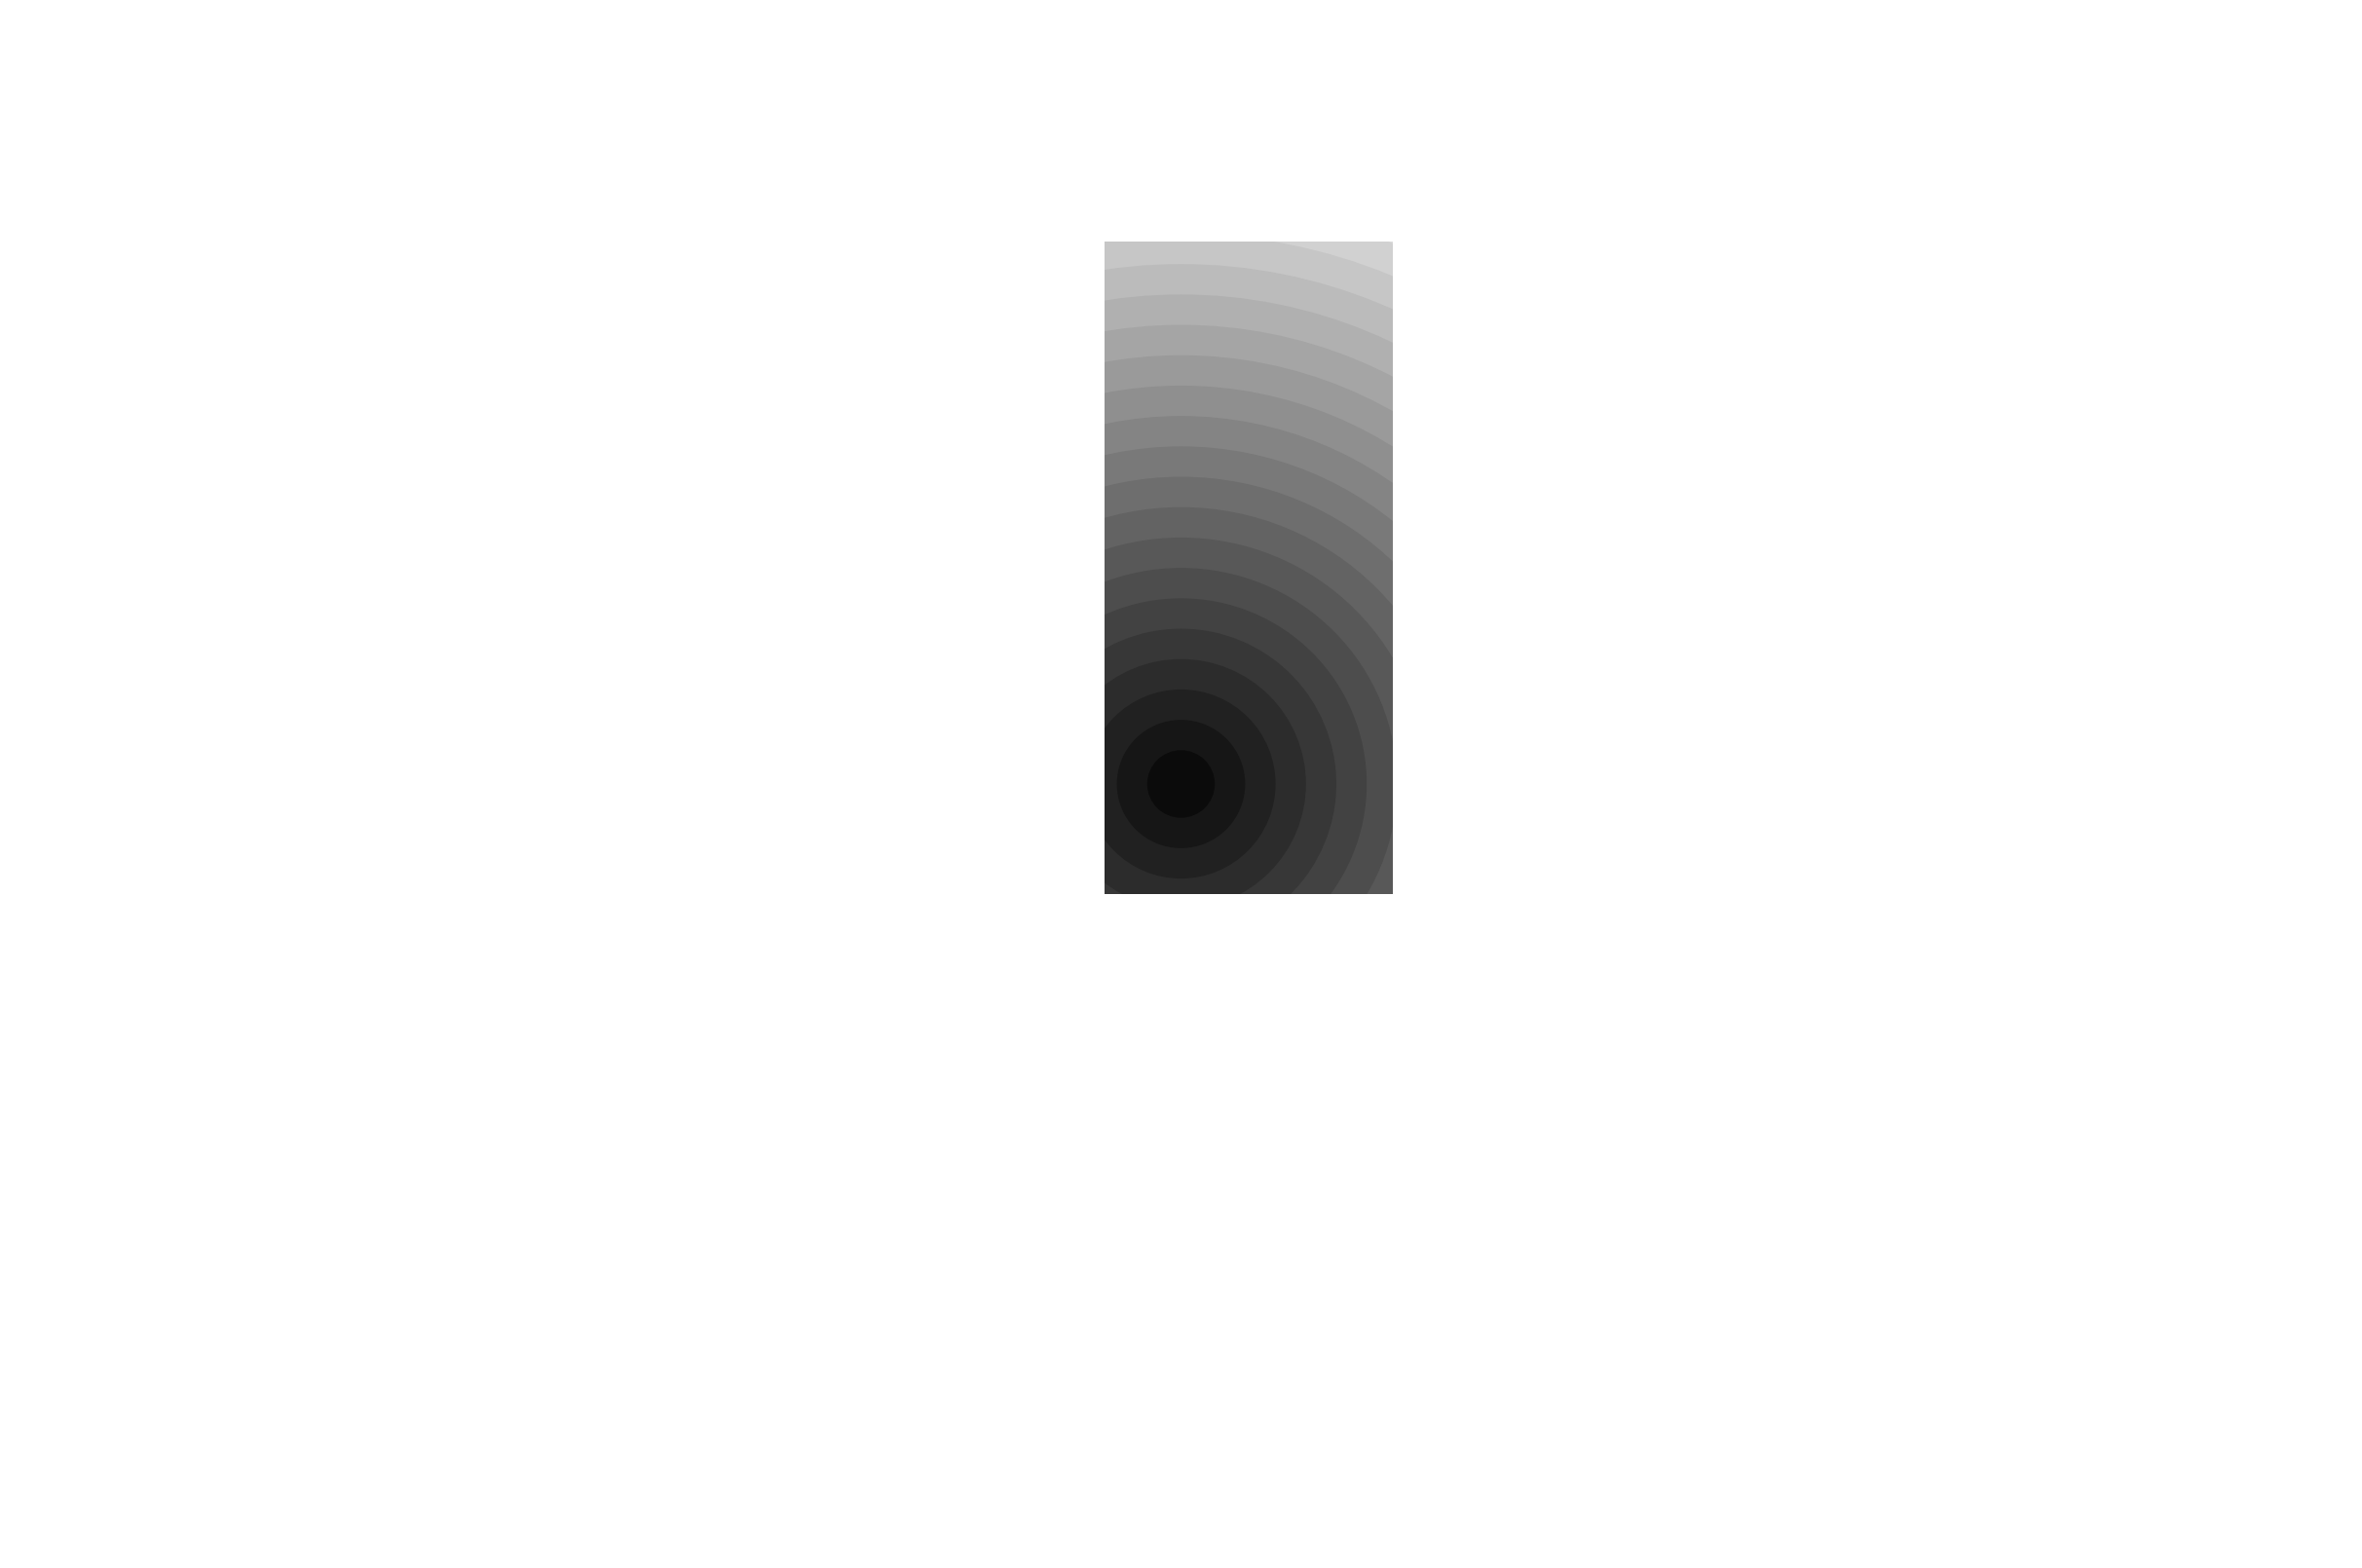

(-0.161819261454925, -0.5287954870929873)
Time                      1.61364e+09
RatX                        -0.210113
RatY                        -0.500039
RatZ                         0.622814
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.61364e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 537, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e

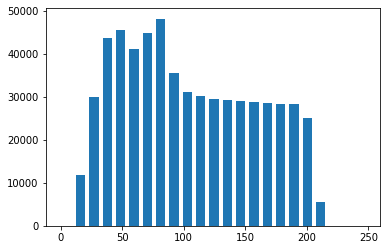

[0.00886616 0.00173785 0.         0.00114028 0.         0.
 0.         0.00438486 0.00332789 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.00886616 0.00173785 0.         0.00114028 0.         0.
 0.         0.00438486 0.00332789 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
25


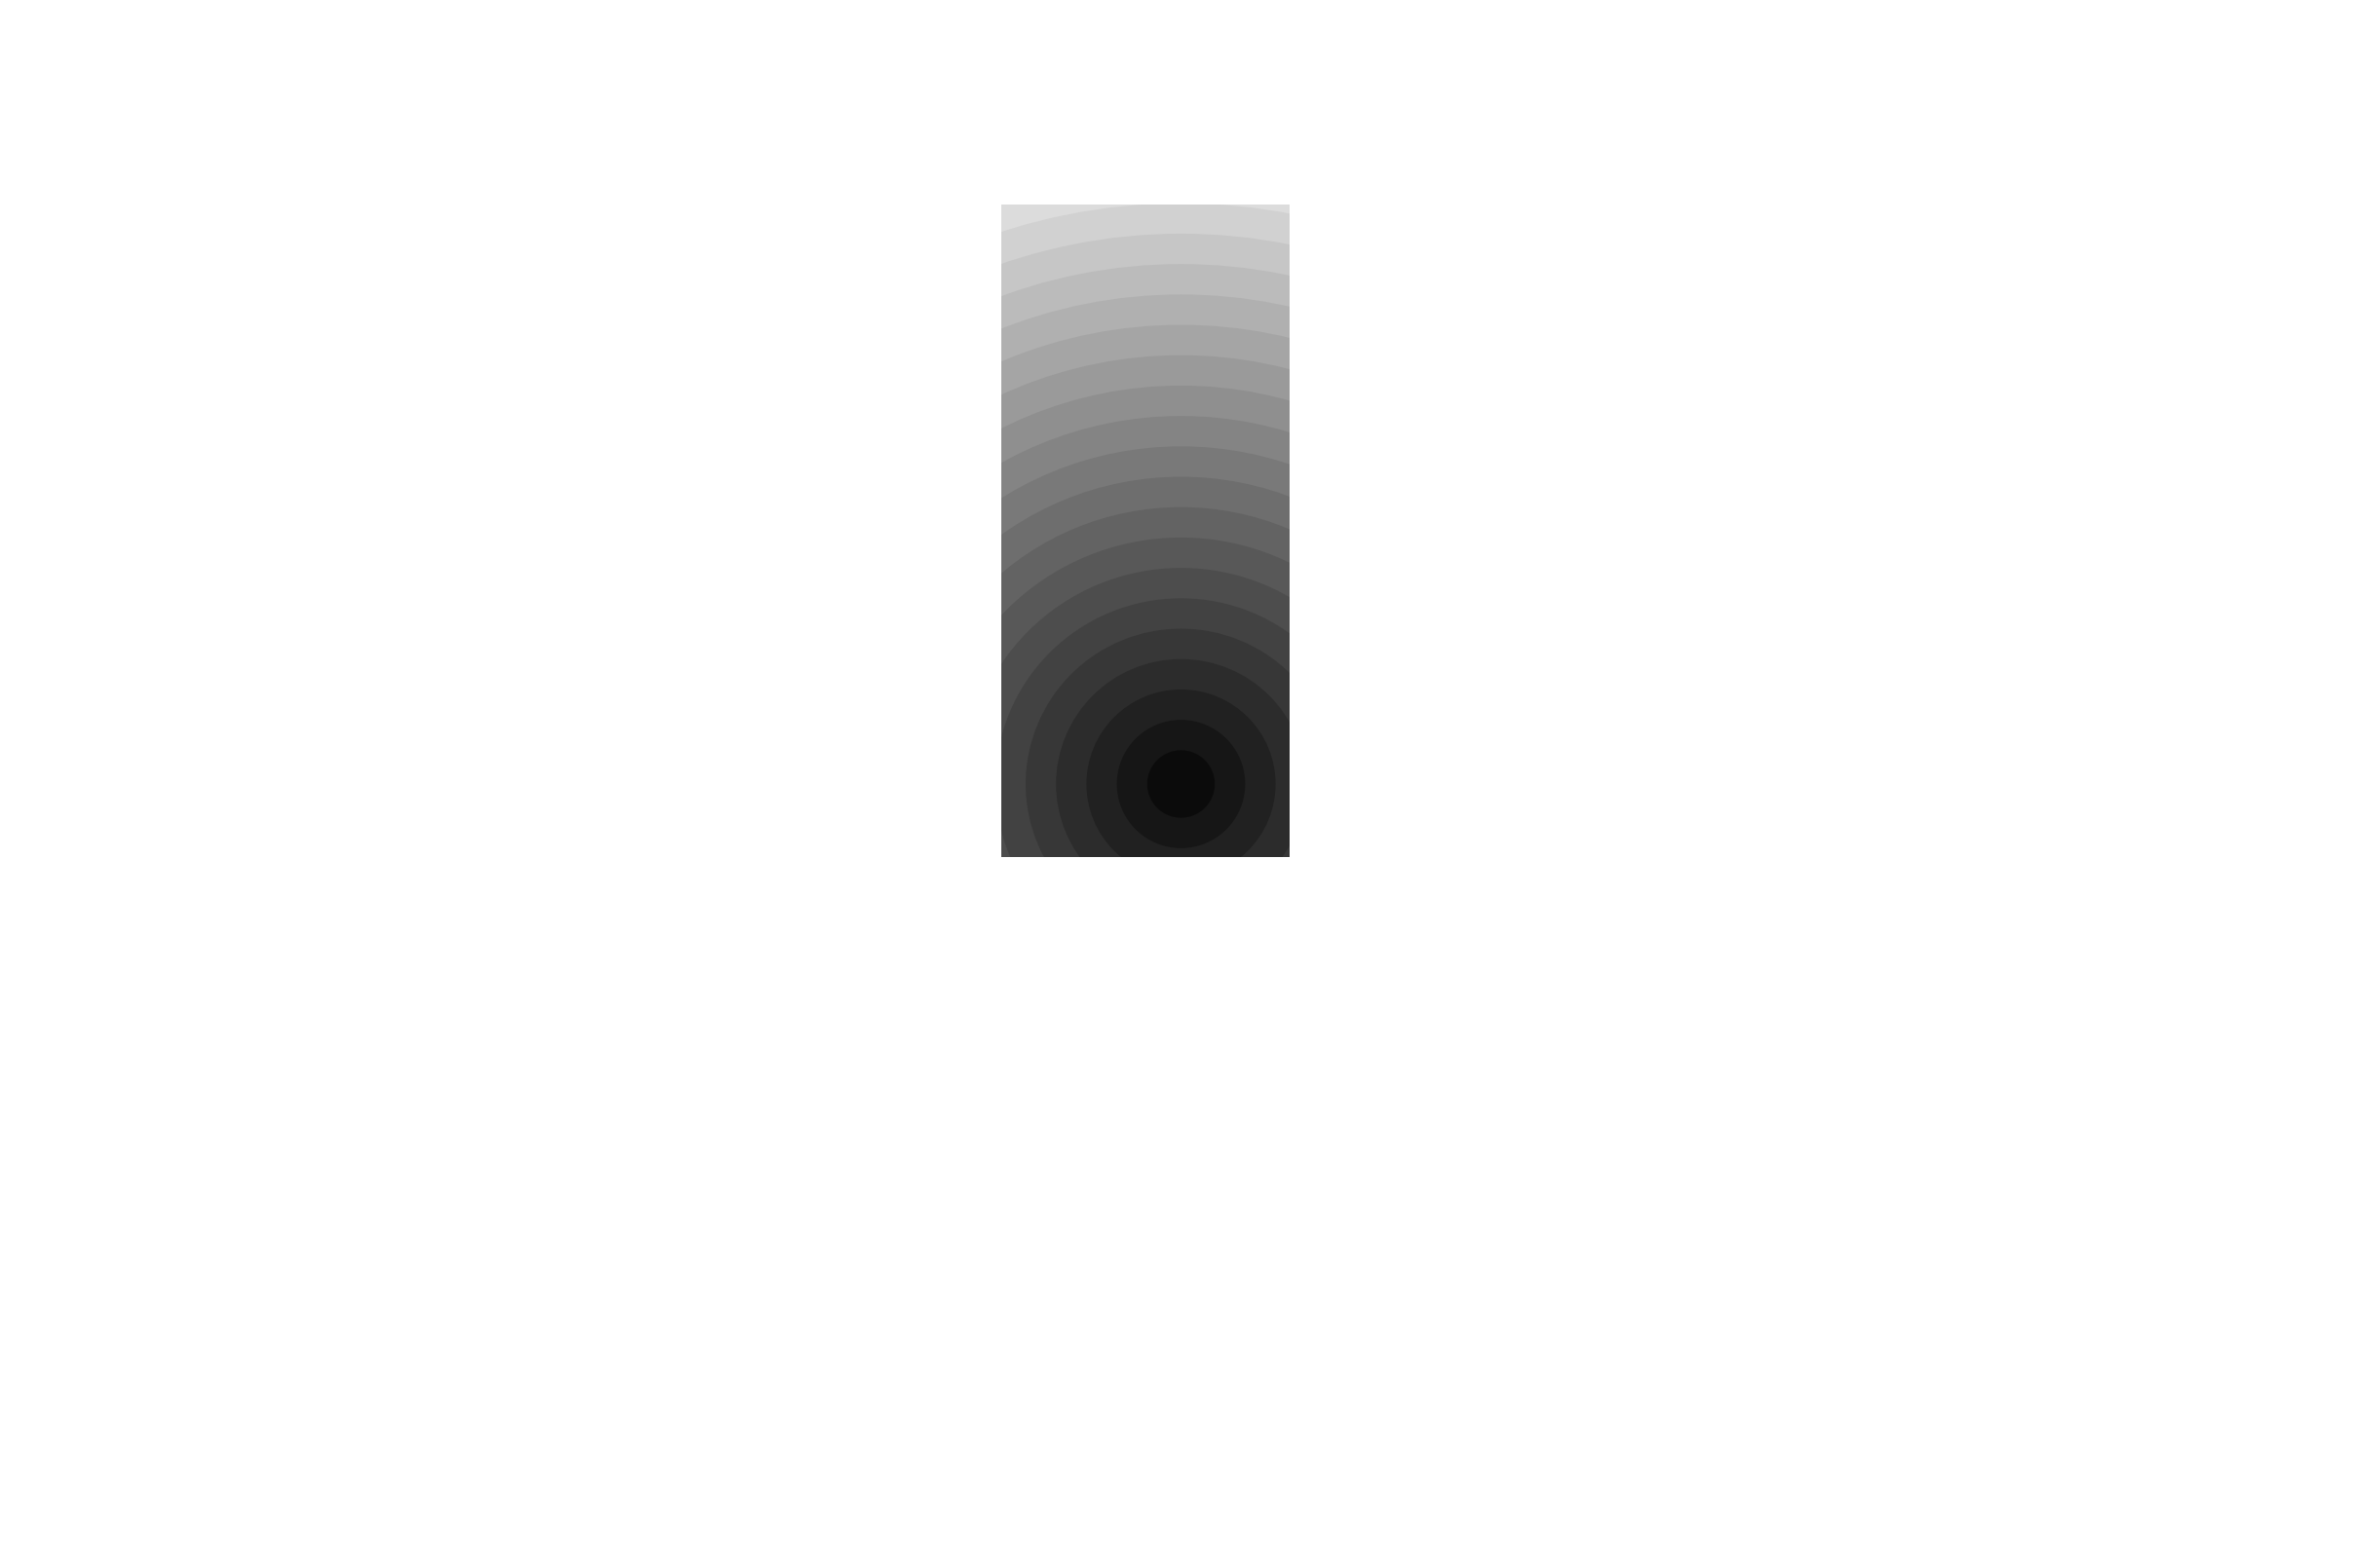

(0.09295046569360456, -0.6206400758464755)
Time                      1.61364e+09
RatX                        0.0656295
RatY                        -0.535225
RatZ                         0.621653
BeaconX                     0.0929505
BeaconY                      -0.62064
Visibility                          1
time_of_beacon_trigger    1.61364e+09
Beacon_group                        2
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 556, dtype: object
23
[    0 11730 29922 42450 44136 40377 43110 32808 30636 29841 29295 28875
 28695 28557 28449 28326 28221 28095 28101 27849  5487     0     0]
[11730 29922 42450 44136 40377 43110 32808 30636 29841 29295 28875 28695
 28557 28449 28326 28221 28095 28101 27849  5487]
[225.57692308 575.42307692 816.34615385 848.76923077 776.48076923
 829.03846154 630.92307692 589.15384615 573.86538462 563.36538462
 555.28846154 551.82692308 549.17307692 547.09615385 544.73076923
 542.711538

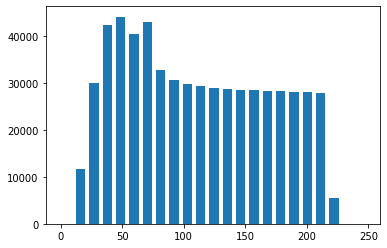

[0.02216539 0.00695141 0.00122497 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.02216539 0.00695141 0.00122497 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
26


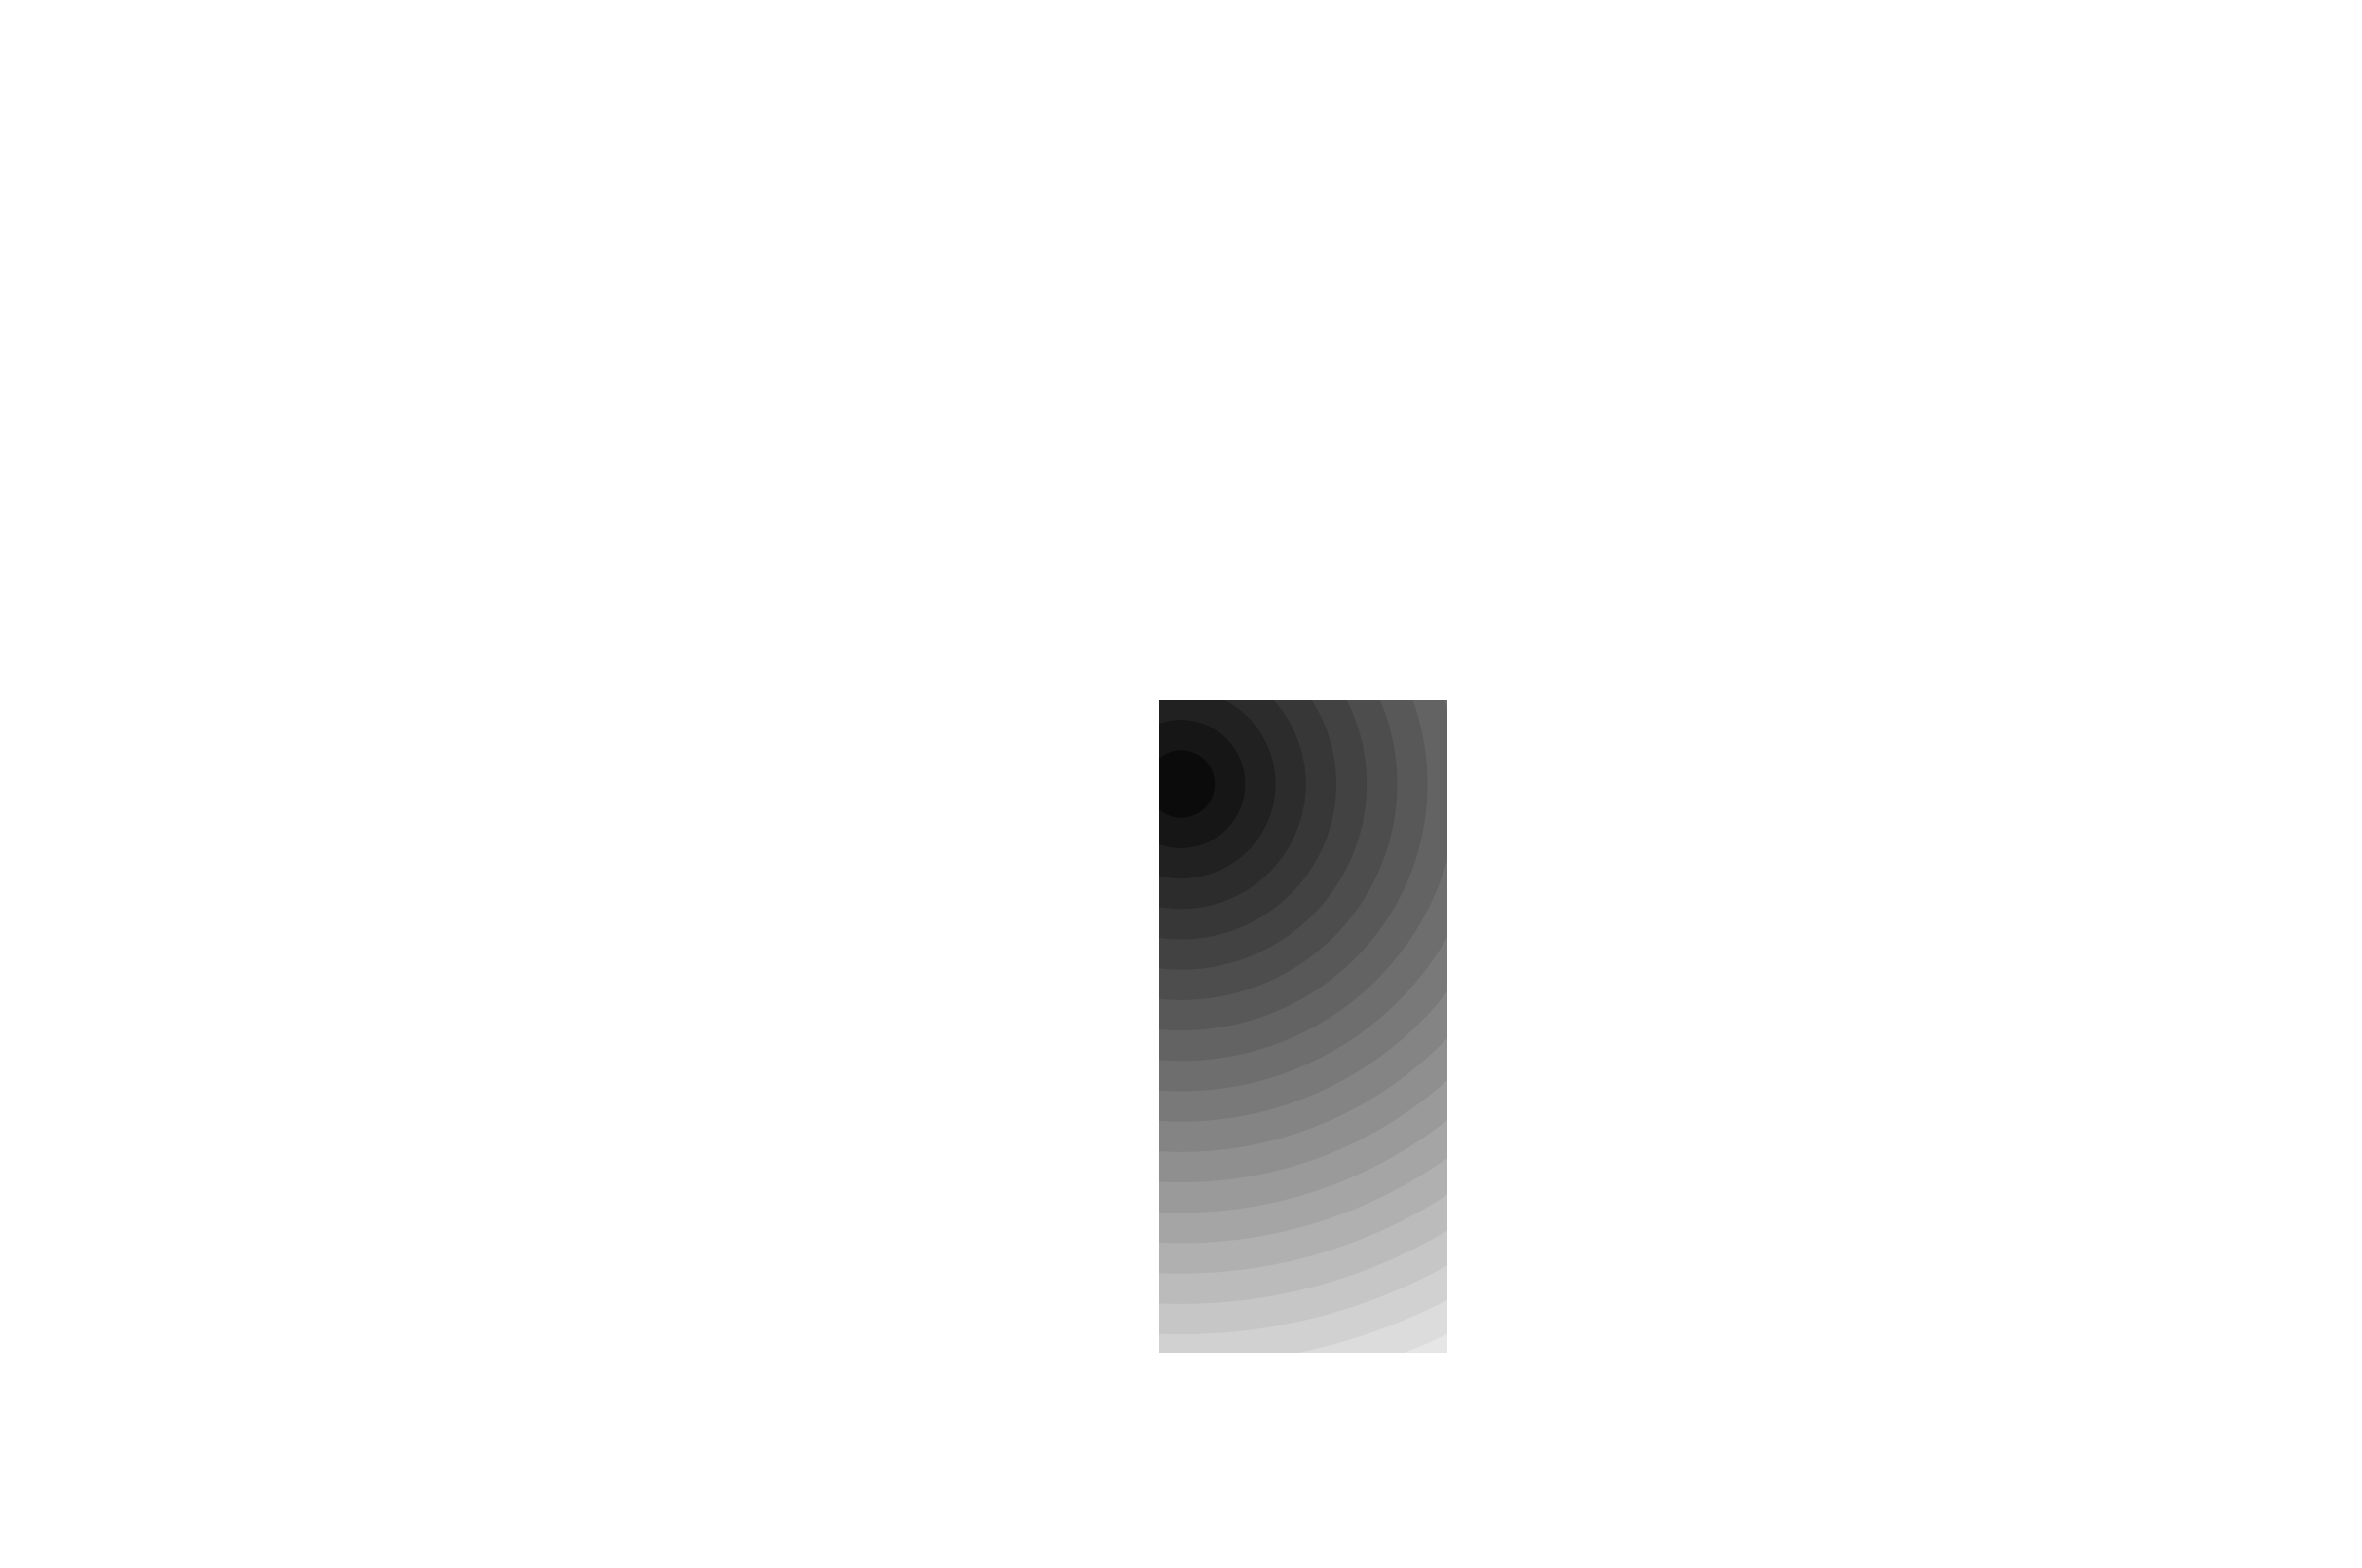

(-0.2963966574916079, 0.6040748180763695)
Time                      1.61365e+09
RatX                        -0.305637
RatY                         0.650557
RatZ                         0.624798
BeaconX                     -0.296397
BeaconY                      0.604075
Visibility                          1
time_of_beacon_trigger    1.61365e+09
Beacon_group                        3
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 581, dtype: object
23
[    0 10272 19344 26589 27954 31737 36357 40770 45297 46365 34464 32157
 31101 30396 29943 29571 29271 28998 28875 24921  9375  1203     0]
[10272 19344 26589 27954 31737 36357 40770 45297 46365 34464 32157 31101
 30396 29943 29571 29271 28998 28875 24921  9375  1203]
[197.53846154 372.         511.32692308 537.57692308 610.32692308
 699.17307692 784.03846154 871.09615385 891.63461538 662.76923077
 618.40384615 598.09615385 584.53846154 575.82692308 568.67307692
 562.9

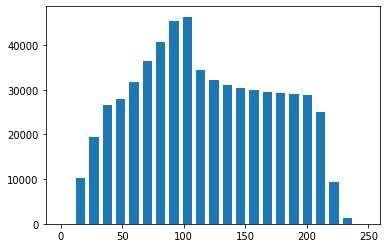

[0.04556075 0.00268817 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
21
[0.04556075 0.00268817 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
27


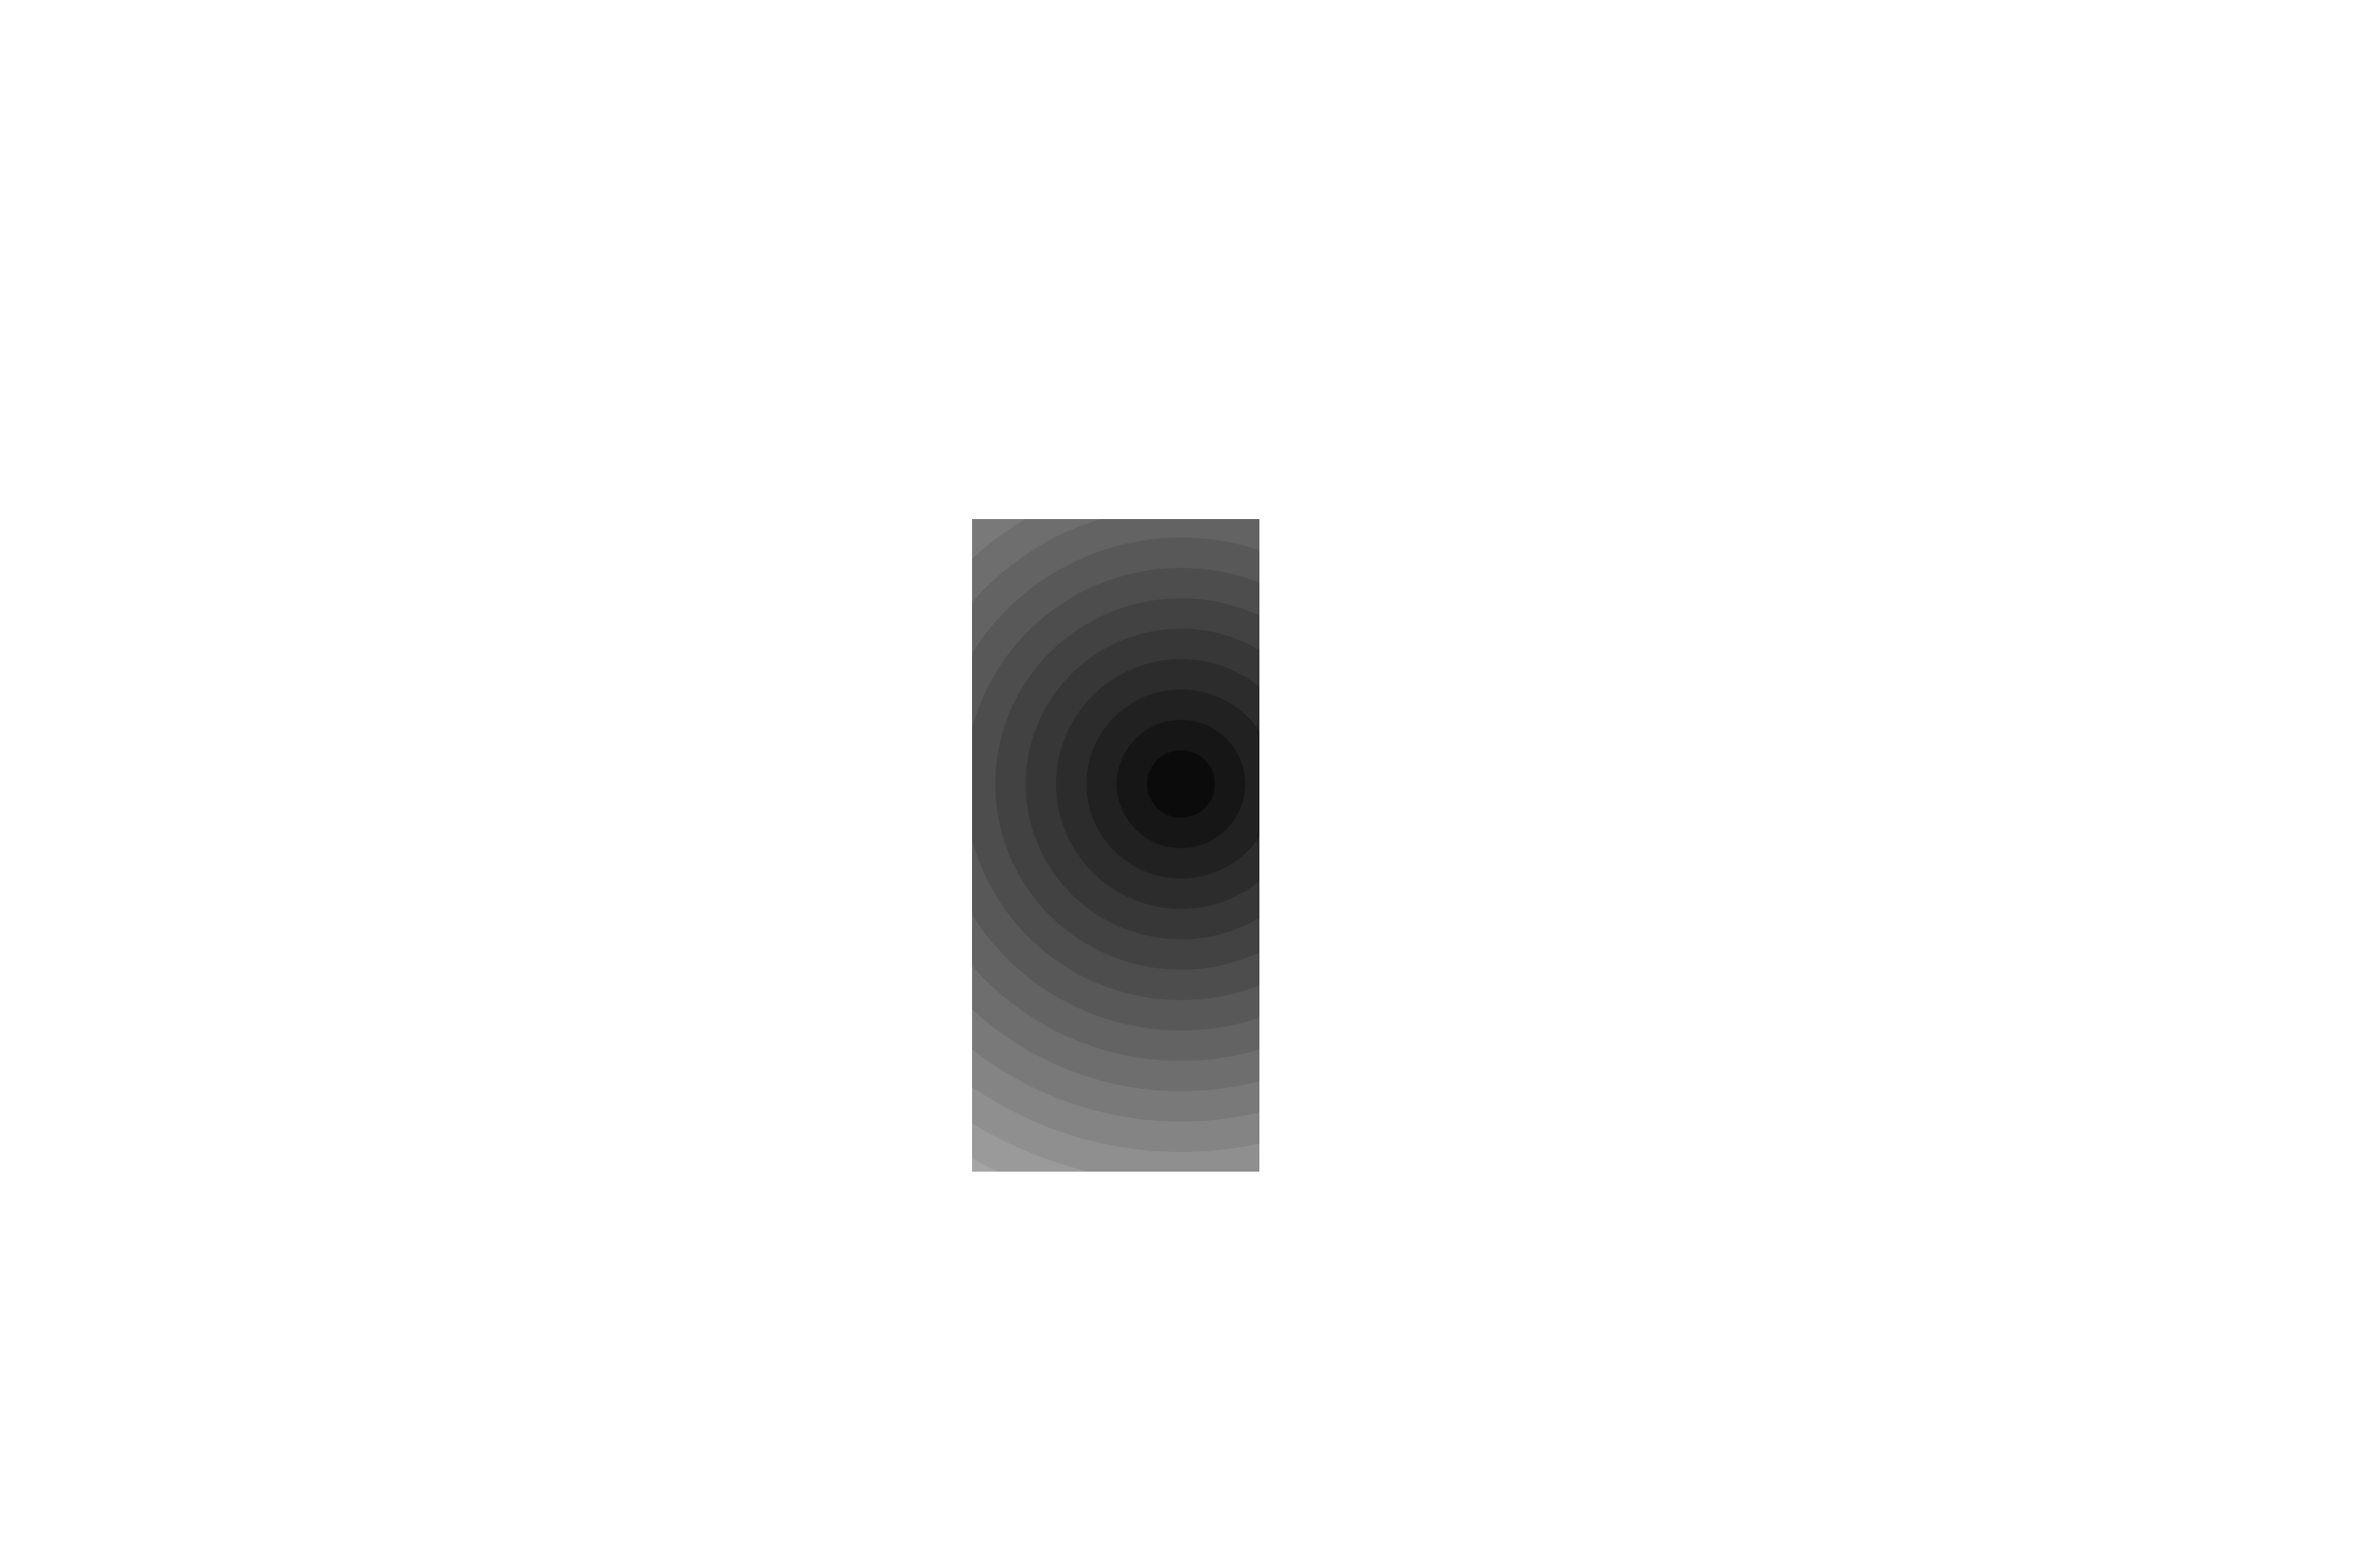

(0.1654387602688046, 0.1565543316311422)
Time                      1.61365e+09
RatX                         0.153254
RatY                          0.15608
RatZ                         0.620735
BeaconX                      0.165439
BeaconY                      0.156554
Visibility                          1
time_of_beacon_trigger    1.61365e+09
Beacon_group                        4
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 606, dtype: object
23
[    0 11730 29922 44415 50127 58005 67302 74391 65676 57684 40203 32385
 29049 24558  7005   498     0     0     0     0     0     0     0]
[11730 29922 44415 50127 58005 67302 74391 65676 57684 40203 32385 29049
 24558  7005   498]
[ 225.57692308  575.42307692  854.13461538  963.98076923 1115.48076923
 1294.26923077 1430.59615385 1263.         1109.30769231  773.13461538
  622.78846154  558.63461538  472.26923077  134.71153846    9.57692308]
15
23
[7 4 1 0 0 0 0 0 0 0 

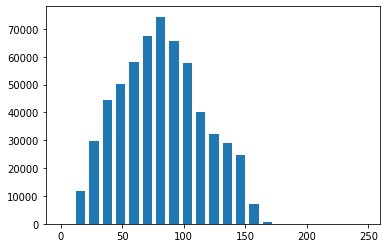

[0.03103154 0.00695141 0.00117078 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00742327 0.        ]
15
[0.03103154 0.00695141 0.00117078 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00742327 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
28


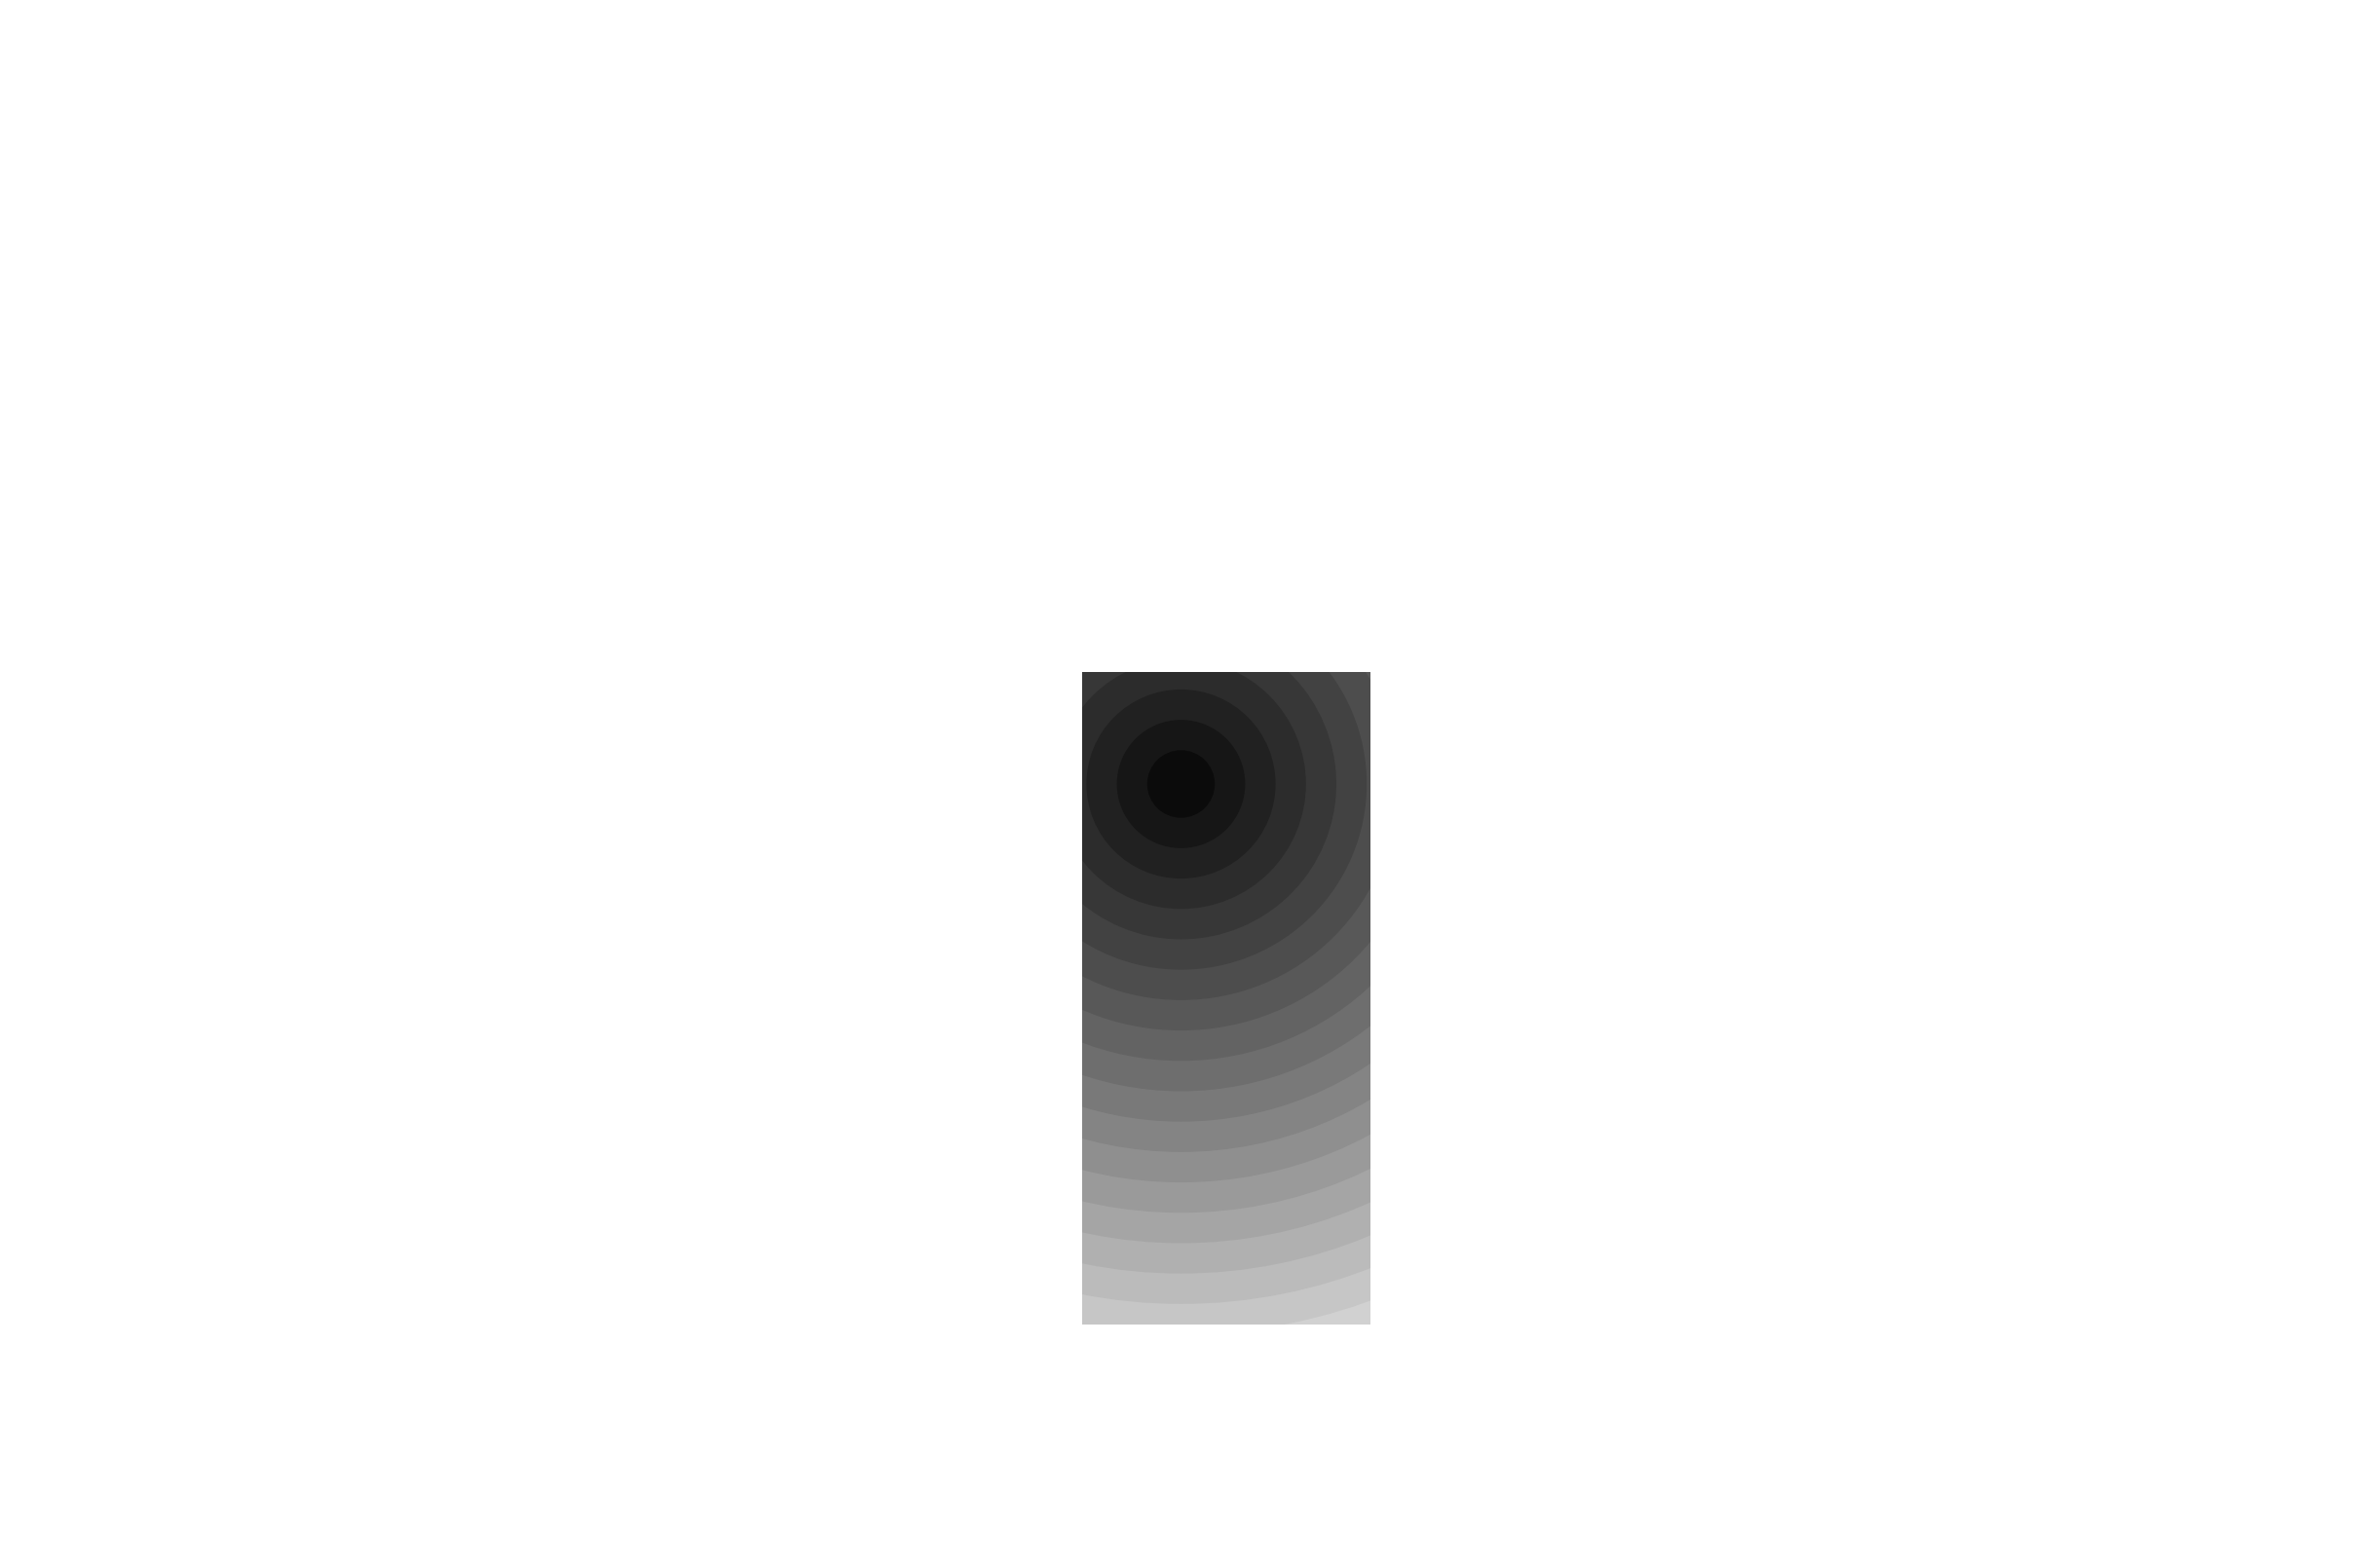

(-0.106570953775193, 0.5331481848245512)
Time                      1.61365e+09
RatX                          0.18107
RatY                        -0.753496
RatZ                         0.624356
BeaconX                     -0.106571
BeaconY                      0.533148
Visibility                          1
time_of_beacon_trigger    1.61365e+09
Beacon_group                        5
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 634, dtype: object
23
[    0 11730 29922 48279 54435 45933 47718 39618 31203 30144 29502 29031
 28809 28647 28530 28395 28281 28146 23784  2853     0     0     0]
[11730 29922 48279 54435 45933 47718 39618 31203 30144 29502 29031 28809
 28647 28530 28395 28281 28146 23784  2853]
[ 225.57692308  575.42307692  928.44230769 1046.82692308  883.32692308
  917.65384615  761.88461538  600.05769231  579.69230769  567.34615385
  558.28846154  554.01923077  550.90384615  548.65384615  546.05769231
  54

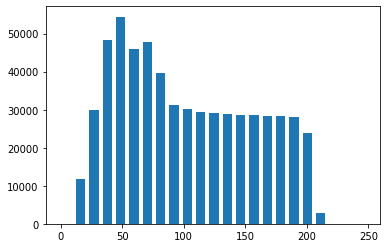

[0.03103154 0.01042711 0.         0.00095527 0.         0.
 0.0039376  0.00499952 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00218634
 0.        ]
19
[0.03103154 0.01042711 0.         0.00095527 0.         0.
 0.0039376  0.00499952 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00218634
 0.         0.         0.         0.         0.        ]
23
29


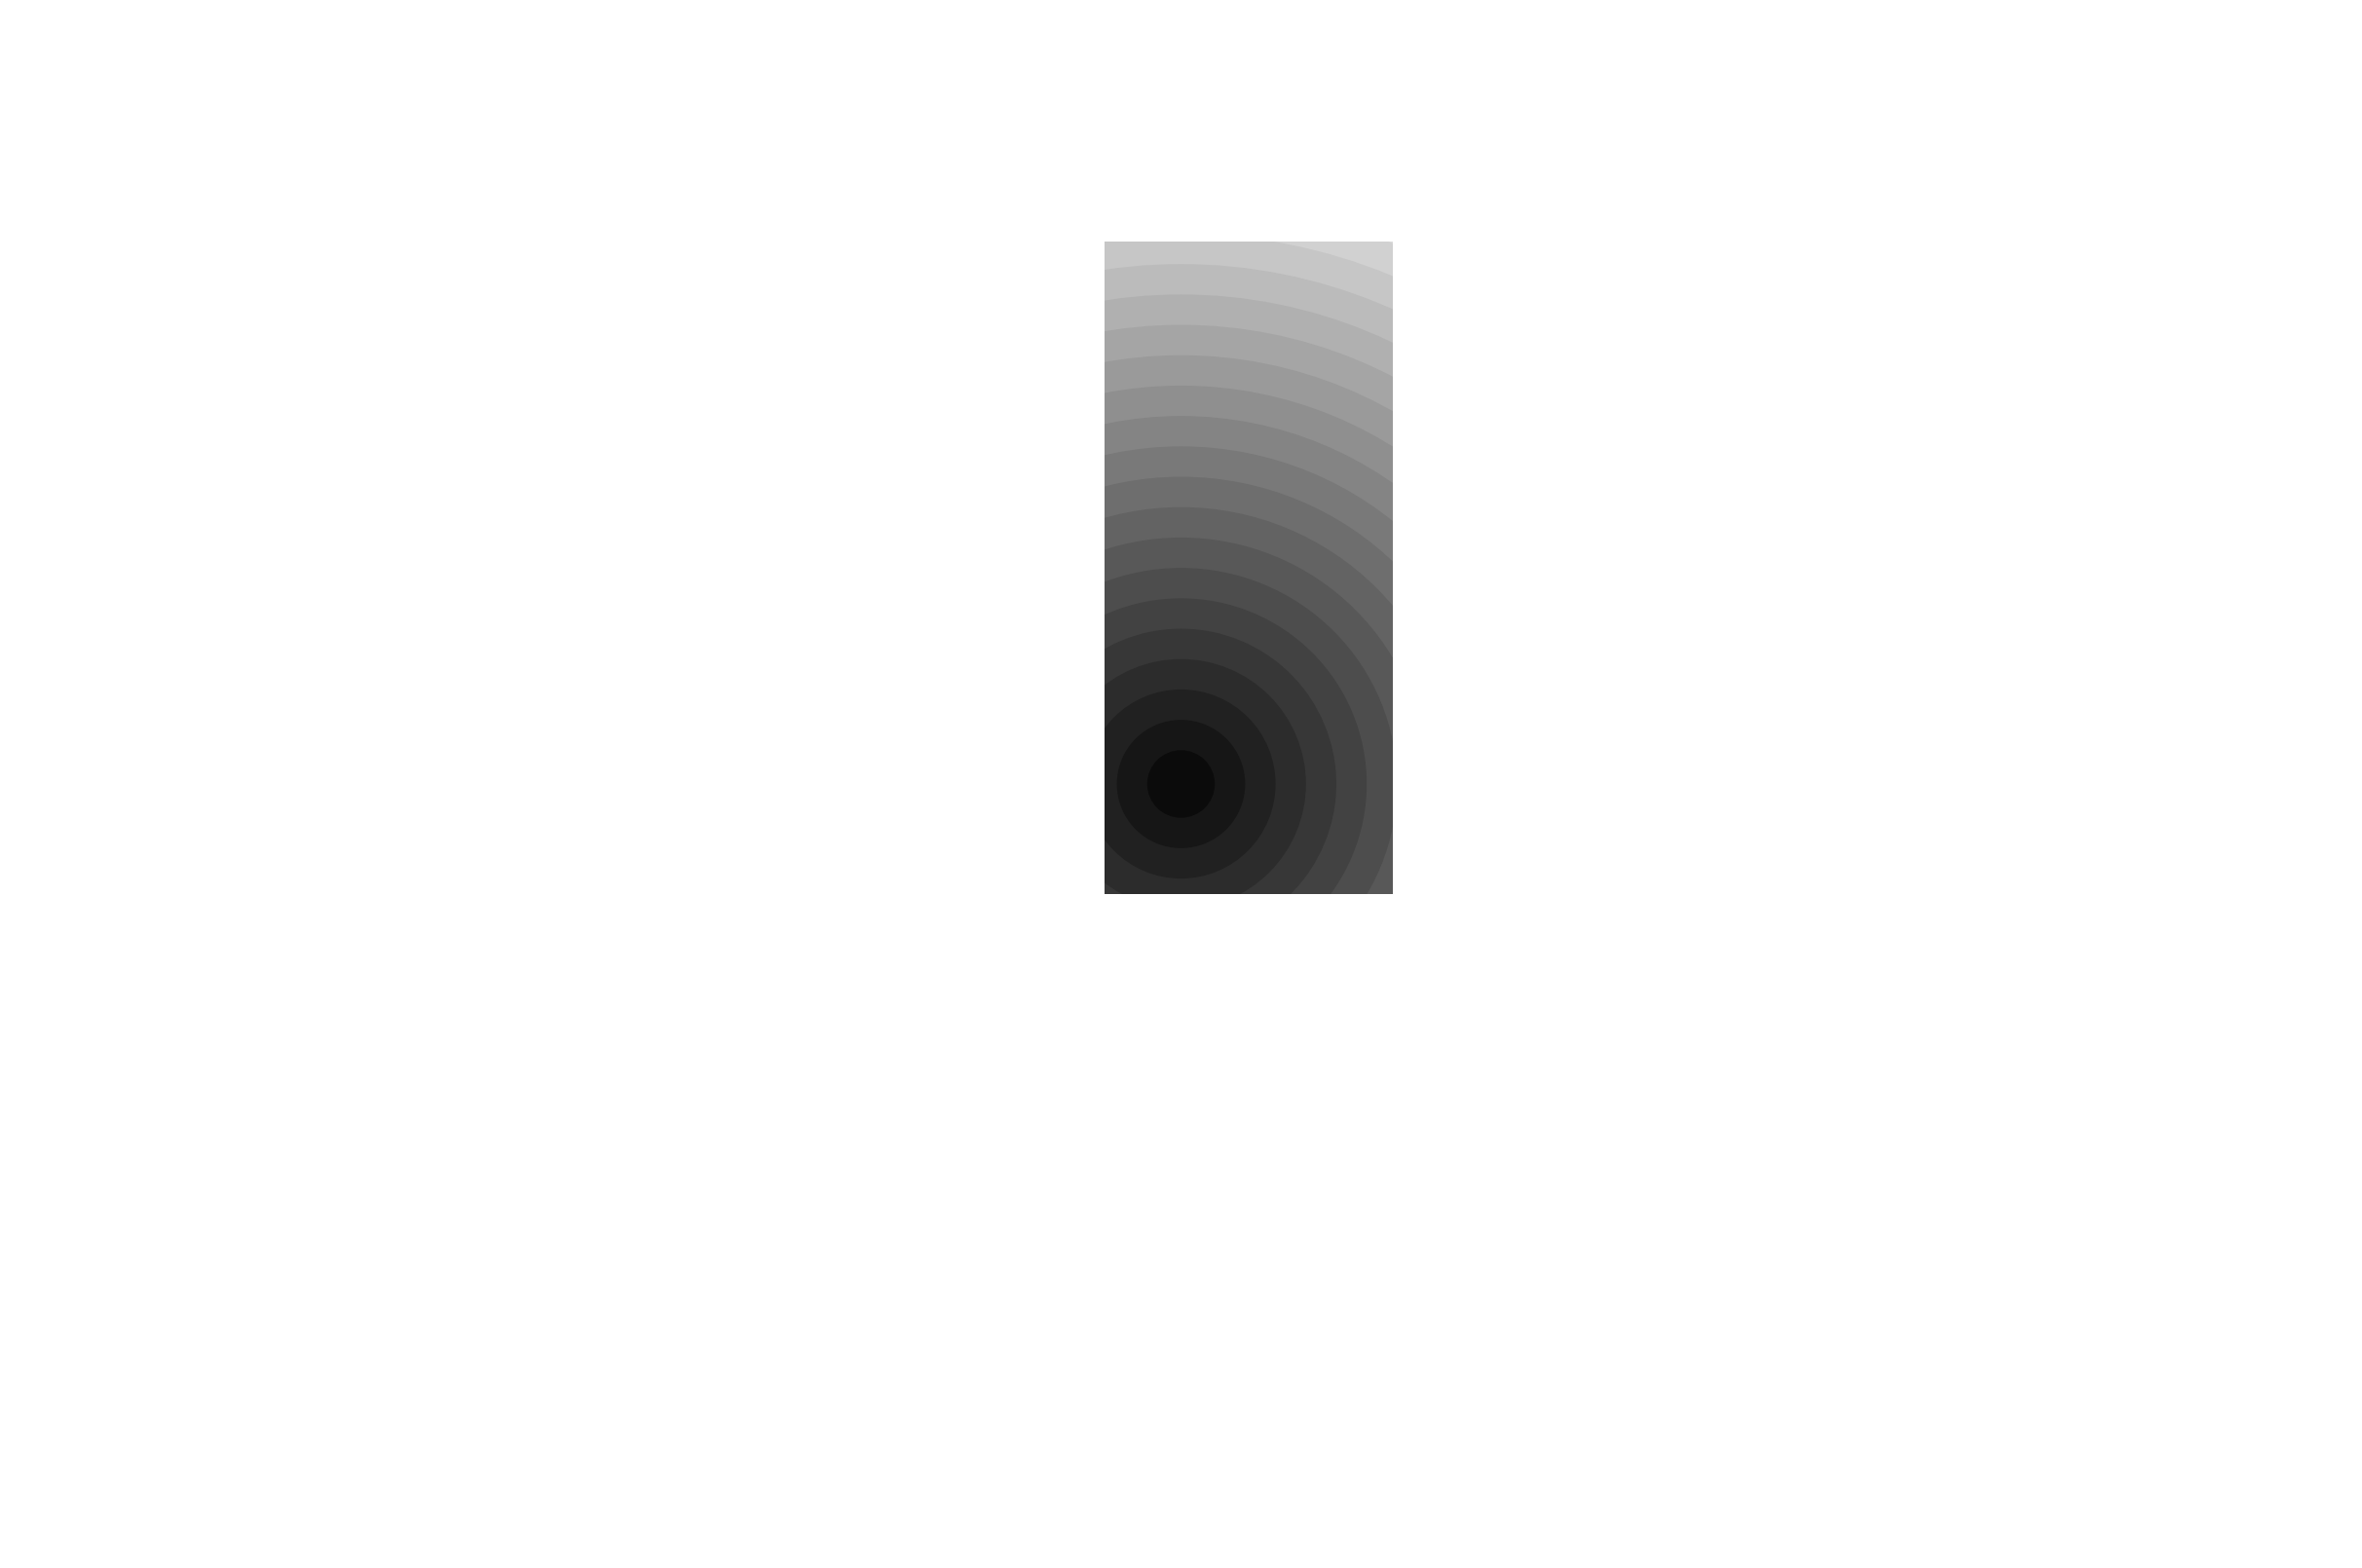

(-0.161819261454925, -0.5287954870929873)
Time                      1.6141e+09
RatX                      0.00987536
RatY                        0.519045
RatZ                        0.724422
BeaconX                    -0.161819
BeaconY                    -0.528795
Visibility                         1
time_of_beacon_trigger    1.6141e+09
Beacon_group                       1
Beacon_subgroup                    1
trial_in_next                   True
13                              True
Name: 641, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e+02 5.502115

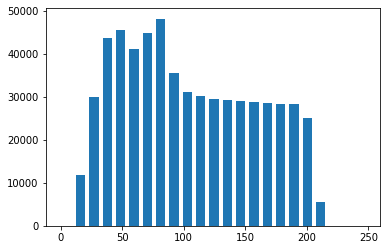

[0.00443308 0.00173785 0.         0.         0.0012641  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00181748 0.         0.         0.
 0.00942029 0.        ]
20
[0.00443308 0.00173785 0.         0.         0.0012641  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00181748 0.         0.         0.
 0.00942029 0.         0.         0.         0.        ]
23
30


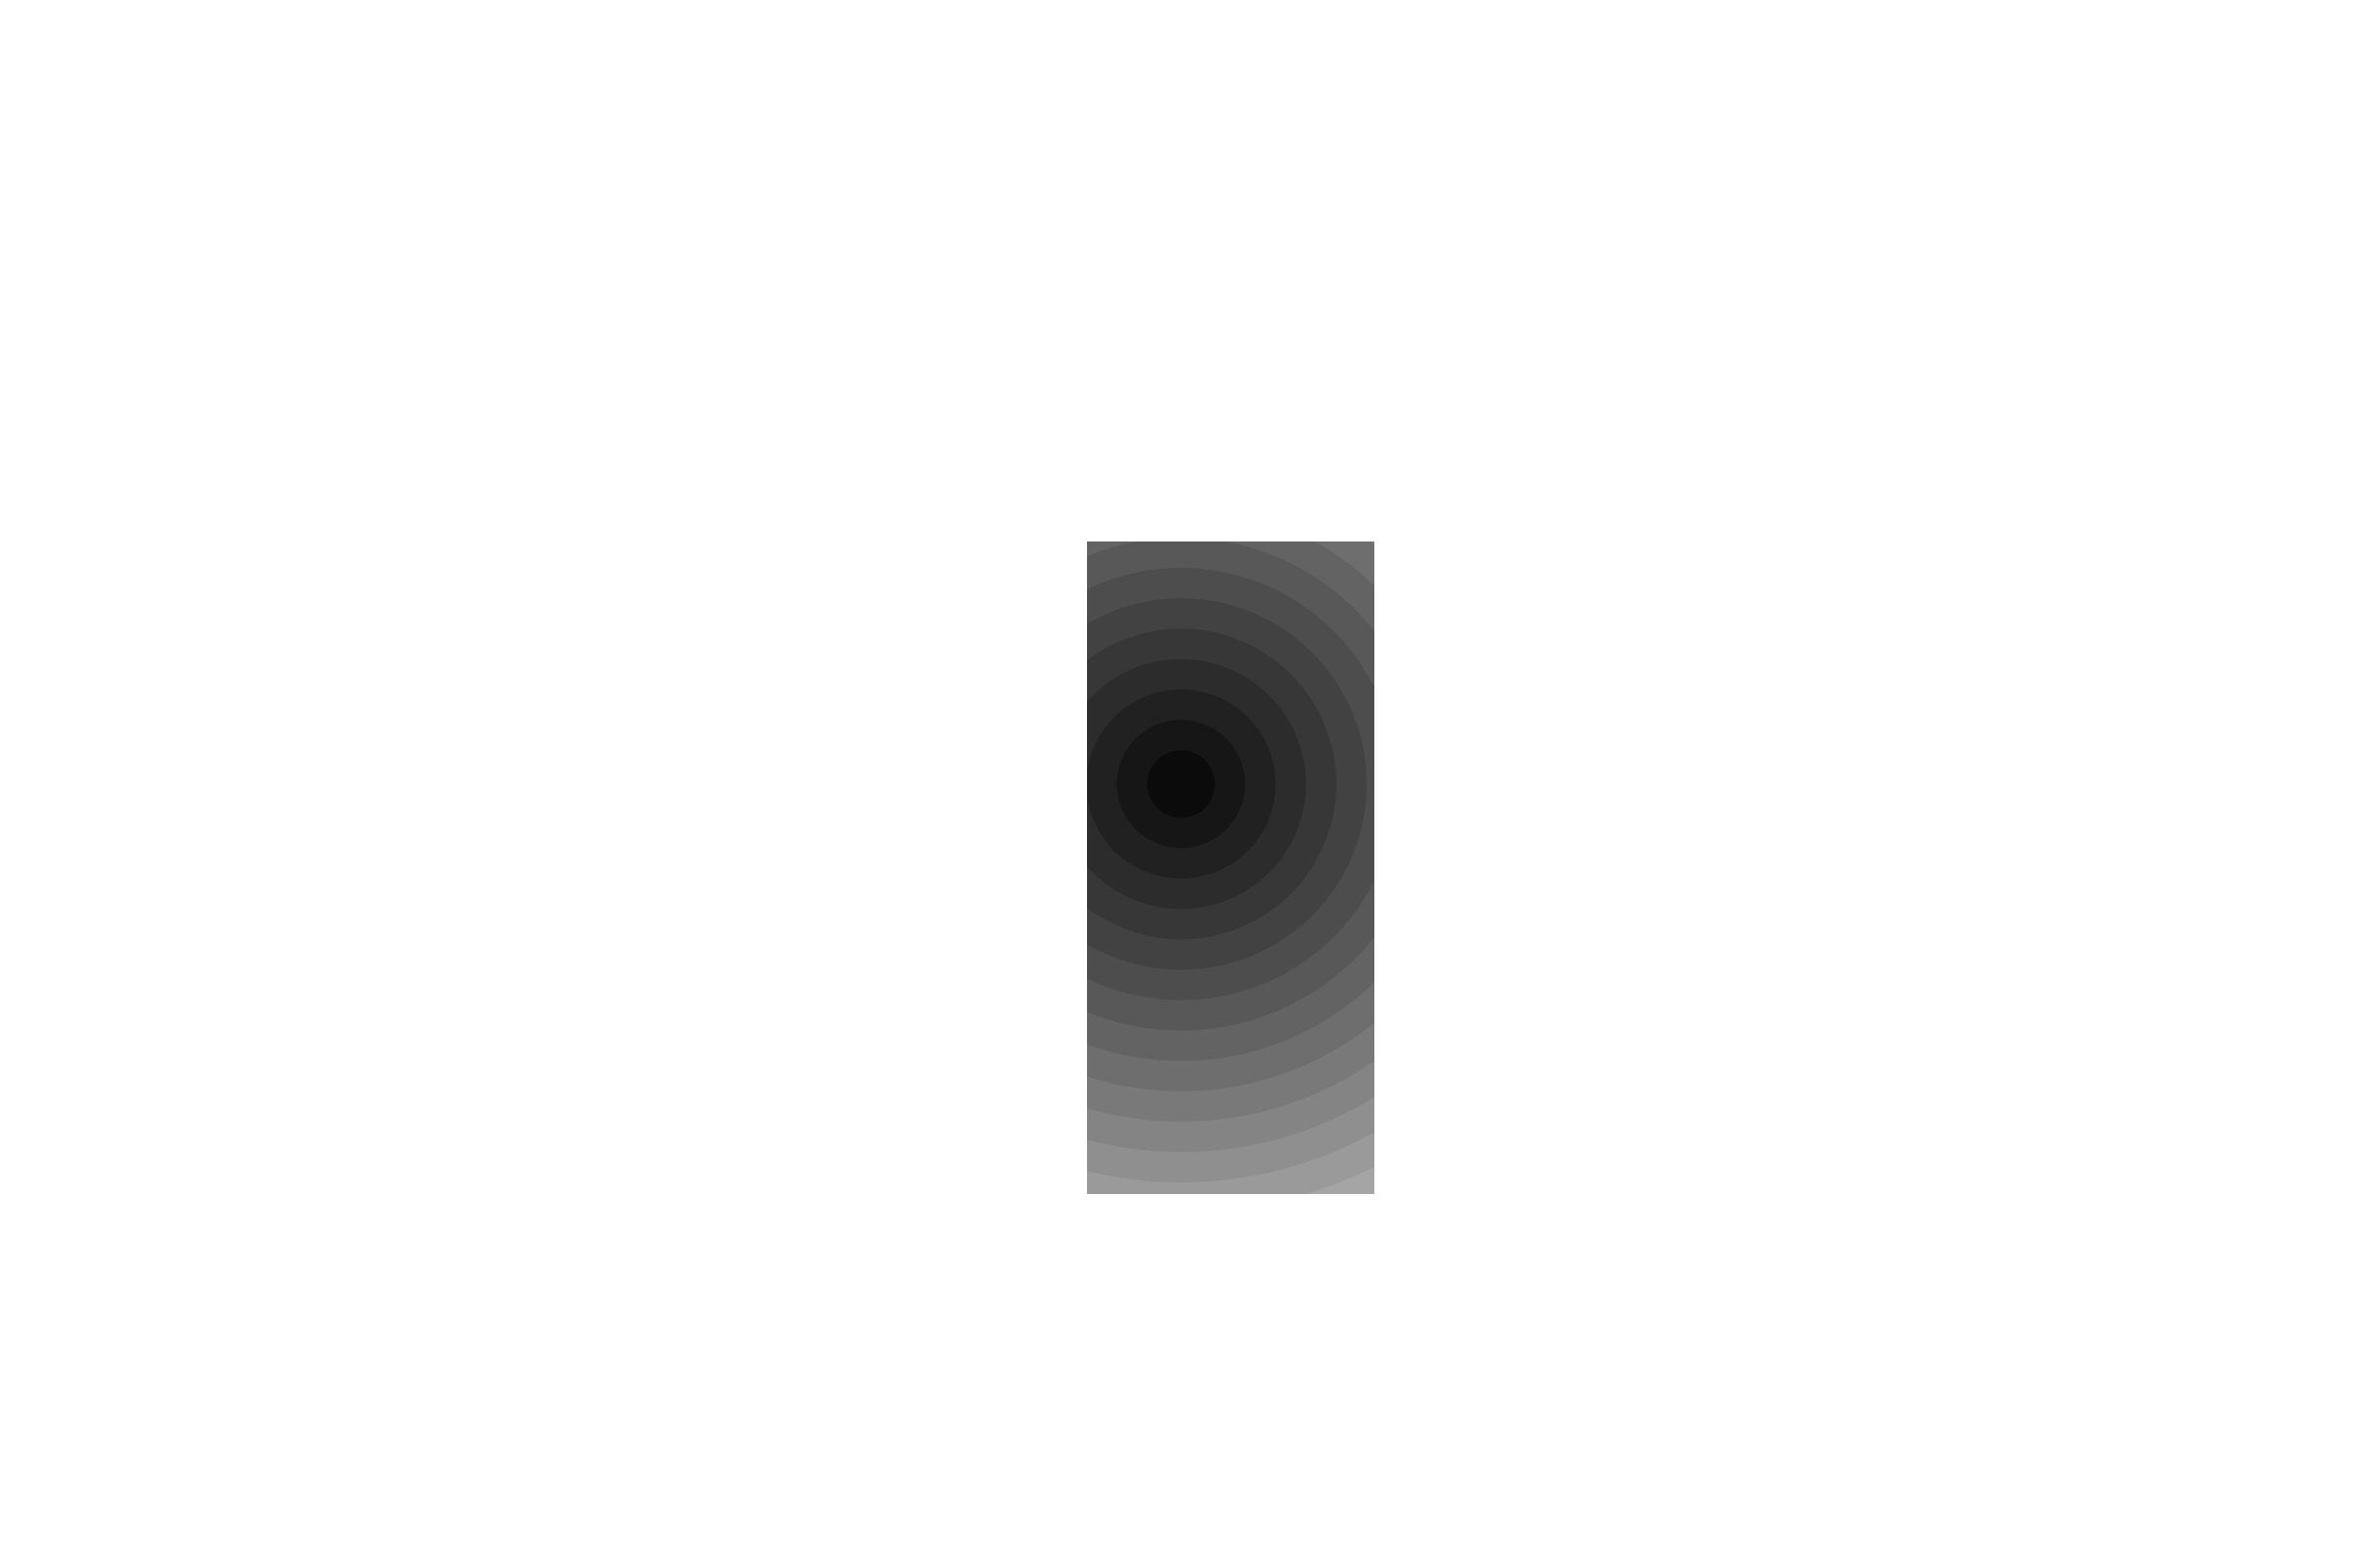

(-0.1181875251095623, 0.2121777071506047)
Time                      1.6141e+09
RatX                       -0.196231
RatY                        0.273434
RatZ                        0.627646
BeaconX                    -0.118188
BeaconY                     0.212178
Visibility                         1
time_of_beacon_trigger    1.6141e+09
Beacon_group                       2
Beacon_subgroup                    1
trial_in_next                   True
13                              True
Name: 659, dtype: object
23
[    0 11730 29922 48219 55281 61812 70779 69909 61812 42522 33189 29031
 28767 28593 18750  2634     0     0     0     0     0     0     0]
[11730 29922 48219 55281 61812 70779 69909 61812 42522 33189 29031 28767
 28593 18750  2634]
[ 225.57692308  575.42307692  927.28846154 1063.09615385 1188.69230769
 1361.13461538 1344.40384615 1188.69230769  817.73076923  638.25
  558.28846154  553.21153846  549.86538462  360.57692308   50.65384615]
15
23
[4 6 0 1 0 0 0 0 0 0 0 0 0 0 0]
15


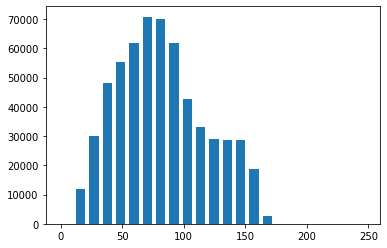

[0.01773231 0.01042711 0.         0.00094065 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
15
[0.01773231 0.01042711 0.         0.00094065 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
31


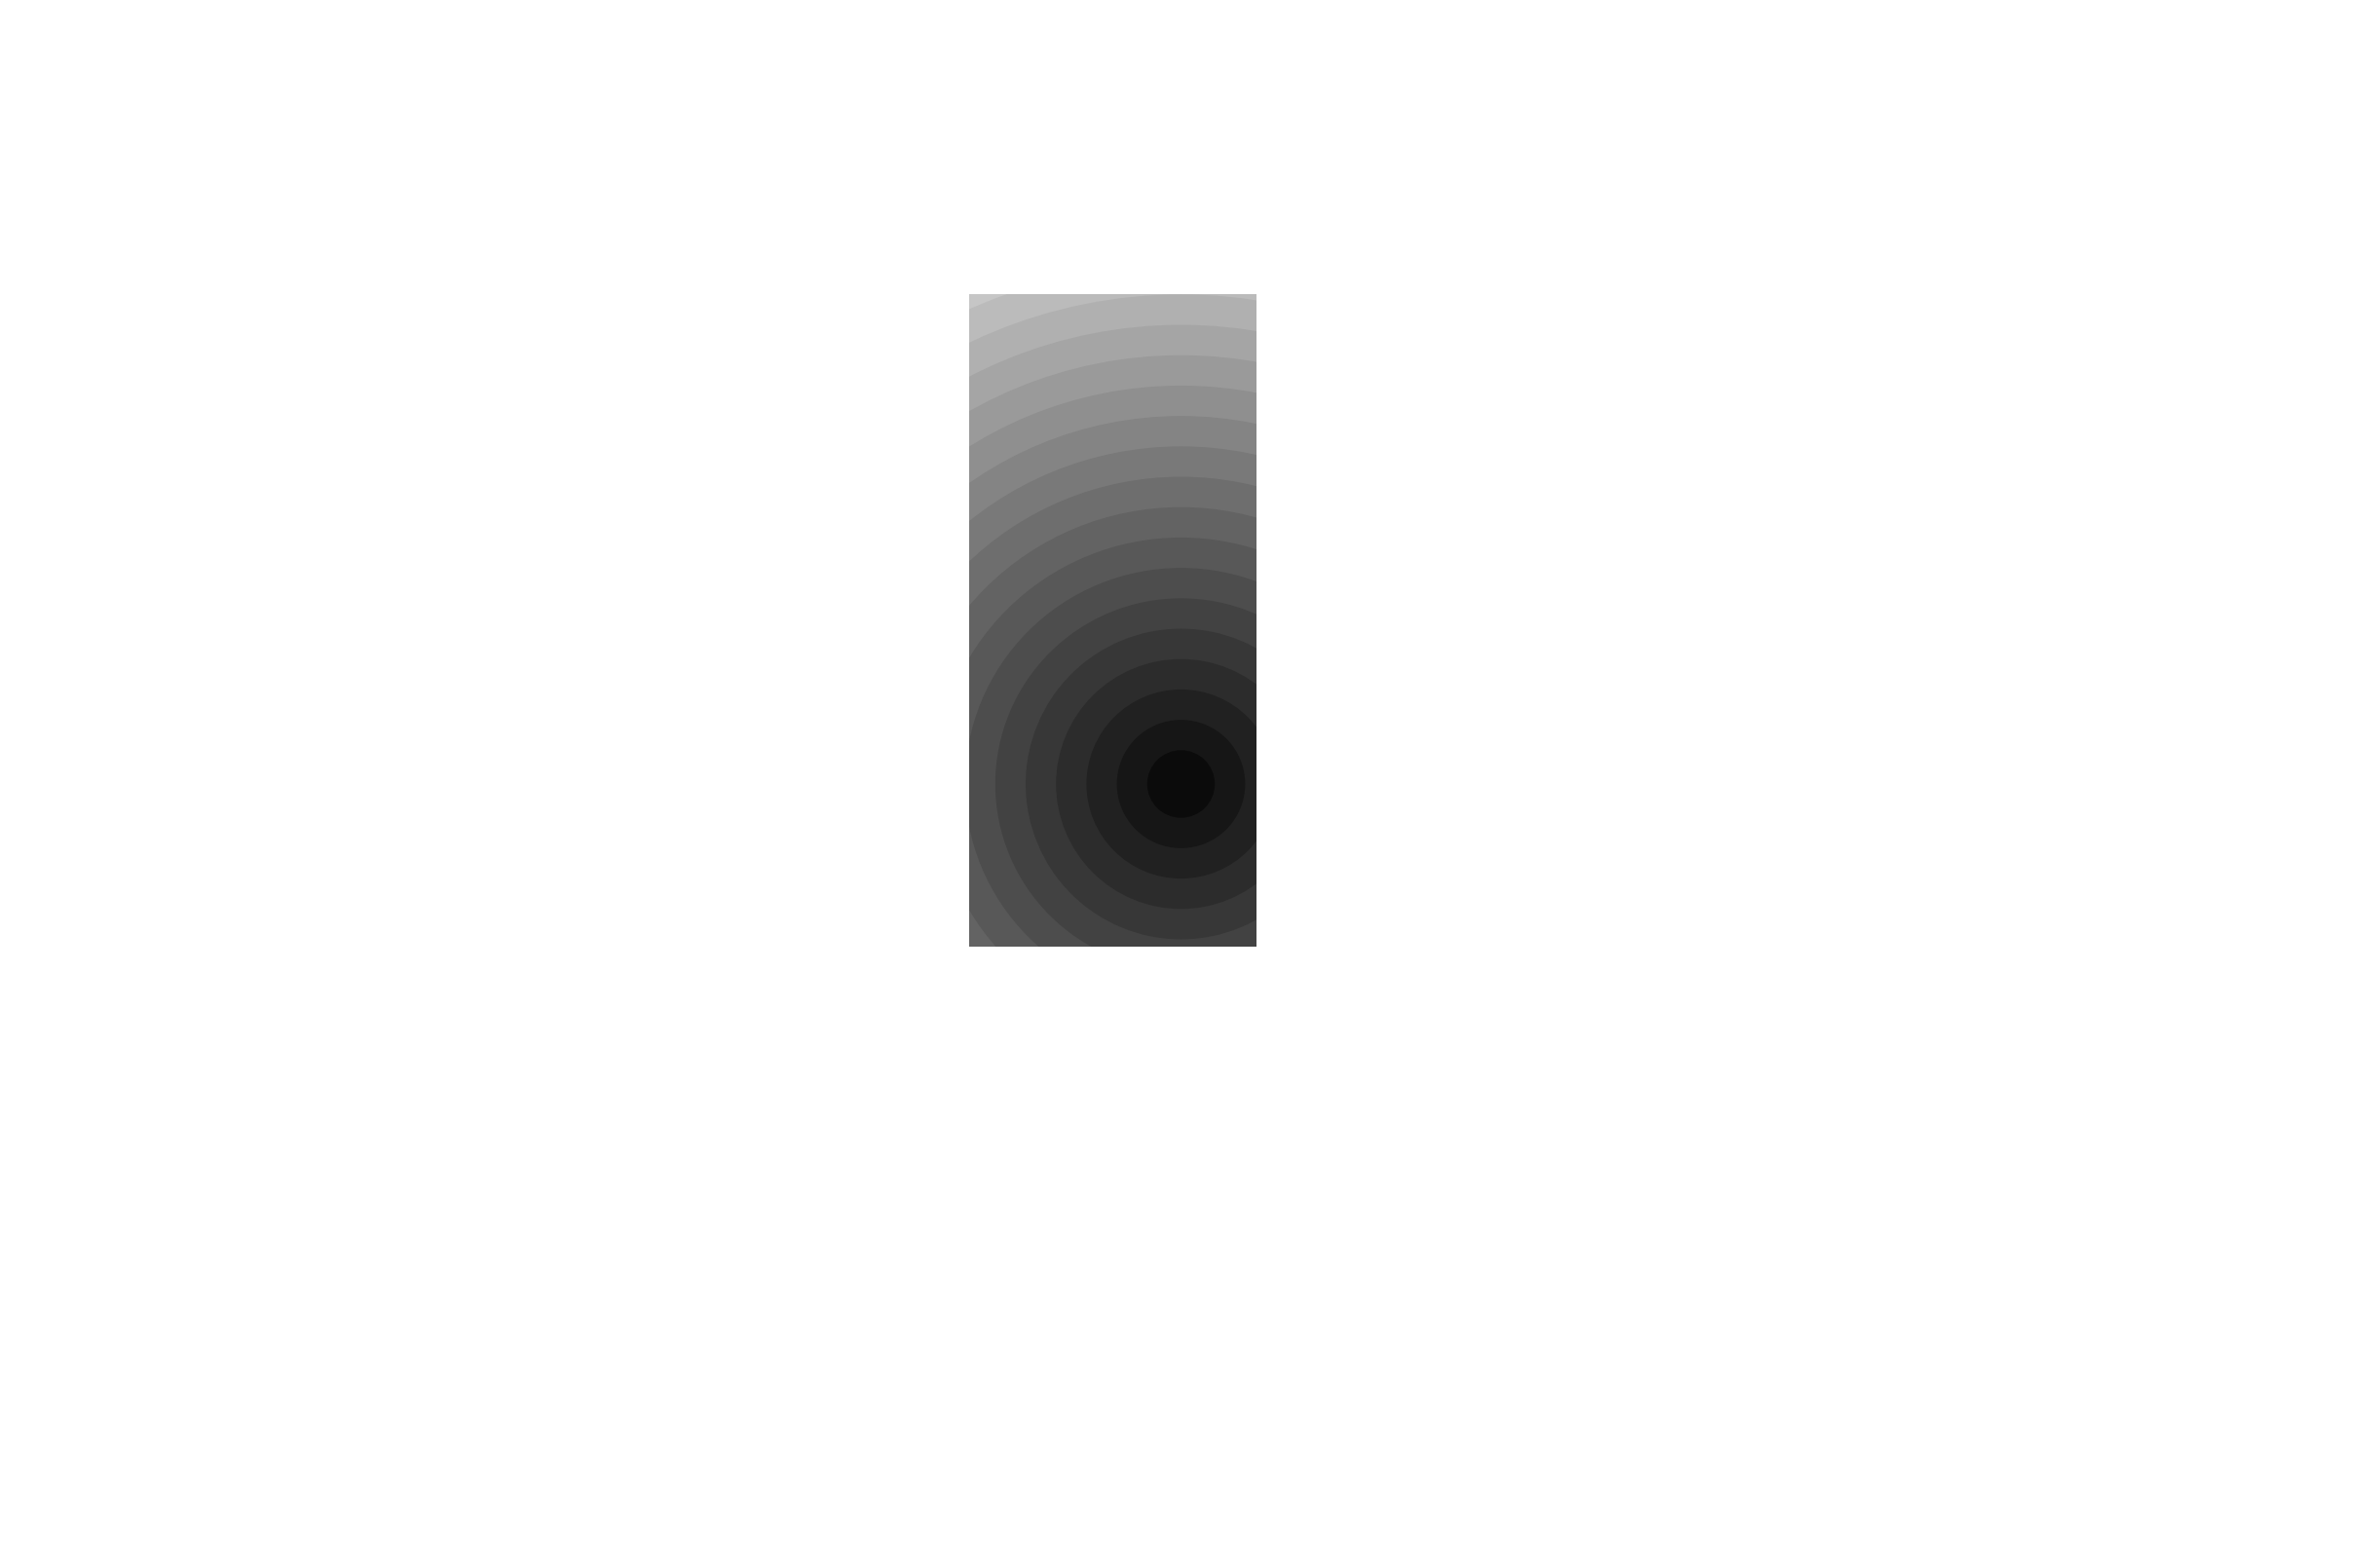

(0.1725371383669092, -0.3993426132726746)
Time                      1.6141e+09
RatX                         0.19265
RatY                       -0.300976
RatZ                        0.622123
BeaconX                     0.172537
BeaconY                    -0.399343
Visibility                         1
time_of_beacon_trigger    1.6141e+09
Beacon_group                       3
Beacon_subgroup                    1
trial_in_next                   True
13                              True
Name: 681, dtype: object
23
[    0 11730 29922 43377 49329 57345 57798 55164 41547 32550 30099 29454
 29112 28866 28695 28518 28371 10230   843     0     0     0     0]
[11730 29922 43377 49329 57345 57798 55164 41547 32550 30099 29454 29112
 28866 28695 28518 28371 10230   843]
[ 225.57692308  575.42307692  834.17307692  948.63461538 1102.78846154
 1111.5        1060.84615385  798.98076923  625.96153846  578.82692308
  566.42307692  559.84615385  555.11538462  551.82692308  548.42307692
  545.59615385  196.7

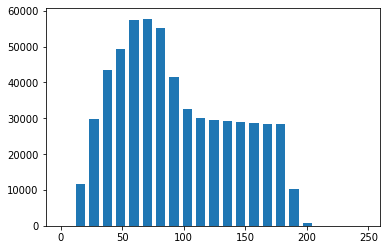

[0.03103154 0.01216496 0.00119879 0.00105415 0.         0.
 0.         0.         0.         0.00172763 0.         0.
 0.         0.         0.         0.         0.         0.        ]
18
[0.03103154 0.01216496 0.00119879 0.00105415 0.         0.
 0.         0.         0.         0.00172763 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
32


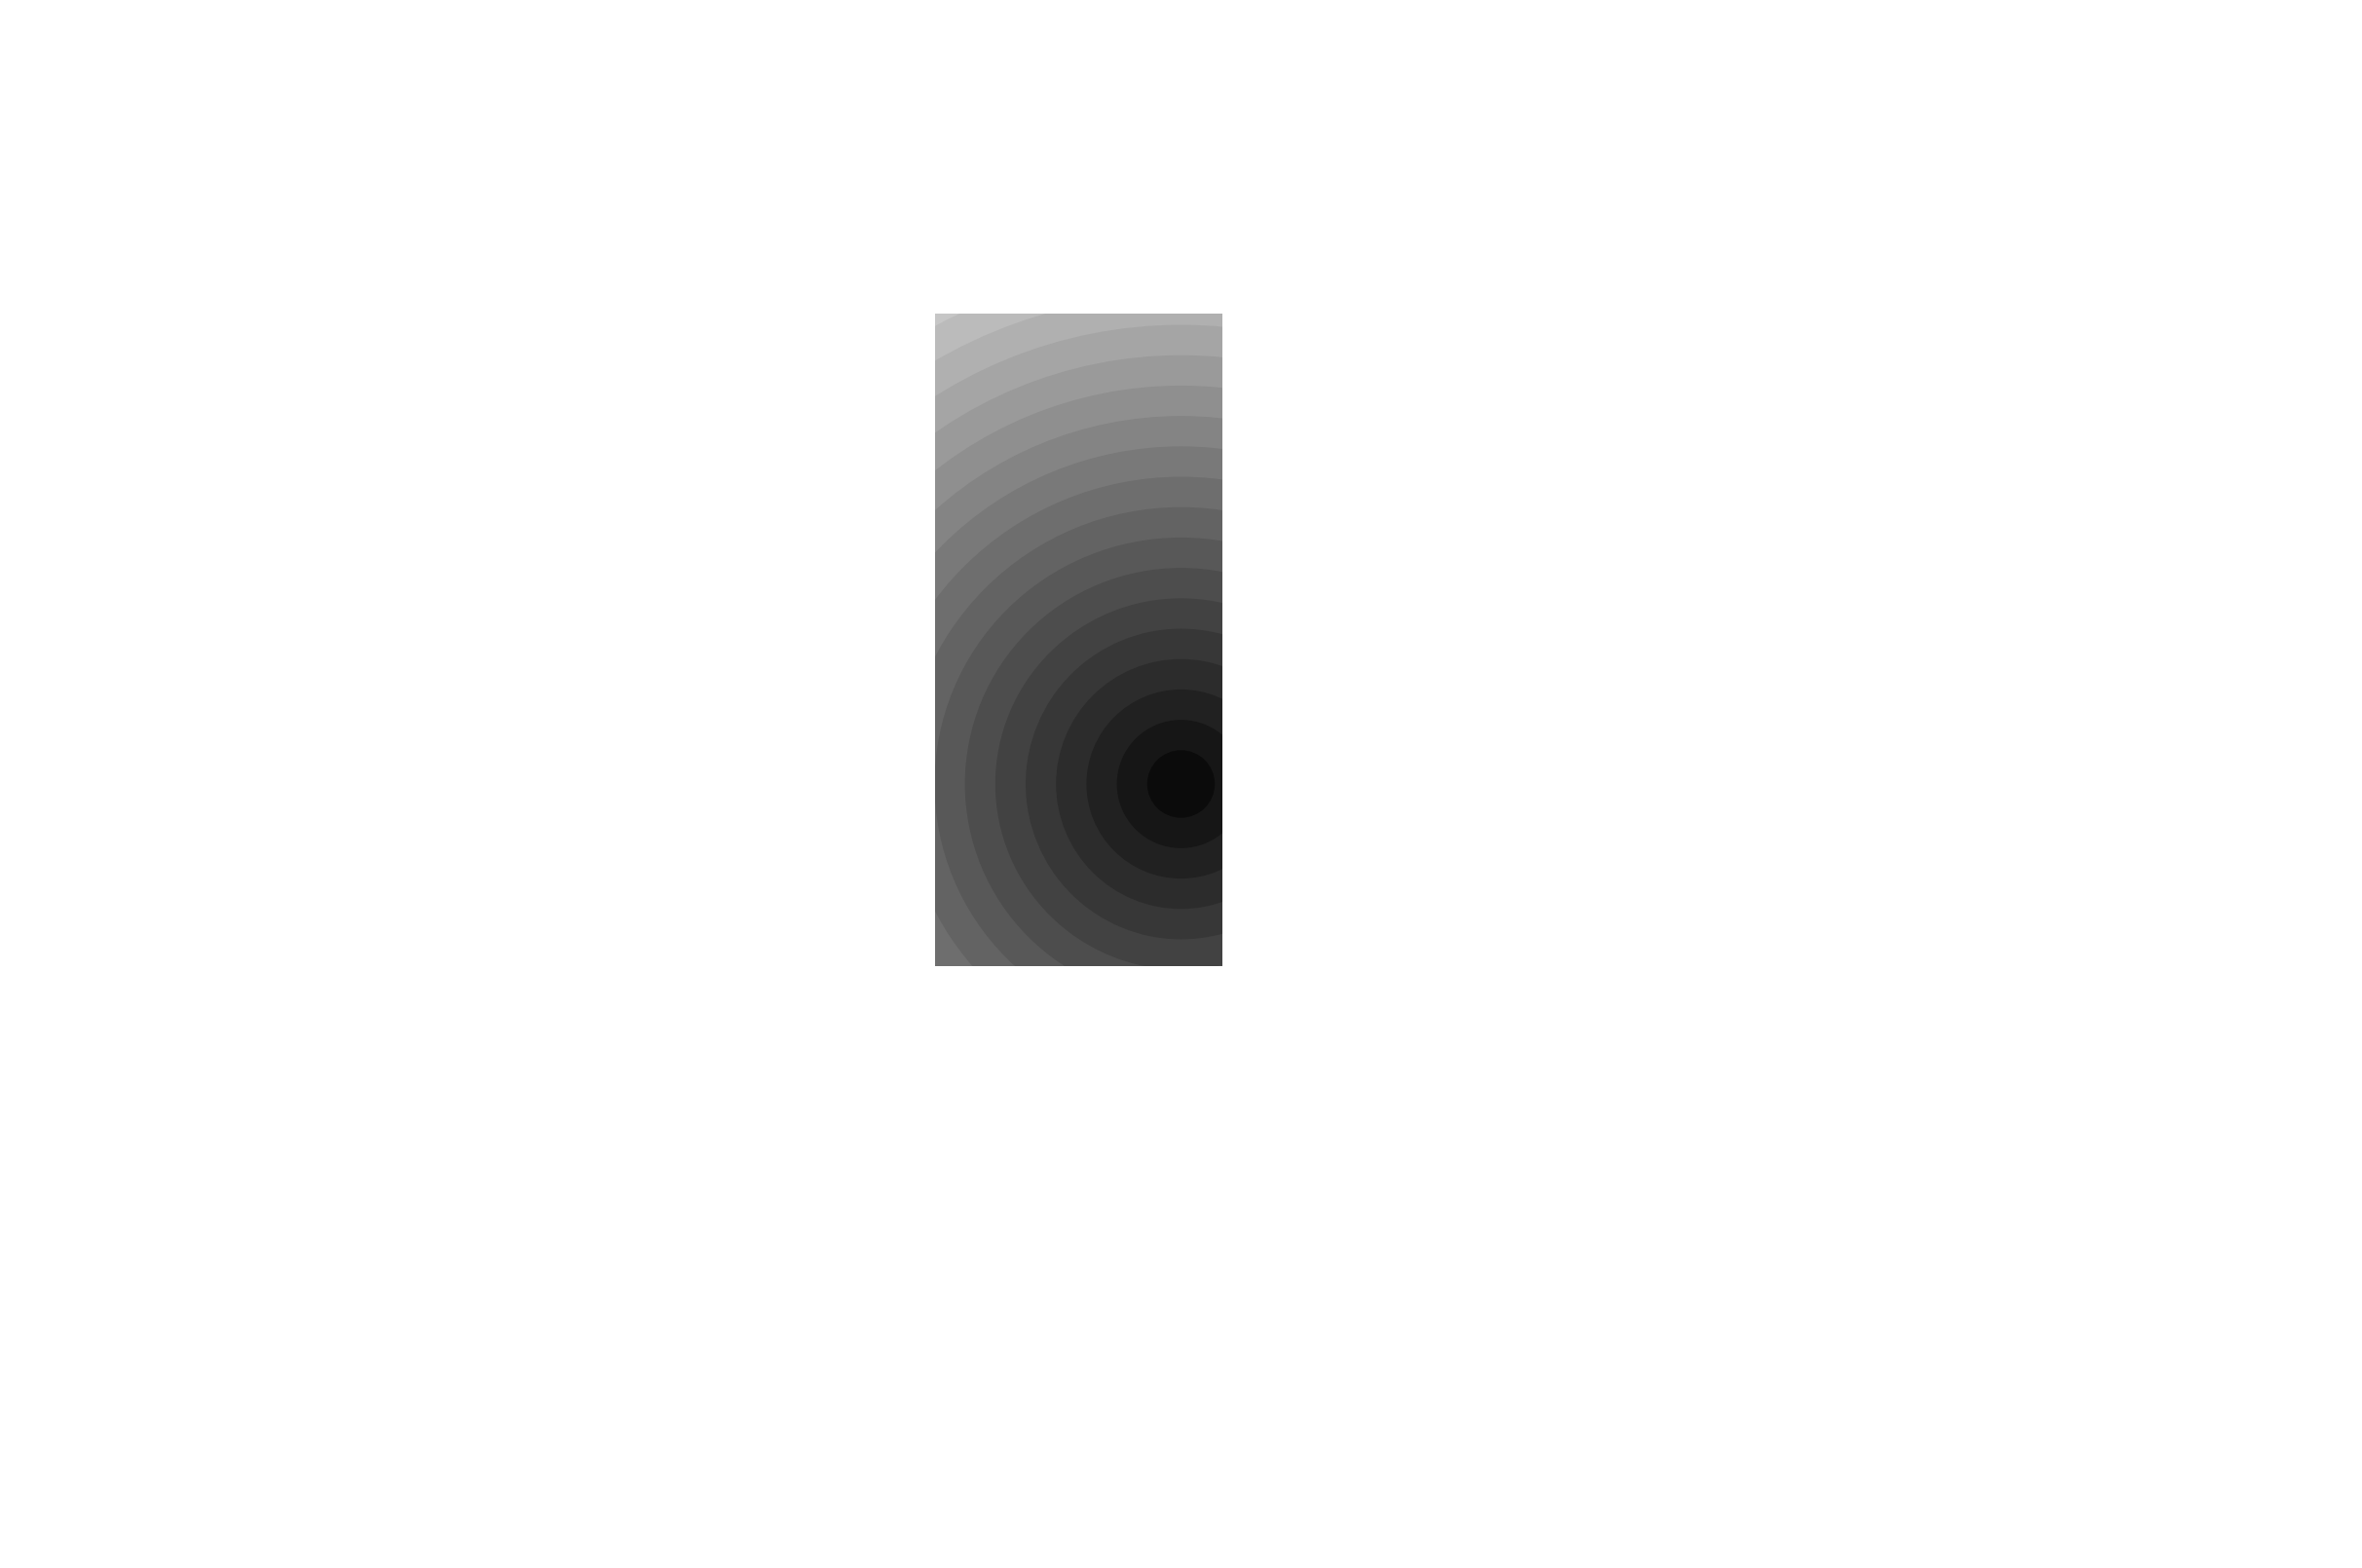

(0.2581234496881536, -0.3503242452914963)
Time                      1.6141e+09
RatX                        0.350761
RatY                       -0.446902
RatZ                        0.620983
BeaconX                     0.258123
BeaconY                    -0.350324
Visibility                         1
time_of_beacon_trigger    1.6141e+09
Beacon_group                       4
Beacon_subgroup                    1
trial_in_next                   True
13                              True
Name: 703, dtype: object
23
[    0 11730 24804 32535 41445 50163 59028 56445 59016 45975 34989 30789
 30096 29643 29316 29040 20736  6747   453     0     0     0     0]
[11730 24804 32535 41445 50163 59028 56445 59016 45975 34989 30789 30096
 29643 29316 29040 20736  6747   453]
[ 225.57692308  477.          625.67307692  797.01923077  964.67307692
 1135.15384615 1085.48076923 1134.92307692  884.13461538  672.86538462
  592.09615385  578.76923077  570.05769231  563.76923077  558.46153846
  398.76923077  129.7

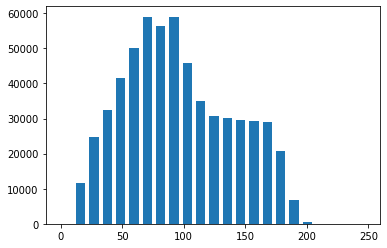

[0.03103154 0.00419287 0.00479484 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
18
[0.03103154 0.00419287 0.00479484 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
33


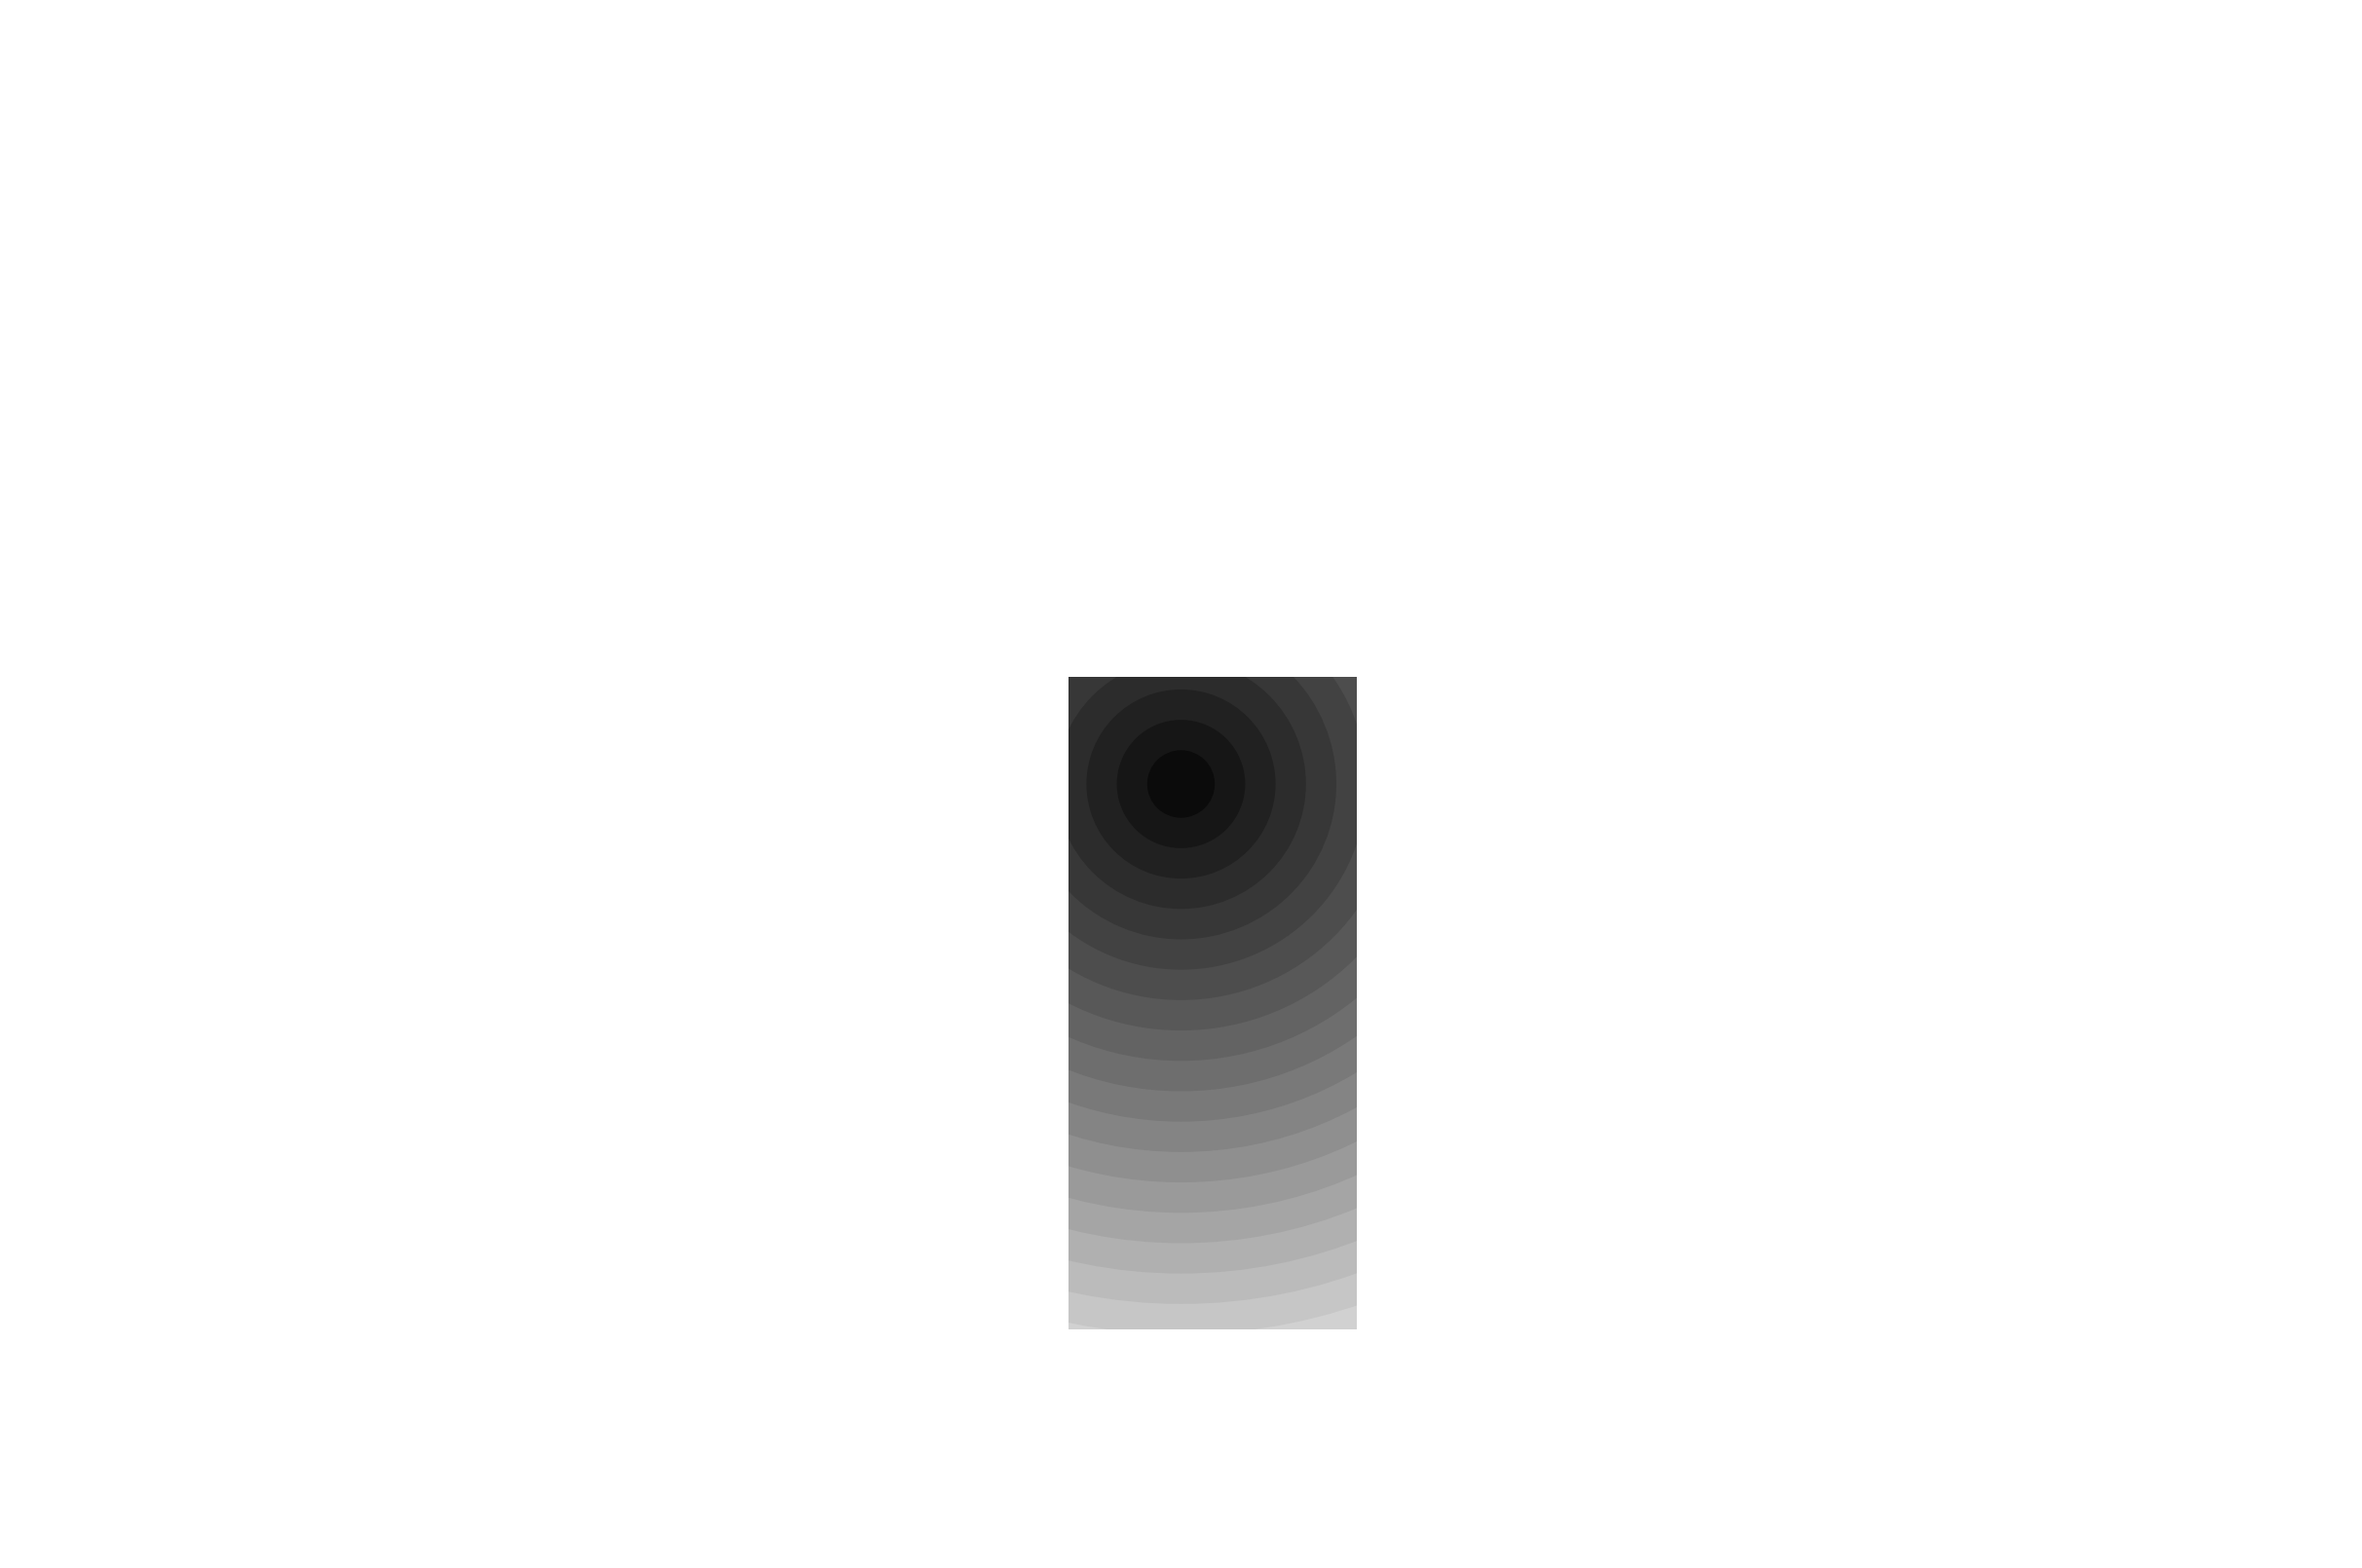

(-0.07312003797371794, 0.5453219243208415)
Time                      1.6141e+09
RatX                        0.180988
RatY                       -0.669787
RatZ                        0.620011
BeaconX                     -0.07312
BeaconY                     0.545322
Visibility                         1
time_of_beacon_trigger    1.6141e+09
Beacon_group                       5
Beacon_subgroup                    1
trial_in_next                   True
13                              True
Name: 721, dtype: object
23
[    0 11730 29922 48279 58368 48321 46128 33633 30480 29736 29232 28824
 28659 28515 28431 28299 28209 28080 26499  3615     0     0     0]
[11730 29922 48279 58368 48321 46128 33633 30480 29736 29232 28824 28659
 28515 28431 28299 28209 28080 26499  3615]
[ 225.57692308  575.42307692  928.44230769 1122.46153846  929.25
  887.07692308  646.78846154  586.15384615  571.84615385  562.15384615
  554.30769231  551.13461538  548.36538462  546.75        544.21153846
  542.48076923  540.

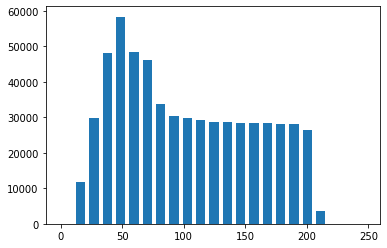

[0.02659847 0.00695141 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0018236  0.         0.         0.         0.00185185 0.
 0.        ]
19
[0.02659847 0.00695141 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0018236  0.         0.         0.         0.00185185 0.
 0.         0.         0.         0.         0.        ]
23
34


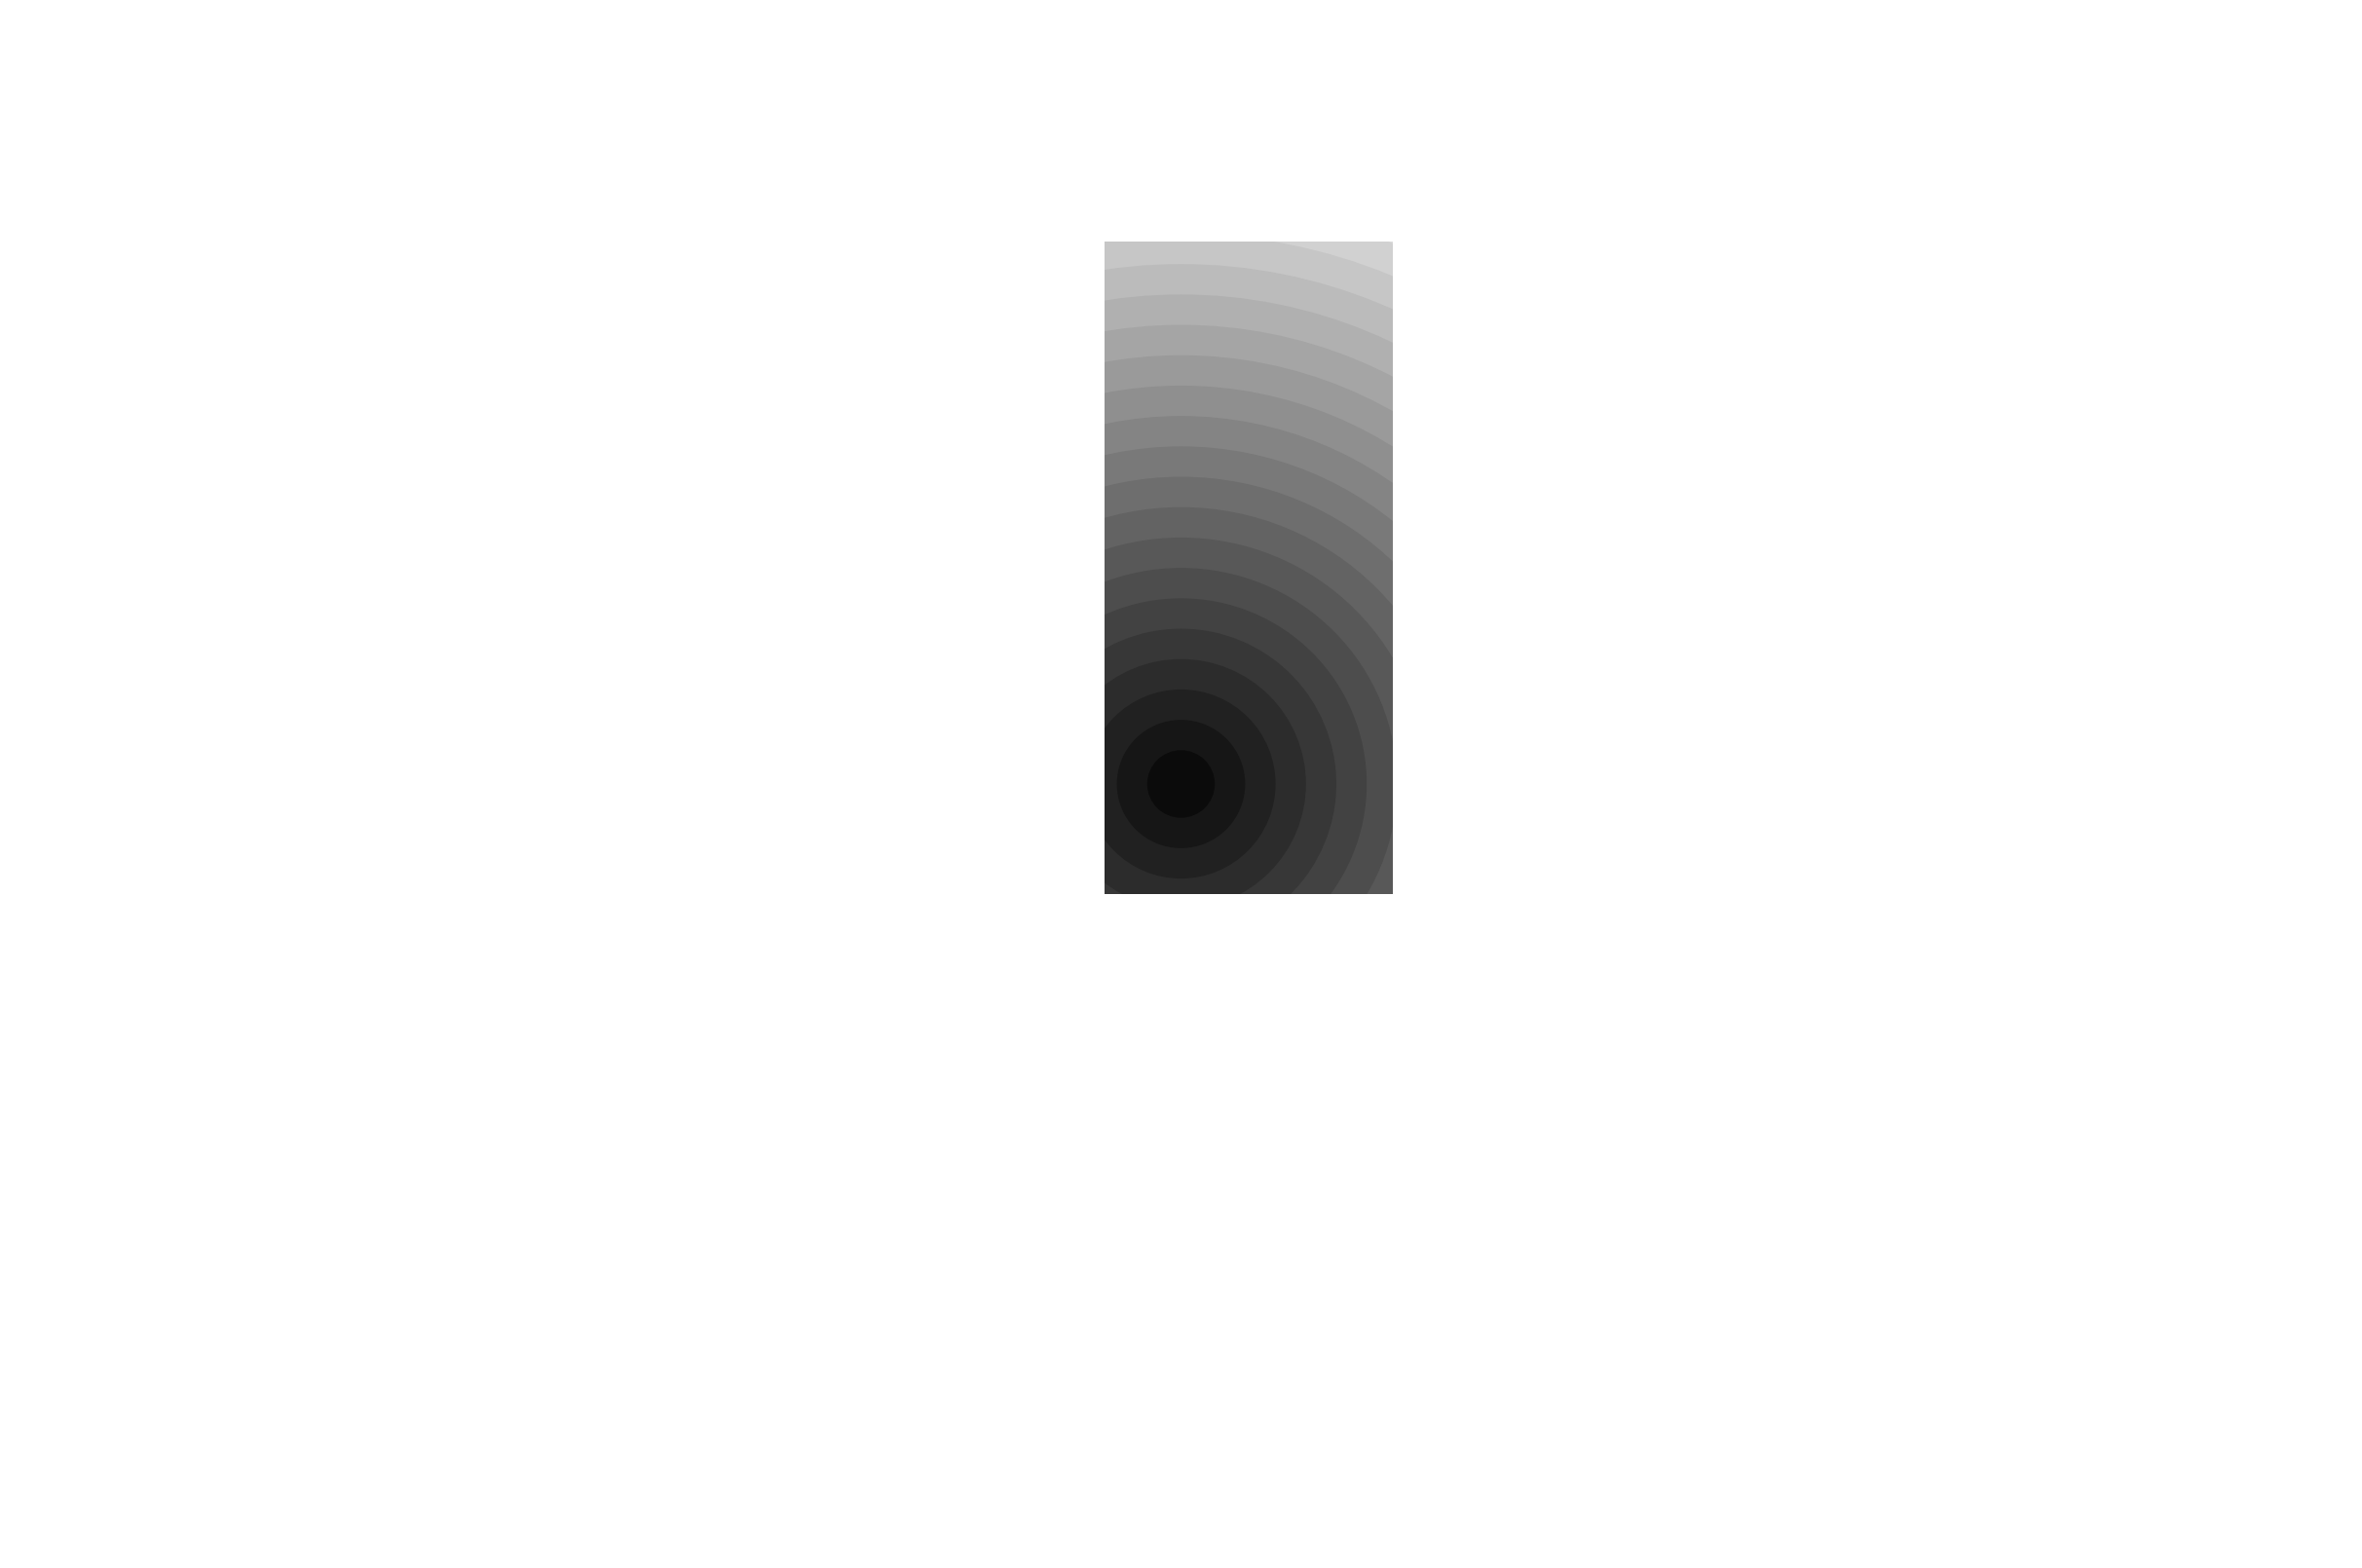

(-0.161819261454925, -0.5287954870929873)
Time                      1.61375e+09
RatX                        -0.235613
RatY                        -0.558357
RatZ                         0.623177
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.61375e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 741, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e

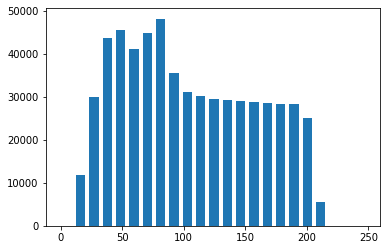

[0.02659847 0.00695141 0.00118909 0.         0.0012641  0.
 0.         0.         0.         0.0017218  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.02659847 0.00695141 0.00118909 0.         0.0012641  0.
 0.         0.         0.         0.0017218  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
35


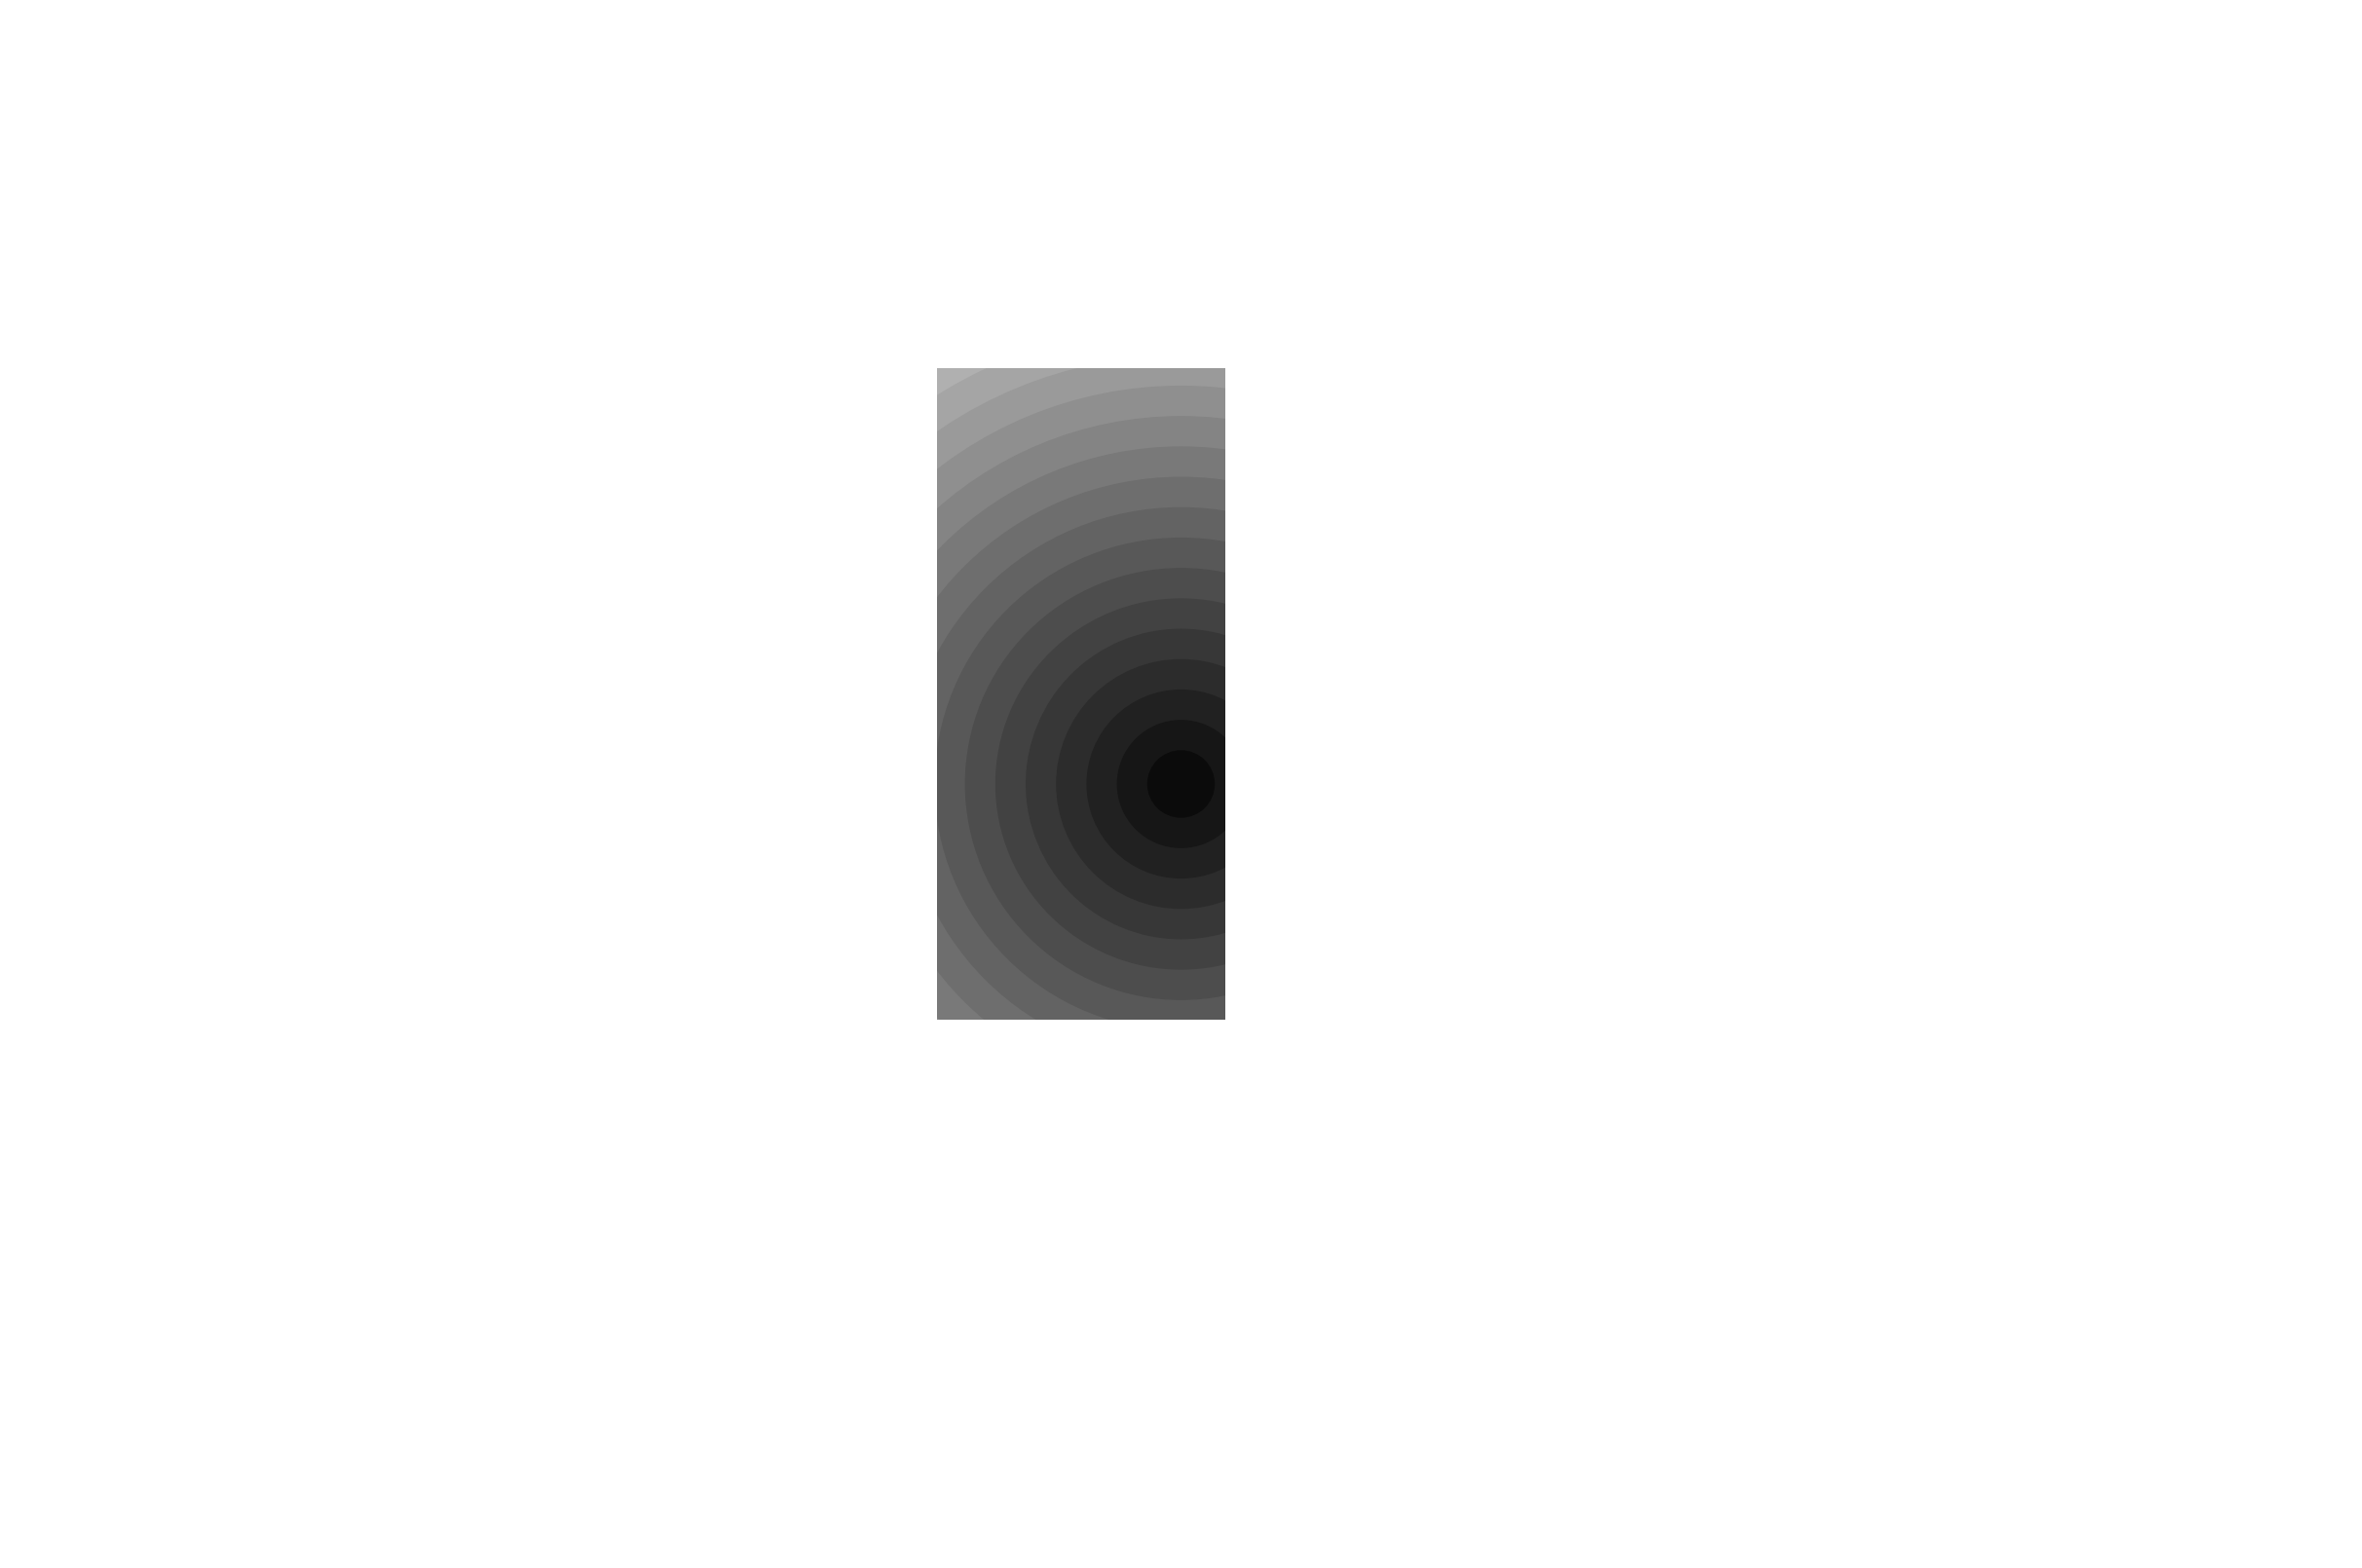

(0.2513964428902315, -0.217305810690347)
Time                      1.61375e+09
RatX                         0.280601
RatY                        -0.242175
RatZ                         0.623305
BeaconX                      0.251396
BeaconY                     -0.217306
Visibility                          1
time_of_beacon_trigger    1.61375e+09
Beacon_group                        2
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 781, dtype: object
23
[    0 11730 25704 33207 42057 50745 60252 69303 74916 53967 42048 34050
 30123 29682 24675  9654  1959     0     0     0     0     0     0]
[11730 25704 33207 42057 50745 60252 69303 74916 53967 42048 34050 30123
 29682 24675  9654  1959]
[ 225.57692308  494.30769231  638.59615385  808.78846154  975.86538462
 1158.69230769 1332.75       1440.69230769 1037.82692308  808.61538462
  654.80769231  579.28846154  570.80769231  474.51923077  185.65384615
   37.67307692]
16
23


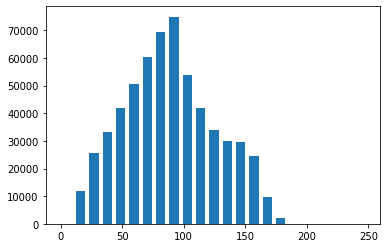

[0.07092924 0.01820728 0.0046978  0.         0.         0.
 0.00075033 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
16
[0.07092924 0.01820728 0.0046978  0.         0.         0.
 0.00075033 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
36


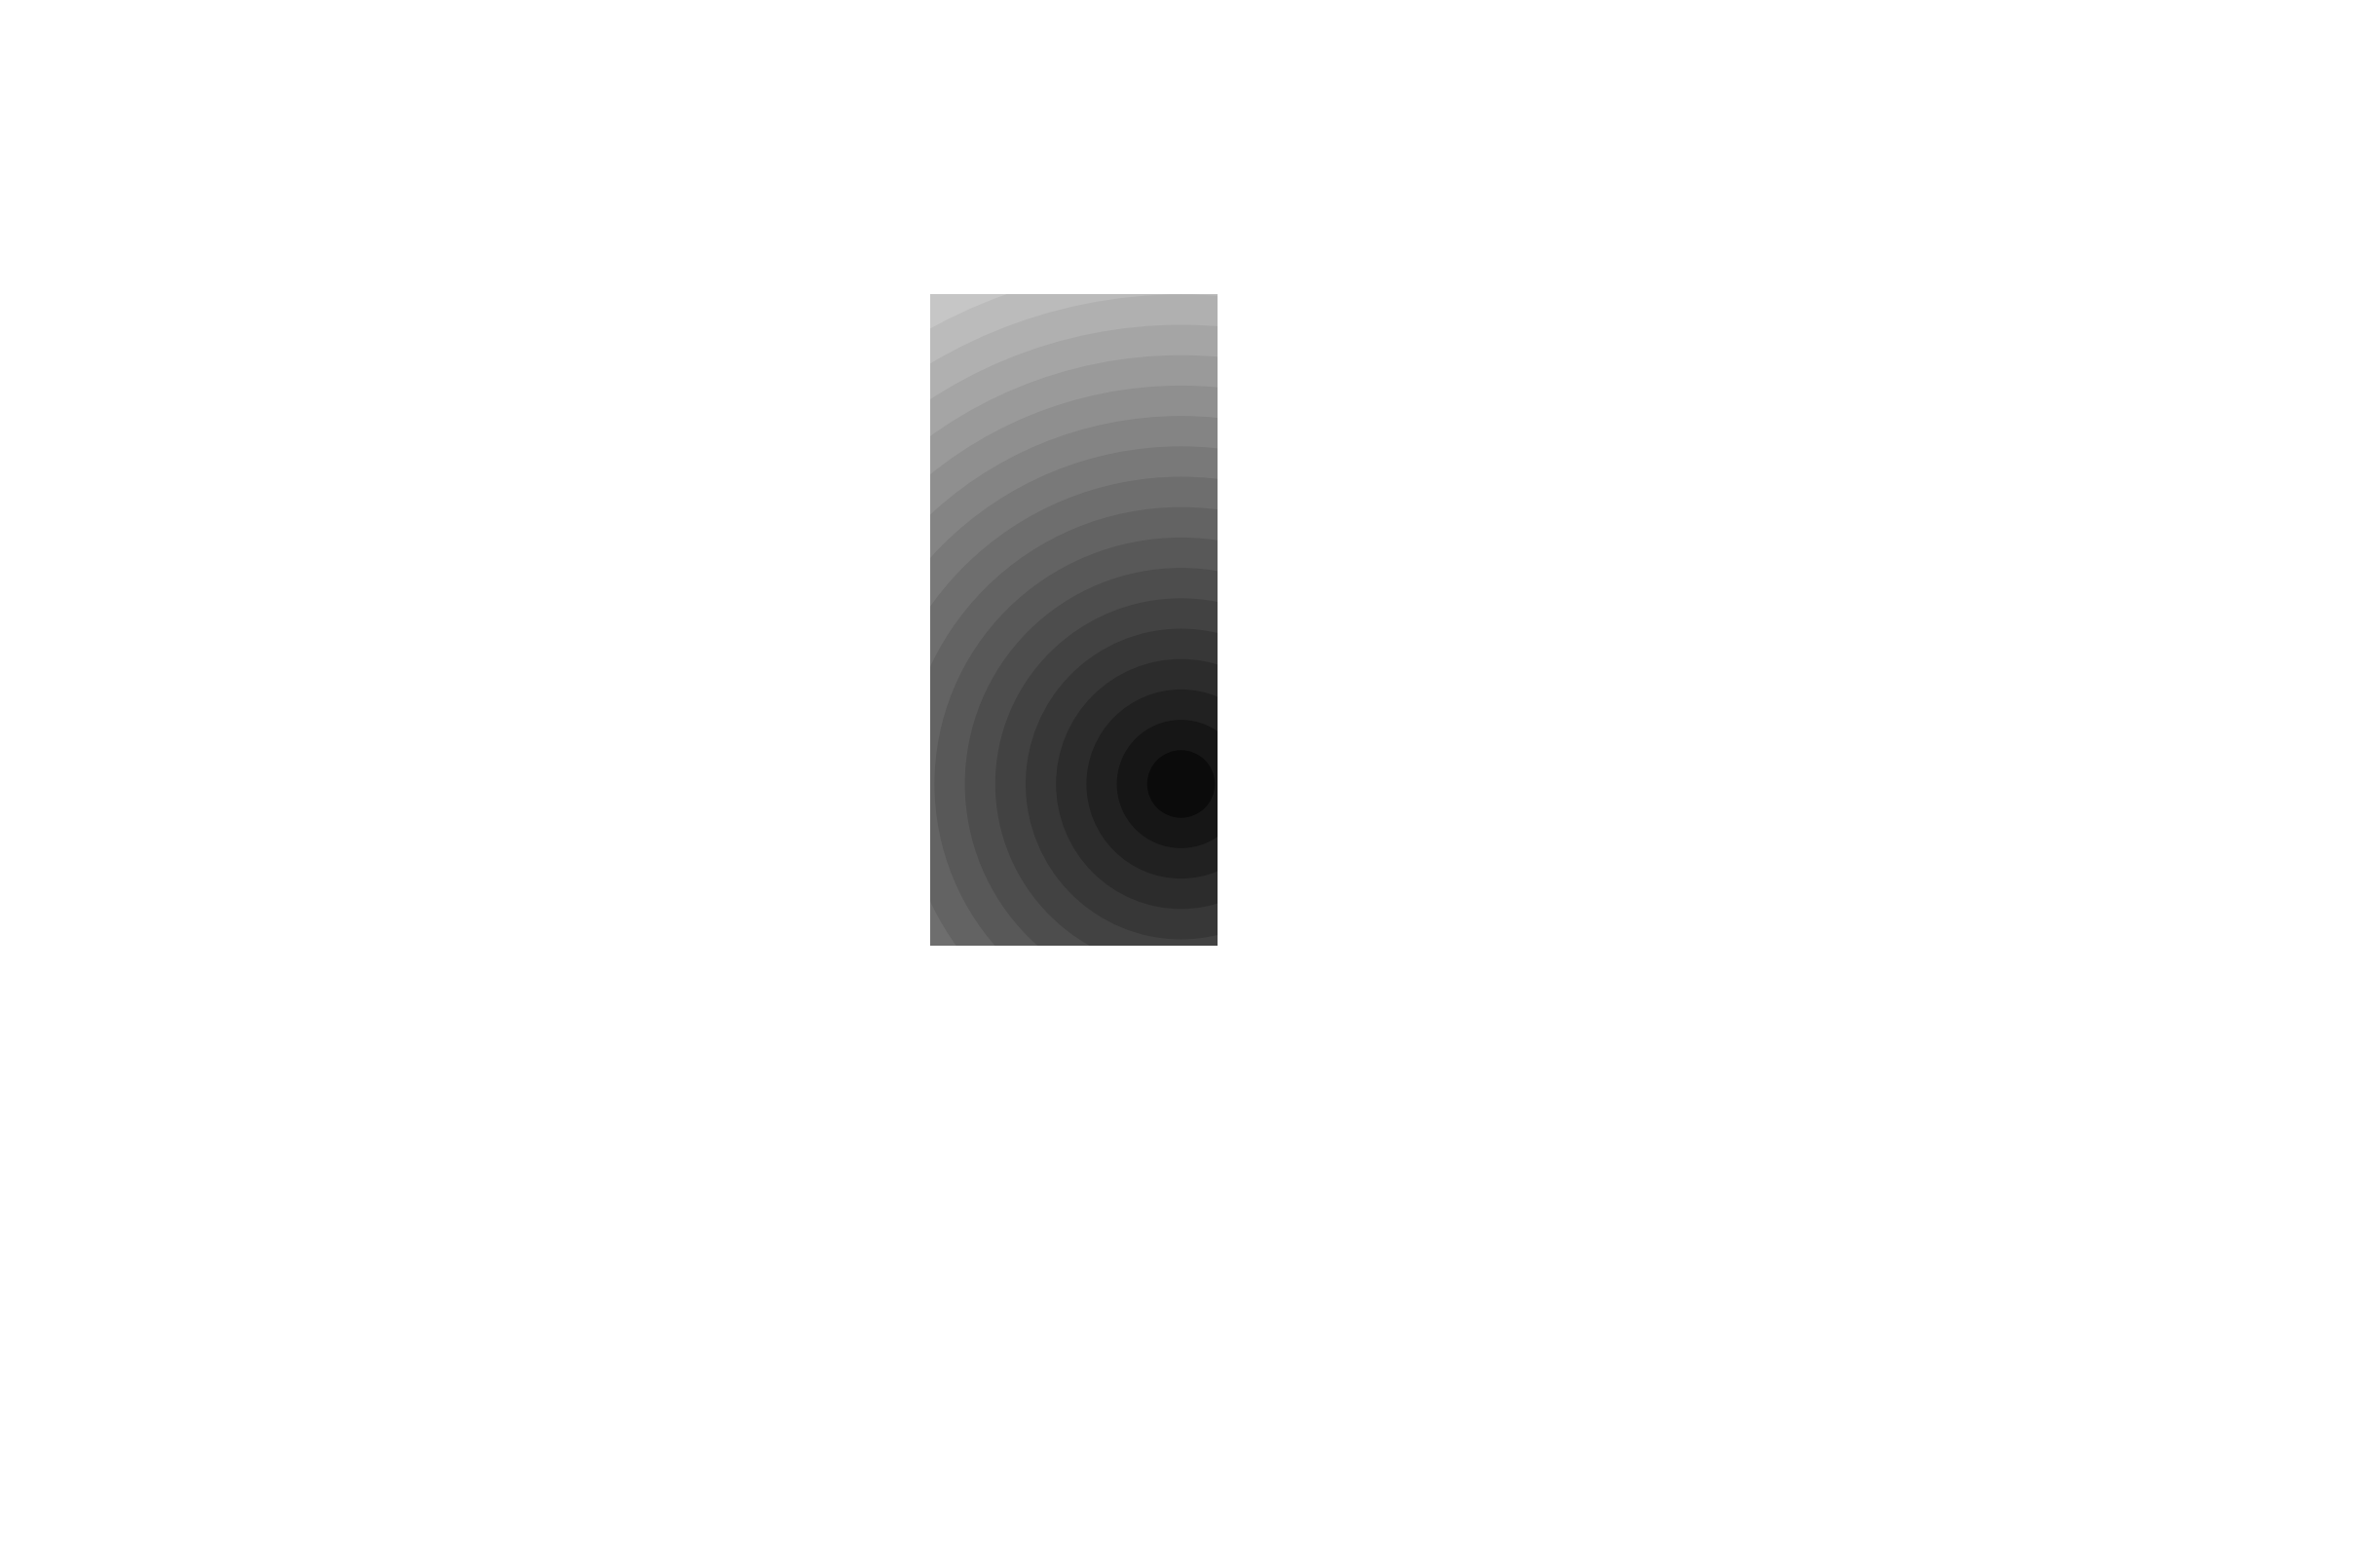

(0.2696570672779339, -0.399889720164309)
Time                      1.61375e+09
RatX                         0.325773
RatY                        -0.387453
RatZ                         0.621173
BeaconX                      0.269657
BeaconY                      -0.39989
Visibility                          1
time_of_beacon_trigger    1.61375e+09
Beacon_group                        3
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 802, dtype: object
23
[    0 11730 23208 31455 40449 49197 51213 51966 55683 46578 34164 31044
 30288 29793 29427 29139 28893 14010  3828     0     0     0     0]
[11730 23208 31455 40449 49197 51213 51966 55683 46578 34164 31044 30288
 29793 29427 29139 28893 14010  3828]
[ 225.57692308  446.30769231  604.90384615  777.86538462  946.09615385
  984.86538462  999.34615385 1070.82692308  895.73076923  657.
  597.          582.46153846  572.94230769  565.90384615  560.36538462
  555.63461538  26

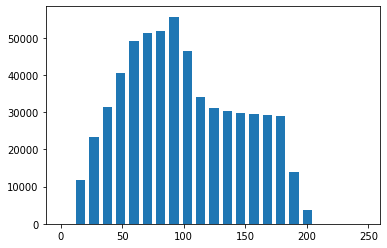

[0.04433078 0.01120303 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
18
[0.04433078 0.01120303 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
37


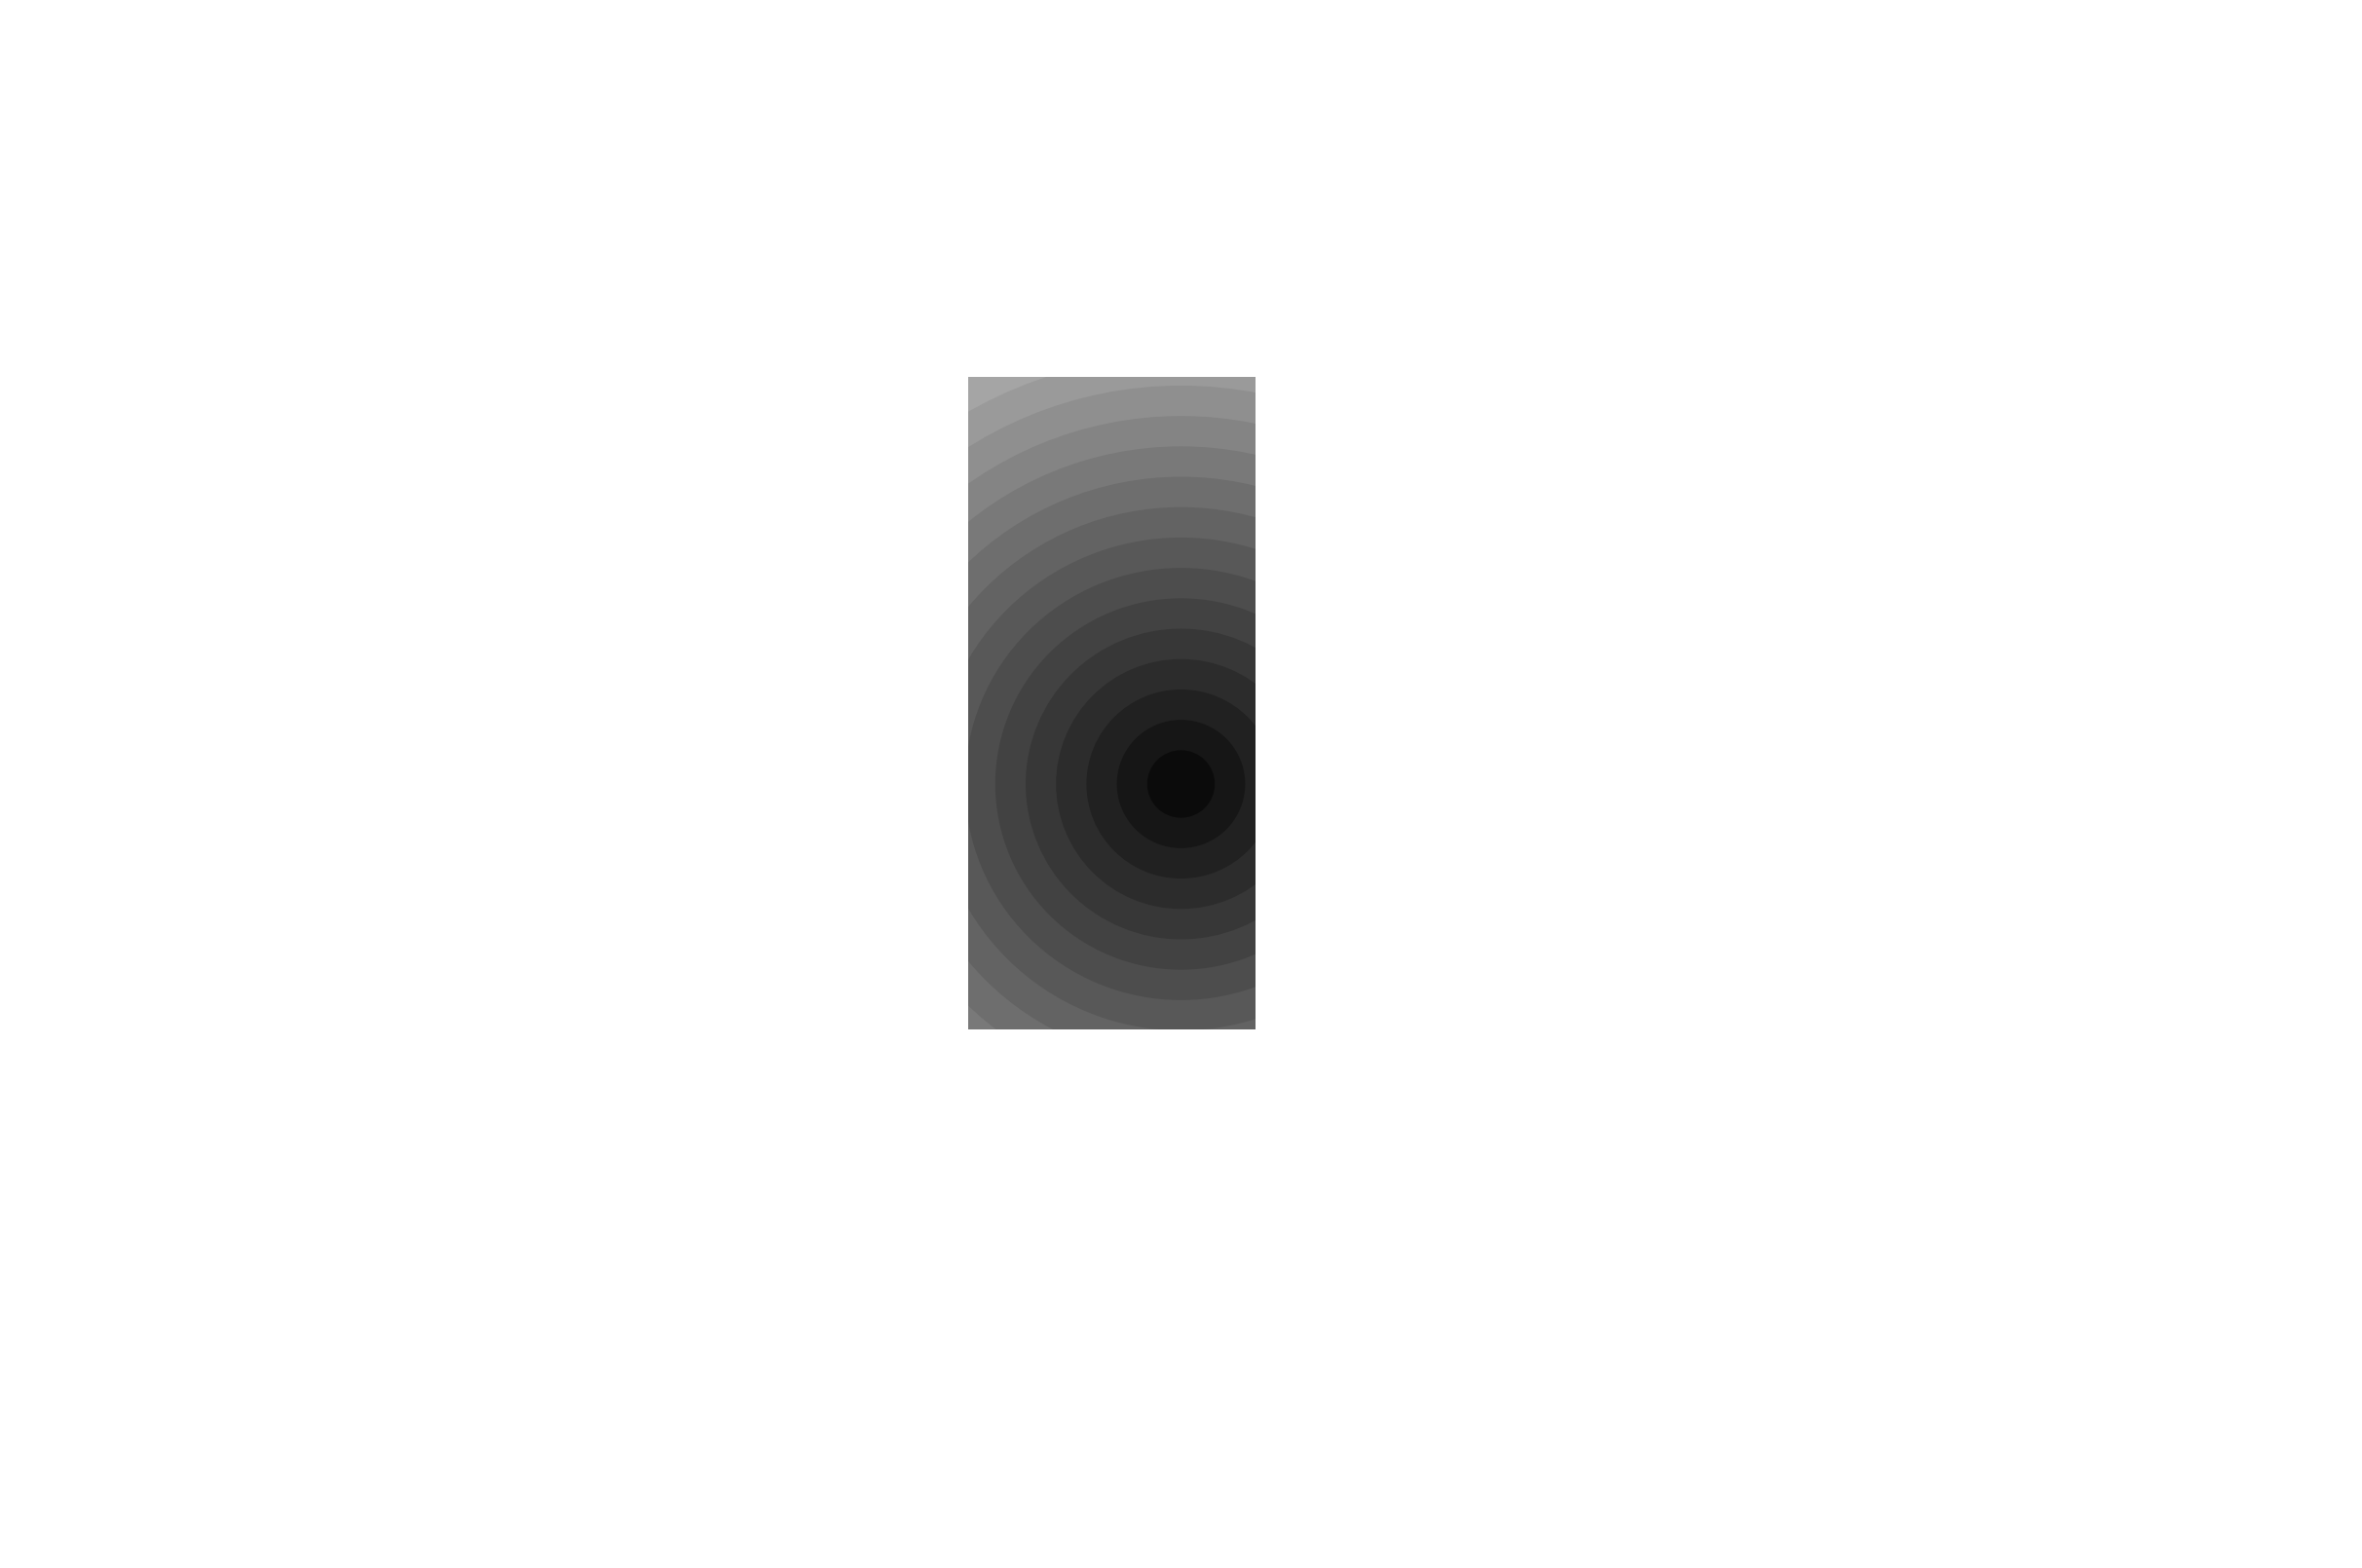

(0.1754231724304384, -0.1951764890039851)
Time                      1.61375e+09
RatX                         0.262292
RatY                        -0.238155
RatZ                         0.623901
BeaconX                      0.175423
BeaconY                     -0.195176
Visibility                          1
time_of_beacon_trigger    1.61375e+09
Beacon_group                        4
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 826, dtype: object
23
[    0 11730 29922 43017 49065 57129 66462 74775 66717 47121 36948 30450
 29133 28881 17742  3858     0     0     0     0     0     0     0]
[11730 29922 43017 49065 57129 66462 74775 66717 47121 36948 30450 29133
 28881 17742  3858]
[ 225.57692308  575.42307692  827.25        943.55769231 1098.63461538
 1278.11538462 1437.98076923 1283.01923077  906.17307692  710.53846154
  585.57692308  560.25        555.40384615  341.19230769   74.19230769]
15
23
[12  4  1  1  0  1  

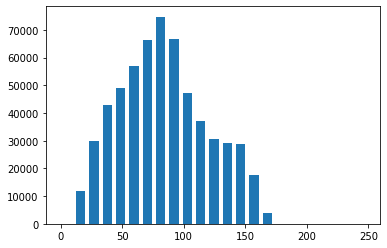

[0.05319693 0.00695141 0.00120882 0.00105982 0.         0.0007824
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
15
[0.05319693 0.00695141 0.00120882 0.00105982 0.         0.0007824
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
38


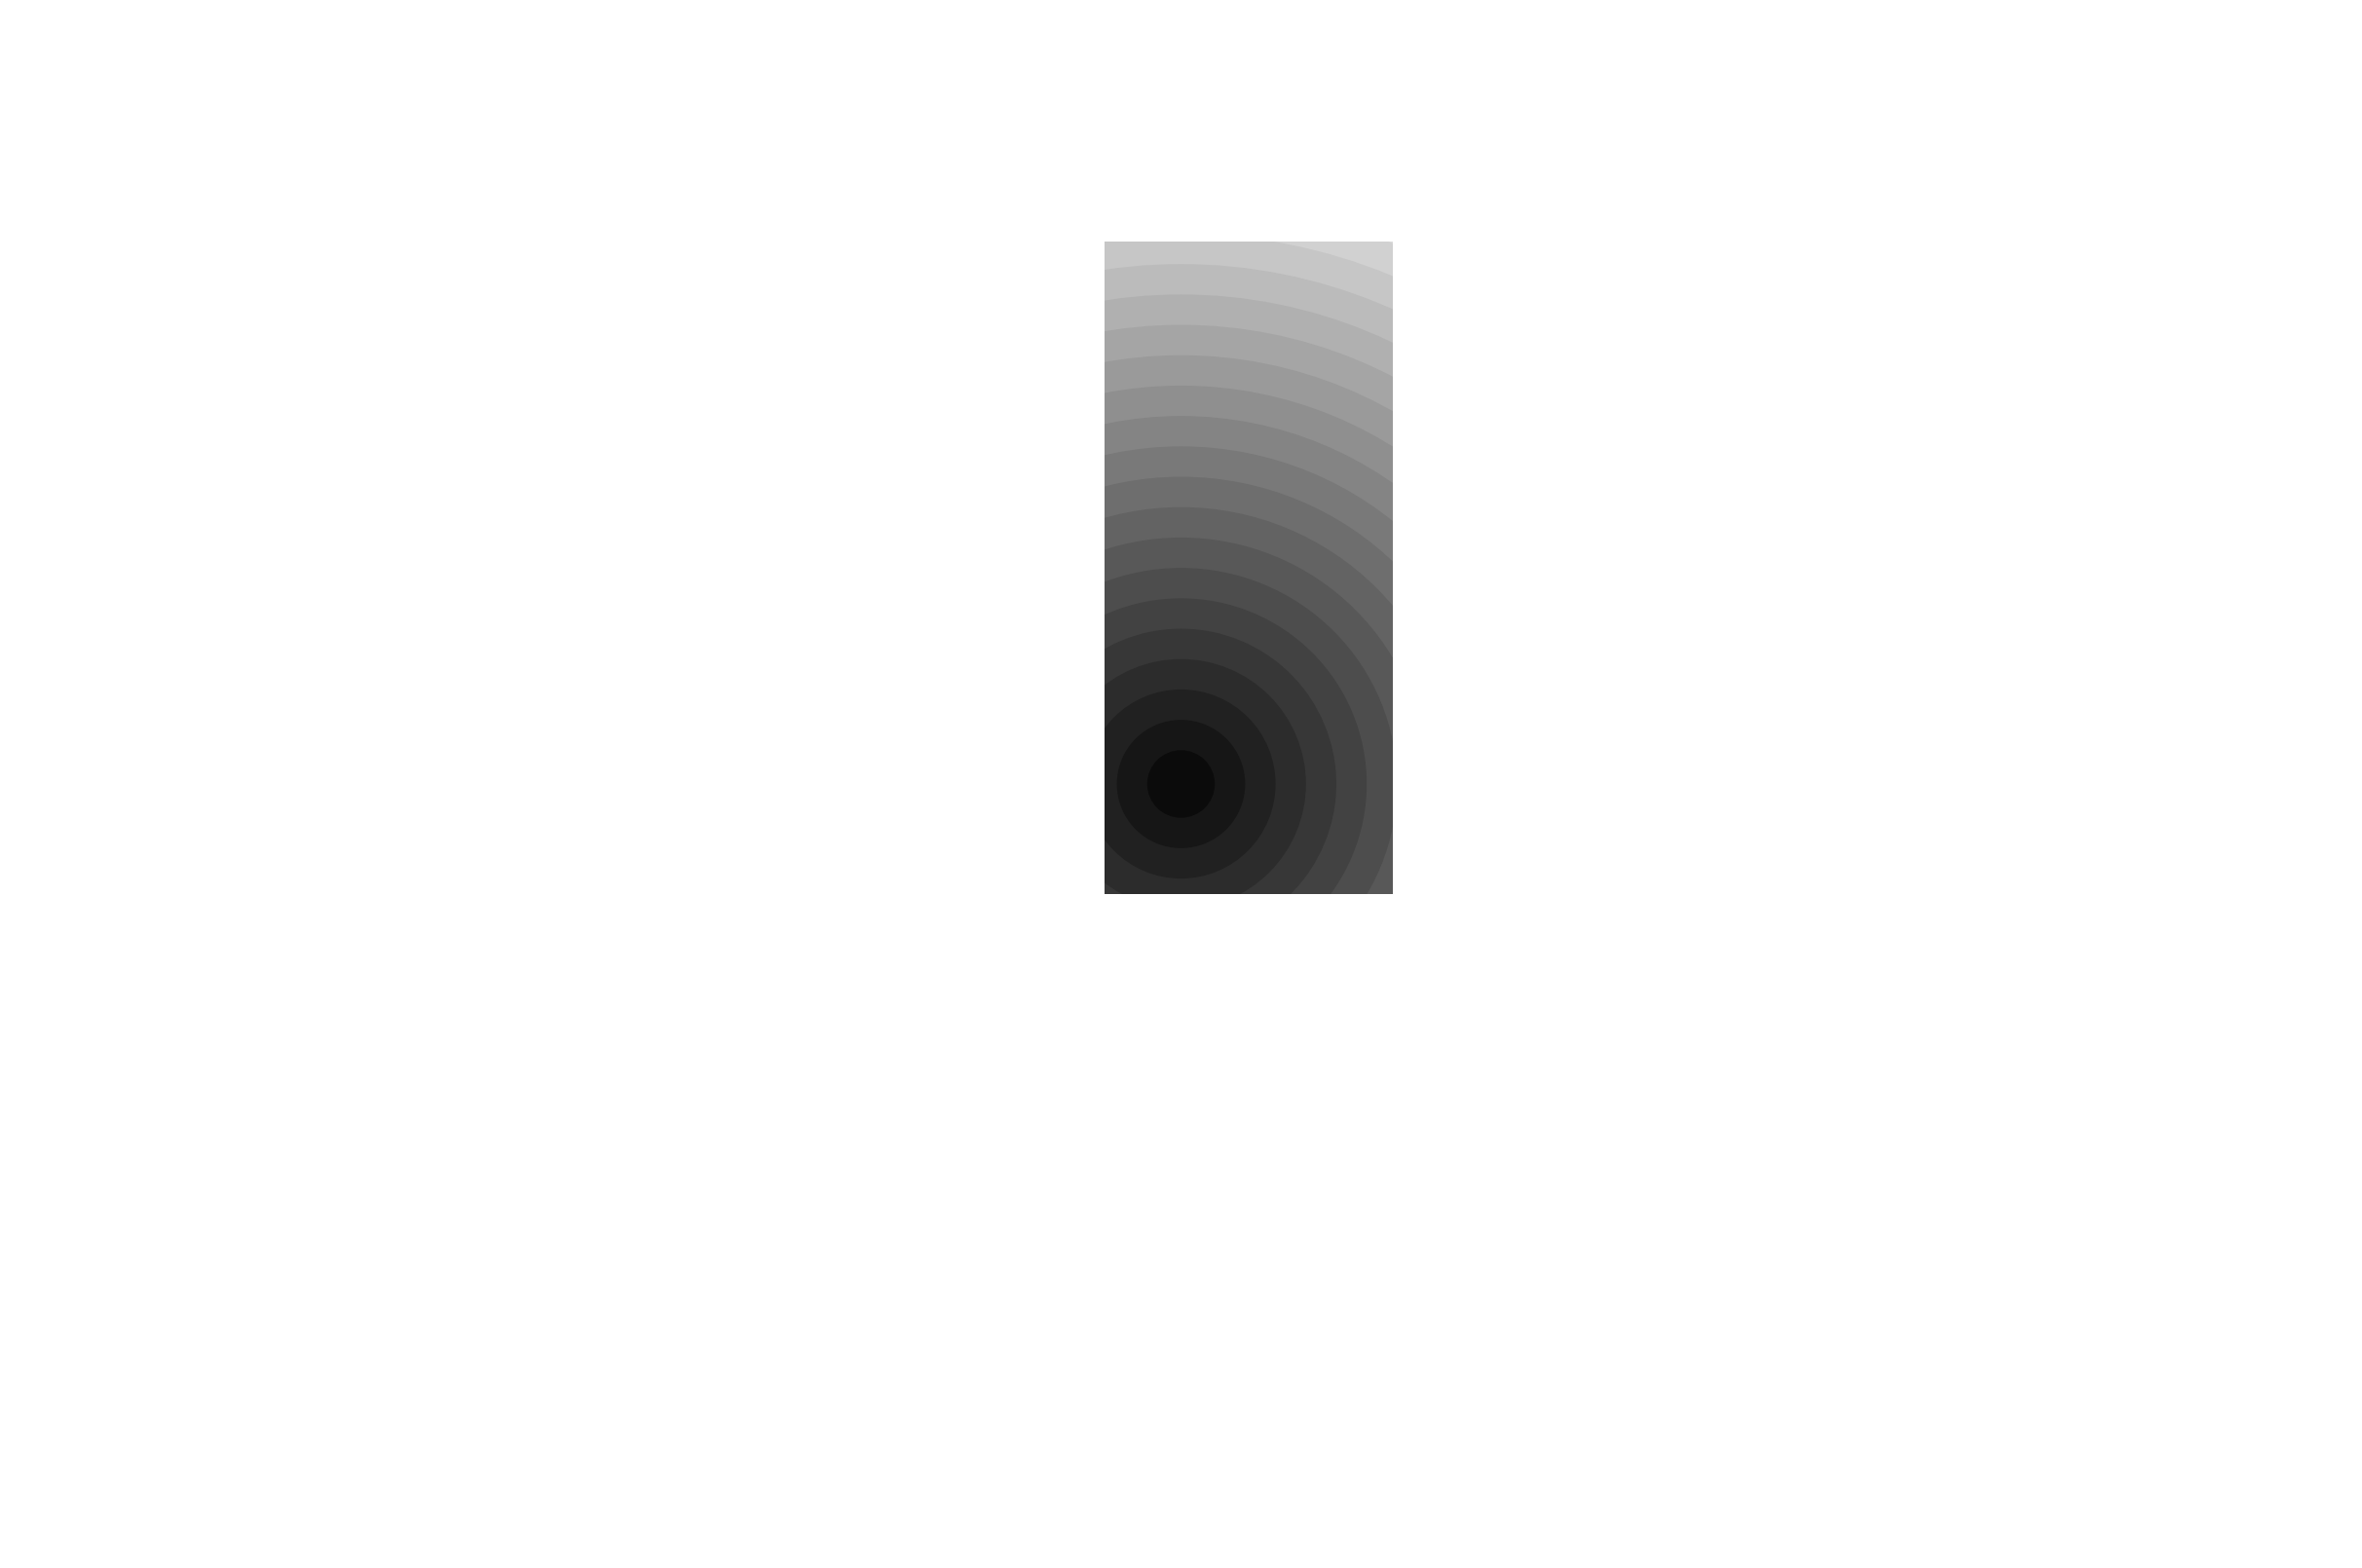

(-0.161819261454925, -0.5287954870929873)
Time                      1.61364e+09
RatX                        -0.210113
RatY                        -0.500039
RatZ                         0.622814
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.61364e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 858, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e

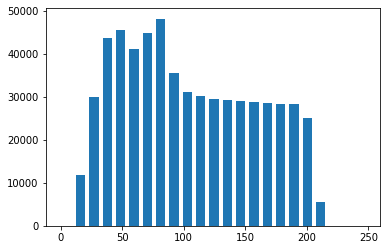

[0.03546462 0.01216496 0.00237818 0.         0.         0.00115671
 0.         0.         0.         0.         0.00175973 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.03546462 0.01216496 0.00237818 0.         0.         0.00115671
 0.         0.         0.         0.         0.00175973 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
39


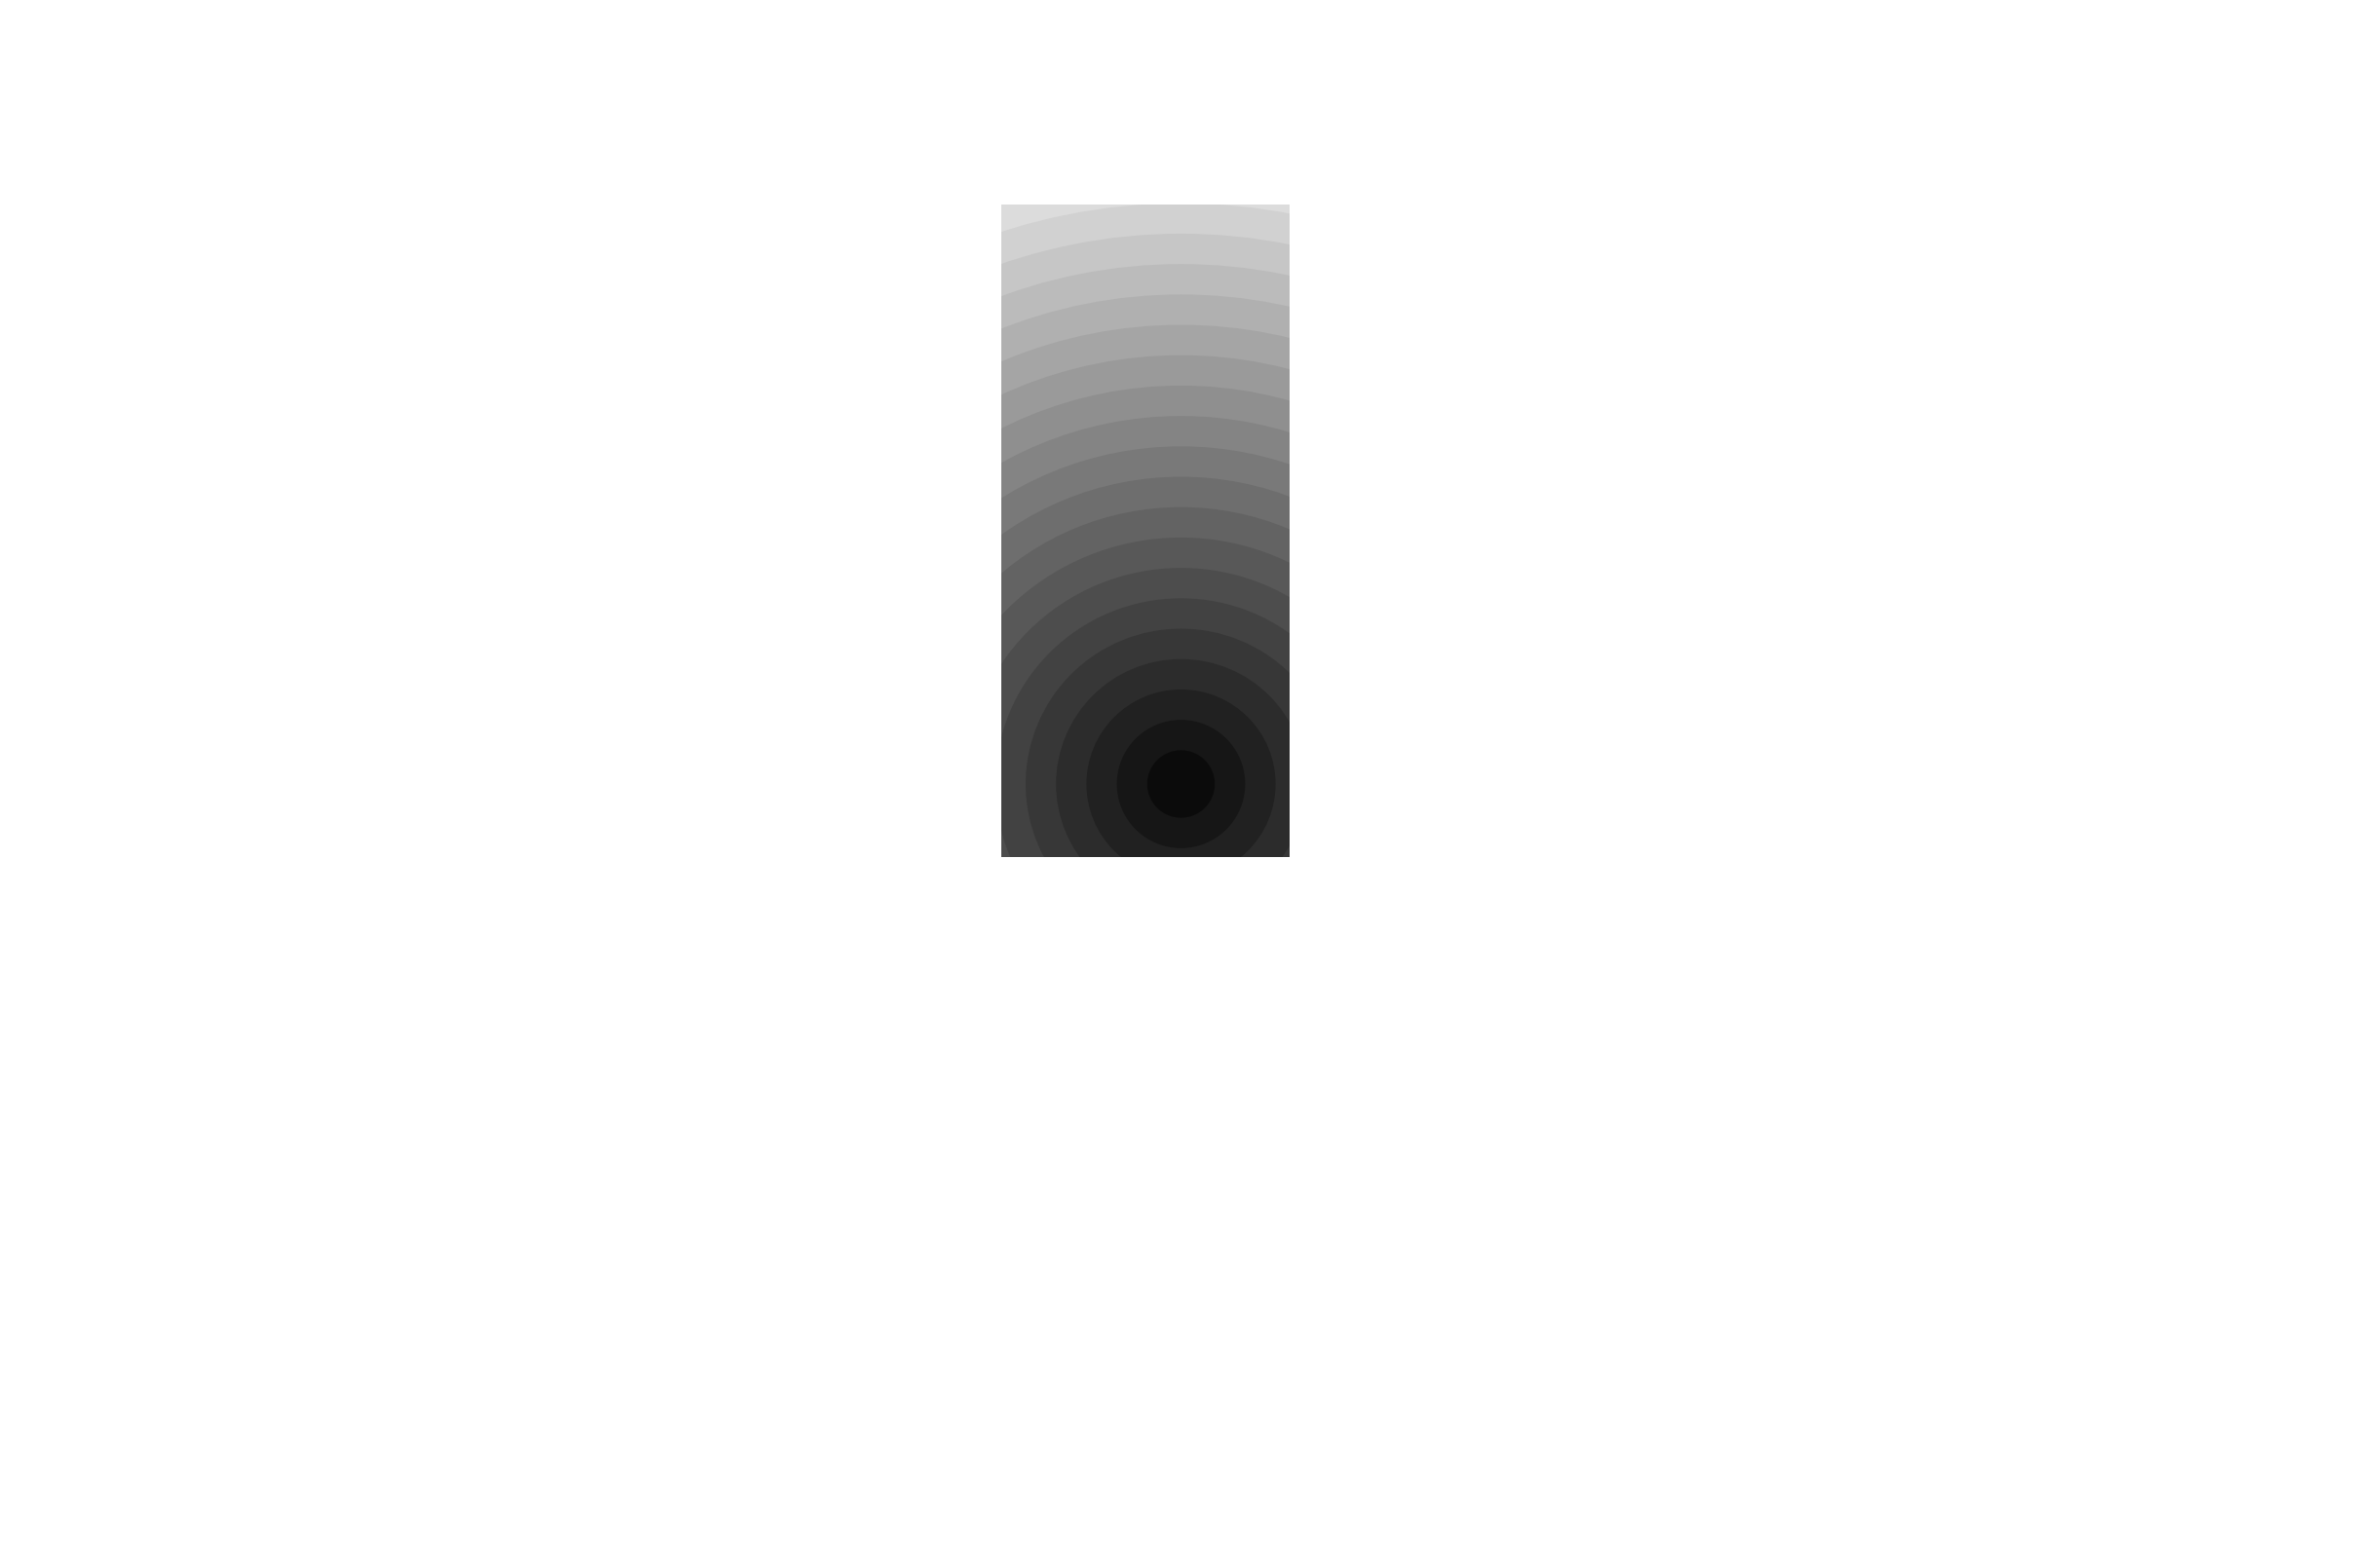

(0.09295046569360456, -0.6206400758464755)
Time                      1.61364e+09
RatX                        0.0656295
RatY                        -0.535225
RatZ                         0.621653
BeaconX                     0.0929505
BeaconY                      -0.62064
Visibility                          1
time_of_beacon_trigger    1.61364e+09
Beacon_group                        2
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 877, dtype: object
23
[    0 11730 29922 42450 44136 40377 43110 32808 30636 29841 29295 28875
 28695 28557 28449 28326 28221 28095 28101 27849  5487     0     0]
[11730 29922 42450 44136 40377 43110 32808 30636 29841 29295 28875 28695
 28557 28449 28326 28221 28095 28101 27849  5487]
[225.57692308 575.42307692 816.34615385 848.76923077 776.48076923
 829.03846154 630.92307692 589.15384615 573.86538462 563.36538462
 555.28846154 551.82692308 549.17307692 547.09615385 544.73076923
 542.711538

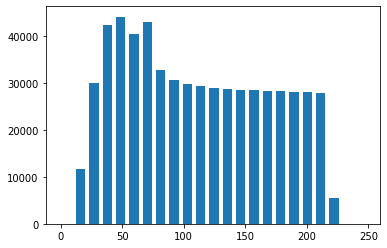

[0.02216539 0.00695141 0.00122497 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
20
[0.02216539 0.00695141 0.00122497 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
40


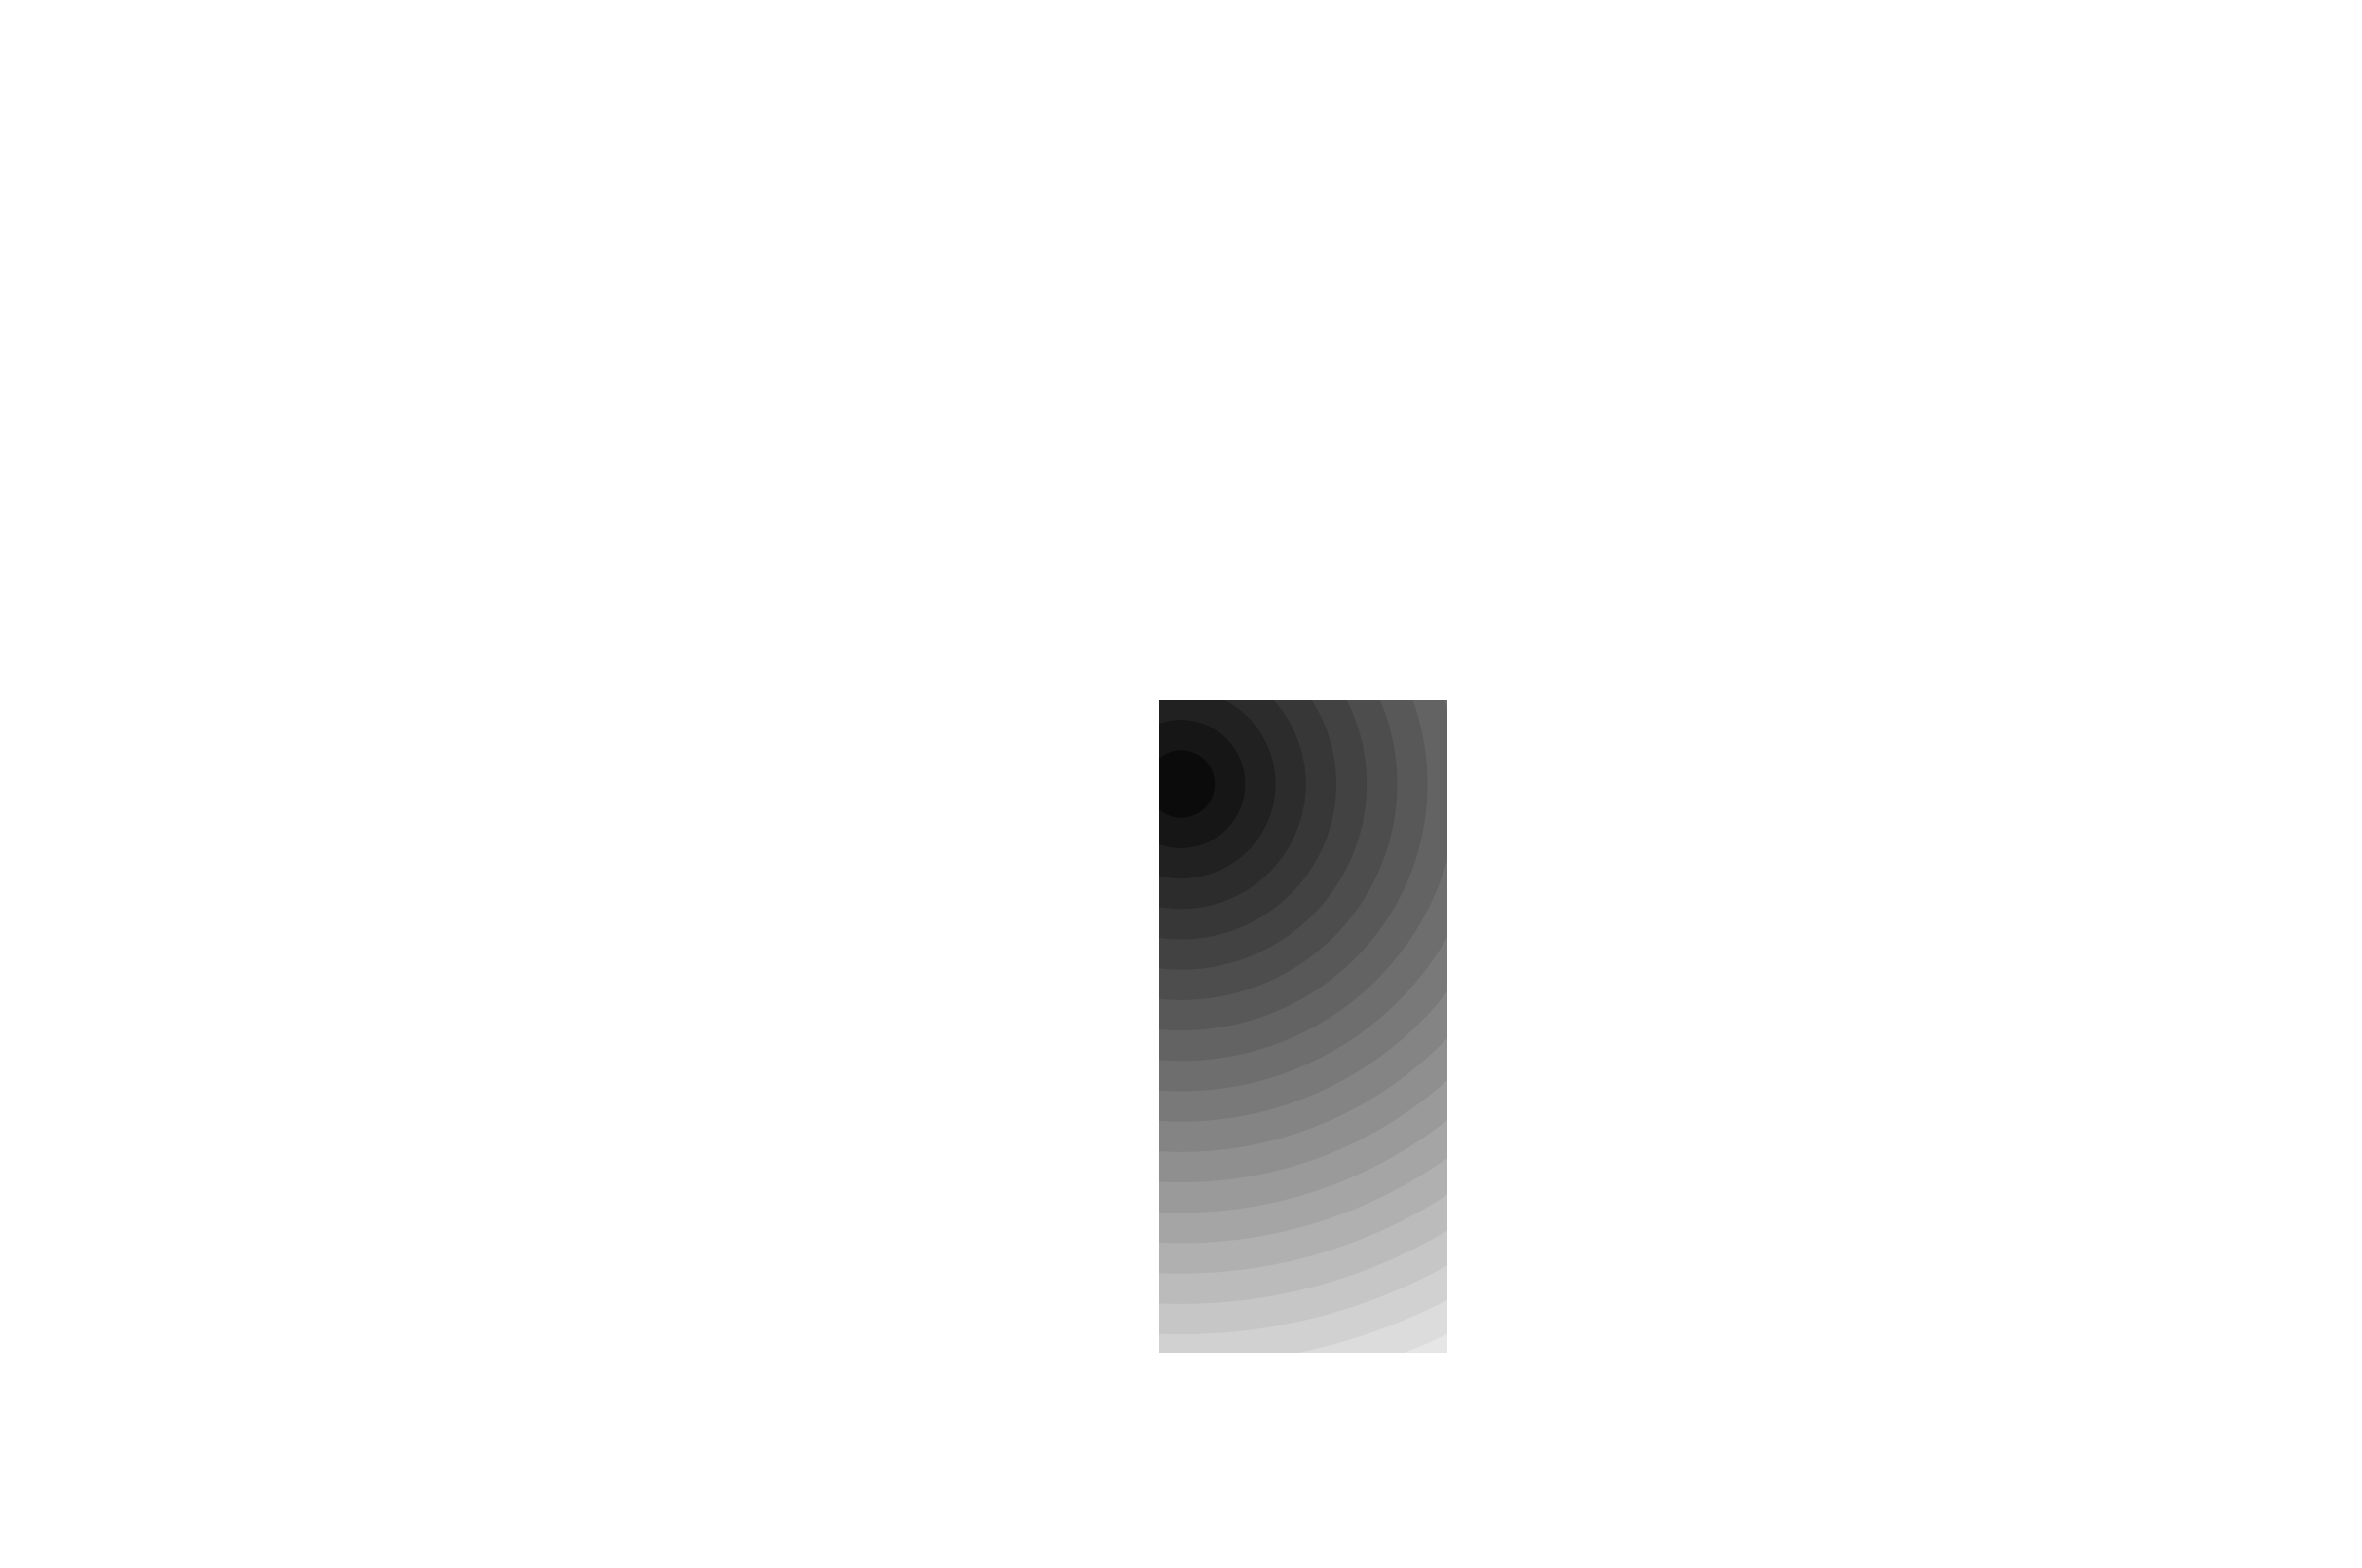

(-0.2963966574916079, 0.6040748180763695)
Time                      1.61365e+09
RatX                        -0.305637
RatY                         0.650557
RatZ                         0.624798
BeaconX                     -0.296397
BeaconY                      0.604075
Visibility                          1
time_of_beacon_trigger    1.61365e+09
Beacon_group                        3
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 902, dtype: object
23
[    0 10272 19344 26589 27954 31737 36357 40770 45297 46365 34464 32157
 31101 30396 29943 29571 29271 28998 28875 24921  9375  1203     0]
[10272 19344 26589 27954 31737 36357 40770 45297 46365 34464 32157 31101
 30396 29943 29571 29271 28998 28875 24921  9375  1203]
[197.53846154 372.         511.32692308 537.57692308 610.32692308
 699.17307692 784.03846154 871.09615385 891.63461538 662.76923077
 618.40384615 598.09615385 584.53846154 575.82692308 568.67307692
 562.9

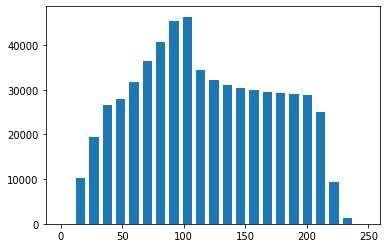

[0.04556075 0.00268817 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
21
[0.04556075 0.00268817 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
41


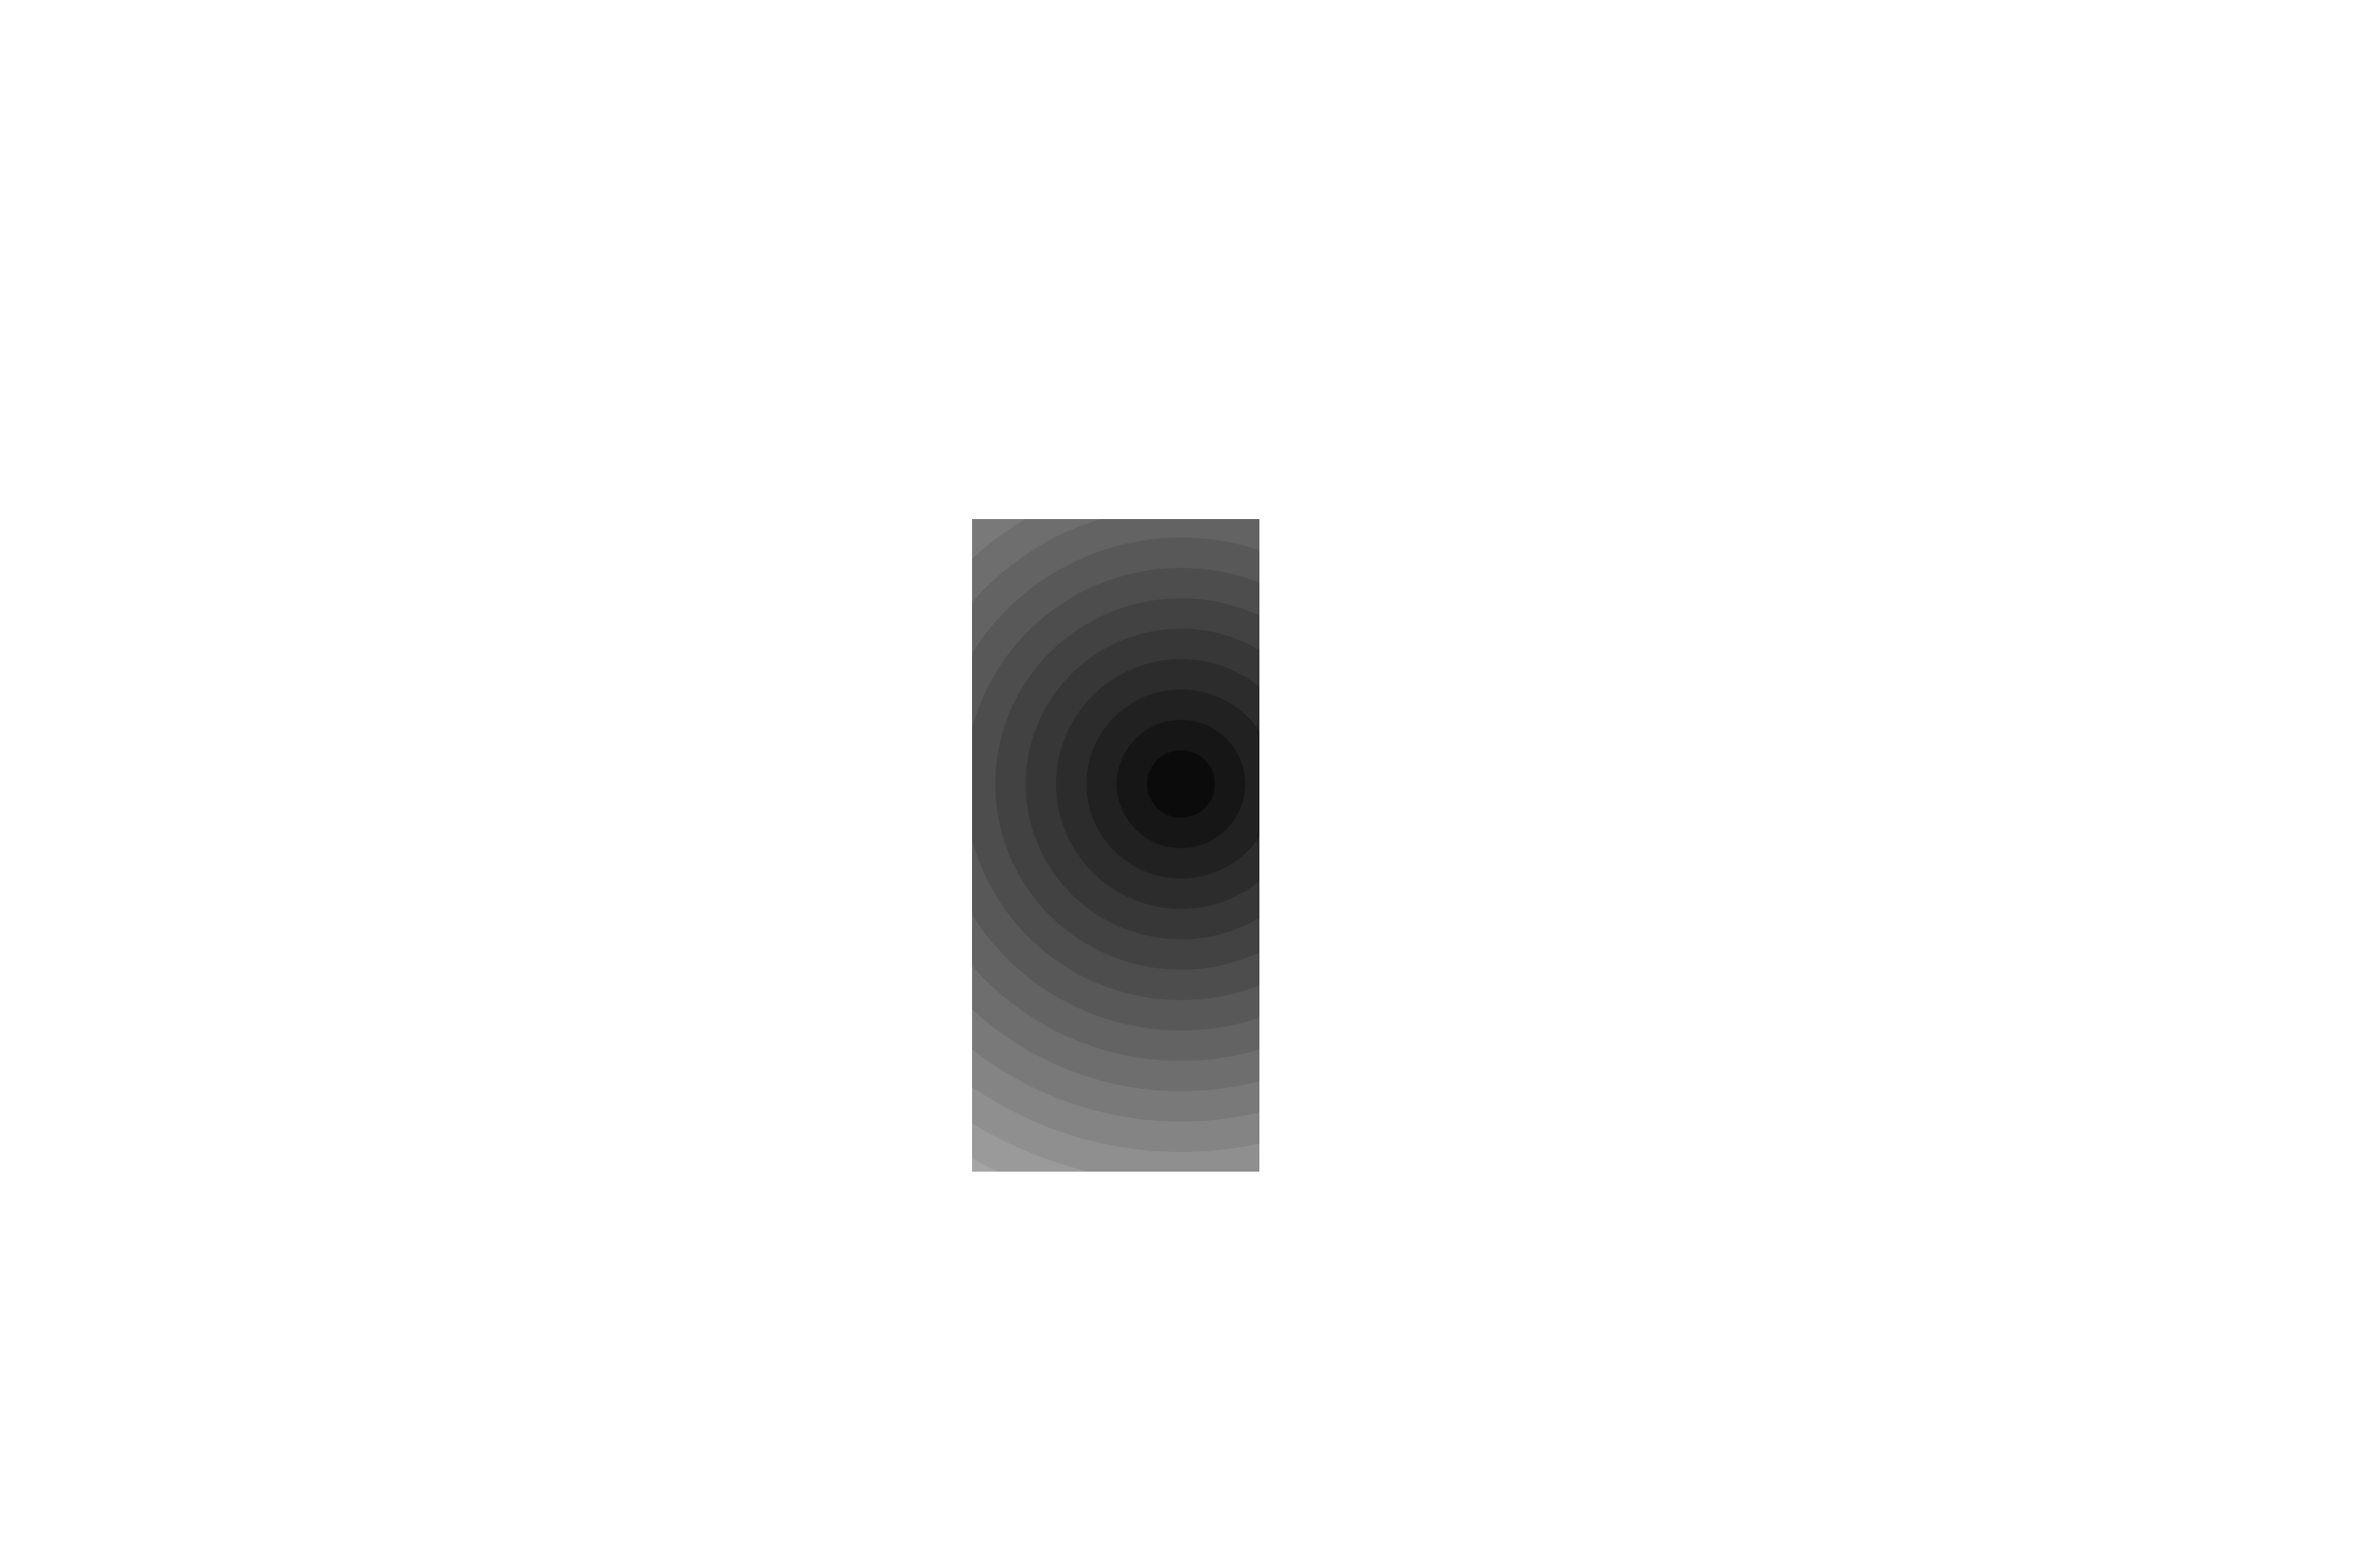

(0.1654387602688046, 0.1565543316311422)
Time                      1.61365e+09
RatX                         0.153254
RatY                          0.15608
RatZ                         0.620735
BeaconX                      0.165439
BeaconY                      0.156554
Visibility                          1
time_of_beacon_trigger    1.61365e+09
Beacon_group                        4
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 927, dtype: object
23
[    0 11730 29922 44415 50127 58005 67302 74391 65676 57684 40203 32385
 29049 24558  7005   498     0     0     0     0     0     0     0]
[11730 29922 44415 50127 58005 67302 74391 65676 57684 40203 32385 29049
 24558  7005   498]
[ 225.57692308  575.42307692  854.13461538  963.98076923 1115.48076923
 1294.26923077 1430.59615385 1263.         1109.30769231  773.13461538
  622.78846154  558.63461538  472.26923077  134.71153846    9.57692308]
15
23
[7 4 1 0 0 0 0 0 0 0 

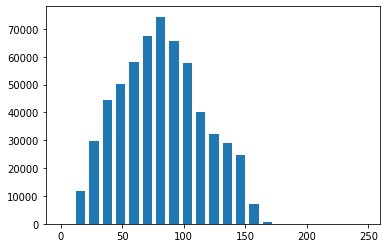

[0.03103154 0.00695141 0.00117078 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00742327 0.        ]
15
[0.03103154 0.00695141 0.00117078 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00742327 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
42


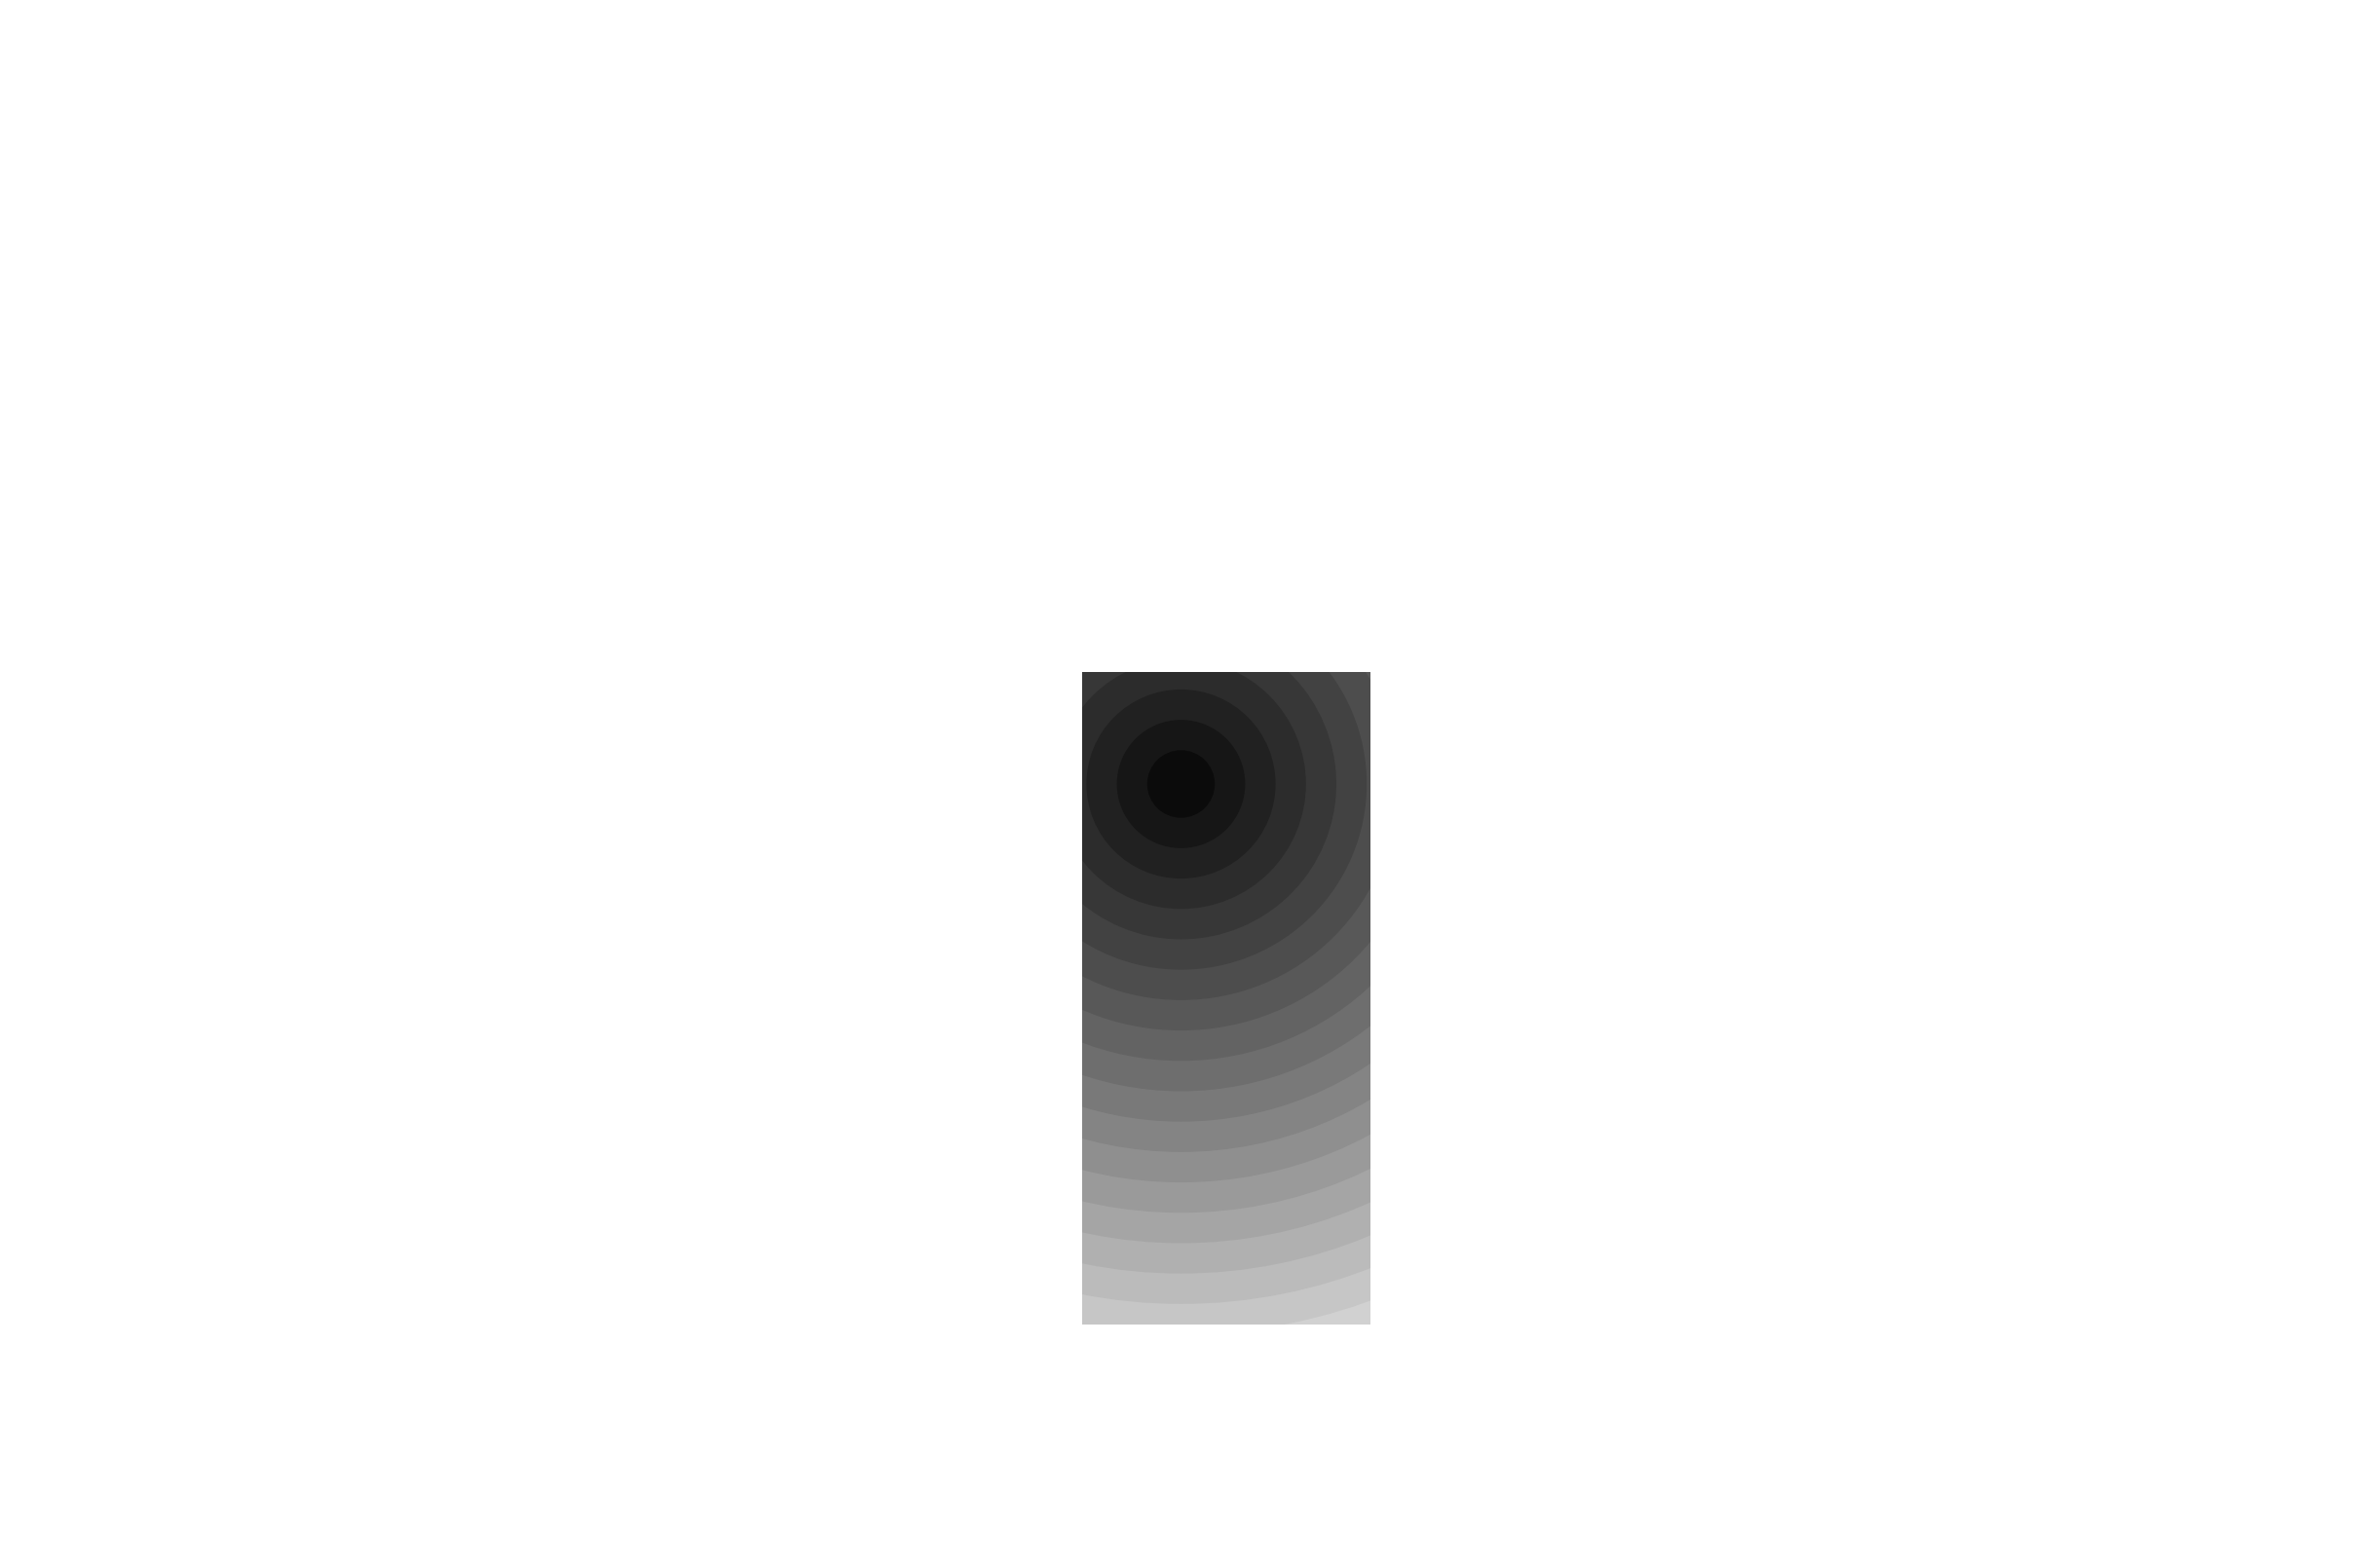

(-0.106570953775193, 0.5331481848245512)
Time                      1.61365e+09
RatX                          0.18107
RatY                        -0.753496
RatZ                         0.624356
BeaconX                     -0.106571
BeaconY                      0.533148
Visibility                          1
time_of_beacon_trigger    1.61365e+09
Beacon_group                        5
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 955, dtype: object
23
[    0 11730 29922 48279 54435 45933 47718 39618 31203 30144 29502 29031
 28809 28647 28530 28395 28281 28146 23784  2853     0     0     0]
[11730 29922 48279 54435 45933 47718 39618 31203 30144 29502 29031 28809
 28647 28530 28395 28281 28146 23784  2853]
[ 225.57692308  575.42307692  928.44230769 1046.82692308  883.32692308
  917.65384615  761.88461538  600.05769231  579.69230769  567.34615385
  558.28846154  554.01923077  550.90384615  548.65384615  546.05769231
  54

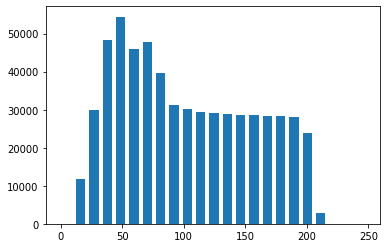

[0.03103154 0.01042711 0.         0.00095527 0.         0.
 0.0039376  0.00499952 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00218634
 0.        ]
19
[0.03103154 0.01042711 0.         0.00095527 0.         0.
 0.0039376  0.00499952 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00218634
 0.         0.         0.         0.         0.        ]
23
43


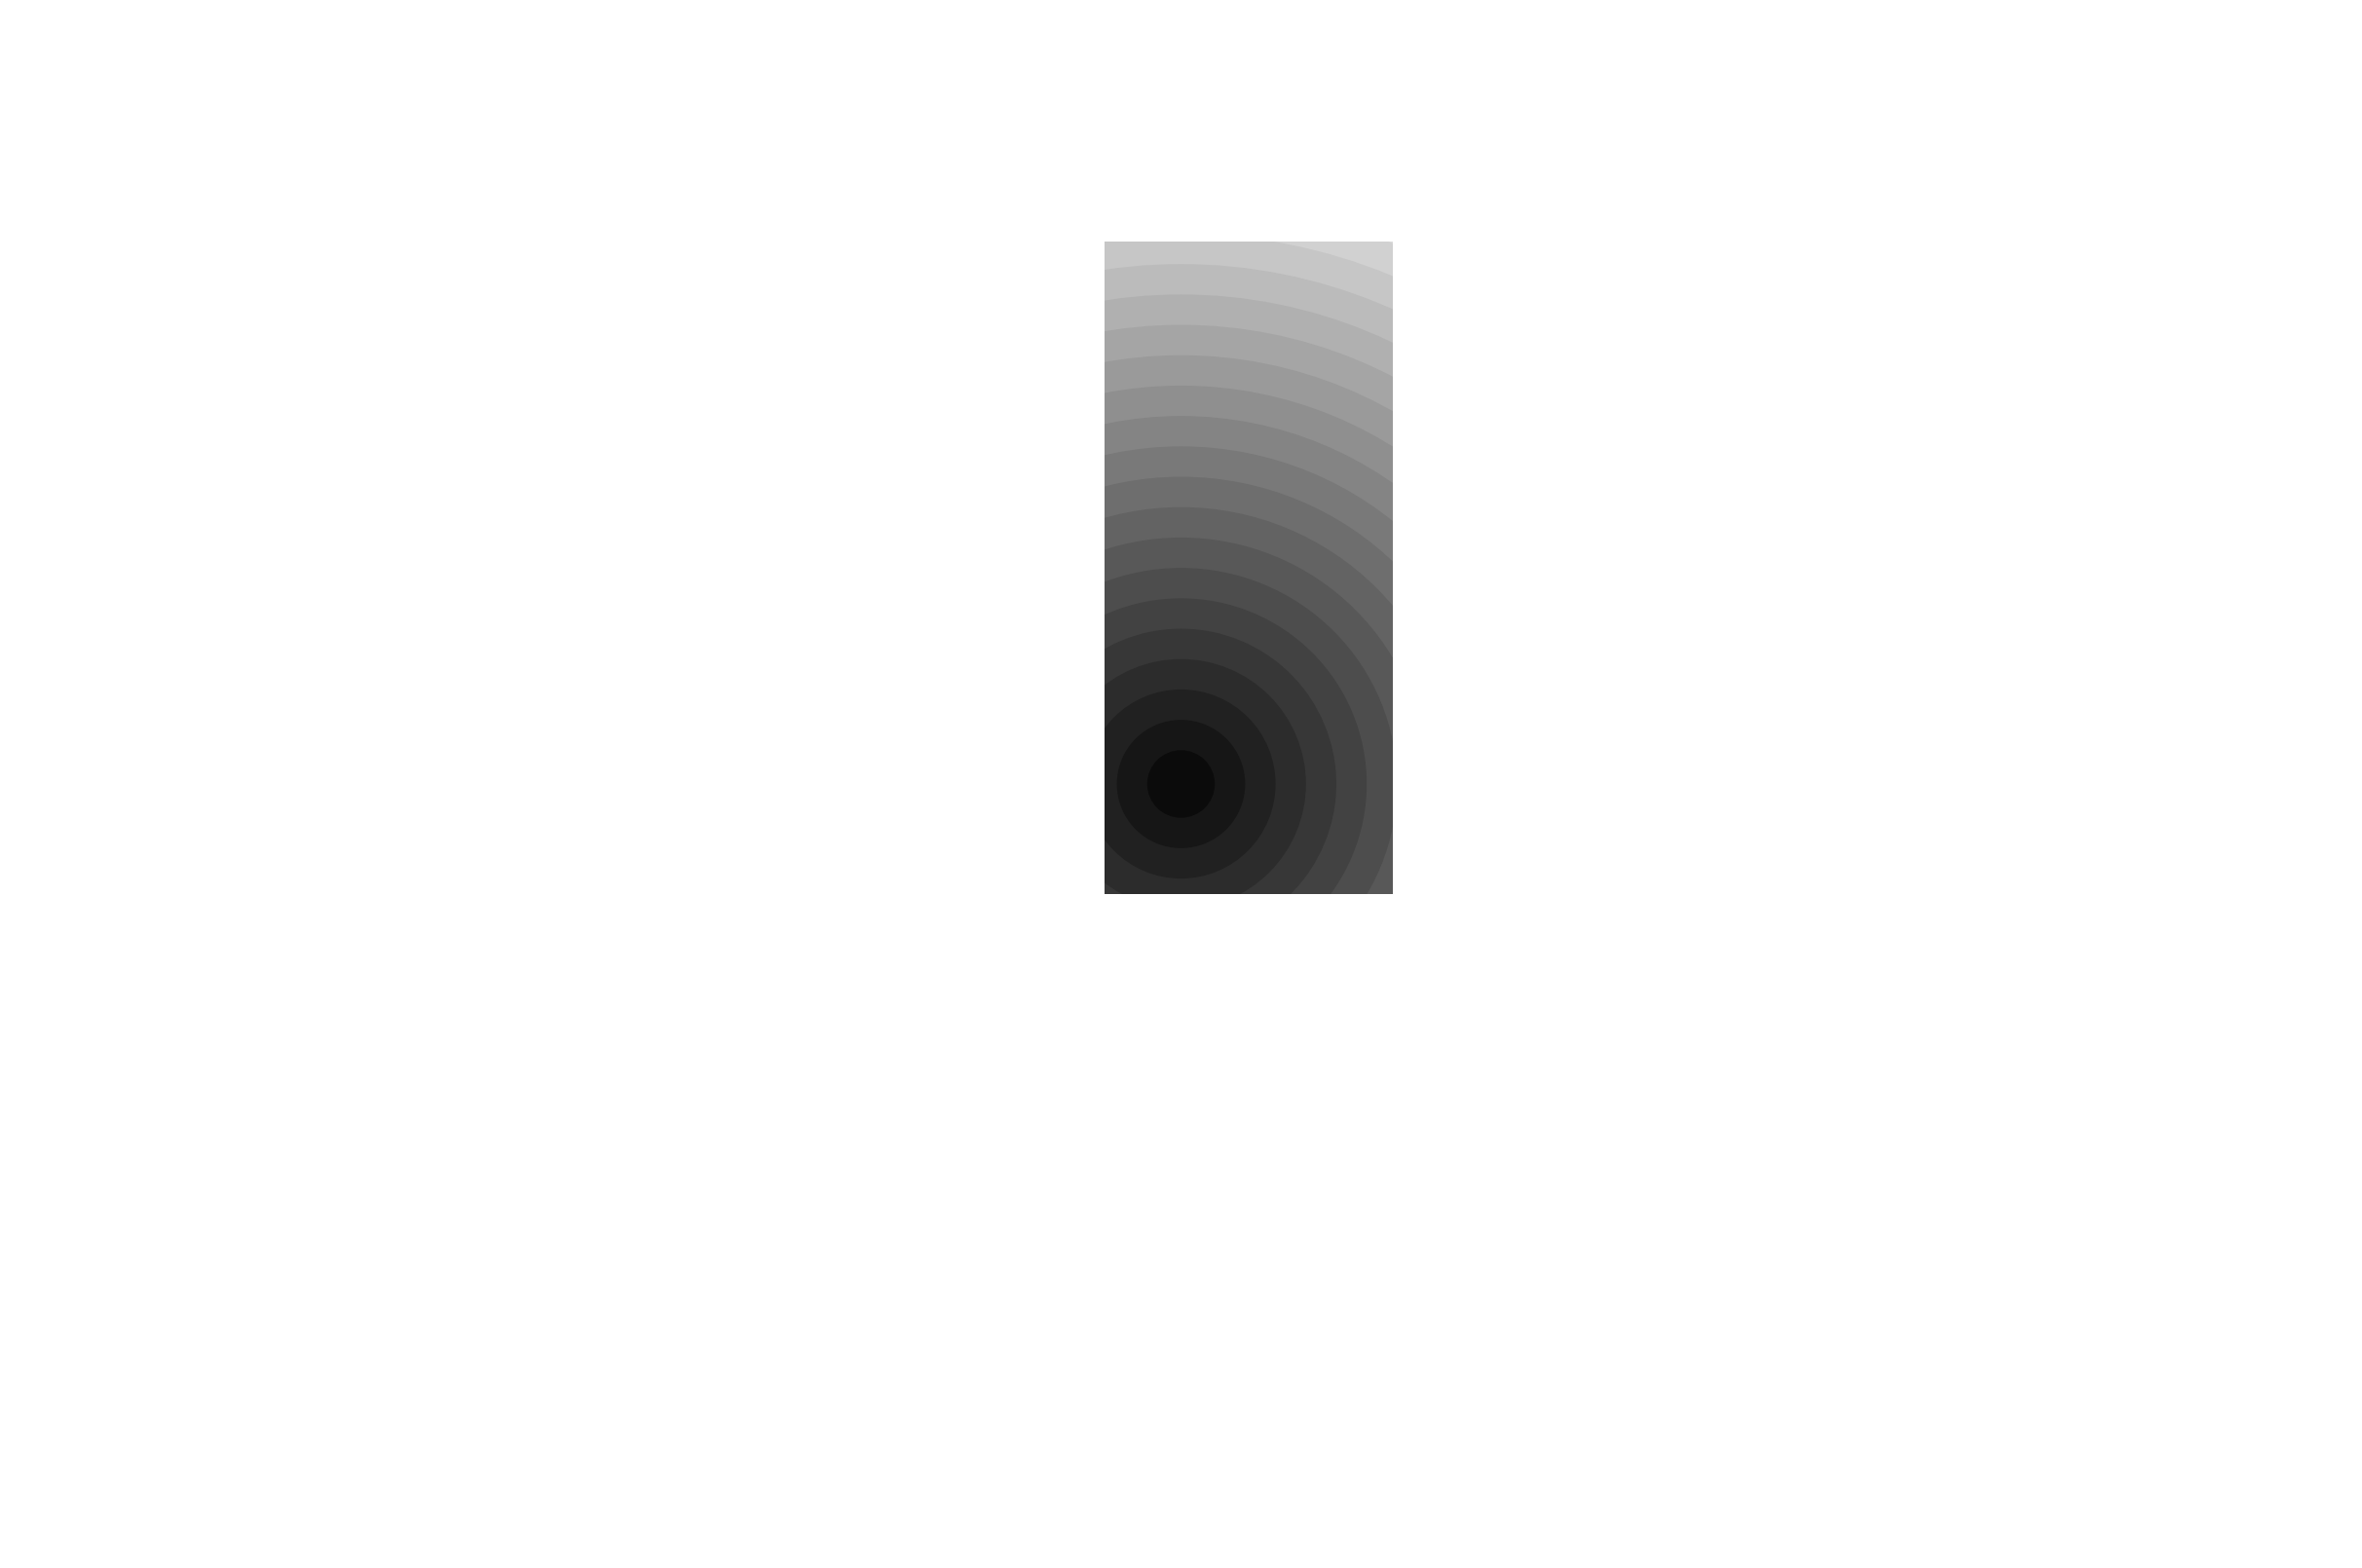

(-0.161819261454925, -0.5287954870929873)
Time                      1.61419e+09
RatX                        -0.352548
RatY                         0.703555
RatZ                         0.720952
BeaconX                     -0.161819
BeaconY                     -0.528795
Visibility                          1
time_of_beacon_trigger    1.61419e+09
Beacon_group                        1
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 962, dtype: object
23
[    0 11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550
 29208 28962 28791 28611 28467 28302 25212  5520     9     0     0]
[11730 29922 43731 45603 41136 44955 48222 35577 31251 30201 29550 29208
 28962 28791 28611 28467 28302 25212  5520     9]
[2.25576923e+02 5.75423077e+02 8.40980769e+02 8.76980769e+02
 7.91076923e+02 8.64519231e+02 9.27346154e+02 6.84173077e+02
 6.00980769e+02 5.80788462e+02 5.68269231e+02 5.61692308e+02
 5.56961538e+02 5.53673077e

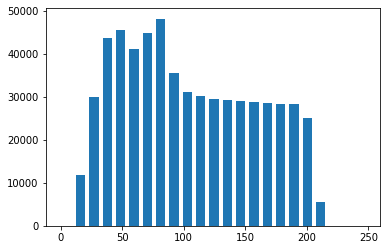

[0.00443308 0.00173785 0.         0.         0.0012641  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00183733 0.
 0.00942029 0.        ]
20
[0.00443308 0.00173785 0.         0.         0.0012641  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00183733 0.
 0.00942029 0.         0.         0.         0.        ]
23
44


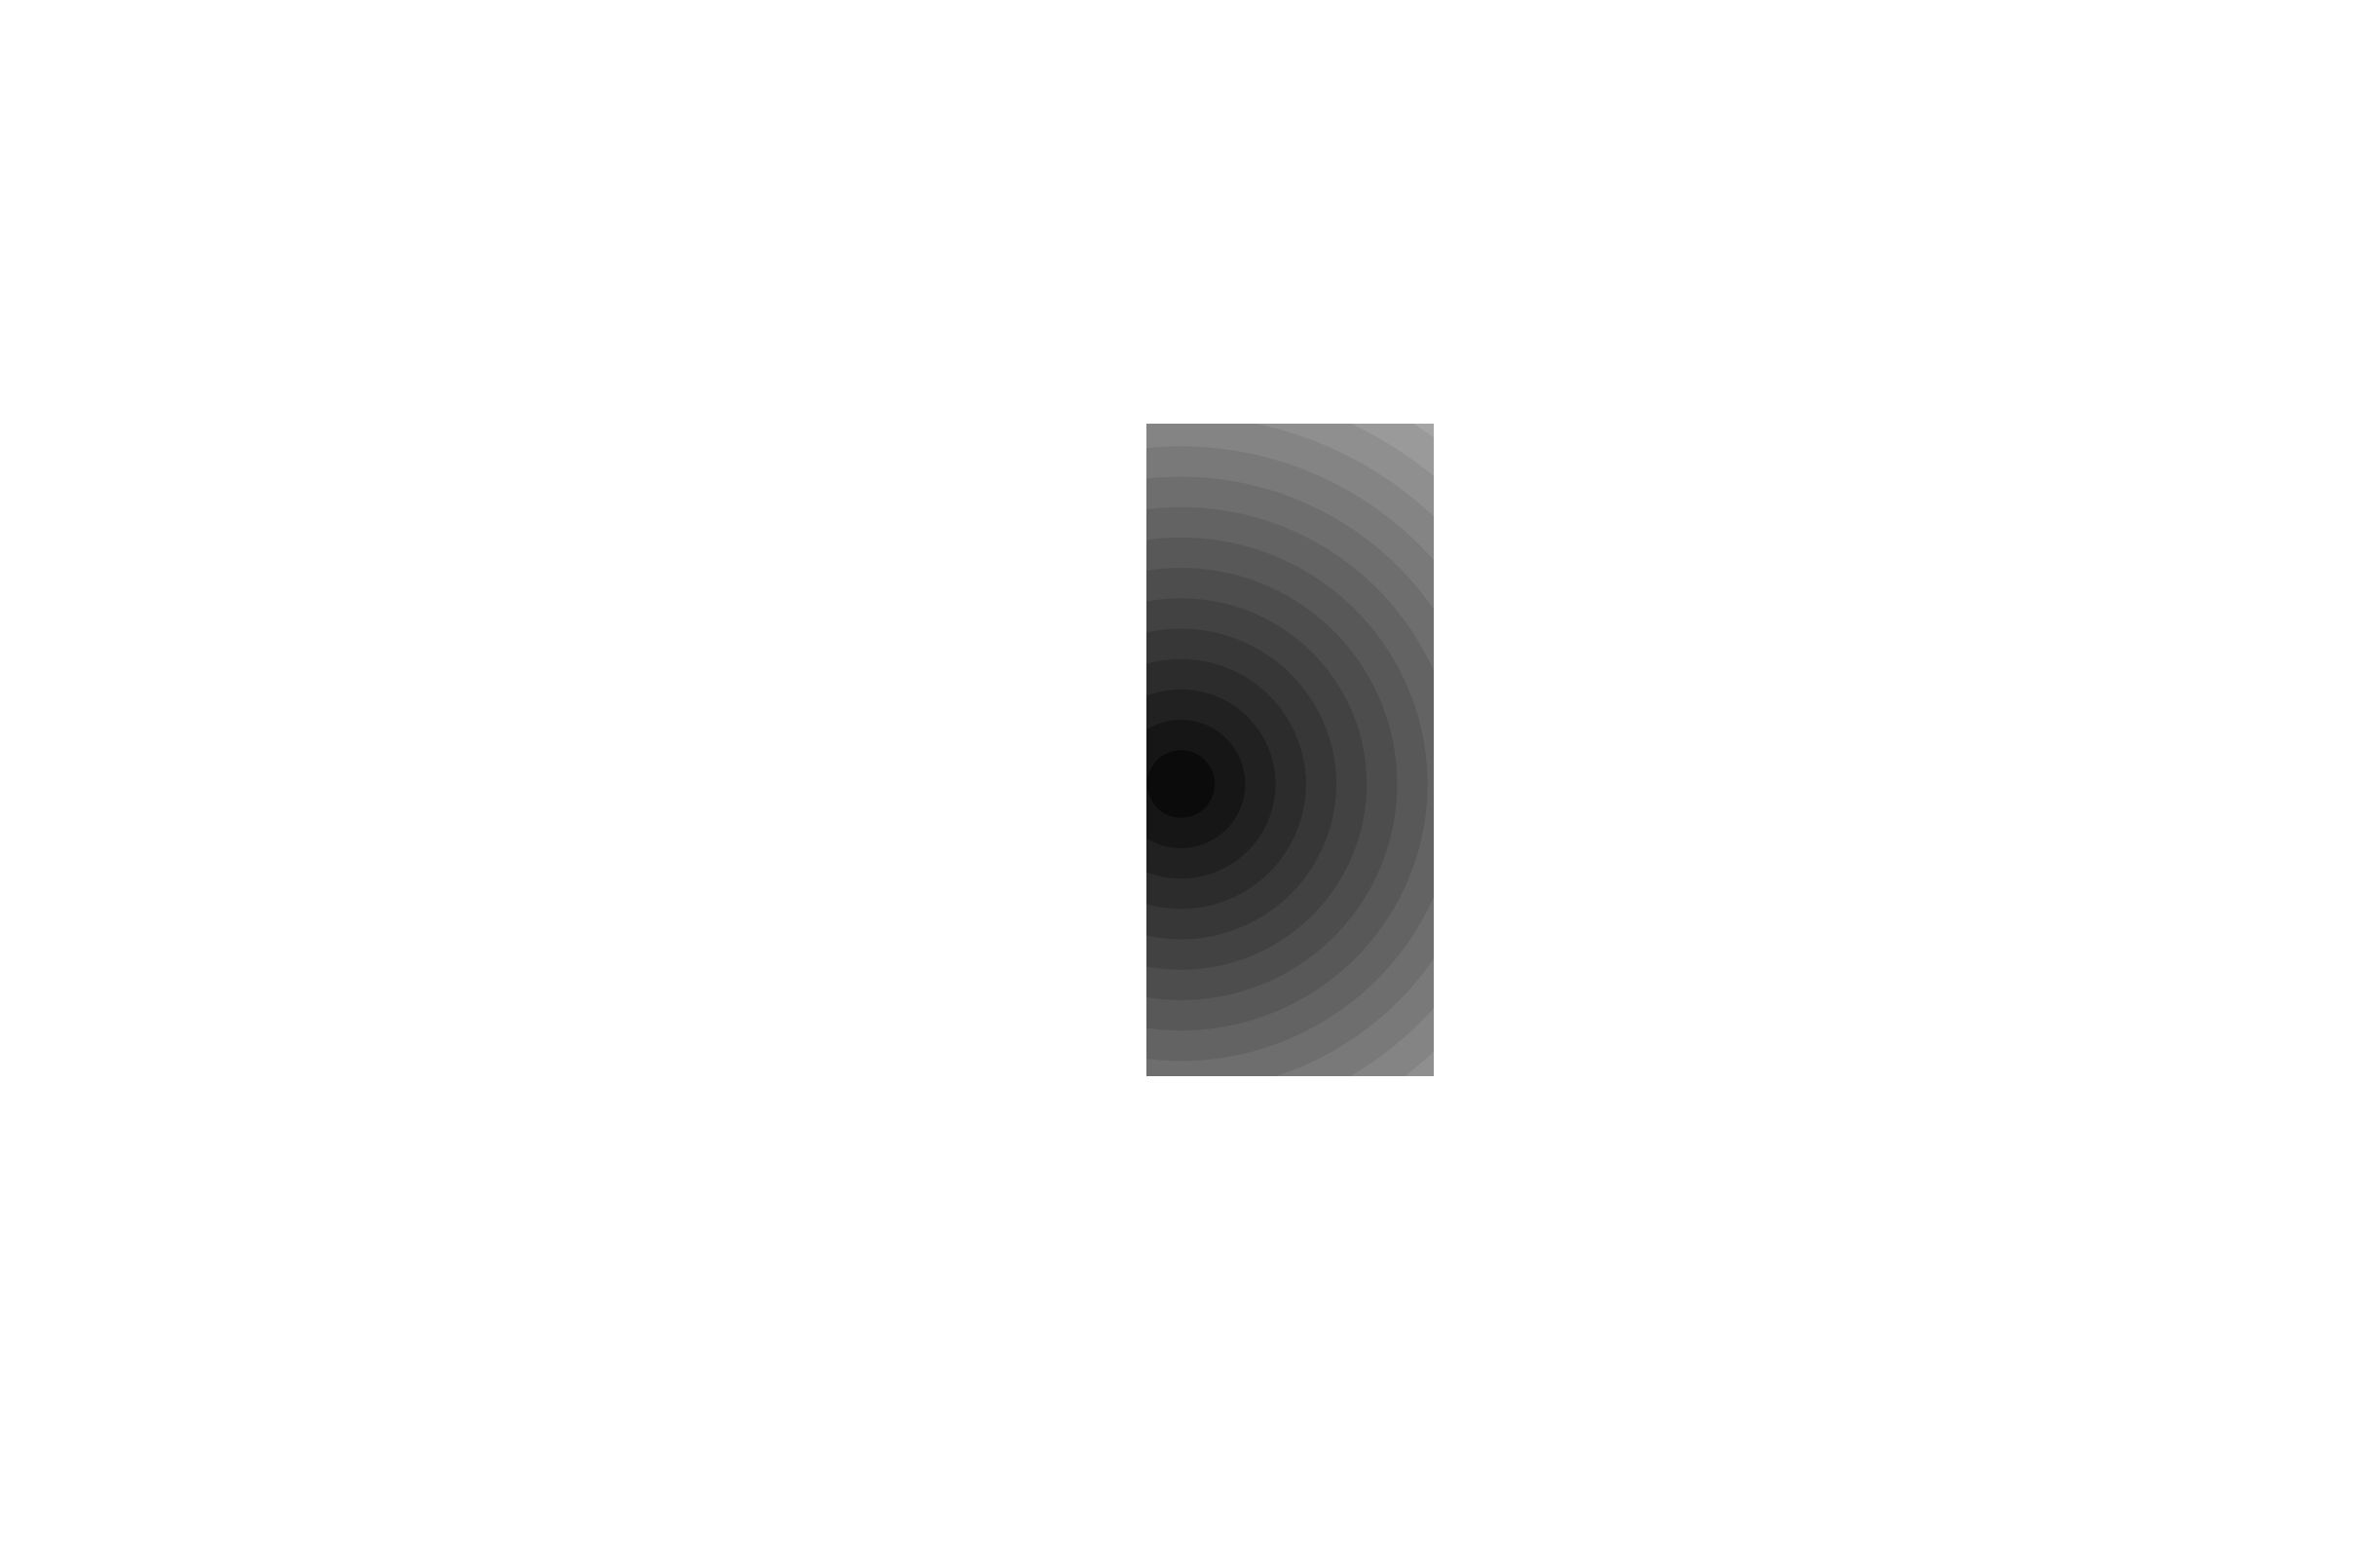

(-0.26503190895852, -0.07944042313113372)
Time                      1.61419e+09
RatX                        -0.316047
RatY                        -0.123736
RatZ                         0.620553
BeaconX                     -0.265032
BeaconY                    -0.0794404
Visibility                          1
time_of_beacon_trigger    1.61419e+09
Beacon_group                        2
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 982, dtype: object
23
[    0 11730 22542 31032 40050 48810 58320 67398 76554 74001 60675 45549
 35157 14973  5733   426     0     0     0     0     0     0     0]
[11730 22542 31032 40050 48810 58320 67398 76554 74001 60675 45549 35157
 14973  5733   426]
[ 225.57692308  433.5         596.76923077  770.19230769  938.65384615
 1121.53846154 1296.11538462 1472.19230769 1423.09615385 1166.82692308
  875.94230769  676.09615385  287.94230769  110.25          8.19230769]
15
23
[6 6 0 1 0 0 0 1 0 0

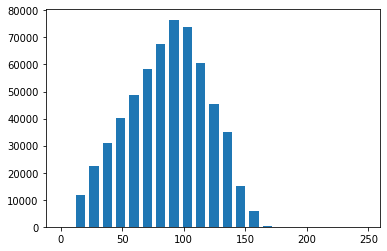

[0.02659847 0.01384083 0.         0.00129838 0.         0.
 0.         0.00067926 0.         0.         0.         0.
 0.         0.         0.        ]
15
[0.02659847 0.01384083 0.         0.00129838 0.         0.
 0.         0.00067926 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
23
45


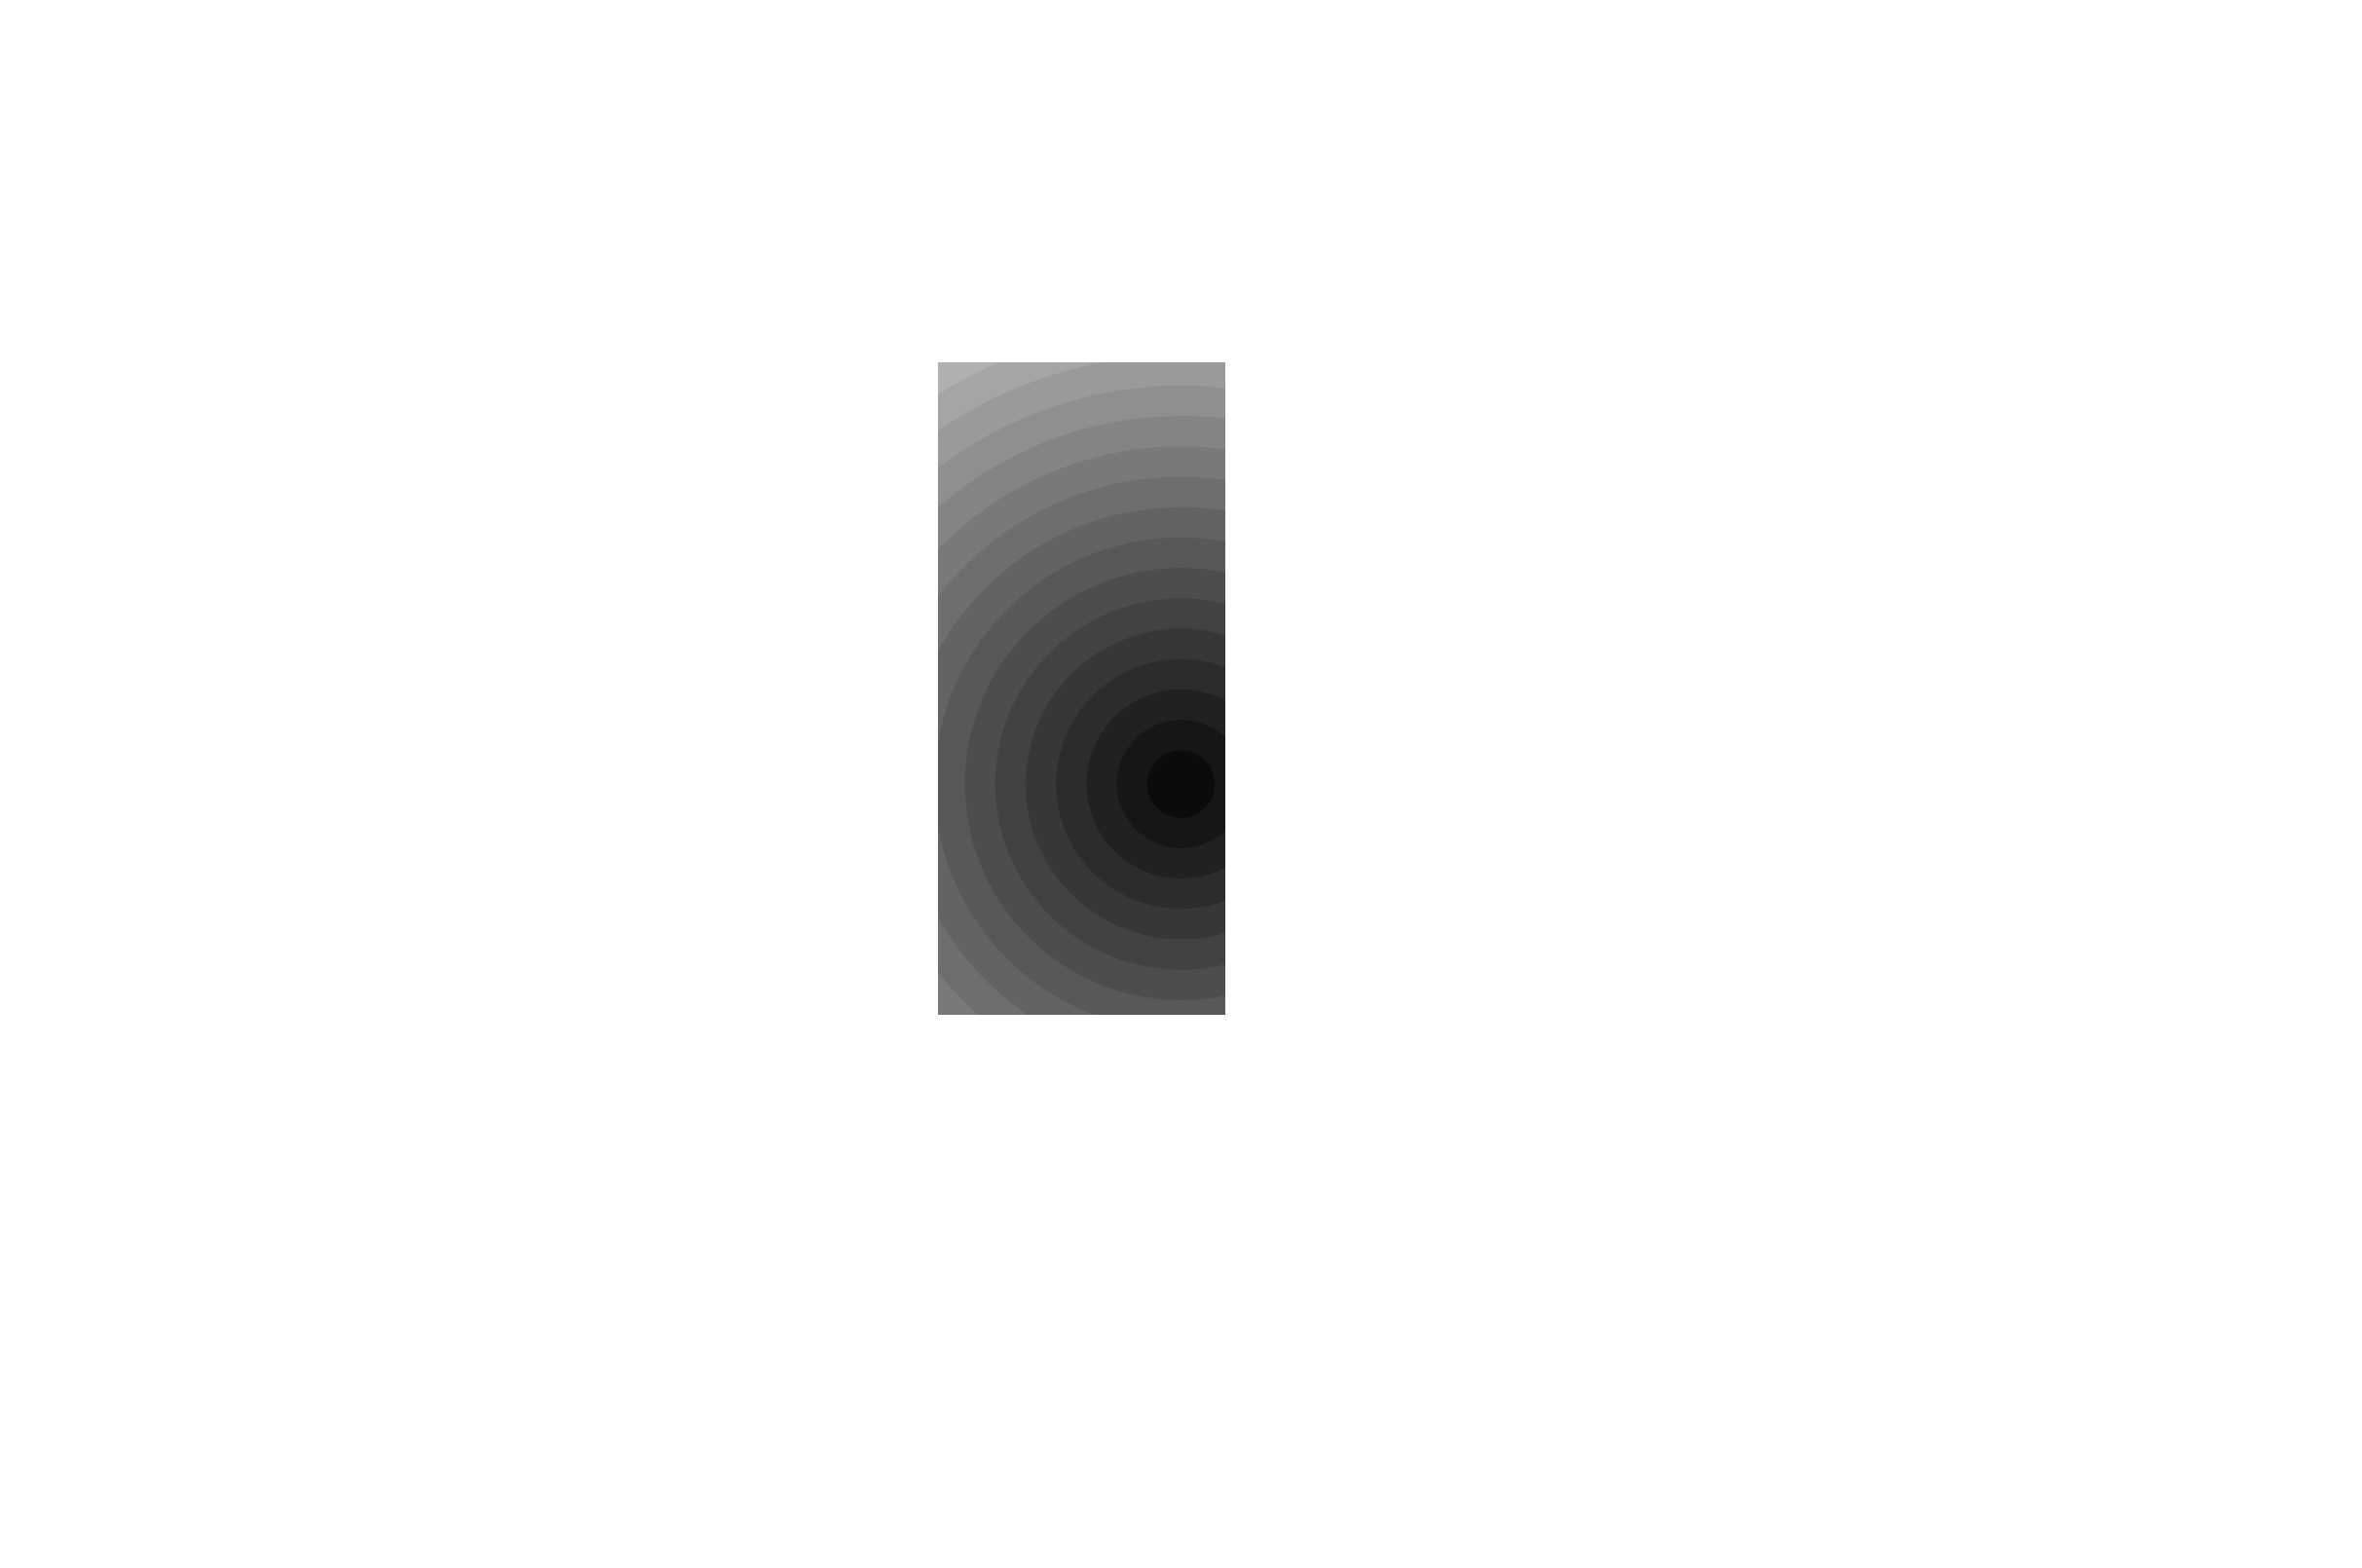

(0.250449974629538, -0.2299716440194322)
Time                      1.61419e+09
RatX                            -0.12
RatY                         0.754048
RatZ                         0.627952
BeaconX                       0.25045
BeaconY                     -0.229972
Visibility                          1
time_of_beacon_trigger    1.61419e+09
Beacon_group                        3
Beacon_subgroup                     1
trial_in_next                    True
13                               True
Name: 994, dtype: object
23
[    0 11730 25704 33207 42057 50745 60252 69303 72741 52338 40923 33108
 29991 29562 27096 11316  2877     0     0     0     0     0     0]
[11730 25704 33207 42057 50745 60252 69303 72741 52338 40923 33108 29991
 29562 27096 11316  2877]
[ 225.57692308  494.30769231  638.59615385  808.78846154  975.86538462
 1158.69230769 1332.75       1398.86538462 1006.5         786.98076923
  636.69230769  576.75        568.5         521.07692308  217.61538462
   55.32692308]
16
23


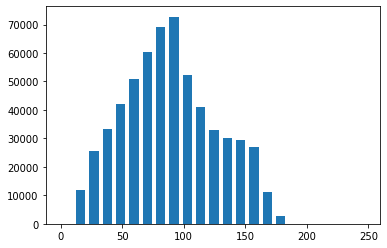

[0.03103154 0.00404606 0.         0.         0.         0.
 0.         0.00071487 0.         0.         0.         0.
 0.         0.         0.00459526 0.        ]
16
[0.03103154 0.00404606 0.         0.         0.         0.
 0.         0.00071487 0.         0.         0.         0.
 0.         0.         0.00459526 0.         0.         0.
 0.         0.         0.         0.         0.        ]
23

cut 0 small division sessions


In [100]:
binwidth=.075

def Multiplication(rears,visible=True ):
    """function involves computing and adding up an overall
    representations of bands as well as an overall and added represenation for beacon distance.
         
    
    PARAMS
    ------------
    rears : Dataframe 
        for each rear  
    visible : boolean 
        if true count only rears when beacon was visible
        
    Returns
    ------------
    Histogram and appropriate bins made by the histogram
    Used for area estimation later on

    """
    
    
    if visible == True:
        visibility=1
    elif visible == False: 
        visibility=0 
    else: 
        visibility= 0 or 1 
    normalized_hist=[]
    arr= np.zeros(23)
    final= np.zeros(23)
    normal_final= np.zeros(23)
    dist_final= np.zeros(23)
    change=0
    bad=0
    dist=[]
    rears[13] = rears["BeaconX"].shift() != rears["BeaconX"]
    #Go through each row 
    for index,row in tqdm(rears.iterrows()):
        if row["Visibility"]== visibility :
            center = (row["BeaconX"],row["BeaconY"])
            #Count how far rear from beacon
            dist.append(math.sqrt((row["RatX"] - row["BeaconX"])**2 + (row["RatY"] - row["BeaconY"])**2))
            #if switch of location of beacon 
        if row[13]==True:
            change += 1
            print(change)
            #count and create normalization histogram for given location
            hist,bins = Normalize(center)
            print (center) 
            print (row) 
            print(len(hist))
            print(hist)
            out_arr = np.nonzero(hist)
            size = len(hist[out_arr])
            print(hist[out_arr])
            #normalize each number to pixel value 
            multi = hist[out_arr]/pix_cm 
            print(multi)
            print(size)
            
            #strip extra numbers and pad with zero's to have always 23 lenght - for not individually divided HIST
            multi_norm=np.pad(np.asarray(multi),(0,23-len(np.asarray(multi))),'constant')
            normal_final=np.add(normal_final,multi_norm) 
            
            #for plottign the size histogram 
            bins = np.arange(0, 1.725 + binwidth, binwidth)
            hist, bins = np.histogram(dist,bins = bins)
            print(len(hist))
            print(hist[0:size])
            print(len(hist[0:size]))
            width = 0.7 * (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2
            plt.bar(center[1::], hist[1:], align='center', width=width)
            plt.show()
            
            #strip extra numbers and pad with zero's to have always 23 lenght - for not individually divided DIST
            multi_dist=np.pad(np.asarray(hist),(0,23-len(np.asarray(hist))),'constant')
            dist_final=np.add(dist_final,multi_dist) 
            
            #Finally divide rears by area (always defined by size as no division by zero should appear)
            normalized_hist=(hist[0:size]/(multi))
            print(normalized_hist)
            print(len(normalized_hist))
            normalized_hist=np.pad(normalized_hist,(0,23-len(normalized_hist)),'constant')
            print(normalized_hist)
            print(len(normalized_hist))
            #tried to have an approtipate size to not cut too many, but also to avoid multiplication by small numbers. 
            if any([x > .1 for x in normalized_hist]): 
                #print(normalized_hist[19])
                print("bad")
                print(change)
                bad+=1
                dist=[]
                continue
            final = np.add(final,normalized_hist*pix_cm) 
            
            dist=[]
    print("cut %s small division sessions" %(bad) )
    return np.array(final)/(change-bad),normal_final/change,dist_final  # have to divide by change to get average 
            
final_test,normal_final,dist_final = Multiplication(FS04_test)

In [ ]:
binwidth=.075
def Multiplication_simple(rears,visible=True ):
    """function involves computing and adding up an overall
    representations of bands as well as an overall and added represenation for beacon distance.
         
    
    PARAMS
    ------------
    rears : Dataframe 
        for each rear  
    visible : boolean 
        if true count only rears when beacon was visible
        
    Returns
    ------------
    Histogram and appropriate bins made by the histogram
    Used for area estimation later on

    """
    if visible == True:
        visibility=1
    elif visible == False: 
        visibility=0 
    else: 
        visibility= 0 or 1 

    normalized_hist=[]
    arr= np.zeros(23)
    final= np.zeros(23)
    normal_final= np.zeros(23)
    dist_final= np.zeros(23)
    change=0
    bad=0
    dist=[]
    rears[13] = rears["BeaconX"].shift() != rears["BeaconX"]
    #Go through each row 
    for index,row in rears.iterrows():
        if row["Visibility"]== visibility :
            
            center = (row["BeaconX"],row["BeaconY"])
            #Count how far rear from beacon
            dist.append(math.sqrt((row["RatX"] - row["BeaconX"])**2 + (row["RatY"] - row["BeaconY"])**2))
            #if switch of location of beacon 
        if row[13]==True:
            change += 1
            print(change)
            
            #count and create normalization histogram for given location
            hist,bins = Normalize(center = (row["BeaconX"],row["BeaconY"]))
            plt.show()
            print(min(hist[np.nonzero(hist)]))
            #to get rid of division by small numbers - any area lower then 15 cm will be assumed to be 0 1000piselx = 15 cm**2
            hist[hist<1000]=0
            print(min(hist[np.nonzero(hist)]))
            out_arr = np.nonzero(hist)
            size = len(hist[out_arr])
            print(hist[out_arr])
            #normalize each number to pixel value 
            multi = hist[out_arr]/pix_cm 
            #print(multi)
            #print(size)
            
            #strip extra numbers and pad with zero's to have always 23 lenght - for not individually divided HIST
            multi_norm=np.pad(np.asarray(multi),(0,23-len(np.asarray(multi))),'constant')
            normal_final=np.add(normal_final,multi_norm) 
            
            #for plottign the size histogram 
            bins = np.arange(0, 1.725 + binwidth, binwidth)
            hist, bins = np.histogram(dist,bins = bins)
#             width = 0.7 * (bins[1] - bins[0])
#             center = (bins[:-1] + bins[1:]) / 2
#             plt.bar(center[1::], hist[1:], align='center', width=width)
#             plt.show()
            
            #strip extra numbers and pad with zero's to have always 23 lenght - for not individually divided DIST
            multi_dist=np.pad(np.asarray(hist),(0,23-len(np.asarray(hist))),'constant')
            dist_final=np.add(dist_final,multi_dist) 
            
            #Finally divide rears by area (always defined by size as no division by zero should appear)
            normalized_hist=(hist[0:size]/(multi))
            normalized_hist=np.pad(normalized_hist,(0,23-len(normalized_hist)),'constant')
            #tried to have an approtipate size to not cut too many, but also to avoid multiplication by small numbers.
            #could also go through the numbersd and if very small just cut it... 
            if any([x > .1 for x in normalized_hist]): 
                #print(normalized_hist[19])
                print("bad")
                print(change)
                bad+=1
                dist=[]
                continue
            final = np.add(final,normalized_hist) 
            dist=[]
    print("cut %s small division sessions" %(bad) )
    return np.array(final),normal_final/change,dist_final
            
final_test,normal_final,dist_final = Multiplication_simple(FS04_test,visible=True)

0.9473913043478261
0.9047826086956522
0.8621739130434782
0.8195652173913044
0.7769565217391304
0.7343478260869566
0.6917391304347826
0.6491304347826087
0.6065217391304348
0.5639130434782609
0.521304347826087
0.4786956521739131
0.4360869565217391
0.3934782608695652
0.3508695652173913
0.3082608695652174
0.2656521739130435
0.22304347826086957
0.18043478260869567
0.13782608695652177
0.09521739130434782
0.052608695652173916
0.01


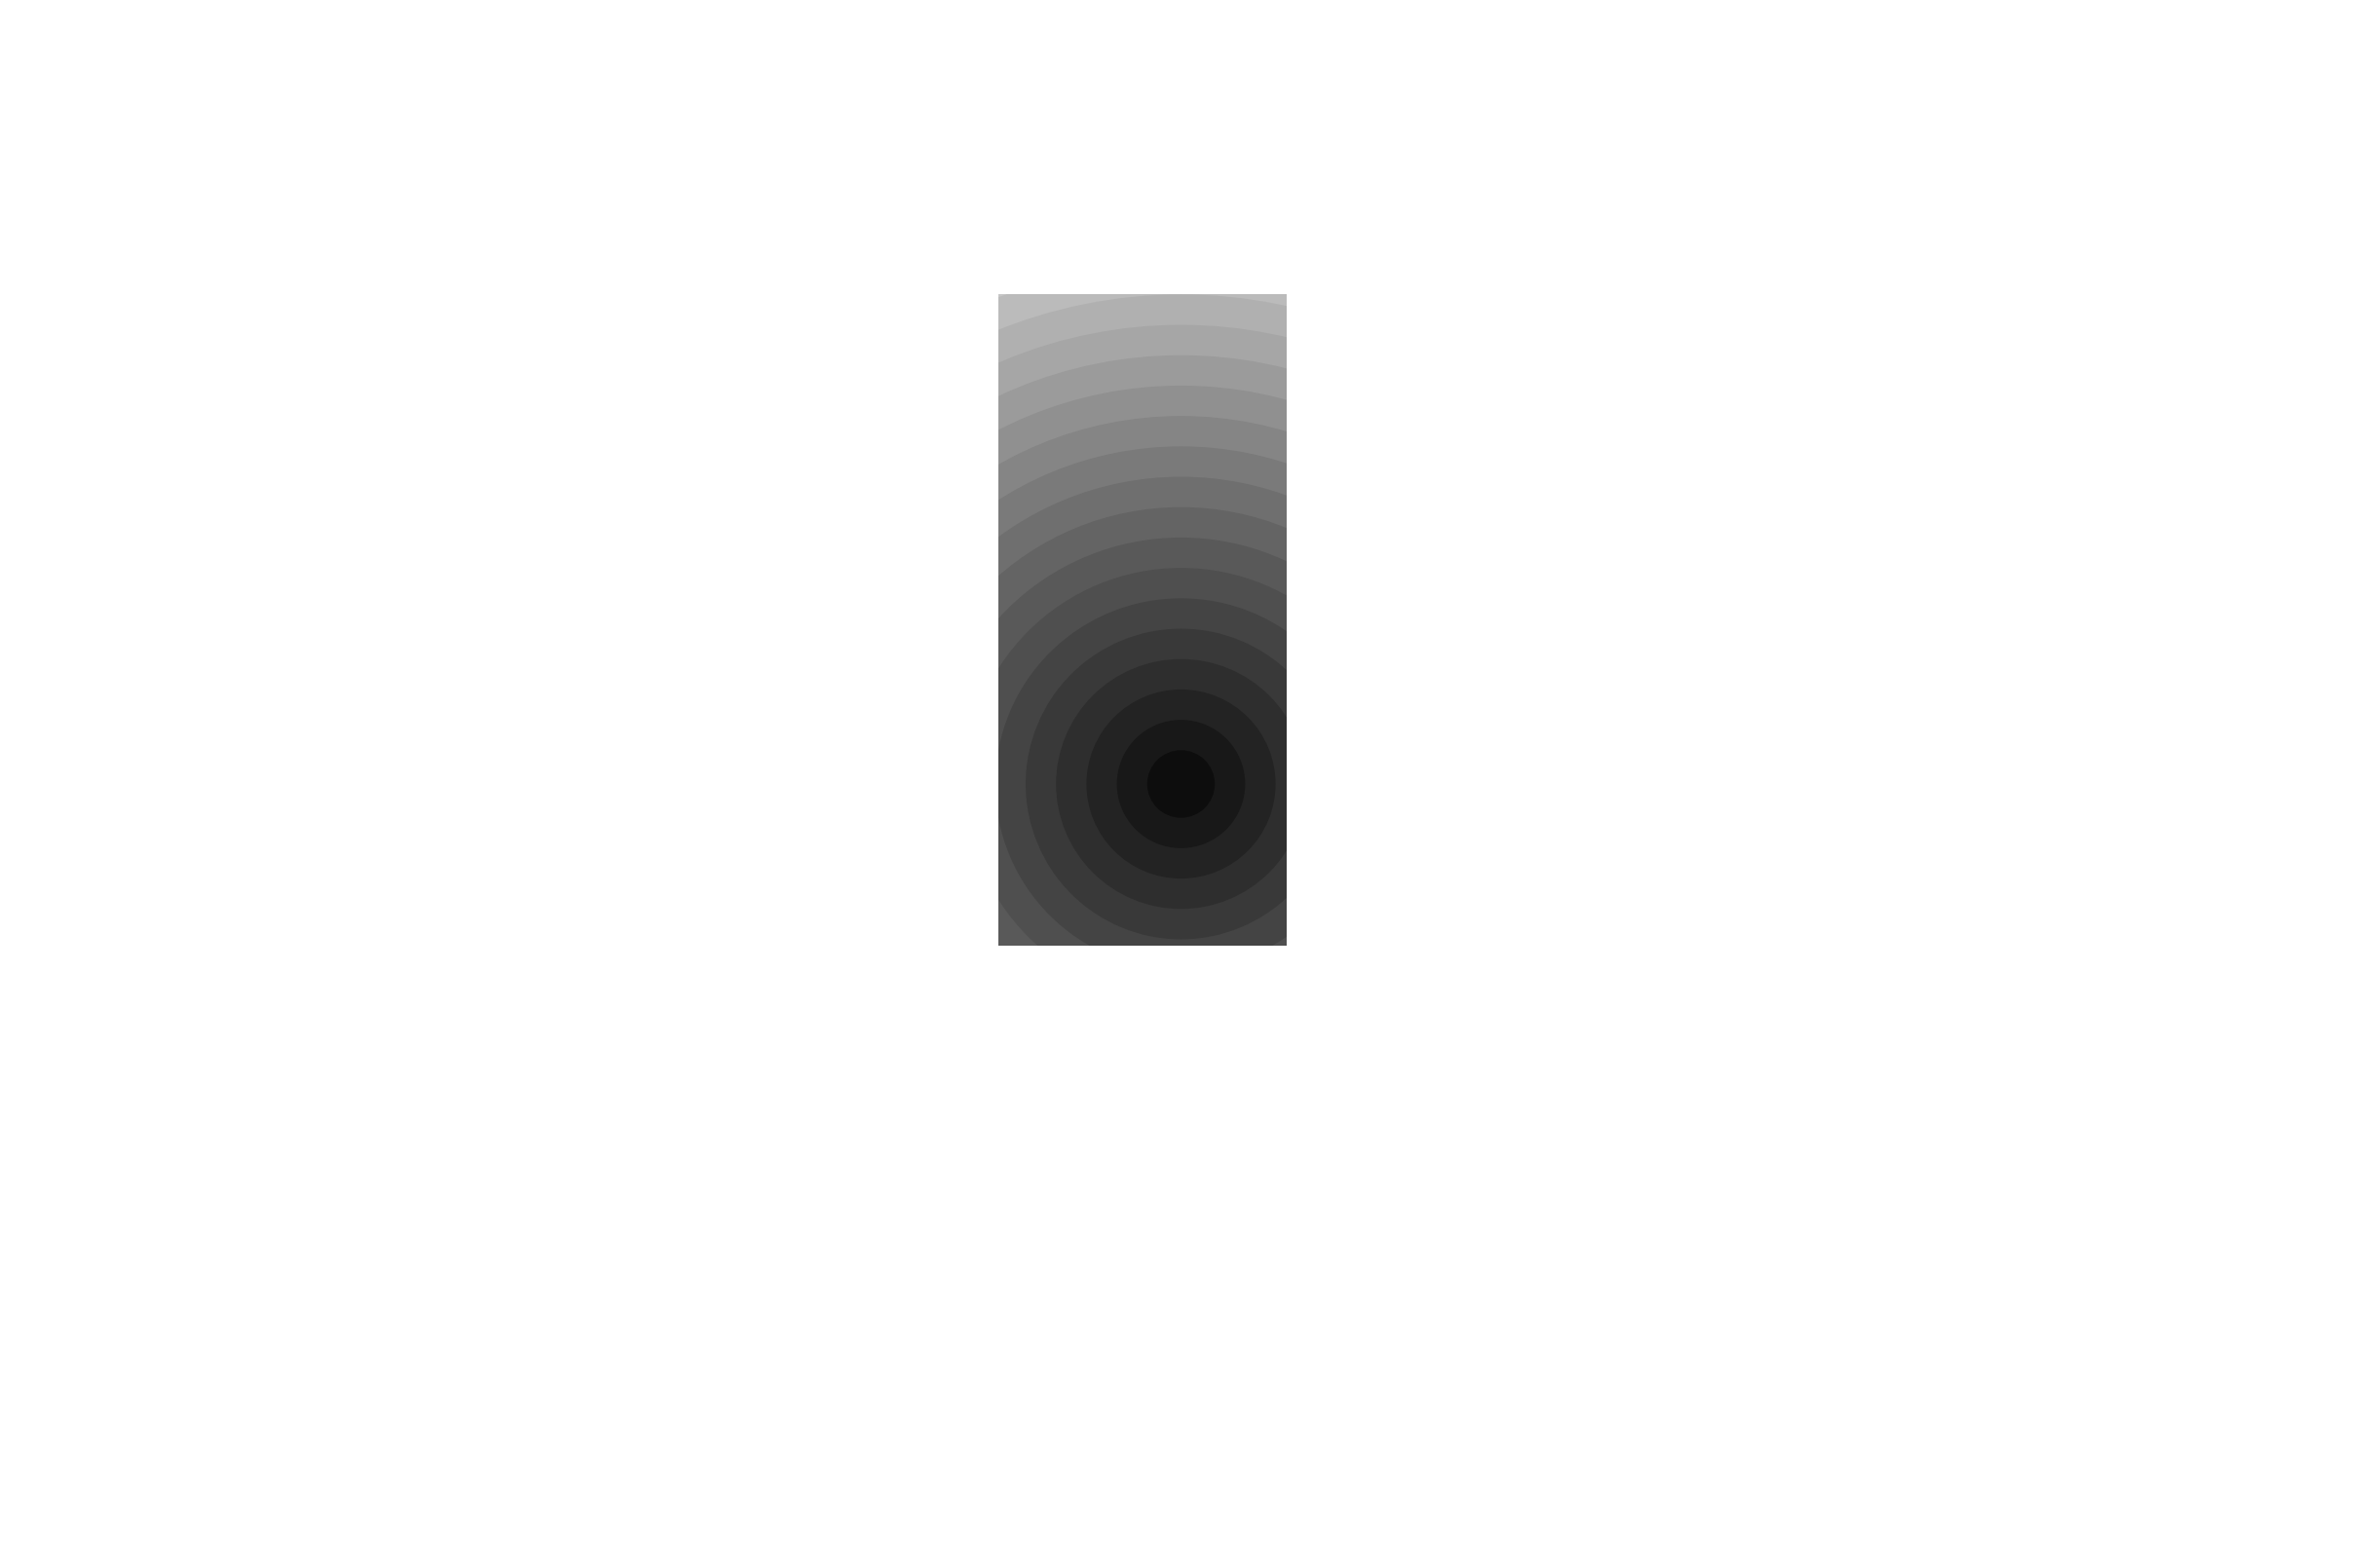

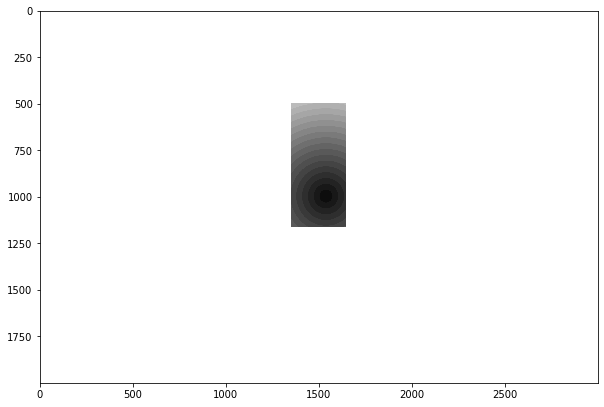

24000000
[[[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 ...

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]]


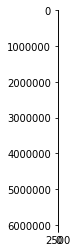

In [8]:
import imageio
def Normalize_test(center=(.1,-.4),dpi=500,X_cut_min = -.59 -xcut_offset,Y_cut_max = 1.61
               + ycut_offset,X_cut_max = .12-xcut_offset,Y_cut_min = .00 +ycut_offset,bands=23 ):
    """make visual count it by area then have hist values for normalization wih movement data
        to be exported and then can be counted
    
    PARAMS
    ------------
    center : tuple 
        where beacon is 
    dpi : int 
        dots per inch - resolution - if changed can mess up pixel count
    X_cut,Y_cut : int
        points of rectagle, same as used for cutting of rears - floor of arena  
        
    bands : int 
        amount of circles fittign inthe rectangle - max is 23 
        
    Returns
    ------------
    Histogram and appropriate bins made by the histogram
    Used for area estimation later on

    """
    
    fig, ax1 = plt.subplots(1, 1, sharex=True,dpi=dpi,frameon=False)
    fig.patch.set_visible(False)
    #fig.set_size_inches(1,1)
    rectangle = patches.Rectangle((X_cut_min,Y_cut_min), (abs(X_cut_min)+abs(X_cut_max)),abs(Y_cut_min)+abs(Y_cut_max) , color="white")
    ax1.add_patch(rectangle)
    #plt.plot(center[0],center[1], "ro")
    color = np.linspace(0.01,.99,bands+1)
    for i in reversed(range(bands)):
        c=color[i]
        print(c)
        patch = patches.Circle((center[0],center[1]), radius=.075*i,color=str(c))
        ax1.add_patch(patch)
        patch.set_clip_path(rectangle)                  
    ax1.axis("equal")
    ax1.axis("off")

    fig.savefig(figures + 'norm_graph.png', dpi=dpi, transparent=True,pad_inches=0)
    #img= Image.fromarray(np.uint8((fig.canvas.get_width_height(),fig.canvas.tostring_rgb())), mode='L')
    #Image.fromarray(img.astype('uint8'), mode='RGB')
    #print(Image)
    img = imageio.imread(figures + 'norm_graph.png')
    plt.figure( figsize = (10,10))
    plt.imshow(img, cmap = plt.get_cmap(name = 'gray'))
    plt.show()
    
    #img= Image.frombytes('L',fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    #plt.imshow(img,cmap='Greys')
    #img= Image.frombytes('RGB',fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    print(format(img.size))
    plt.imshow(img)
    image_array = np.asarray(img)
    print(image_array)
    hist, bins = np.histogram(image_array,bins=bands,range=(0,254)) # changed to 254 - then first value is already a circle
    #plt.show()
    #plt.hist(image_array.ravel(), bins=bands, range=(0,249))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    return hist,bins 
    
hist,bins = Normalize_test()